# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


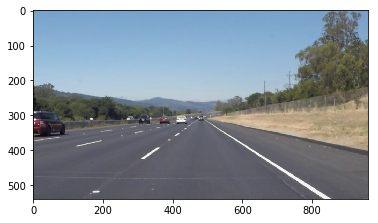

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [6]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    print(len(lines))
    left_lane_line_points=[]
    right_lane_line_points=[]
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope=(y2-y1)/(x2-x1)
            line_length=int(((y2-y1)**2+(x2-x1)**2)**(1/2))
            print(slope)
            if slope >=0.5 and slope<=1000: #belongs to right lane line
                for i in range(1,line_length): # longer lines are weighted more 
                    right_lane_line_points.append((x1,y1))
                    right_lane_line_points.append((x2,y2))
            elif slope<=-0.5 and slope>=-1000: #belongs to left lane line
                for i in range(1,line_length): # longer lines are weighted more 
                    left_lane_line_points.append((x1,y1))
                    left_lane_line_points.append((x2,y2))
            else: #noise. throw out. 
                continue

    left_lane_line_points= np.array(left_lane_line_points,dtype=np.int32)
    right_lane_line_points= np.array(right_lane_line_points,dtype=np.int32)
    
    #least squares fit for left lane hough line segments
    [vx, vy, x, y] = cv2.fitLine(left_lane_line_points, cv2.DIST_L2, 0, 1, np.pi/180) 
    
    imshape=img.shape
    
    min_y_left = np.amin(left_lane_line_points, axis=0);

    max_y=imshape[0]
    min_y_right = np.amin(right_lane_line_points, axis=0);

    min_y =min(min_y_left[1],min_y_right[1])
    

    t1=(min_y-y)/(vy)
    t2=(max_y-y)/(vy)
    
    x1=x+t1*vx;
    y1=y+t1*vy;
    x2=x+t2*vx;
    y2=y+t2*vy;

    #draw left lane line          
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    
    
#     #least squares fit for right lane hough line segments
    [vx, vy, x, y] = cv2.fitLine(right_lane_line_points, cv2.DIST_L2, 0, 1, np.pi/180) 
    
    
    t1=(min_y-y)/(vy)
    t2=(max_y-y)/(vy)
    
    x1=x+t1*vx;
    y1=y+t1*vy;
    x2=x+t2*vx;
    y2=y+t2*vy;

    #draw right lane line          
    cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [7]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

(540, 960, 3)
27
-0.708333333333
-0.753086419753
-0.7
-0.717391304348
-0.75
0.555555555556
0.651162790698
0.585365853659
0.538461538462
0.555555555556
-0.751592356688
0.608695652174
0.625
0.6
-0.741935483871
0.636363636364
-0.125
0.583333333333
0.0
0.625
-0.755555555556
0.692307692308
0.611111111111
0.636363636364
-0.722222222222
-0.702127659574
-0.75
left_points:
2368
right_points:
610
result:
[155 341]
y_values:
[[378 381]
 [426 347]
 [378 381]
 ..., 
 [186 515]
 [174 524]
 [186 515]]


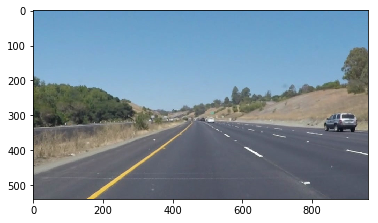

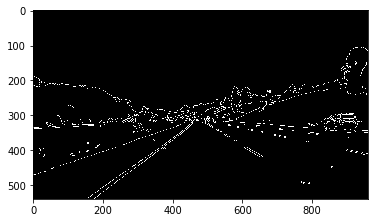

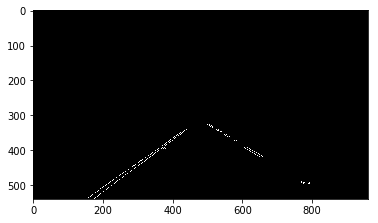

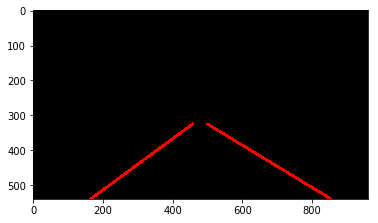

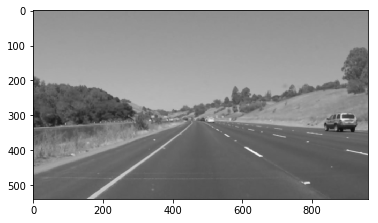

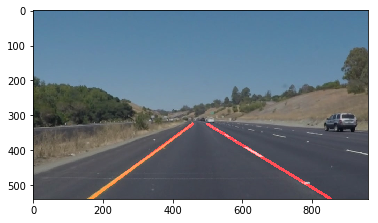

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Do relevant imports
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in and grayscale the image
# image = mpimg.imread('test_images/solidWhiteRight.jpg')
# image = mpimg.imread('test_images/solidWhiteCurve.jpg')
# image = mpimg.imread('test_images/solidYellowCurve2.jpg')
# image = mpimg.imread('test_images/solidYellowLeft.jpg')
# image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
image = mpimg.imread('test_images/solidYellowCurve.jpg')
gray = grayscale(image)
plt.imshow(image)

# Define a kernel size and apply Gaussian smoothing
kernel_size = 5
blur_gray = gaussian_blur(gray,kernel_size)

# Define our parameters for Canny and apply
low_threshold = 40
high_threshold = 120
edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
plt.figure()
plt.imshow(edges,cmap='gray')

print(image.shape)

#Apply region masking
imshape=image.shape
vertices = np.array([[(0,imshape[0]),(475,325),(500,325),(imshape[1],imshape[0])]],dtype=np.int32)
masked_edges= region_of_interest(edges,vertices)
plt.figure()
plt.imshow(masked_edges,cmap='gray')

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1
theta = np.pi/180
threshold = 10
min_line_len = 10
max_line_gap = 5
# line_image = np.copy(image)*0 #creating a blank to draw lines on

# Run Hough on edge detected image

line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
plt.figure()
plt.imshow(line_image)



# Create a "color" binary image to combine with line image
color_edges = np.dstack((blur_gray, blur_gray, blur_gray)) 
plt.figure()
plt.imshow(color_edges)



#Draw the lines on the original image
combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
plt.figure()
plt.imshow(combo)
# cv2.imwrite('test_images_output/solidYellowCurve.jpg',combo)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [9]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [10]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below

    # Read in and grayscale the image
    gray = grayscale(image)

    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    blur_gray = gaussian_blur(gray,kernel_size)

    # plt.imshow(blur_gray,cmap='gray')
    # Define our parameters for Canny and apply
    low_threshold = 40
    high_threshold = 120
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
  

    #Apply region masking
    imshape=image.shape
    vertices = np.array([[(0,imshape[0]),(475,325),(500,325),(imshape[1],imshape[0])]],dtype=np.int32)
    masked_edges= region_of_interest(edges,vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_len = 10
    max_line_gap = 5

    # Run Hough on edge detected image

    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)




    #Draw the lines on the original image
    combo = cv2.addWeighted(image, 0.8, line_image, 1, 0) 
    
    return combo



Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

21
0.6
0.625
0.62893081761
0.6
-0.721739130435
-0.777777777778
-0.777777777778
0.625
-0.723214285714
-0.806451612903
0.622222222222
-0.766666666667
0.615384615385
-0.769230769231
-0.666666666667
-0.692307692308
0.588235294118
0.599348534202
0.0
-0.8
0.625
left_points:
1228
right_points:
2822
result:
[187 357]
y_values:
[[187 513]
 [302 430]
 [187 513]
 ..., 
 [310 432]
 [275 460]
 [310 432]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:07, 27.68it/s]

21
0.6
0.625
0.62893081761
0.6
-0.721739130435
-0.777777777778
-0.777777777778
0.625
-0.723214285714
-0.806451612903
0.622222222222
-0.766666666667
0.615384615385
-0.769230769231
-0.666666666667
-0.692307692308
0.588235294118
0.599348534202
0.0
-0.8
0.625
left_points:
1228
right_points:
2822
result:
[187 357]
y_values:
[[187 513]
 [302 430]
 [187 513]
 ..., 
 [310 432]
 [275 460]
 [310 432]]
19
0.648648648649
-0.733333333333
0.600649350649
-0.773195876289
-0.722222222222
0.636363636364
-0.774647887324
-0.733333333333
0.60162601626
0.632653061224
-0.781818181818
0.601092896175
-0.7265625
-0.705882352941
-0.75
-0.8
0.647058823529
0.65
0.647058823529
left_points:
1356
right_points:
2544
result:
[150 360]
y_values:
[[388 373]
 [403 362]
 [388 373]
 ..., 
 [185 526]
 [170 538]
 [185 526]]
24
0.601063829787
0.60396039604
0.648514851485
-0.724489795918
0.641304347826
-0.7
-0.788888888889
-0.724137931034
0.647540983607
-0.727272727273
0.604166666667
0.660714285714
0.6
-0.8
0.610169491525
-0.78

  5%|▍         | 11/222 [00:00<00:07, 28.99it/s]

16
0.597989949749
0.627659574468
0.6
0.622222222222
-0.709677419355
-0.735294117647
-0.739130434783
-0.733333333333
0.625
0.6
0.551724137931
0.606060606061
0.6
-0.724137931034
0.625
-0.363636363636
left_points:
350
right_points:
2630
result:
[339 378]
y_values:
[[339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 [370 379]
 [339 401]
 

28
0.60162601626
0.624060150376
0.612903225806
0.632075471698
-0.743902439024
0.6
-0.681818181818
-0.759036144578
0.636363636364
0.6
0.609756097561
-0.685714285714
-0.692307692308
0.6
-0.692307692308
0.608695652174
0.612903225806
0.602870813397
-0.769230769231
0.625
-0.75
-0.666666666667
-0.692307692308
0.627450980392
-0.677419354839
0.608695652174
0.0
0.6
left_points:
962
right_points:
2856
result:
[230 359]
y_values:
[[243 484]
 [325 423]
 [243 484]
 ..., 
 [317 421]
 [286 442]
 [317 421]]
24

  7%|▋         | 15/222 [00:00<00:06, 29.72it/s]


0.60396039604
0.649635036496
-0.72
0.649789029536
-0.683544303797
-0.736842105263
-0.730769230769
0.611940298507
-0.676470588235
0.611111111111
0.608695652174
-0.692307692308
-0.714285714286
-0.714285714286
-0.676923076923
0.649350649351
-0.588235294118
0.0
0.588235294118
0.63829787234
0.666666666667
0.606557377049
-0.647058823529
0.590909090909
left_points:
1076
right_points:
2552
result:
[183 360]
y_values:
[[183 515]
 [233 479]
 [183 515]
 ..., 
 [200 502]
 [183 513]
 [200 502]]
19
-0.7
0.650602409639
0.651785714286
0.62441314554
0.622377622378
-0.760330578512
-0.746268656716
0.650943396226
-0.707317073171
-0.714285714286
0.604166666667
0.611940298507
-0.6875
-0.755555555556
0.617647058824
-0.7
0.631578947368
-0.692307692308
0.647058823529
left_points:
1178
right_points:
2470
result:
[145 361]
y_values:
[[145 538]
 [275 447]
 [145 538]
 ..., 
 [399 361]
 [386 370]
 [399 361]]
17
-0.75
0.623762376238
0.653846153846
0.653333333333
-0.695238095238
0.649572649573
0.626168224299
0.62420

13
0.625
0.670807453416
0.670103092784
-0.709677419355
0.625
0.636363636364
-0.65625
0.661538461538
0.672897196262
-0.677419354839
0.0
0.653846153846
-0.714285714286
left_points:
252
right_points:
2616
result:
[339 378]
y_values:
[[346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]
 [346 402]
 [377 380]


 10%|█         | 23/222 [00:00<00:06, 30.54it/s]

14
0.623376623377
0.652582159624
0.649289099526
0.623762376238
0.650485436893
-0.72972972973
-0.675
0.65
-0.7
-0.675675675676
-0.666666666667
-0.0588235294118
-0.0909090909091
-0.727272727273
left_points:
418
right_points:
2870
result:
[215 384]
y_values:
[[334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 385]
 [334 412]
 [371 3

 14%|█▍        | 31/222 [00:01<00:06, 30.76it/s]

21
0.65445026178
0.622950819672
-0.731958762887
-0.676470588235
0.634146341463
0.636363636364
-0.696078431373
-0.722222222222
0.634146341463
0.666666666667
-0.65
0.63829787234
0.615384615385
-0.705882352941
-0.769230769231
-0.731958762887
-0.657894736842
-0.727272727273
0.619047619048
0.642857142857
-0.733333333333
left_points:
1102
right_points:
2050
result:
[142 364]
y_values:
[[164 539]
 [261 468]
 [164 539]
 ..., 
 [244 481]
 [229 492]
 [244 481]]
17
0.624595469256
0.651162790698
-0.75
-0.698412698413
0.623762376238
0.650306748466
-0.681818181818
0.652631578947
-0.666666666667
-0.766666666667
-0.689655172414
-0.733333333333
-0.7
-0.785714285714
0.625
-0.714285714286
-0.181818181818
left_points:
656
right_points:
2874
result:
[147 367]
y_values:
[[165 538]
 [225 493]
 [165 538]
 ..., 
 [389 368]
 [375 378]
 [389 368]]
17
0.624595469256
0.650306748466
0.65
-0.708333333333
-0.611111111111
-0.7
0.622641509434
-0.75
-0.481481481481
0.621848739496
-0.611111111111
-0.625
-0.727272727273
-

result:
[328 384]
y_values:
[[328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [328 410]
 [365 384]
 [33

 15%|█▌        | 34/222 [00:01<00:06, 29.15it/s]

16
0.650684931507
0.622119815668
0.623966942149
-0.645833333333
-0.714285714286
0.623655913978
0.625
-0.583333333333
0.642857142857
-0.642857142857
-0.756097560976
-0.0625
0.0
-0.692307692308
0.6
-0.111111111111
left_points:
394
right_points:
2318
result:
[311 350]
y_values:
[[311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389]
 [311 420]
 [359 389

 17%|█▋        | 38/222 [00:01<00:06, 29.98it/s]


[146 361]
y_values:
[[147 538]
 [280 445]
 [147 538]
 ..., 
 [405 363]
 [392 373]
 [405 363]]
17
0.62582781457
0.65250965251
0.625441696113
0.65
-0.684210526316
0.659574468085
-0.755102040816


 19%|█▉        | 42/222 [00:01<00:05, 30.27it/s]

-0.679487179487
-0.6875
-0.752941176471
-0.684210526316
-0.684210526316
-0.674418604651
0.657894736842
-0.722222222222
-0.647058823529
-0.764705882353
left_points:
1176
right_points:
2774
result:
[144 363]
y_values:
[[379 376]
 [398 363]
 [379 376]
 ..., 
 [183 525]
 [166 538]
 [183 525]]
20
0.627737226277
0.671641791045
0.625
-0.7
0.669421487603
0.674074074074
-0.716981132075
-0.727272727273
-0.734375
-0.615384615385
0.666666666667
-0.75
-0.75
-0.681818181818
0.588235294118
-0.65
0.625
0.1
-0.692307692308
-0.75
left_points:
812
right_points:
2790
result:
[142 365]
y_values:
[[371 380]
 [391 366]
 [371 380]
 ..., 
 [215 489]
 [203 498]
 [215 489]]
19
0.624548736462
0.671328671329
0.671532846715
0.657142857143
0.619047619048
-0.666666666667
-0.727272727273
-0.666666666667
-0.772727272727
-0.708333333333
0.690476190476
0.685185185185
0.666666666667
-0.761904761905
-0.75
0.619047619048
-0.666666666667
0.631578947368
0.0833333333333
left_points:
370
right_points:
1938
result:
[142 368]
y_v

 20%|██        | 45/222 [00:01<00:10, 16.70it/s]

14
0.672131147541
0.62660944206
0.62962962963
0.669230769231
-0.764705882353
-0.694444444444
0.634146341463
-0.684210526316
-0.735294117647
0.0
0.0
0.659090909091
0.675
0.628571428571
left_points:
338
right_points:
2382
result:
[329 381]
y_values:
[[338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [338 409]
 [372 383]
 [33

 22%|██▏       | 48/222 [00:01<00:11, 15.65it/s]

13
0.674825174825
0.625514403292
-0.754098360656
0.670588235294
-0.68
0.628318584071
-0.676470588235
-0.666666666667
-0.766666666667
-0.75
0.625698324022
0.612903225806
0.647058823529
left_points:
562
right_points:
2496
result:
[270 402]
y_values:
[[281 450]
 [342 404]
 [281 450]
 ..., 
 [318 423]
 [282 450]
 [318 423]]
19
0.626556016598
0.671586715867
-0.676470588235
-0.746666666667
0.623376623377
0.666666666667
-0.75641025641
-0.642857142857
-0.685185185185
-0.692307692308
0.625
-0.677419354839
0.617021276596
0.677419354839
0.0
-0.642857142857
0.690909090909
0.659090909091
0.0
left_points:
826
right_points:
2374
result:
[240 355]
y_values:
[[255 458]
 [323 412]
 [255 458]
 ..., 
 [408 355]
 [394 364]
 [408 355]]
20
0.671232876712
0.646706586826
-0.698113207547
0.642857142857
-0.766666666667
0.63829787234
0.658536585366
-0.789473684211
-0.704761904762
-0.78125
0.66
0.666666666667
-0.814814814815
0.645833333333
-0.6875
0.661016949153
-0.787878787879
0.0769230769231
0.68
0.666666666667


 23%|██▎       | 51/222 [00:02<00:11, 15.01it/s]

16
-0.702127659574
0.672535211268
0.626728110599
0.630434782609
-0.732824427481
0.672413793103
-0.647058823529
-0.72
0.625
-0.7
0.627586206897
-0.716981132075
-0.7
-0.730769230769
-0.727272727273
0.666666666667
left_points:
1042
right_points:
2614
result:
[141 361]
y_values:
[[141 538]
 [282 439]
 [141 538]
 ..., 
 [398 363]
 [387 371]
 [398 363]]
17
0.673758865248
-0.72641509434
0.626262626263
0.629139072848
-0.698275862069
0.623529411765
-0.735849056604
0.673819742489
-0.725490196078
0.666666666667
-0.8
-0.722222222222
-0.699115044248
-0.666666666667
0.666666666667
0.625
-0.0833333333333
left_points:
1168
right_points:
2710
result:
[139 363]
y_values:
[[160 538]
 [266 461]
 [160 538]
 ..., 
 [397 364]
 [379 376]
 [397 364]]
22
0.672413793103
0.644295302013
0.646153846154
-0.703703703704
-0.72972972973
0.646153846154
-0.733333333333
-0.714285714286
0.672897196262
0.640625
-0.75
-0.69696969697
-0.684210526316
0.1
0.666666666667
0.6484375
0.660377358491
-0.684210526316
0.1
-0.0909090909

 25%|██▍       | 55/222 [00:02<00:12, 13.78it/s]

21
0.676056338028
0.62962962963
0.627218934911
0.671480144404
0.625
0.625766871166
-0.628571428571
0.620689655172
-0.727272727273
-0.75
-0.666666666667
0.68
-0.772727272727
-0.695652173913
-0.6875
-0.65
0.0
0.617021276596
-0.75
0.1
-0.3
left_points:
468
right_points:
2510
result:
[135 368]
y_values:
[[136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 515]
 [136 537]
 [171 

 26%|██▌       | 57/222 [00:02<00:12, 13.12it/s]

15
0.626229508197
0.654320987654
0.648936170213
0.657142857143
-0.641025641026
-0.694444444444
0.626506024096
-0.647058823529
-0.714285714286
0.636363636364
0.625
0.0666666666667
0.666666666667
-0.6
0.62962962963
left_points:
356
right_points:
2512
result:
[218 383]
y_values:
[[323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 383]
 [323 408]
 [362 38

 27%|██▋       | 61/222 [00:02<00:12, 13.12it/s]

16
0.671052631579
0.626436781609
0.625
0.672268907563
-0.705882352941
-0.730158730159
0.672043010753
0.625
0.666666666667
-0.666666666667
-0.711538461538
-0.684210526316
0.684210526316
-0.7
-0.71875
-0.7
left_points:
656
right_points:
2498
result:
[260 355]
y_values:
[[260 454]
 [328 406]
 [260 454]
 ..., 
 [410 356]
 [400 363]
 [410 356]]
16
0.672064777328
-0.698795180723
0.646408839779
0.645714285714
-0.675
0.672597864769
0.660714285714
0.641791044776
-0.615384615385
0.636363636364
-0.674418604651
-0.642857142857
0.684210526316
0.64
-0.75
0.658536585366
left_points:
720
right_points:
2746
result:
[226 357]
y_values:
[[238 476]
 [321 418]
 [238 476]
 ..., 
 [321 416]
 [293 437]
 [321 416]]
22
0.646226415094
0.673400673401
0.646017699115
0.672862453532
-0.672566371681
-0.701298701299
-0.674698795181
-0.673076923077
0.64
0.666666666667
0.642857142857
-0.717391304348
0.692307692308
-0.625
0.659090909091
-0.666666666667
-0.642857142857
0.659090909091
-0.678571428571
-0.6875
0.0
0.66666666

 28%|██▊       | 63/222 [00:03<00:12, 12.88it/s]

32
0.666666666667
-0.673913043478
-0.666666666667
0.625
0.62987012987
0.659340659341
-0.716417910448
0.658536585366
0.630769230769
-0.745098039216
0.615384615385
0.657142857143
0.62962962963
0.654545454545
-0.745098039216
-0.611111111111
-0.647058823529
-0.777777777778
0.636363636364
0.6
-0.666666666667
-0.673913043478
-0.666666666667
-0.758620689655
0.68
0.638888888889
0.607142857143
-0.666666666667
-0.6875
-0.769230769231
0.666666666667
0.633333333333
left_points:
1302
right_points:
2512
result:
[131 360]
y_values:
[[132 538]
 [270 445]
 [132 538]
 ..., 
 [280 447]
 [267 457]
 [280 447]]
18
0.645631067961
0.674329501916
0.661538461538
-0.714285714286
0.645161290323
0.649717514124
-0.669724770642
0.640449438202
-0.68085106383
-0.631578947368
-0.675
-0.684210526316
-0.711538461538
-0.777777777778
0.673469387755
-0.666666666667
-0.6
0.666666666667
left_points:
952
right_points:
2852
result:
[132 363]
y_values:
[[189 511]
 [252 466]
 [189 511]
 ..., 
 [393 363]
 [373 375]
 [393 363]]
22


 29%|██▉       | 65/222 [00:03<00:12, 12.87it/s]

24
0.680672268908
0.627659574468
0.654205607477
0.632653061224
0.654867256637
0.65306122449
0.65
0.62893081761
-0.785714285714
-0.727272727273
0.630769230769
-0.666666666667
-0.652173913043
-0.615384615385
0.666666666667
0.736842105263
-0.733333333333
-0.652173913043
-0.636363636364
0.645161290323
-0.666666666667
0.0
0.705882352941
0.714285714286
left_points:
376
right_points:
2724
result:
[129 370]
y_values:
[[149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [149 539]
 [163 528]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [379 371]
 [357 387]
 [37

 31%|███       | 69/222 [00:03<00:11, 12.84it/s]

14
0.627329192547
0.627450980392
0.674342105263
-0.657894736842
0.62962962963
-0.625
-0.625
0.673076923077
0.669642857143
0.617021276596
0.0
0.619047619048
0.692307692308
-0.6875
left_points:
308
right_points:
2534
result:
[322 382]
y_values:
[[328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409]
 [366 384]
 [328 409

 33%|███▎      | 73/222 [00:03<00:11, 13.09it/s]

16
0.674342105263
0.646511627907
0.642857142857
-0.709677419355
-0.622222222222
0.676470588235
0.677966101695
-0.627906976744
-0.703125
-0.583333333333
0.643835616438
0.673469387755
0.650602409639
-0.7
0.676470588235
0.659090909091
left_points:
552
right_points:
2756
result:
[261 354]
y_values:
[[273 449]
 [335 405]
 [273 449]
 ..., 
 [410 354]
 [400 361]
 [410 354]]
14
0.674342105263
0.646464646465
-0.7
0.646464646465
0.64367816092
-0.666666666667
-0.671052631579
-0.571428571429
0.63829787234
0.672897196262
0.673796791444
0.659090909091
-0.727272727273
0.647058823529
left_points:
604
right_points:
2860
result:
[230 356]
y_values:
[[241 470]
 [321 414]
 [241 470]
 ..., 
 [253 461]
 [242 469]
 [253 461]]
22
0.675409836066
0.62987012987
-0.695238095238
-0.645454545455
-0.651162790698
0.625
0.678899082569
0.672131147541
0.684210526316
-0.642857142857
-0.696078431373
-0.650602409639
0.666666666667
-0.625
0.611111111111
0.714285714286
0.606060606061
-0.653846153846
0.676470588235
0.67289719

 34%|███▍      | 75/222 [00:04<00:11, 12.93it/s]

34
0.691489361702
0.649572649573
0.646341463415
-0.697841726619
-0.666666666667
0.648648648649
-0.707317073171
0.661290322581
0.65625
0.63829787234
0.692307692308
-0.682926829268
-0.666666666667
-0.714285714286
0.619047619048
-0.695652173913
0.62962962963
0.6875
-0.727272727273
-0.708333333333
0.0
-0.727272727273
0.620689655172
0.625
0.653846153846
-0.7
-0.705882352941
0.636363636364
0.6
0.707317073171
0.666666666667
-0.727272727273
0.653846153846
0.695652173913
left_points:
1130
right_points:
2530
result:
[127 361]
y_values:
[[144 538]
 [283 441]
 [144 538]
 ..., 
 [138 528]
 [127 536]
 [138 528]]
19
0.650602409639
0.674418604651
0.646408839779
-0.672897196262
-0.675
-0.672131147541
-0.655172413793
-0.672131147541
-0.681818181818
0.660714285714
-0.703703703704
-0.631578947368
-0.6
-0.631578947368
0.649253731343
-0.6875
-0.636363636364
0.674876847291
0.6875
left_points:
1154
right_points:
2516
result:
[123 363]
y_values:
[[149 533]
 [256 461]
 [149 533]
 ..., 
 [382 367]
 [371 374]
 [3

 36%|███▌      | 79/222 [00:04<00:10, 13.29it/s]

18
0.648464163823
0.675675675676
0.651162790698
0.676691729323
-0.647058823529
0.674556213018
-0.631578947368
-0.625
0.649572649573
-0.652173913043
-0.636363636364
0.675324675325
-0.65
-0.666666666667
-0.666666666667
0.666666666667
-0.666666666667
-0.65
left_points:
584
right_points:
2760
result:
[118 368]
y_values:
[[138 538]
 [172 516]
 [138 538]
 ..., 
 [375 371]
 [355 384]
 [375 371]]
15
0.650326797386
0.695402298851
0.696296296296
0.649122807018
-0.666666666667
0.65671641791
-0.692307692308
-0.666666666667
-0.65
0.647887323944
-0.739130434783
0.666666666667
0.0
0.619047619048
0.642857142857
left_points:
250
right_points:
2268
result:
[344 372]
y_values:
[[350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [350 392]
 [377 374]
 [3

 36%|███▋      | 81/222 [00:04<00:11, 12.78it/s]

14
0.697841726619
0.651877133106
0.695652173913
0.652542372881
-0.631578947368
-0.702702702703
-0.0909090909091
-0.678571428571
0.653631284916
-0.64
0.722222222222
-0.615384615385
-0.636363636364
-0.636363636364
left_points:
396
right_points:
2436
result:
[211 382]
y_values:
[[319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382]
 [319 406]
 [357 382

 38%|███▊      | 85/222 [00:04<00:10, 13.69it/s]

14
0.654545454545
0.702054794521
0.699658703072
-0.666666666667
0.652380952381
-0.666666666667
-0.671875
0.654320987654
-0.642857142857
0.649572649573
-0.647058823529
-0.703703703704
0.647058823529
-0.6875
left_points:
636
right_points:
2816
result:
[257 403]
y_values:
[[270 439]
 [324 403]
 [270 439]
 ..., 
 [325 403]
 [309 414]
 [325 403]]
17
0.7
0.653846153846
-0.674698795181
-0.642857142857
0.653846153846
-0.675
0.689655172414
0.68
0.692307692308
0.7
0.7
0.625
-0.636363636364
0.708333333333
0.697674418605
0.0
0.695652173913
left_points:
634
right_points:
2678
result:
[227 412]
y_values:
[[236 469]
 [319 413]
 [236 469]
 ..., 
 [312 412]
 [290 426]
 [312 412]]
16
0.699658703072
0.653594771242
-0.693181818182
-0.642857142857
0.652173913043
0.702508960573
-0.707317073171
0.666666666667
-0.647058823529
0.65
-0.709677419355
-0.684210526316
-0.5625
-0.666666666667
-0.642857142857
-0.1
left_points:
922
right_points:
2726
result:
[182 359]
y_values:
[[199 496]
 [287 435]
 [199 496]
 ..., 


 39%|███▉      | 87/222 [00:04<00:09, 13.63it/s]

21
0.701388888889
-0.669014084507
0.702290076336
0.65445026178
-0.628571428571
0.661290322581
-0.622448979592
0.705882352941
0.661538461538
-0.627118644068
-0.666666666667
0.7
-0.625
-0.657894736842
0.0
0.666666666667
0.652173913043
0.653465346535
-0.666666666667
0.666666666667
0.684210526316
left_points:
1196
right_points:
2872
result:
[122 362]
y_values:
[[139 536]
 [281 441]
 [139 536]
 ..., 
 [396 362]
 [381 372]
 [396 362]]
24
0.703448275862
-0.629032258065
0.653846153846
-0.692307692308
-0.6
0.703422053232
0.654676258993
-0.6
-0.666666666667
-0.615384615385
-0.711111111111
0.72
-0.727272727273
0.666666666667
-0.695652173913
-0.625
-0.615384615385
-0.6
-0.722222222222
0.733333333333
0.65
-0.633333333333
0.684210526316
-0.769230769231
left_points:
1144
right_points:
2426
result:
[116 364]
y_values:
[[117 538]
 [179 499]
 [117 538]
 ..., 
 [150 528]
 [137 538]
 [150 528]]
19
0.701754385965
0.700787401575
0.668639053254
-0.64367816092
0.671361502347
-0.701754385965
0.673469387755
-0.

 41%|████      | 91/222 [00:05<00:09, 13.68it/s]

19
0.70297029703
0.674107142857
0.702898550725
-0.64
0.673469387755
-0.652173913043
-0.636363636364
-0.64
-0.69696969697
-0.65
0.676767676768
-0.741935483871
0.704545454545
-0.645161290323
-0.666666666667
0.684210526316
0.0
0.727272727273
0.666666666667
left_points:
528
right_points:
2554
result:
[118 369]
y_values:
[[355 385]
 [380 369]
 [355 385]
 ..., 
 [366 377]
 [354 385]
 [366 377]]
17
0.703488372093
0.653846153846
0.703862660944
0.657407407407
0.666666666667
-0.666666666667
-0.689655172414
0.636363636364
0.712121212121
-0.2
0.75
0.661538461538
-0.666666666667
0.700421940928
-0.666666666667
-0.653846153846
0.631578947368
left_points:
256
right_points:
2734
result:
[344 373]
y_values:
[[351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [378 375]
 [351 393]
 [37

 42%|████▏     | 93/222 [00:05<00:09, 13.37it/s]

20
0.705128205128
0.673170731707
0.704545454545
0.672043010753
0.666666666667
-0.675675675676
0.690476190476
-0.641025641026
-0.648648648649
-0.6
0.666666666667
0.652173913043
0.698198198198
0.692307692308
-0.666666666667
0.681818181818
-0.6
-0.153846153846
-0.636363636364
-0.666666666667
left_points:
398
right_points:
2644
result:
[214 350]
y_values:
[[320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 410]
 [357 385]
 [320 41

 44%|████▎     | 97/222 [00:05<00:09, 13.53it/s]

22
0.672413793103
0.702564102564
0.697368421053
-0.676923076923
0.704142011834
0.7125
-0.677419354839
-0.666666666667
0.688888888889
-0.631578947368
0.703703703704
0.711538461538
0.7
-0.583333333333
-0.666666666667
0.714285714286
0.705882352941
0.688888888889
0.686274509804
-0.678571428571
0.685185185185
-0.5
left_points:
696
right_points:
2746
result:
[261 355]
y_values:
[[261 448]
 [326 404]
 [261 448]
 ..., 
 [407 357]
 [397 362]
 [407 357]]
21
0.666666666667
-0.666666666667
0.675105485232
0.702702702703
-0.679487179487
0.681818181818
-0.672131147541
-0.615384615385
-0.661290322581
0.690476190476
0.757575757576
0.695652173913
0.686274509804
0.672566371681
-0.666666666667
-0.684210526316
-0.684210526316
0.71875
0.789473684211
0.666666666667
0.690476190476
left_points:
810
right_points:
2206
result:
[231 356]
y_values:
[[241 468]
 [322 414]
 [241 468]
 ..., 
 [313 413]
 [294 426]
 [313 413]]
16
0.678899082569
0.700534759358
0.67578125
-0.679611650485
-0.650943396226
0.711111111111
0.7

 45%|████▍     | 99/222 [00:05<00:09, 13.29it/s]


0.678756476684
0.723577235772
-0.643356643357
-0.676258992806
0.673575129534
0.724867724868
-0.625
-0.652173913043
-0.66935483871
-0.6
0.675
0.647058823529
-0.644444444444
-0.645161290323
-0.681818181818
-0.583333333333
0.666666666667
0.0
-0.666666666667
left_points:
1428
right_points:
2270
result:
[132 361]
y_values:
[[132 529]
 [275 437]
 [132 529]
 ..., 
 [263 445]
 [239 461]
 [263 445]]
18
0.67680608365
0.725388601036
-0.672131147541
0.725609756098
-0.6484375
-0.648854961832
0.673684210526
-0.631578947368
0.686274509804
-0.727272727273
-0.676056338028
0.714285714286
0.74
-0.68
-0.545454545455
0.739130434783
0.677215189873
0.723076923077
left_points:
1242
right_points:
2672
result:
[117 360]
y_values:
[[137 538]
 [259 456]
 [137 538]
 ..., 
 [397 360]
 [375 372]
 [397 360]]
17
0.67680608365
0.72373540856
-0.681818181818
0.676470588235
-0.571428571429
0.676691729323
-0.677966101695
-0.635135135135
-0.6
0.724719101124
-0.631578947368
-0.6
0.725490196078
-0.634146341463
-0.63636363636

 45%|████▌     | 101/222 [00:06<00:09, 13.34it/s]

18
0.724299065421
0.676229508197
-0.62
0.724409448819
-0.682926829268
-0.692307692308
0.724637681159
-0.68
0.662162162162
0.675675675676
-0.615384615385
0.666666666667
-0.666666666667
0.709677419355
-0.615384615385
-0.727272727273
0.727272727273
-0.642857142857
left_points:
500
right_points:
2114
result:
[116 367]
y_values:
[[116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [166 507]
 [116 538]
 [1

 47%|████▋     | 105/222 [00:06<00:09, 12.64it/s]

20
0.67
0.702586206897
0.7
0.673076923077
-0.6875
-0.6
-0.655172413793
-0.6
-0.705882352941
0.655172413793
0.666666666667
-0.675675675676
-0.6
0.701492537313
-0.727272727273
0.686274509804
-0.642857142857
-0.148148148148
-0.642857142857
0.709677419355
left_points:
448
right_points:
2290
result:
[217 349]
y_values:
[[338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [338 408]
 [370 386]
 [

 49%|████▉     | 109/222 [00:06<00:08, 13.66it/s]

12
0.700787401575
0.674528301887
-0.636363636364
0.66935483871
-0.727272727273
0.703883495146
0.674418604651
-0.702702702703
0.647058823529
-0.7
-0.7
-0.66
left_points:
560
right_points:
2060
result:
[268 353]
y_values:
[[268 445]
 [334 403]
 [268 445]
 ..., 
 [328 407]
 [278 440]
 [328 407]]
18
0.673640167364
0.700854700855
0.675
-0.642857142857
0.705882352941
-0.7
0.700564971751
-0.615384615385
0.674796747967
0.688888888889
0.672413793103
-0.710526315789
-0.615384615385
-0.75
-0.730769230769
0.677419354839
-0.615384615385
-0.659090909091
left_points:
784
right_points:
2588
result:
[238 355]
y_values:
[[238 466]
 [322 412]
 [238 466]
 ..., 
 [286 434]
 [242 463]
 [286 434]]
20
0.700440528634
0.673151750973
-0.650943396226
-0.676923076923
0.677419354839
-0.658536585366
-0.65
0.7
0.685185185185
-0.636363636364
-0.625
0.714285714286
0.6875
-0.637931034483
-0.625
0.652173913043
0.1
0.692307692308
0.68
-0.774193548387
left_points:
942
right_points:
2148
result:
[197 357]
y_values:
[[197 49

 50%|█████     | 111/222 [00:06<00:08, 13.47it/s]

26
0.647727272727
0.700421940928
-0.647887323944
0.636363636364
-0.7
0.64
0.653846153846
-0.696629213483
-0.666666666667
0.653333333333
0.657142857143
0.654135338346
0.703225806452
-0.588235294118
0.642857142857
-0.650793650794
-0.666666666667
-0.652173913043
0.634146341463
0.68085106383
-0.6
-0.695652173913
-0.692307692308
0.0
0.62962962963
0.608695652174
left_points:
1292
right_points:
2390
result:
[142 359]
y_values:
[[142 530]
 [284 438]
 [142 530]
 ..., 
 [168 525]
 [155 534]
 [168 525]]
17
0.672811059908
0.700483091787
-0.666666666667
0.668965517241
-0.673913043478
-0.699115044248
0.700636942675
-0.666666666667
-0.70652173913
-0.722222222222
-0.65
-0.685185185185
0.684210526316
-0.705882352941
-0.666666666667
-0.647058823529
0.657894736842
left_points:
1144
right_points:
1880
result:
[132 361]
y_values:
[[381 376]
 [396 366]
 [381 376]
 ..., 
 [254 457]
 [237 468]
 [254 457]]
20
0.697508896797
0.672222222222
-0.67816091954
0.673202614379
-0.691358024691
0.699248120301
-0.67213114

 51%|█████     | 113/222 [00:06<00:07, 13.67it/s]


0.697841726619
0.670781893004
-0.682926829268
0.673684210526
-0.702702702703
-0.72
0.700854700855
-0.695652173913
0.699346405229
0.694444444444
-0.714285714286
-0.727272727273
-0.7
-0.7
0.692307692308
-0.727272727273
-0.833333333333
left_points:
556
right_points:
2476
result:
[133 367]
y_values:
[[133 539]
 [174 511]
 [133 539]
 ..., 
 [172 524]
 [154 539]
 [172 524]]
16
0.651515151515
0.698884758364
0.651785714286
0.655629139073
-0.642857142857
-0.72
0.65
0.705882352941
-0.7
0.666666666667
-0.6875
-0.642857142857
-0.722222222222
-0.0769230769231
-0.0909090909091
-0.666666666667
left_points:
278
right_points:
1890
result:
[353 372]
y_values:
[[357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 374]
 [357 392]
 [385 37

 53%|█████▎    | 117/222 [00:07<00:07, 13.44it/s]

17
0.697580645161
0.654867256637
0.655629139073
0.650793650794
0.690476190476
-0.685714285714
-0.648648648649
0.652777777778
0.696721311475
0.658536585366
-0.666666666667
-0.666666666667
0.708333333333
-0.636363636364
-0.678571428571
-0.0833333333333
0.666666666667
left_points:
336
right_points:
2324
result:
[226 379]
y_values:
[[330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]
 [365 380]
 [330 404]

 55%|█████▍    | 121/222 [00:07<00:07, 13.72it/s]

17
0.65
0.674418604651
0.64768683274
0.68085106383
0.676646706587
-0.724137931034
-0.725490196078
-0.714285714286
0.673469387755
-0.583333333333
-0.695652173913
-0.7
0.653846153846
0.655737704918
-0.735294117647
-0.717948717949
0.631578947368
left_points:
624
right_points:
2654
result:
[274 353]
y_values:
[[285 443]
 [343 401]
 [285 443]
 ..., 
 [321 416]
 [282 444]
 [321 416]]
20
0.648351648352
0.69918699187
-0.706666666667
0.673202614379
0.645669291339
-0.72972972973
0.676470588235
-0.727272727273
0.648148148148
-0.692307692308
-0.6
0.661290322581
-0.6
-0.724137931034
-0.7
0.684931506849
-0.694444444444
0.659090909091
-0.586206896552
0.678571428571
left_points:
812
right_points:
2562
result:
[244 354]
y_values:
[[245 463]
 [320 410]
 [245 463]
 ..., 
 [325 409]
 [296 426]
 [325 409]]
19
0.629411764706
-0.655555555556
0.673469387755
0.625
-0.707317073171
-0.65
-0.705263157895
-0.653846153846
0.626865671642
-0.733333333333
0.671052631579
-0.692307692308
-0.631578947368
0.676470588235
-

 55%|█████▌    | 123/222 [00:07<00:07, 13.76it/s]

20
0.674698795181
0.627777777778
0.666666666667
-0.647058823529
-0.703125
-0.671641791045
0.624060150376
-0.702127659574
0.626086956522
-0.625
-0.702479338843
-0.666666666667
0.611111111111
0.677083333333
-0.625
-0.666666666667
0.627906976744
0.0
-0.666666666667
-0.625
left_points:
1334
right_points:
2886
result:
[152 360]
y_values:
[[386 371]
 [403 360]
 [386 371]
 ..., 
 [266 449]
 [234 469]
 [266 449]]
25
0.645714285714
0.673835125448
-0.717948717949
-0.669291338583
0.673728813559
-0.72
0.64
0.642105263158
0.666666666667
0.647058823529
-0.672566371681
-0.647058823529
-0.705882352941
-0.714285714286
-0.673913043478
0.652173913043
0.634146341463
-0.710526315789
-0.615384615385
-0.7
0.658536585366
0.6875
0.653846153846
-0.714285714286
0.648
left_points:
1410
right_points:
2860
result:
[132 362]
y_values:
[[152 538]
 [230 482]
 [152 538]
 ..., 
 [402 365]
 [388 375]
 [402 365]]
19
0.672340425532
0.629213483146
-0.646464646465
0.626984126984
-0.693181818182
0.623595505618
0.666666666667


 57%|█████▋    | 127/222 [00:07<00:06, 13.93it/s]

17
0.673553719008
0.624454148472
0.627329192547
-0.636363636364
-0.666666666667
0.661764705882
0.625
-0.695652173913
-0.636363636364
-0.711111111111
-0.666666666667
0.685185185185
-0.636363636364
-0.714285714286
0.625
-0.647058823529
0.655172413793
left_points:
598
right_points:
2314
result:
[130 368]
y_values:
[[130 538]
 [185 503]
 [130 538]
 ..., 
 [383 372]
 [366 383]
 [383 372]]
11
0.623333333333
0.625
-0.695652173913
0.650273224044
0.65
0.654135338346
-0.642857142857
-0.681818181818
0.634615384615
-0.6
0.64
left_points:
188
right_points:
2420
result:
[357 372]
y_values:
[[365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]
 [365 391]
 [388 375]

 58%|█████▊    | 129/222 [00:08<00:06, 13.55it/s]


0.623333333333
0.651567944251
0.623376623377
-0.705882352941
0.656565656566
-0.69696969697
0.650537634409
0.636363636364
-0.7
-0.702702702703
-0.636363636364
-0.689655172414
0.0
0.624309392265
left_points:
360
right_points:
2764
result:
[235 382]
y_values:
[[335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369 382]
 [335 406]
 [369

 60%|█████▉    | 133/222 [00:08<00:06, 13.19it/s]

22
0.649180327869
0.621212121212
0.650717703349
-0.666666666667
0.607476635514
0.609195402299
-0.688524590164
0.634615384615
-0.719298245614
0.632653061224
-0.7
0.606837606838
-0.696428571429
-0.5
0.653846153846
-0.7
0.661016949153
-0.727272727273
-0.75
0.590909090909
0.590909090909
0.642857142857
left_points:
686
right_points:
2748
result:
[280 342]
y_values:
[[280 445]
 [343 403]
 [280 445]
 ..., 
 [415 353]
 [403 362]
 [415 353]]
17
0.621495327103
0.651245551601
-0.75
0.618320610687
-0.670886075949
-0.693333333333
0.651612903226
0.625
-0.709677419355
-0.727272727273
0.607142857143
-0.7
-0.6
-0.75
-0.666666666667
0.65625
-0.666666666667
left_points:
772
right_points:
2182
result:
[252 342]
y_values:
[[402 367]
 [414 358]
 [402 367]
 ..., 
 [328 413]
 [304 429]
 [328 413]]
18
0.649180327869
0.621621621622
-0.68
0.653846153846
-0.720430107527
-0.674418604651
0.65306122449
0.617283950617
-0.666666666667
-0.692307692308
-0.726315789474
-0.545454545455
-0.72
-0.677966101695
0.623655913978

 61%|██████    | 135/222 [00:08<00:06, 12.97it/s]

19
0.623529411765
0.651376146789
0.649350649351
-0.674242424242
-0.723577235772
0.623931623932
-0.682352941176
-0.714285714286
-0.666666666667
0.653846153846
0.65
-0.684210526316
-0.75
-0.725
-0.6875
0.6
0.0
-0.714285714286
0.6
left_points:
1130
right_points:
2278
result:
[163 360]
y_values:
[[163 525]
 [295 436]
 [163 525]
 ..., 
 [303 439]
 [289 449]
 [303 439]]
19
0.650306748466
0.621513944223
-0.705882352941
-0.701612903226
0.651639344262
-0.75
-0.707070707071
0.63768115942
-0.705882352941
0.661016949153
-0.72
0.652173913043
-0.714285714286
0.626016260163
-0.769230769231
-0.730769230769
-0.785714285714
-0.733333333333
-0.698113207547
left_points:
1138
right_points:
2536
result:
[143 361]
y_values:
[[386 375]
 [403 363]
 [386 375]
 ..., 
 [215 501]
 [162 538]
 [215 501]]
18
0.624561403509
0.649606299213
-0.736842105263
-0.727272727273
-0.686274509804
0.649606299213
-0.686274509804
-0.727272727273
-0.65
0.622222222222
-0.711538461538
0.661764705882
-0.666666666667
0.652173913043
0.62

 62%|██████▏   | 137/222 [00:08<00:06, 13.33it/s]

20
0.649305555556
0.604938271605
0.650602409639
-0.770833333333
-0.698113207547
-0.75
-0.681818181818
0.607476635514
0.611111111111
0.63768115942
-0.684210526316
0.652173913043
-0.714285714286
0.633333333333
0.6
0.648648648649
-0.688888888889
-0.695652173913
-0.7
0.642857142857
left_points:
646
right_points:
2544
result:
[141 366]
y_values:
[[161 539]
 [209 502]
 [161 539]
 ..., 
 [390 366]
 [380 373]
 [390 366]]
14
0.619565217391
0.650684931507
0.619047619048
0.640449438202
0.648854961832
-0.714285714286
-0.739130434783
0.646153846154
-0.708333333333
0.625
-0.733333333333
0.639344262295
-0.2
0.651376146789
left_points:
192
right_points:
2492
result:
[360 370]
y_values:
[[367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [388 374]
 [367 389]
 [

 64%|██████▎   | 141/222 [00:09<00:06, 12.79it/s]

15
0.649831649832
0.649681528662
0.62109375
0.615384615385
-0.705882352941
-0.733333333333
0.65
0.62380952381
-0.705882352941
0.65
-0.72
-0.15
-0.7
-0.71875
0.631578947368
left_points:
388
right_points:
2764
result:
[338 348]
y_values:
[[339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373 381]
 [339 405]
 [373

 65%|██████▌   | 145/222 [00:09<00:05, 12.86it/s]

16
0.622895622896
0.623574144487
0.650735294118
0.649214659686
-0.7
-0.719298245614
0.614035087719
-0.666666666667
-0.666666666667
-0.8
0.651162790698
-0.7
-0.727272727273
-0.692307692308
-0.764705882353
0.65
left_points:
588
right_points:
2888
result:
[286 354]
y_values:
[[286 445]
 [346 403]
 [286 445]
 ..., 
 [352 403]
 [335 416]
 [352 403]]
16
0.624113475177
0.65367965368
0.622406639004
-0.787234042553
-0.698630136986
0.635135135135
-0.767441860465
-0.615384615385
-0.697368421053
0.625
-0.692307692308
0.634920634921
0.62962962963
-0.736842105263
-0.615384615385
0.6
left_points:
708
right_points:
2238
result:
[259 341]
y_values:
[[293 449]
 [340 412]
 [293 449]
 ..., 
 [439 341]
 [426 349]
 [439 341]]
19
0.623376623377
0.65
0.625
-0.698924731183
-0.769230769231
-0.755813953488
0.652173913043
-0.706666666667
0.636363636364
-0.727272727273
-0.75
-0.692307692308
-0.6
0.622641509434
-0.714285714286
-0.7
0.650943396226
-0.753623188406
-0.758620689655
left_points:
1072
right_points:
2530


 66%|██████▌   | 147/222 [00:09<00:05, 13.01it/s]

19
0.650847457627
0.622837370242
-0.782051282051
-0.704
0.65
0.654135338346
-0.703125
-0.769230769231
0.623655913978
0.622093023256
-0.774193548387
-0.714285714286
-0.818181818182
-0.733333333333
-0.789473684211
-0.833333333333
0.0833333333333
-0.703703703704
0.651376146789
left_points:
1234
right_points:
2708
result:
[175 359]
y_values:
[[228 497]
 [306 436]
 [228 497]
 ..., 
 [235 481]
 [181 519]
 [235 481]]
19
-0.722222222222
0.649484536082
0.621621621622
-0.752212389381
-0.72
0.621621621622
0.649038461538
-0.733333333333
0.622222222222
-0.722222222222
-0.769230769231
-0.722222222222
0.641025641026
-0.72
-0.733333333333
-0.739130434783
-0.7
0.631578947368
-0.757142857143
left_points:
1170
right_points:
2476
result:
[152 361]
y_values:
[[183 517]
 [273 452]
 [183 517]
 ..., 
 [271 462]
 [201 515]
 [271 462]]
19
0.64768683274
0.605263157895
-0.761904761905
0.63768115942
-0.701149425287
0.647368421053
0.636363636364
-0.777777777778
-0.714285714286
-0.777777777778
-0.722222222222
0.6451

 68%|██████▊   | 151/222 [00:09<00:05, 13.13it/s]

19
0.604651162791
0.646788990826
0.600823045267
-0.760869565217
-0.695652173913
0.615384615385
-0.672727272727
-0.75
-0.761904761905
-0.760869565217
0.615384615385
0.58064516129
0.651685393258
-0.695652173913
-0.666666666667
0.607142857143
0.583333333333
0.60824742268
-0.727272727273
left_points:
674
right_points:
2408
result:
[151 367]
y_values:
[[170 538]
 [216 503]
 [170 538]
 ..., 
 [174 523]
 [152 539]
 [174 523]]
15
0.628571428571
0.602941176471
0.600877192982
0.631147540984
0.602941176471
0.624
0.636363636364
-0.76
-0.777777777778
-0.739130434783
0.621621621622
-0.791666666667
-0.772727272727
0.647058823529
0.59375
left_points:
266
right_points:
2736
result:
[363 372]
y_values:
[[368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373]
 [368 392]
 [393 373

 69%|██████▉   | 153/222 [00:09<00:05, 13.06it/s]

17
0.620512820513
0.645914396887
0.621621621622
0.644444444444
0.613636363636
-0.764705882353
-0.685714285714
0.646226415094
0.615384615385
-0.75
0.634146341463
-0.705882352941
-0.818181818182
0.64
-0.791666666667
0.652173913043
-0.142857142857
left_points:
364
right_points:
2618
result:
[341 342]
y_values:
[[420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [420 355]
 [437 342]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406]
 [377 382]
 [342 406

 71%|███████   | 157/222 [00:10<00:04, 13.47it/s]

17
0.621399176955
0.649122807018
0.615384615385
-0.75
0.647058823529
-0.733333333333
-0.666666666667
0.65625
-0.719298245614
-0.7
0.628571428571
0.634920634921
-0.756756756757
-0.727272727273
-0.666666666667
0.611111111111
0.648275862069
left_points:
610
right_points:
2378
result:
[289 350]
y_values:
[[299 444]
 [355 402]
 [299 444]
 ..., 
 [420 350]
 [408 358]
 [420 350]]
17
0.620535714286
0.648351648352
0.648936170213
-0.728571428571
0.617886178862
-0.706666666667
0.622222222222
-0.733333333333
-0.695652173913
-0.769230769231
-0.666666666667
-0.714285714286
-0.666666666667
-0.666666666667
-0.75
-0.695652173913
0.620689655172
left_points:
694
right_points:
2510
result:
[262 352]
y_values:
[[272 463]
 [342 412]
 [272 463]
 ..., 
 [343 411]
 [320 427]
 [343 411]]
19
0.648745519713
0.605263157895
0.6
-0.705882352941
0.6
-0.75
-0.785714285714
-0.755555555556
0.648514851485
-0.676470588235
-0.752808988764
0.631578947368
0.602836879433
-0.710526315789
0.644444444444
0.60248447205
-0.7272727

 72%|███████▏  | 159/222 [00:10<00:04, 13.35it/s]

24
0.630434782609
-0.757575757576
0.628571428571
0.602803738318
0.602888086643
-0.723076923077
0.627586206897
-0.730769230769
-0.745762711864
0.623376623377
-0.717391304348
0.6
0.617021276596
-0.666666666667
-0.763157894737
-0.78125
-0.666666666667
-0.714285714286
0.607142857143
-0.6875
-0.818181818182
-0.733333333333
0.636363636364
-0.757575757576
left_points:
1284
right_points:
2986
result:
[178 357]
y_values:
[[245 485]
 [311 435]
 [245 485]
 ..., 
 [241 477]
 [208 502]
 [241 477]]
19
0.630136986301
0.6
-0.727272727273
-0.754385964912
0.621212121212
0.625
-0.720930232558
-0.754385964912
0.623188405797
-0.724137931034
-0.705882352941
-0.6875
0.614035087719
0.617021276596
0.588235294118
-0.75
0.590909090909
-0.714285714286
-0.75
left_points:
1300
right_points:
2066
result:
[156 359]
y_values:
[[156 538]
 [277 450]
 [156 538]
 ..., 
 [402 362]
 [390 371]
 [402 362]]
18
0.599290780142
0.626126126126
-0.78313253012
0.599264705882
0.612903225806
-0.702380952381
-0.777777777778
0.602272727

 73%|███████▎  | 161/222 [00:10<00:04, 13.42it/s]

19
0.62457337884
0.59778597786
0.624087591241
-0.790697674419
0.599033816425
0.596153846154
0.625
-0.7
-0.75
-0.772727272727
0.620689655172
-0.75
-0.731707317073
0.592592592593
-0.714285714286
-0.684210526316
-0.777777777778
-0.785714285714
0.597826086957
left_points:
664
right_points:
2948
result:
[159 367]
y_values:
[[179 539]
 [222 505]
 [179 539]
 ..., 
 [222 506]
 [194 528]
 [222 506]]
15
0.624087591241
0.597402597403
0.5
0.6
0.611111111111
-0.68
-0.692307692308
0.597701149425
0.578947368421
-0.695652173913
-0.846153846154
0.581395348837
0.623529411765
-0.666666666667
0.590909090909
left_points:
230
right_points:
2658
result:
[370 371]
y_values:
[[374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]
 [399 374]
 [374 391]


 74%|███████▍  | 165/222 [00:10<00:04, 12.89it/s]

13
0.577586206897
0.57761732852
0.600877192982
-0.741935483871
0.607476635514
0.6
-0.75
0.577540106952
0.606837606838
-0.75
-0.740740740741
0.614035087719
0.0
left_points:
294
right_points:
2828
result:
[350 381]
y_values:
[[357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 406]
 [388 383]
 [357 4

 76%|███████▌  | 169/222 [00:11<00:03, 13.51it/s]

14
0.57654723127
0.6
0.602189781022
-0.745454545455
-0.777777777778
-0.8
-0.727272727273
-0.785714285714
-0.692307692308
-0.7
-0.739130434783
-0.741935483871
0.564102564103
0.6
left_points:
628
right_points:
2240
result:
[301 339]
y_values:
[[301 443]
 [356 402]
 [301 443]
 ..., 
 [357 402]
 [326 425]
 [357 402]]
15
0.6
0.574144486692
-0.806451612903
0.576086956522
0.6
-0.745762711864
-0.791666666667
-0.8125
-0.692307692308
-0.583333333333
-0.666666666667
-0.769230769231
-0.75
-0.764705882353
-0.571428571429
left_points:
674
right_points:
2738
result:
[283 340]
y_values:
[[289 462]
 [351 412]
 [289 462]
 ..., 
 [442 340]
 [428 348]
 [442 340]]
15
0.6
0.575471698113
-0.78313253012
-0.729166666667
-0.730769230769
-0.780487804878
0.575187969925
-0.727272727273
-0.785714285714
-0.615384615385
-1.0
0.6
-0.8
0.6
0.583333333333
left_points:
906
right_points:
2710
result:
[242 342]
y_values:
[[254 488]
 [337 423]
 [254 488]
 ..., 
 [418 360]
 [408 368]
 [418 360]]


 77%|███████▋  | 171/222 [00:11<00:03, 13.61it/s]

20
0.575949367089
0.600619195046
-0.727272727273
-0.776785714286
0.601851851852
-0.722222222222
-0.735849056604
-0.784615384615
-0.625
-0.666666666667
-0.769230769231
-0.727272727273
0.575757575758
-0.909090909091
-0.794117647059
0.1
0.584905660377
-0.733333333333
0.594594594595
-0.735294117647
left_points:
1102
right_points:
2508
result:
[196 360]
y_values:
[[253 479]
 [275 463]
 [253 479]
 ..., 
 [243 486]
 [209 511]
 [243 486]]
19
0.577287066246
0.605555555556
-0.752212389381
0.600619195046
-0.81
-0.808219178082
-0.846153846154
-0.757575757576
-0.9
-0.8125
-0.8125
0.574074074074
-0.6875
-0.777777777778
0.611111111111
-0.8125
0.589285714286
-0.771428571429
-0.9
left_points:
1180
right_points:
2438
result:
[175 345]
y_values:
[[175 538]
 [288 453]
 [175 538]
 ..., 
 [431 345]
 [421 354]
 [431 345]]
20
0.603112840467
0.576802507837
0.600917431193
-0.769230769231
-0.810126582278
-0.722222222222
-0.752941176471
-0.833333333333
-0.75
-0.803921568627
0.588235294118
0.611111111111
-0.75
0.5

 79%|███████▉  | 175/222 [00:11<00:03, 13.78it/s]


-0.769230769231
-0.764705882353
-0.588235294118
0.6
-0.7
-0.758620689655
0.567567567568
left_points:
538
right_points:
2810
result:
[175 368]
y_values:
[[193 538]
 [237 503]
 [193 538]
 ..., 
 [204 516]
 [175 538]
 [204 516]]
10
0.574675324675
0.602150537634
0.577777777778
-0.809523809524
0.590163934426
0.594594594595
-0.842105263158
0.600806451613
-0.8125
-0.736842105263
left_points:
180
right_points:
2670
result:
[373 372]
y_values:
[[373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]
 [394 372]
 [373 389]

 80%|███████▉  | 177/222 [00:11<00:03, 13.57it/s]

14
0.602272727273
0.572327044025
0.602605863192
0.576687116564
-0.777777777778
0.604166666667
-0.766666666667
-0.793103448276
0.564516129032
0.571428571429
-0.84
0.588235294118
0.568181818182
-0.176470588235
left_points:
272
right_points:
2630
result:
[353 381]
y_values:
[[353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [353 404]
 [380 383]
 [

 82%|████████▏ | 181/222 [00:11<00:03, 13.58it/s]

15
0.576158940397
0.6015625
0.577689243028
-0.829787234043
-0.818181818182
-0.727272727273
0.595744680851
-0.733333333333
0.605633802817
-0.838709677419
-0.75
-0.636363636364
0.583333333333
0.595744680851
-0.727272727273
left_points:
646
right_points:
2486
result:
[307 352]
y_values:
[[319 441]
 [366 402]
 [319 441]
 ..., 
 [359 401]
 [326 425]
 [359 401]]
18
0.58041958042
0.57476635514
0.601593625498
-0.830508474576
-0.78125
-0.825396825397
0.592592592593
-0.78125
0.583333333333
-0.8
-0.615384615385
0.545454545455
0.601895734597
0.6
0.575
-0.833333333333
-0.636363636364
-0.78125
left_points:
826
right_points:
2790
result:
[282 353]
y_values:
[[296 460]
 [355 411]
 [296 460]
 ..., 
 [348 409]
 [316 434]
 [348 409]]
18
0.572222222222
0.60147601476
0.579661016949
-0.844155844156
-0.780487804878
-0.828571428571
0.604938271605
-0.75
-0.727272727273
-0.636363636364
-0.785714285714
0.603603603604
-0.75
-0.857142857143
-0.833333333333
0.555555555556
-0.714285714286
-0.833333333333
left_points

 82%|████████▏ | 183/222 [00:12<00:02, 13.80it/s]

22
0.557823129252
0.600961538462
0.602362204724
-0.781818181818
-0.834951456311
0.571428571429
0.592920353982
0.592233009709
-0.833333333333
0.590909090909
-0.818181818182
-0.830508474576
0.58064516129
-0.769230769231
-0.818181818182
-0.666666666667
-0.775
0.631578947368
0.0
-0.787878787879
0.6
-0.8125
left_points:
1210
right_points:
2268
result:
[207 358]
y_values:
[[207 519]
 [317 433]
 [207 519]
 ..., 
 [326 436]
 [310 449]
 [326 436]]
17
0.576923076923
0.593984962406
0.604
-0.782608695652
0.6
-0.785714285714
-0.83606557377
-0.831325301205
0.672727272727
0.589743589744
0.601226993865
-0.733333333333
-0.75
-0.85
0.589285714286
-0.785714285714
0.578947368421
left_points:
1094
right_points:
2302
result:
[181 360]
y_values:
[[181 539]
 [296 449]
 [181 539]
 ..., 
 [413 362]
 [399 373]
 [413 362]]
23
0.56338028169
0.558620689655
-0.755555555556
-0.8125
0.601351351351
0.603305785124
0.60071942446
0.655555555556
-0.810126582278
0.552631578947
-0.75
0.564516129032
-0.76
-0.65
0.6
0.64912280

 84%|████████▍ | 187/222 [00:12<00:02, 13.91it/s]

21
0.605839416058
-0.777777777778
0.602150537634
0.6
0.58024691358
-0.75
0.577181208054
-0.75
-0.88
0.590163934426
-0.782608695652
-0.875
-0.8125
-0.809523809524
0.59375
-0.882352941176
0.578475336323
0.576923076923
0.589285714286
-0.758620689655
0.0
left_points:
600
right_points:
2536
result:
[179 366]
y_values:
[[381 381]
 [399 367]
 [381 381]
 ..., 
 [209 516]
 [180 538]
 [209 516]]
14
0.622222222222
0.579787234043
0.619883040936
0.580357142857
-0.695652173913
-0.85
0.614285714286
-0.727272727273
0.58904109589
-0.8
-0.0833333333333
0.628571428571
0.558823529412
0.565217391304
left_points:
204
right_points:
2148
result:
[373 370]
y_values:
[[373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370]
 [373 386]
 [396 370

 85%|████████▌ | 189/222 [00:12<00:02, 13.35it/s]

17
0.6
0.563106796117
0.601351351351
-0.814814814815
0.597222222222
0.590909090909
-0.774193548387
0.575
0.564102564103
0.592592592593
-0.777777777778
0.0
0.571428571429
-0.833333333333
0.558441558442
-0.814814814815
0.581395348837
left_points:
278
right_points:
2342
result:
[352 379]
y_values:
[[361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]
 [361 403]
 [388 381]


 87%|████████▋ | 193/222 [00:12<00:02, 13.37it/s]

13
0.556910569106
0.554545454545
0.596244131455
-0.745098039216
0.595744680851
-0.8125
-0.78
0.595419847328
0.547619047619
-0.794117647059
-0.7
-0.8
-0.8
left_points:
544
right_points:
2020
result:
[306 349]
y_values:
[[306 435]
 [357 397]
 [306 435]
 ..., 
 [335 422]
 [315 438]
 [335 422]]
18
0.556862745098
0.579710144928
0.555023923445
-0.8
-0.85
-0.753846153846
0.577777777778
-0.753846153846
0.551724137931
-0.853658536585
0.566666666667
0.568181818182
-0.8
0.56
-0.771428571429
-0.846153846154
0.551724137931
0.571428571429
left_points:
774
right_points:
2258
result:
[281 352]
y_values:
[[412 361]
 [422 353]
 [412 361]
 ..., 
 [322 435]
 [296 457]
 [322 435]]
19
0.6
0.572916666667
0.597402597403
0.573770491803
-0.818181818182
-0.75
-0.844155844156
0.588235294118
0.575342465753
0.567901234568
-0.916666666667
-0.825
0.59595959596
-0.756756756757
-0.837837837838
0.6
0.597826086957
-0.758620689655
0.576923076923
left_points:
888
right_points:
2420
result:
[250 356]
y_values:
[[409 367]
 [

 88%|████████▊ | 195/222 [00:13<00:02, 13.48it/s]

20
0.598006644518
0.575438596491
-0.833333333333
-0.75
-0.835616438356
-0.831460674157
0.574297188755
-0.722222222222
0.591836734694
0.6
-0.829268292683
0.555555555556
-0.846153846154
-0.760869565217
-0.752808988764
-0.733333333333
0.1
-0.769230769231
-0.833333333333
0.577777777778
left_points:
1372
right_points:
2394
result:
[206 341]
y_values:
[[405 371]
 [417 361]
 [405 371]
 ..., 
 [251 495]
 [221 520]
 [251 495]]
17
0.599337748344
0.575438596491
-0.816326530612
-0.752136752137
-0.809523809524
-0.754901960784
-0.857142857143
-0.6875
0.5
-0.727272727273
0.577586206897
0.584905660377
0.588235294118
0.588235294118
-0.75
0.578947368421
-0.785714285714
left_points:
1214
right_points:
2004
result:
[177 362]
y_values:
[[198 539]
 [296 459]
 [198 539]
 ..., 
 [414 364]
 [400 375]
 [414 364]]
17
0.598746081505
-0.75
0.576512455516
-0.846153846154
0.574626865672
0.6
-0.744186046512
-0.823529411765
-0.764705882353
-0.833333333333
0.592592592593
0.568181818182
-0.866666666667
-0.862068965517
-

 90%|████████▉ | 199/222 [00:13<00:01, 13.39it/s]

17
0.600682593857
0.600628930818
0.574898785425
-0.818181818182
0.568421052632
-0.813953488372
-0.736842105263
-0.789473684211
-0.777777777778
-0.777777777778
-0.766666666667
0.6
-0.833333333333
0.6
0.588235294118
0.590163934426
-0.8
left_points:
544
right_points:
2662
result:
[178 368]
y_values:
[[179 539]
 [223 503]
 [179 539]
 ..., 
 [193 526]
 [178 538]
 [193 526]]
16
0.575091575092
0.599369085174
0.6
0.568965517241
-0.708333333333
-0.842105263158
0.612903225806
-0.833333333333
-0.708333333333
0.578947368421
0.589743589744
0.583333333333
0.607142857143
0.583333333333
-0.833333333333
0.592592592593
left_points:
230
right_points:
2574
result:
[371 371]
y_values:
[[371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 371]
 [371 388]
 [395 37

 91%|█████████ | 201/222 [00:13<00:01, 12.86it/s]

20
0.557692307692
0.601374570447
0.597122302158
0.597765363128
0.55900621118
-0.714285714286
-0.862068965517
-0.71875
0.55223880597
0.588235294118
0.583333333333
-0.75
-0.125
-0.0833333333333
-0.875
-0.25
-0.153846153846
0.604651162791
-0.733333333333
0.59375
left_points:
300
right_points:
2684
result:
[270 381]
y_values:
[[362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [362 396]
 [383 381]
 [360 406]
 [389 381]
 [360 406]
 [389 381]
 [360 406]
 [389 381]
 [360 406]
 [389 381]
 [360 406]
 [389 381]
 [360 406]
 [389 381]
 [360 406]
 [389

 91%|█████████▏| 203/222 [00:13<00:01, 12.99it/s]

13
0.597402597403
0.556561085973
-0.78431372549
-0.840909090909
0.555555555556
0.594936708861
-0.820512820513
0.595505617978
-0.764705882353
-0.842105263158
0.6
0.578947368421
0.558558558559
left_points:
508
right_points:
2478
result:
[305 399]
y_values:
[[305 440]
 [356 400]
 [305 440]
 ..., 
 [366 401]
 [347 417]
 [366 401]]
20
0.597285067873
0.555984555985
-0.77358490566
0.551401869159
0.557823129252
0.545454545455
-0.826086956522
0.529411764706
-0.787878787879
-0.947368421053
0.59509202454
-0.857142857143
-0.818181818182
0.548387096774
0.535714285714
-0.869565217391
-0.764705882353
0.52
0.554404145078
0.55
left_points:
622
right_points:
2862
result:
[280 353]
y_values:
[[281 458]
 [334 417]
 [281 458]
 ..., 
 [349 407]
 [332 420]
 [349 407]]
18
0.557894736842
0.583333333333
-0.785714285714
-0.9
-0.802469135802
0.538461538462
0.58041958042
0.584745762712
0.536231884058
-0.820895522388
-0.8
-1.0
-0.775510204082
0.555555555556
0.541666666667
0.555555555556
-0.823529411765
0.5833333333

 93%|█████████▎| 207/222 [00:13<00:01, 13.38it/s]

result:
[248 353]
y_values:
[[248 484]
 [332 418]
 [248 484]
 ..., 
 [285 466]
 [268 480]
 [285 466]]
20
0.554945054945
0.555555555556
0.597402597403
-0.752212389381
-0.803738317757
0.598290598291
0.594594594595
-0.769230769231
-0.75641025641
-0.807692307692
-0.809523809524
-0.75
-0.818181818182
-0.846153846154
0.556701030928
0.599033816425
-0.846153846154
0.0769230769231
-0.756097560976
0.555555555556
left_points:
1534
right_points:
2784
result:
[204 355]
y_values:
[[204 516]
 [317 431]
 [204 516]
 ..., 
 [296 446]
 [255 477]
 [296 446]]
21
0.597087378641
0.554913294798
-0.782178217822
0.556074766355
-0.792682926829
0.593984962406
0.598639455782
-0.775862068966
0.5625
-0.857142857143
-1.0
-0.785714285714
-0.785714285714
-0.796296296296
-0.781818181818
-0.8
0.59375
-0.647058823529
-0.818181818182
-0.794871794872
0.555555555556
left_points:
1300
right_points:
2290
result:
[176 357]
y_values:
[[176 539]
 [277 460]
 [176 539]
 ..., 
 [281 457]
 [242 488]
 [281 457]]


 94%|█████████▍| 209/222 [00:14<00:00, 13.57it/s]

24
0.582010582011
0.554455445545
0.578231292517
-0.833333333333
-0.771428571429
-0.752688172043
0.539325842697
-0.823529411765
0.5625
-0.764705882353
-0.753246753247
-0.866666666667
0.5625
-0.857142857143
-0.842105263158
0.5
-0.777777777778
-0.857142857143
0.6
0.53125
0.535714285714
0.5
0.56862745098
-0.8
left_points:
1148
right_points:
2062
result:
[175 360]
y_values:
[[208 530]
 [280 470]
 [208 530]
 ..., 
 [402 361]
 [387 373]
 [402 361]]
15
0.577358490566
-0.844444444444
0.551601423488
-0.754716981132
-0.760869565217
0.578431372549
-0.777777777778
-0.789473684211
-0.844444444444
-0.8
0.581818181818
-0.785714285714
-0.818181818182
-0.769230769231
0.5625
left_points:
668
right_points:
2310
result:
[177 364]
y_values:
[[199 538]
 [244 500]
 [199 538]
 ..., 
 [398 371]
 [385 381]
 [398 371]]
11
0.554770318021
0.576051779935
0.55
0.576923076923
-0.809523809524
0.581632653061
-0.782608695652
0.552380952381
-0.8
-0.8
0.576923076923
left_points:
204
right_points:
2652
result:
[373 369]
y_v

 96%|█████████▌| 213/222 [00:14<00:00, 13.38it/s]

12
0.577287066246
0.550660792952
0.550632911392
-0.833333333333
-0.714285714286
0.574193548387
-0.857142857143
-0.176470588235
-0.727272727273
-0.0909090909091
0.563636363636
0.552941176471
left_points:
202
right_points:
2274
result:
[363 373]
y_values:
[[370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [370 395]
 [394 375]
 [363 393]
 [391 373]
 [363 393]
 [391 373]
 [363 393]
 [391 373]
 [363 393]
 [391 373

 97%|█████████▋| 215/222 [00:14<00:00, 13.45it/s]

14
0.576119402985
0.552050473186
0.577868852459
-0.820512820513
-0.80487804878
-0.80487804878
0.553333333333
0.581196581197
-0.7
-0.75
0.0
-0.809523809524
0.0714285714286
-0.8
left_points:
506
right_points:
3002
result:
[181 350]
y_values:
[[334 427]
 [373 395]
 [334 427]
 ..., 
 [348 406]
 [328 422]
 [348 406]]
14
0.554517133956
0.553571428571
0.576576576577
-0.788461538462
0.58064516129
-0.847826086957
-0.727272727273
-0.8
0.577777777778
-0.84
-0.78431372549
0.564102564103
-0.75
-0.785714285714
left_points:
644
right_points:
2662
result:
[305 339]
y_values:
[[305 441]
 [357 400]
 [305 441]
 ..., 
 [336 417]
 [308 439]
 [336 417]]
18
0.553125
0.576811594203
0.577380952381
-0.758620689655
-0.871794871795
-0.864864864865
-0.74358974359
0.56
-0.571428571429
-0.818181818182
0.5
-0.909090909091
-0.761904761905
-0.76
-0.896551724138
0.555555555556
-0.866666666667
0.564102564103
left_points:
732
right_points:
2860
result:
[280 341]
y_values:
[[280 460]
 [338 416]
 [280 460]
 ..., 
 [353 412]

 99%|█████████▊| 219/222 [00:14<00:00, 13.83it/s]

19
0.553113553114
0.577712609971
0.552147239264
-0.785714285714
-0.864406779661
-0.756756756757
-0.85
-0.782608695652
-0.793103448276
0.58064516129
-0.75
-0.692307692308
-0.75
-0.833333333333
-0.842105263158
-0.75
-0.933333333333
0.552631578947
-0.75
left_points:
950
right_points:
2298
result:
[248 340]
y_values:
[[427 351]
 [441 340]
 [427 351]
 ..., 
 [298 446]
 [278 461]
 [298 446]]
16
0.553516819572
0.576811594203
-0.779816513761
-0.781818181818
-0.836538461538
0.578199052133
-0.844660194175
-0.769230769231
0.55421686747
-0.6
-0.923076923077
-0.769230769231
0.0666666666667
-0.836734693878
-0.571428571429
0.576923076923
left_points:
1362
right_points:
2766
result:
[203 343]
y_values:
[[203 519]
 [312 434]
 [203 519]
 ..., 
 [412 360]
 [398 368]
 [412 360]]
16
0.576811594203
0.552795031056
-0.778761061947
-0.838095238095
0.578313253012
-0.778761061947
-0.733333333333
0.555183946488
-0.705882352941
0.571428571429
-0.857142857143
-0.769230769231
-0.846153846154
-0.875
-0.8
0.5771812080

100%|█████████▉| 221/222 [00:14<00:00, 13.90it/s]



0.555205047319
-0.8125
0.577181208054
0.579925650558
0.578947368421
0.556818181818
-0.752808988764
-0.85
-0.754098360656
-0.828571428571
-0.75
-0.636363636364
-0.791666666667
-0.666666666667
-0.727272727273
0.58064516129
0.566037735849
0.566666666667
-0.8
-0.84375
left_points:
988
right_points:
2820
result:
[175 364]
y_values:
[[391 379]
 [407 366]
 [391 379]
 ..., 
 [257 488]
 [225 515]
 [257 488]]
16
0.553903345725
0.577235772358
0.579207920792
-0.736842105263
0.554858934169
-0.818181818182
-0.666666666667
-0.76
0.578125
-0.789473684211
-0.75
-0.833333333333
-0.727272727273
-0.777777777778
0.1
-0.833333333333
left_points:
596
right_points:
2512
result:
[175 368]
y_values:
[[204 515]
 [223 501]
 [204 515]
 ..., 
 [239 503]
 [227 513]
 [239 503]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.6 s, sys: 309 ms, total: 4.9 s
Wall time: 16.6 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

18
-0.628415300546
-0.6
-0.601973684211
0.67032967033
-0.625
0.7
-0.625
0.671641791045
-0.642857142857
0.529411764706
-0.615384615385
0.666666666667
0.0
-0.617021276596
0.705882352941
-0.627329192547
0.666666666667
0.714285714286
left_points:
2634
right_points:
816
result:
[105 344]
y_values:
[[162 514]
 [345 399]
 [162 514]
 ..., 
 [408 359]
 [247 460]
 [408 359]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 3/682 [00:00<00:22, 29.69it/s]

18
-0.628415300546
-0.6
-0.601973684211
0.67032967033
-0.625
0.7
-0.625
0.671641791045
-0.642857142857
0.529411764706
-0.615384615385
0.666666666667
0.0
-0.617021276596
0.705882352941
-0.627329192547
0.666666666667
0.714285714286
left_points:
2634
right_points:
816
result:
[105 344]
y_values:
[[162 514]
 [345 399]
 [162 514]
 ..., 
 [408 359]
 [247 460]
 [408 359]]
24
0.651785714286
-0.627906976744
-0.615384615385
0.701492537313
-0.601809954751
0.657894736842
-0.62962962963
-0.602739726027
-0.606557377049
0.645161290323
0.693548387097
0.63829787234
-0.6
-0.601941747573
0.666666666667
0.578947368421
-0.614035087719
0.6875
-0.611111111111
0.630769230769
-0.592592592593
-0.05
-0.645161290323
1.0
left_points:
2754
right_points:
1296
result:
[105 344]
y_values:
[[303 425]
 [432 344]
 [303 425]
 ..., 
 [430 346]
 [399 366]
 [430 346]]
28
-0.602006688963
-0.645161290323
0.652542372881
0.702127659574
-0.646464646465
-0.68
-0.682926829268
0.705882352941
0.722222222222
0.6875
-0.601063829787
-0.

  2%|▏         | 11/682 [00:00<00:20, 32.37it/s]

16
-0.624535315985
-0.671232876712
-0.627819548872
-0.668831168831
0.621621621622
0.676470588235
-0.666666666667
-0.673684210526
0.615384615385
0.6
-0.633333333333
0.0
0.666666666667
-0.634920634921
-0.62962962963
0.0
left_points:
2500
right_points:
298
result:
[120 342]
y_values:
[[120 538]
 [389 370]
 [120 538]
 ..., 
 [417 351]
 [390 368]
 [417 351]]
18
-0.627737226277
-0.675
-0.670391061453
-0.672619047619
0.627906976744
0.636363636364
0.675
0.666666666667
-0.625
0.0
-0.0434782608696
-0.634146341463
-0.675675675676
-0.611111111111
-0.685185185185
-0.628099173554
0.64
-0.65
left_points:
2760
right_points:
370
result:
[120 343]
y_values:
[[120 538]
 [394 366]
 [120 538]
 ..., 
 [246 469]
 [226 482]
 [246 469]]
23
-0.626506024096
-0.671717171717
-0.671232876712
-0.636363636364
0.666666666667
-0.666666666667
0.611111111111
0.692307692308
-0.620689655172
0.659574468085
0.6
0.722222222222
-0.105263157895
0.583333333333
0.0
-0.612903225806
0.5
0.631578947368
-0.0555555555556
0.63636363636

  3%|▎         | 19/682 [00:00<00:20, 32.56it/s]

26
-0.675862068966
-0.64406779661
0.649350649351
-0.650655021834
-0.67816091954
0.625
-0.68115942029
0.625
0.647058823529
0.692307692308
-0.642857142857
0.684210526316
-0.684210526316
-0.66
0.645161290323
-0.642857142857
0.631578947368
0.6
-0.0714285714286
0.611111111111
0.615384615385
0.6
-0.619047619048
0.638888888889
0.625
0.0
left_points:
2150
right_points:
1250
result:
[129 344]
y_values:
[[150 538]
 [295 440]
 [150 538]
 ..., 
 [415 352]
 [394 365]
 [415 352]]
27
-0.666666666667
-0.700483091787
0.621621621622
0.631578947368
-0.691489361702
-0.668918918919
0.666666666667
-0.666666666667
-0.666666666667
-0.666666666667
0.658536585366
0.709677419355
0.636363636364
0.666666666667
0.619047619048
-0.69696969697
0.631578947368
-0.7
0.628571428571
-0.7
0.714285714286
0.0
0.617647058824
-0.7
0.631578947368
-0.666666666667
0.7
left_points:
2410
right_points:
1086
result:
[132 344]
y_values:
[[217 484]
 [322 414]
 [217 484]
 ..., 
 [411 354]
 [381 374]
 [411 354]]
27
-0.653846153846
-0.6741

  3%|▎         | 23/682 [00:00<00:19, 33.18it/s]

18
-0.672985781991
-0.703007518797
-0.672897196262
-0.703225806452
0.645833333333
0.596153846154
0.666666666667
-0.670886075949
-0.647058823529
-0.703703703704
-0.0740740740741
0.571428571429
0.6
0.0
0.666666666667
-0.673684210526
0.6
0.6
left_points:
2636
right_points:
494
result:
[133 349]
y_values:
[[134 538]
 [345 396]
 [134 538]
 ..., 
 [389 367]
 [199 495]
 [389 367]]
14
-0.701886792453
-0.672316384181
0.583333333333
0.610169491525
-0.669811320755
0.666666666667
0.673469387755
-0.675392670157
-0.7
0.612903225806
-0.69696969697
-0.670886075949
-0.7
0.571428571429
left_points:
2478
right_points:
460
result:
[132 350]
y_values:
[[153 538]
 [418 352]
 [153 538]
 ..., 
 [339 407]
 [189 512]
 [339 407]]
17
-0.701492537313
-0.698492462312
-0.670391061453
-0.671641791045
0.597402597403
-0.674796747967
0.615384615385
0.629032258065
0.6
-0.671428571429
0.6
0.590909090909
-0.727272727273
0.636363636364
-0.7
0.615384615385
0.6
left_points:
2578
right_points:
654
result:
[132 349]
y_values:
[

  4%|▍         | 27/682 [00:00<00:19, 33.27it/s]


0.621621621622
0.608695652174
-0.730769230769
0.583333333333
0.545454545455
-0.666666666667
0.631578947368
-0.0833333333333
-0.672131147541
0.620689655172
0.58064516129
-0.705882352941
0.695652173913
0.6
-0.0909090909091
left_points:
2296
right_points:
1364
result:
[138 348]
y_values:
[[139 539]
 [393 367]
 [139 539]
 ..., 
 [424 348]
 [407 360]
 [424 348]]
28
-0.723076923077
-0.675889328063
-0.675105485232
0.592592592593
-0.75
-0.75
0.6
0.648648648649
-0.764705882353
0.66
-0.683333333333
0.65
0.6
0.708333333333
0.611111111111
-0.666666666667
-0.65
0.666666666667
0.64
0.6
-0.666666666667
0.6
-0.736842105263
-0.695652173913
-0.636363636364
0.0
-0.782608695652
0.0
left_points:
2344
right_points:
1020
result:
[139 349]
y_values:
[[226 492]
 [291 445]
 [226 492]
 ..., 
 [337 411]
 [314 429]
 [337 411]]


  5%|▍         | 31/682 [00:00<00:19, 32.96it/s]

24
-0.674796747967
-0.728682170543
0.6
-0.727272727273
0.625
-0.672727272727
0.611111111111
-0.681818181818
-0.728395061728
-0.727272727273
0.611111111111
0.655172413793
0.583333333333
-0.666666666667
-0.677725118483
0.0
-0.705882352941
0.642857142857
0.594594594595
-0.709677419355
0.6
-0.705882352941
0.1
0.642857142857
left_points:
2544
right_points:
736
result:
[139 349]
y_values:
[[139 538]
 [385 372]
 [139 538]
 ..., 
 [410 358]
 [393 370]
 [410 358]]
30
-0.676991150442
-0.741379310345
-0.706349206349
-0.708737864078
-0.666666666667
0.6
0.62962962963
-0.704225352113
0.620689655172
0.592592592593
0.0
-0.6
-0.642857142857
0.6
0.571428571429
0.0625
0.5
0.7
-0.705882352941
-0.636363636364
0.666666666667
-0.666666666667
-0.714285714286
-0.692307692308
0.583333333333
-0.615384615385
-0.6875
0.153846153846
-0.653846153846
0.6
left_points:
2006
right_points:
460
result:
[142 353]
y_values:
[[142 537]
 [368 384]
 [142 537]
 ..., 
 [170 519]
 [144 536]
 [170 519]]
18
-0.726907630522
-0.69230

  5%|▌         | 35/682 [00:01<00:19, 33.49it/s]

21
-0.703056768559
-0.725714285714
0.566666666667
-0.697916666667
-0.699029126214
-0.740740740741
0.589285714286
0.607142857143
0.585365853659
-0.739130434783
-0.666666666667
-0.727272727273
-0.666666666667
0.0833333333333
-0.73417721519
0.0
0.583333333333
0.117647058824
-0.666666666667
-0.692307692308
0.6
left_points:
2102
right_points:
496
result:
[146 355]
y_values:
[[146 539]
 [375 378]
 [146 539]
 ..., 
 [343 408]
 [330 417]
 [343 408]]


  6%|▌         | 39/682 [00:01<00:18, 34.22it/s]

18
-0.704347826087
-0.753424657534
-0.700636942675
0.666666666667
-0.736842105263
0.611111111111
-0.703125
0.597014925373
0.666666666667
-0.752941176471
-0.767441860465
-0.7
-0.666666666667
-0.75
0.6
0.64
0.666666666667
-0.666666666667
left_points:
2160
right_points:
598
result:
[145 357]
y_values:
[[146 539]
 [376 377]
 [146 539]
 ..., 
 [157 530]
 [145 538]
 [157 530]]
15
-0.722222222222
-0.753424657534
-0.75355450237
0.595238095238
-0.714285714286
0.621951219512
-0.724137931034
0.592105263158
-0.75
-0.720588235294
-0.728813559322
-0.75
0.6
-0.75
0.0
left_points:
1896
right_points:
588
result:
[147 353]
y_values:
[[237 476]
 [399 359]
 [237 476]
 ..., 
 [163 526]
 [147 538]
 [163 526]]
16
-0.754310344828
-0.700598802395
-0.71
0.632653061224
0.594339622642
0.617647058824
-0.753333333333
-0.739130434783
0.6
0.642857142857
-0.717391304348
-0.75
-0.75
0.592592592593
0.692307692308
-0.690476190476
left_points:
2064
right_points:
912
result:
[147 354]
y_values:
[[167 539]
 [399 364]
 [167 

  6%|▋         | 43/682 [00:01<00:25, 24.99it/s]

18
-0.703703703704
-0.753623188406
-0.711538461538
-0.753623188406
0.633333333333
0.583333333333
-0.76
-0.741935483871
-0.7
-0.753521126761
0.636363636364
0.58064516129
-0.714285714286
-0.75
-0.714285714286
-0.666666666667
0.0
0.0833333333333
left_points:
2400
right_points:
266
result:
[143 355]
y_values:
[[143 539]
 [359 387]
 [143 539]
 ..., 
 [363 384]
 [345 396]
 [363 384]]


  7%|▋         | 46/682 [00:01<00:31, 20.48it/s]

21
-0.755274261603
-0.702325581395
-0.733333333333
0.620689655172
0.611111111111
-0.694444444444
0.666666666667
-0.702247191011
-0.666666666667
-0.742857142857
0.12
0.125
0.677419354839
0.647058823529
-0.6875
-0.744186046512
0.647058823529
-0.752
0.214285714286
0.1875
0.125
left_points:
2276
right_points:
372
result:
[145 354]
y_values:
[[166 539]
 [403 360]
 [166 539]
 ..., 
 [361 393]
 [236 487]
 [361 393]]
18
-0.755102040816
-0.701492537313
-0.695652173913
-0.753086419753
0.613636363636
0.583333333333
-0.709677419355
0.612903225806
-0.69918699187
-0.745098039216
0.6
0.266666666667
-0.0909090909091
-0.689655172414
0.111111111111
0.604651162791
-0.692307692308
0.0909090909091
left_points:
2344
right_points:
442
result:
[144 354]
y_values:
[[165 539]
 [410 354]
 [165 539]
 ..., 
 [323 413]
 [284 440]
 [323 413]]
18
-0.704663212435
-0.728971962617
-0.775
-0.705882352941
0.581818181818
0.62
0.62
-0.773333333333
-0.701754385965
0.25
0.575
-0.717391304348
0.571428571429
-0.0454545454545
0.

  7%|▋         | 49/682 [00:01<00:35, 17.84it/s]

19
-0.752941176471
-0.722222222222
-0.769230769231
-0.728813559322
-0.659090909091
-0.738461538462
-0.719298245614
0.642857142857
0.545454545455
0.59375
-0.72
-0.727272727273
-0.7
-0.714285714286
-0.714285714286
0.631578947368
-0.727272727273
0.6
0.0833333333333
left_points:
2164
right_points:
450
result:
[145 354]
y_values:
[[326 418]
 [411 354]
 [326 418]
 ..., 
 [354 398]
 [321 422]
 [354 398]]
23
-0.766666666667
-0.734513274336
-0.725388601036
0.594936708861
-0.736842105263
-0.722222222222
0.65
-0.734375
0.64
-0.716666666667
-0.723076923077
-0.725
-0.741379310345
0.594594594595
0.466666666667
-0.727272727273
0.636363636364
-0.722222222222
0.588235294118
0.583333333333
-0.695652173913
-0.722222222222
-0.724137931034
left_points:
2432
right_points:
668
result:
[145 354]
y_values:
[[361 392]
 [391 369]
 [361 392]
 ..., 
 [363 390]
 [334 411]
 [363 390]]
20
-0.757201646091
-0.72
0.621052631579
0.591836734694
-0.725490196078
0.590909090909
-0.727272727273
0.609756097561
0.571428571429
-

  8%|▊         | 52/682 [00:02<00:37, 16.80it/s]


0.578947368421
-0.705882352941
0.580357142857
-0.692307692308
0.588235294118
-0.689655172414
0.575
-0.741935483871
0.5625
0.0
-0.789473684211
-0.708333333333
-0.744680851064
-0.739130434783
0.630434782609
-0.2
left_points:
1810
right_points:
882
result:
[144 354]
y_values:
[[199 499]
 [375 375]
 [199 499]
 ..., 
 [249 475]
 [226 492]
 [249 475]]
21
-0.704035874439
-0.755102040816
0.621118012422
0.577464788732
0.58
-0.705035971223
-0.703389830508
0.583333333333
0.6
0.576923076923
0.619047619048
-0.695652173913
0.631578947368
-0.741935483871
0.0
-0.714285714286
-0.753086419753
0.588235294118
-0.909090909091
-0.0909090909091
0.571428571429
left_points:
2382
right_points:
1300
result:
[144 354]
y_values:
[[144 538]
 [367 381]
 [144 538]
 ..., 
 [351 398]
 [340 408]
 [351 398]]
23
-0.752032520325
-0.704545454545
-0.7
0.567567567568
0.619402985075
0.59375
0.578947368421
0.611111111111
-0.740740740741
0.637931034483
-0.757009345794
-0.694444444444
0.64
0.571428571429
0.6
0.619047619048
-0.64

  8%|▊         | 54/682 [00:02<00:39, 15.74it/s]

17
-0.701195219124
-0.75
-0.748633879781
0.626373626374
-0.7
0.578947368421
0.590909090909
0.538461538462
0.623529411765
0.565217391304
-0.7
-0.688888888889
0.56
0.538461538462
0.625
0.0
0.0
left_points:
2068
right_points:
932
result:
[143 354]
y_values:
[[143 538]
 [394 362]
 [143 538]
 ..., 
 [395 361]
 [350 392]
 [395 361]]
18
-0.751196172249
-0.702380952381
-0.744186046512
0.612244897959
0.551724137931
0.56862745098
0.64
-0.702380952381
-0.7
0.6
0.571428571429
0.0
-0.751633986928
0.653846153846
-0.707317073171
0.625
-0.05
-0.678571428571
left_points:
2256
right_points:
598
result:
[142 354]
y_values:
[[201 511]
 [410 354]
 [201 511]
 ..., 
 [190 519]
 [162 538]
 [190 519]]


  8%|▊         | 56/682 [00:02<00:41, 15.18it/s]

14
-0.699604743083
-0.751295336788
-0.746666666667
-0.753086419753
0.52380952381
-0.736842105263
0.586206896552
-0.700854700855
0.6
-0.746031746032
0.5625
0.368421052632
0.0
-0.698113207547
left_points:
2286
right_points:
234
result:
[141 354]
y_values:
[[142 538]
 [395 361]
 [142 538]
 ..., 
 [194 501]
 [141 538]
 [194 501]]


  9%|▊         | 58/682 [00:02<00:42, 14.59it/s]

16
-0.698412698413
-0.751131221719
-0.7
0.681818181818
0.571428571429
-0.736842105263
0.588235294118
-0.777777777778
0.555555555556
0.8125
-0.742424242424
0.642857142857
0.647058823529
0.636363636364
0.75
-0.789473684211
left_points:
2060
right_points:
436
result:
[141 355]
y_values:
[[141 538]
 [393 362]
 [141 538]
 ..., 
 [372 382]
 [353 397]
 [372 382]]
14
-0.701960784314
-0.75
0.638888888889
-0.747474747475
0.571428571429
-0.701863354037
0.586206896552
-0.75
0.628571428571
-0.133333333333
0.6
0.0
-0.741935483871
-0.702702702703
left_points:
2202
right_points:
340
result:
[142 354]
y_values:
[[142 539]
 [397 360]
 [142 539]
 ..., 
 [179 512]
 [142 538]
 [179 512]]
16
-0.702380952381
-0.748768472906
0.613636363636
0.571428571429
-0.7
-0.739130434783
-0.75
0.586206896552
-0.75
0.6
0.583333333333
-0.0909090909091
0.0
-0.7
-0.722222222222
0.634146341463
left_points:
2348
right_points:
412
result:
[141 354]
y_values:
[[141 539]
 [393 362]
 [141 539]
 ..., 
 [159 525]
 [141 538]
 [159 525

  9%|▉         | 60/682 [00:02<00:44, 14.13it/s]

19
-0.730964467005
-0.701195219124
-0.728155339806
0.615384615385
-0.729411764706
0.571428571429
0.588235294118
0.62962962963
0.583333333333
0.5625
-0.722222222222
0.583333333333
-0.0357142857143
0.615384615385
0.1
0.0
-0.727848101266
0.6
0.636363636364
left_points:
2030
right_points:
560
result:
[140 354]
y_values:
[[191 515]
 [388 371]
 [191 515]
 ..., 
 [411 354]
 [253 469]
 [411 354]]
13
-0.728346456693
-0.699604743083
0.625
0.597014925373
-0.736842105263
-0.696721311475
-0.714285714286
0.589285714286
0.612903225806
0.583333333333
-0.698113207547
-0.72972972973
-0.727272727273
left_points:
2650
right_points:
596
result:
[140 353]
y_values:
[[159 538]
 [413 353]
 [159 538]
 ..., 
 [366 387]
 [234 483]
 [366 387]]


  9%|▉         | 62/682 [00:02<00:44, 14.09it/s]

21
-0.724409448819
-0.678571428571
0.591549295775
0.64
-0.677419354839
-0.681818181818
0.625
-0.666666666667
0.6
0.636363636364
0.6875
-0.681818181818
-0.678082191781
-0.722222222222
0.666666666667
0.6
0.0
-0.74
-0.653846153846
0.0
-0.727272727273
left_points:
2342
right_points:
714
result:
[138 354]
y_values:
[[157 538]
 [411 354]
 [157 538]
 ..., 
 [312 425]
 [202 505]
 [312 425]]


  9%|▉         | 64/682 [00:02<00:44, 13.94it/s]

21
-0.72619047619
-0.677419354839
-0.728346456693
0.590909090909
0.618556701031
-0.682926829268
-0.675
0.604651162791
0.626666666667
0.666666666667
0.6
0.626666666667
-0.682926829268
0.538461538462
0.6
1.0
0.608695652174
-0.142857142857
0.6
0.909090909091
0.6
left_points:
2174
right_points:
1158
result:
[136 354]
y_values:
[[156 538]
 [408 355]
 [156 538]
 ..., 
 [390 363]
 [349 391]
 [390 363]]
21
-0.696774193548
0.594594594595
-0.724637681159
-0.72619047619
0.594594594595
0.622047244094
-0.693069306931
-0.7
-0.696202531646
-0.71186440678
0.611111111111
0.6
0.626016260163
0.578947368421
-0.727272727273
0.608695652174
0.555555555556
-0.725
0.684210526316
0.571428571429
0.0
left_points:
2598
right_points:
1252
result:
[135 355]
y_values:
[[235 471]
 [390 363]
 [235 471]
 ..., 
 [195 509]
 [155 538]
 [195 509]]
20
0.619047619048
-0.677595628415
-0.725490196078
0.585106382979
-0.672413793103
0.581818181818
0.52380952381
0.7
-0.666666666667
0.555555555556
0.545454545455
0.623287671233
0.0


 10%|▉         | 66/682 [00:03<00:45, 13.42it/s]

21
-0.725490196078
-0.673333333333
0.629310344828
0.6
0.620689655172
-0.679738562092
-0.666666666667
0.594594594595
0.590909090909
0.594594594595
0.541666666667
-0.725581395349
0.583333333333
-0.666666666667
0.592592592593
0.636363636364
0.6
-0.1
-0.653846153846
-0.1
0.2
left_points:
2138
right_points:
1150
result:
[136 353]
y_values:
[[156 539]
 [411 354]
 [156 539]
 ..., 
 [384 369]
 [358 386]
 [384 369]]
20
-0.725490196078
-0.676923076923
-0.725490196078
0.576923076923
-0.677777777778
0.575757575758
0.576923076923
0.605263157895
0.608695652174
0.277777777778
0.625
-0.738095238095
0.59375
0.578947368421
0.0
-0.6875
-0.666666666667
-0.722222222222
0.608695652174
0.0
left_points:
2360
right_points:
670
result:
[137 352]
y_values:
[[158 538]
 [413 353]
 [158 538]
 ..., 
 [166 519]
 [148 532]
 [166 519]]
18
-0.727626459144
-0.695906432749
-0.725490196078
-0.696202531646
0.615384615385
0.586206896552
-0.714285714286
0.592592592593
-0.725490196078
0.333333333333
0.666666666667
0.6153846153

 10%|█         | 70/682 [00:03<00:45, 13.57it/s]

25
-0.677130044843
-0.72514619883
0.653846153846
-0.724489795918
0.636363636364
-0.676056338028
0.630136986301
0.6
-0.679012345679
0.558823529412
-0.666666666667
0.625
0.590909090909
0.541666666667
0.631578947368
0.6
-0.727626459144
0.1
1.09090909091
0.578947368421
-0.65
0.666666666667
0.6
0.625
-0.0833333333333
left_points:
2694
right_points:
824
result:
[138 352]
y_values:
[[138 538]
 [361 387]
 [138 538]
 ..., 
 [392 365]
 [372 378]
 [392 365]]
15
-0.725868725869
-0.677685950413
-0.723926380368
0.578947368421
-0.725663716814
0.636363636364
0.6
0.605263157895
-0.672897196262
-0.684210526316
0.0909090909091
-0.666666666667
0.0357142857143
0.6
-0.673684210526
left_points:
2592
right_points:
292
result:
[138 351]
y_values:
[[158 539]
 [417 351]
 [158 539]
 ..., 
 [342 399]
 [247 463]
 [342 399]]
17
-0.725868725869
-0.677824267782
0.581395348837
-0.723926380368
0.545454545455
-0.678571428571
0.71875
-0.666666666667
-0.7265625
0.590909090909
0.692307692308
-0.0833333333333
0.727272727273


 11%|█         | 72/682 [00:03<00:44, 13.58it/s]

19
-0.676470588235
-0.676470588235
-0.724696356275
0.62
0.659574468085
-0.730769230769
0.583333333333
0.230769230769
-0.6875
-0.727272727273
0.214285714286
0.589743589744
0.666666666667
-0.727272727273
-0.0666666666667
0.583333333333
-0.157894736842
-0.726495726496
-0.675213675214
left_points:
3138
right_points:
430
result:
[137 352]
y_values:
[[154 526]
 [392 365]
 [154 526]
 ..., 
 [371 380]
 [137 538]
 [371 380]]
18
-0.725490196078
-0.766666666667
-0.678414096916
-0.677290836653
0.583333333333
0.648148148148
0.64
-0.726315789474
-0.686274509804
-0.724137931034
0.0
0.666666666667
0.585365853659
-0.714285714286
-0.730769230769
0.642857142857
0.7
-0.666666666667
left_points:
2408
right_points:
548
result:
[137 351]
y_values:
[[213 499]
 [417 351]
 [213 499]
 ..., 
 [401 358]
 [389 366]
 [401 358]]


 11%|█         | 74/682 [00:03<00:45, 13.38it/s]

18
-0.674418604651
-0.721854304636
-0.727272727273
0.641791044776
-0.71186440678
0.617647058824
-0.681034482759
-0.72972972973
-0.743902439024
0.614285714286
-0.742857142857
-0.666666666667
0.636363636364
0.653846153846
0.6
-0.681818181818
-0.666666666667
-0.761904761905
left_points:
2110
right_points:
536
result:
[138 350]
y_values:
[[138 538]
 [353 393]
 [138 538]
 ..., 
 [419 350]
 [398 366]
 [419 350]]


 11%|█         | 76/682 [00:03<00:45, 13.42it/s]

20
-0.722943722944
-0.675324675325
0.692307692308
0.641025641026
0.6
-0.717391304348
0.646341463415
-0.683333333333
0.6
0.714285714286
0.6
-0.676136363636
0.6
-0.133333333333
-0.744680851064
-0.666666666667
-0.0909090909091
0.0
0.666666666667
0.666666666667
left_points:
2072
right_points:
786
result:
[138 349]
y_values:
[[190 516]
 [421 349]
 [190 516]
 ..., 
 [402 358]
 [381 372]
 [402 358]]
21
-0.675213675214
0.625
-0.726708074534
-0.723076923077
0.598214285714
0.627906976744
0.6
-0.714285714286
-0.0625
-0.68253968254
0.538461538462
-0.69696969697
0.571428571429
0.6
0.603773584906
-0.65
-0.674418604651
-0.0625
0.714285714286
0.625
0.608695652174
left_points:
2238
right_points:
998
result:
[138 350]
y_values:
[[138 538]
 [372 380]
 [138 538]
 ..., 
 [310 423]
 [138 539]
 [310 423]]
22
-0.725190839695
-0.675126903553
0.653846153846
0.598360655738
0.578947368421
-0.678832116788
-0.688888888889
0.624113475177
0.6
0.571428571429
0.55
0.631578947368
0.602739726027
-0.729166666667
0.6046511

 11%|█▏        | 78/682 [00:03<00:44, 13.46it/s]

29
-0.725118483412
-0.674876847291
-0.74358974359
0.62962962963
0.612903225806
0.593406593407
-0.685714285714
0.590909090909
0.56
0.565217391304
0.571428571429
-0.666666666667
0.7
-0.659574468085
-0.647058823529
0.631578947368
-0.764705882353
0.5625
0.575757575758
-0.730769230769
0.608695652174
-0.676470588235
0.0
0.0
-0.0714285714286
0.6
-0.738095238095
-0.67619047619
-0.729166666667
left_points:
2068
right_points:
1046
result:
[138 350]
y_values:
[[208 503]
 [419 350]
 [208 503]
 ..., 
 [415 352]
 [367 387]
 [415 352]]
21
-0.674418604651
-0.723577235772
0.617647058824
-0.717391304348
-0.678899082569
0.598130841121
-0.728070175439
-0.675
0.583333333333
0.56
0.595744680851
-0.678321678322
-0.153846153846
-0.666666666667
0.636363636364
0.0
0.619047619048
0.617647058824
0.631578947368
-0.1
0.631578947368
left_points:
2410
right_points:
924
result:
[137 350]
y_values:
[[137 538]
 [352 393]
 [137 538]
 ..., 
 [386 369]
 [347 395]
 [386 369]]


 12%|█▏        | 80/682 [00:04<00:45, 13.18it/s]

27
-0.702898550725
-0.67619047619
0.652173913043
-0.747126436782
0.612244897959
-0.68115942029
-0.767441860465
0.647058823529
0.555555555556
0.666666666667
0.666666666667
0.6
-0.707865168539
0.545454545455
0.1
-0.666666666667
0.0
-0.676923076923
-0.764705882353
0.0
-0.0833333333333
-0.666666666667
0.615384615385
0.0
0.591836734694
-0.701754385965
0.647058823529
left_points:
2270
right_points:
824
result:
[137 352]
y_values:
[[156 538]
 [294 441]
 [156 538]
 ..., 
 [231 486]
 [174 526]
 [231 486]]


 12%|█▏        | 82/682 [00:04<00:44, 13.54it/s]

17
-0.675392670157
-0.724409448819
-0.682352941176
-0.725490196078
0.655172413793
0.565217391304
0.666666666667
0.583333333333
0.0
-0.738095238095
-0.676056338028
-0.181818181818
-0.736842105263
-0.272727272727
0.0
0.571428571429
-0.727272727273
left_points:
2044
right_points:
248
result:
[137 351]
y_values:
[[137 538]
 [328 409]
 [137 538]
 ..., 
 [417 351]
 [406 359]
 [417 351]]
16
-0.723140495868
-0.675675675676
0.65625
-0.676767676768
-0.735294117647
-0.714285714286
-0.678571428571
-0.724137931034
-0.725925925926
0.611111111111
0.647058823529
0.571428571429
0.6
-0.142857142857
-0.677419354839
-0.133333333333
left_points:
2532
right_points:
300
result:
[136 352]
y_values:
[[171 528]
 [413 353]
 [171 528]
 ..., 
 [198 497]
 [136 539]
 [198 497]]
15
-0.723004694836
-0.678260869565
-0.675555555556
-0.711538461538
0.71875
-0.725714285714
0.609756097561
0.609756097561
0.652173913043
-0.111111111111
0.722222222222
0.0
-0.7
-0.723684210526
-0.642857142857
left_points:
2126
right_points:
35

 12%|█▏        | 84/682 [00:04<00:43, 13.61it/s]


[134 354]
y_values:
[[161 534]
 [410 354]
 [161 534]
 ..., 
 [411 354]
 [398 364]
 [411 354]]
17
-0.724279835391
-0.674157303371
-0.680327868852
0.589285714286
-0.723926380368
0.673076923077
0.6
0.6
-0.05
-0.695652173913
-0.0869565217391
-0.733333333333
-0.676595744681
0.545454545455
0.615384615385
0.6875
0.666666666667
left_points:
2406
right_points:
508
result:
[134 354]
y_values:
[[167 530]
 [410 354]
 [167 530]
 ..., 
 [391 364]
 [156 523]
 [391 364]]
18

 13%|█▎        | 86/682 [00:04<00:43, 13.76it/s]


-0.674329501916
-0.721428571429
-0.722222222222
0.627906976744
0.597014925373
-0.675555555556
0.625
-0.717948717949
0.590909090909
0.608695652174
-0.717391304348
0.666666666667
0.608695652174
0.428571428571
-0.725274725275
0.666666666667
-0.674418604651
0.6
left_points:
2430
right_points:
540
result:
[132 353]
y_values:
[[132 538]
 [393 362]
 [132 538]
 ..., 
 [391 363]
 [348 392]
 [391 363]]
21
-0.704433497537
-0.675572519084
-0.666666666667
0.6125
0.671052631579
-0.704697986577
-0.684210526316
-0.671755725191
0.666666666667
-0.678571428571
0.692307692308
0.619047619048
0.625
0.615384615385
0.636363636364
0.6
0.62962962963
-0.692307692308
-0.666666666667
-0.0909090909091
-0.692307692308
left_points:
2200
right_points:
744
result:
[131 354]
y_values:
[[182 516]
 [385 373]
 [182 516]
 ..., 
 [180 519]
 [154 537]
 [180 519]]
20
-0.671361502347
-0.70281124498
0.622448979592
0.649484536082
-0.7
-0.701754385965
0.642857142857
-0.682926829268
0.642857142857
0.609756097561
0.615384615385
-0.

 13%|█▎        | 88/682 [00:04<00:43, 13.60it/s]

23
-0.699619771863
-0.670886075949
0.652173913043
0.653846153846
0.604651162791
-0.701219512195
0.597014925373
0.615384615385
0.619047619048
-0.666666666667
0.642857142857
0.615384615385
0.666666666667
-0.703296703297
0.609756097561
0.636363636364
0.684210526316
-0.0769230769231
0.142857142857
0.0
0.611111111111
-0.674311926606
0.636363636364
left_points:
2508
right_points:
1180
result:
[129 354]
y_values:
[[148 538]
 [411 354]
 [148 538]
 ..., 
 [347 392]
 [129 539]
 [347 392]]


 13%|█▎        | 90/682 [00:04<00:45, 12.95it/s]

23
-0.703947368421
-0.699248120301
0.625
-0.672199170124
-0.674329501916
0.647058823529
0.648648648649
0.632653061224
0.604316546763
0.6
0.673684210526
0.673913043478
0.594594594595
-0.666666666667
0.5625
-0.692307692308
-0.674418604651
0.545454545455
0.631578947368
0.591836734694
-0.1
0.65
-0.714285714286
left_points:
2458
right_points:
1510
result:
[130 352]
y_values:
[[150 539]
 [302 432]
 [150 539]
 ..., 
 [144 528]
 [130 538]
 [144 528]]
22
-0.672932330827
-0.698884758364
-0.703349282297
-0.671361502347
0.685714285714
0.648648648649
0.6
0.6
0.633333333333
-0.670103092784
-0.701754385965
0.611111111111
0.583333333333
0.619047619048
0.606060606061
0.578947368421
0.666666666667
0.615384615385
0.631578947368
0.578947368421
0.666666666667
0.0
left_points:
2676
right_points:
1226
result:
[131 350]
y_values:
[[131 539]
 [397 360]
 [131 539]
 ..., 
 [415 352]
 [358 392]
 [415 352]]


 13%|█▎        | 92/682 [00:05<00:44, 13.15it/s]

25
-0.7
-0.671361502347
-0.7
0.61797752809
-0.670658682635
0.658536585366
0.693548387097
0.636363636364
0.565217391304
0.571428571429
0.65
0.7
0.616438356164
0.6
0.6875
0.636363636364
0.0714285714286
0.714285714286
-0.666666666667
-0.0666666666667
0.6
-0.704545454545
-0.705882352941
0.65
-0.672413793103
left_points:
2438
right_points:
1032
result:
[133 348]
y_values:
[[152 538]
 [422 349]
 [152 538]
 ..., 
 [362 386]
 [304 425]
 [362 386]]


 14%|█▍        | 94/682 [00:05<00:45, 13.04it/s]

27
-0.697841726619
-0.672043010753
0.636363636364
-0.690476190476
0.65
0.647058823529
0.633333333333
0.583333333333
-0.6875
0.666666666667
0.65
0.666666666667
-0.7
0.666666666667
-0.666666666667
0.608695652174
-0.688888888889
0.636363636364
0.0
0.0
0.666666666667
0.0
0.619047619048
0.0952380952381
0.625
-0.722222222222
-0.571428571429
left_points:
1786
right_points:
618
result:
[134 344]
y_values:
[[154 538]
 [432 344]
 [154 538]
 ..., 
 [431 345]
 [417 353]
 [431 345]]
19
-0.702325581395
-0.675324675325
-0.704225352113
-0.662162162162
0.615384615385
0.653846153846
-0.704545454545
-0.671428571429
-0.633333333333
-0.71875
0.666666666667
0.615384615385
-0.690476190476
0.0
-0.5
0.0
-0.2
-0.68
-0.727272727273
left_points:
2130
right_points:
230
result:
[136 344]
y_values:
[[156 538]
 [371 387]
 [156 538]
 ..., 
 [403 364]
 [392 372]
 [403 364]]
16
-0.671480144404
-0.700729927007
-0.666666666667
0.677419354839
0.612903225806
0.666666666667
-0.7
-0.673366834171
0.631578947368
0.607142857143


 14%|█▍        | 96/682 [00:05<00:44, 13.27it/s]

29
-0.673076923077
-0.702830188679
0.666666666667
0.611111111111
-0.766666666667
-0.697674418605
-0.758620689655
-0.741935483871
0.666666666667
-0.75
0.655172413793
0.545454545455
-0.7
-0.777777777778
-0.672727272727
-0.8
0.611111111111
0.615384615385
-0.0555555555556
-0.741935483871
-0.6875
0.611111111111
-0.7
0.583333333333
0.642857142857
-0.0714285714286
-0.673913043478
-0.694444444444
-0.8
left_points:
2458
right_points:
434
result:
[137 345]
y_values:
[[155 527]
 [415 352]
 [155 527]
 ..., 
 [218 509]
 [208 517]
 [218 509]]
21
-0.674418604651
-0.7
-0.701986754967
-0.666666666667
-0.704545454545
0.615384615385
0.666666666667
0.608695652174
0.681818181818
0.727272727273
0.684210526316
0.636363636364
0.6
0.166666666667
-0.0909090909091
0.615384615385
0.642857142857
-0.1
-0.666666666667
-0.666666666667
0.666666666667
left_points:
2202
right_points:
504
result:
[136 345]
y_values:
[[153 528]
 [411 354]
 [153 528]
 ..., 
 [410 354]
 [377 376]
 [410 354]]
28
-0.720930232558
-0.6764705882

 14%|█▍        | 98/682 [00:05<00:43, 13.45it/s]

0.6
0.65
0.0
0.692307692308
0.6
-0.176470588235
0.0
-0.0952380952381
-0.6875
-0.671052631579
0.727272727273
0.611111111111
0.6
-0.0769230769231
-0.75
left_points:
2596
right_points:
644
result:
[137 347]
y_values:
[[268 460]
 [397 367]
 [268 460]
 ..., 
 [412 357]
 [392 372]
 [412 357]]


 15%|█▍        | 100/682 [00:05<00:42, 13.65it/s]

23
-0.673992673993
-0.700787401575
-0.701986754967
0.673076923077
-0.674876847291
0.596153846154
-0.684210526316
0.6
0.657142857143
0.538461538462
0.636363636364
0.0526315789474
-0.68253968254
-0.6875
0.115384615385
0.636363636364
0.230769230769
0.666666666667
0.583333333333
-0.727272727273
-0.692307692308
0.615384615385
0.142857142857
left_points:
2222
right_points:
570
result:
[137 346]
y_values:
[[137 538]
 [410 354]
 [137 538]
 ..., 
 [170 530]
 [157 539]
 [170 530]]
17
-0.673992673993
-0.674603174603
-0.721854304636
-0.719626168224
0.571428571429
-0.72
0.612903225806
0.701754385965
0.6
-0.714285714286
0.617647058824
0.659574468085
-0.726315789474
0.666666666667
-0.722222222222
0.6
-0.0909090909091
left_points:
2500
right_points:
660
result:
[137 346]
y_values:
[[137 538]
 [410 354]
 [137 538]
 ..., 
 [424 348]
 [352 400]
 [424 348]]
20
-0.703389830508
-0.671532846715
0.616279069767
0.646341463415
-0.686567164179
0.64
0.615384615385
-0.702127659574
0.651515151515
0.666666666667
0.5

 15%|█▍        | 102/682 [00:05<00:42, 13.58it/s]

23
-0.702702702703
-0.671586715867
0.673267326733
0.622448979592
-0.672839506173
-0.70297029703
0.6
0.672131147541
0.64
0.625
0.642857142857
0.636363636364
-0.690476190476
0.625
0.674418604651
0.6
0.1
-0.1
0.588235294118
0.0
-0.6875
-0.666666666667
-0.701754385965
left_points:
2144
right_points:
1036
result:
[135 347]
y_values:
[[241 477]
 [426 347]
 [241 477]
 ..., 
 [424 348]
 [367 388]
 [424 348]]
21
-0.701680672269
-0.671171171171
-0.671232876712
0.642857142857
0.625
0.611111111111
0.595744680851
-0.702127659574
0.655172413793
0.657894736842
0.666666666667
0.578947368421
0.588235294118
0.612903225806
-0.684210526316
0.608695652174
0.1
0.64
0.0
0.625
-0.672727272727
left_points:
2264
right_points:
1262
result:
[134 347]
y_values:
[[155 538]
 [393 371]
 [155 538]
 ..., 
 [189 501]
 [134 538]
 [189 501]]
21
-0.700389105058
-0.671755725191
0.648
0.618556701031
-0.702380952381
0.633333333333
-0.673076923077
-0.666666666667
-0.673267326733
0.615384615385
0.619047619048
0.659574468085
0.6

 16%|█▌        | 106/682 [00:06<00:42, 13.42it/s]

31
-0.701492537313
-0.673333333333
-0.674418604651
0.642857142857
0.6
0.666666666667
0.670886075949
0.666666666667
0.541666666667
0.62962962963
0.666666666667
0.659090909091
-0.666666666667
-0.757575757576
0.56
-0.68
-0.8
0.631578947368
-0.690476190476
0.0
0.0
0.3
0.6875
-0.764705882353
0.0909090909091
-0.681818181818
0.166666666667
0.642857142857
0.0
0.6
-0.5
left_points:
2016
right_points:
998
result:
[132 349]
y_values:
[[153 538]
 [421 350]
 [153 538]
 ..., 
 [213 514]
 [203 519]
 [213 514]]
25
-0.702702702703
-0.669724770642
-0.672
-0.69918699187
0.576923076923
0.571428571429
0.58064516129
0.68085106383
-0.672566371681
-0.685185185185
0.666666666667
0.0
0.68
-0.777777777778
0.56
-0.701492537313
0.666666666667
0.0666666666667
0.0666666666667
-0.76
-0.684210526316
0.608695652174
0.125
0.210526315789
0.6
left_points:
2516
right_points:
572
result:
[133 349]
y_values:
[[153 539]
 [412 357]
 [153 539]
 ..., 
 [422 349]
 [403 362]
 [422 349]]
19
-0.670454545455
-0.703422053232
-0.666666

 16%|█▌        | 108/682 [00:06<00:42, 13.42it/s]


-0.703846153846
-0.652631578947
-0.660714285714
-0.702702702703
0.666666666667
-0.703703703704
0.606060606061
-0.653846153846
0.7
0.59375
-0.653846153846
0.653846153846
0.176470588235
-0.641025641026
-0.615384615385
-0.142857142857
0.0
0.0
left_points:
2302
right_points:
298
result:
[132 348]
y_values:
[[154 539]
 [414 356]
 [154 539]
 ..., 
 [408 355]
 [395 363]
 [408 355]]
18
-0.702290076336
-0.672
0.657142857143
-0.666666666667
0.589743589744
-0.673333333333
0.0
-0.708860759494
-0.0769230769231
-0.6875
0.615384615385
0.607142857143
0.615384615385
0.65625
0.0
0.7
-0.671140939597
-0.701834862385
left_points:
2928
right_points:
382
result:
[134 347]
y_values:
[[155 538]
 [417 354]
 [155 538]
 ..., 
 [374 385]
 [156 538]
 [374 385]]


 16%|█▌        | 110/682 [00:06<00:43, 13.29it/s]

24
-0.702702702703
-0.668639053254
-0.672268907563
0.622222222222
-0.703349282297
-0.677419354839
0.642857142857
0.636363636364
0.583333333333
-0.709677419355
0.571428571429
0.636363636364
0.609756097561
-0.105263157895
-0.690909090909
-0.692307692308
0.583333333333
0.583333333333
-0.733333333333
-0.703703703704
0.6
-0.2
-0.681818181818
-0.692307692308
left_points:
2424
right_points:
516
result:
[135 346]
y_values:
[[157 537]
 [416 355]
 [157 537]
 ..., 
 [199 495]
 [173 513]
 [199 495]]
22
-0.672
-0.701195219124
0.606060606061
-0.666666666667
-0.705882352941
0.583333333333
0.6
0.6
-0.673076923077
0.666666666667
0.6
-0.0869565217391
0.575
0.583333333333
0.1875
0.272727272727
0.642857142857
0.636363636364
0.588235294118
-0.684210526316
-0.692307692308
0.611111111111
left_points:
2164
right_points:
580
result:
[135 345]
y_values:
[[161 522]
 [411 354]
 [161 522]
 ..., 
 [195 512]
 [156 539]
 [195 512]]
18
-0.704918032787
-0.653225806452
-0.701195219124
0.583333333333
-0.656
0.66666666666

 16%|█▋        | 112/682 [00:06<00:43, 13.10it/s]

21
-0.651376146789
-0.744186046512
-0.7
-0.705128205128
-0.657657657658
0.647887323944
0.631578947368
0.616438356164
0.652777777778
0.619047619048
0.727272727273
-0.642857142857
-0.71875
0.5625
0.642857142857
-0.7
-0.625
-0.631578947368
-0.1
-0.8
-0.619047619048
left_points:
2030
right_points:
678
result:
[136 346]
y_values:
[[136 538]
 [245 467]
 [136 538]
 ..., 
 [272 449]
 [251 462]
 [272 449]]


 17%|█▋        | 114/682 [00:06<00:42, 13.38it/s]

20
-0.674876847291
0.6
-0.676470588235
-0.70303030303
-0.704225352113
0.604651162791
0.644444444444
-0.712121212121
0.603448275862
0.625
0.655172413793
0.6
-0.689655172414
0.645161290323
0.6
0.0
0.642857142857
-0.671052631579
-0.675675675676
-0.1
left_points:
2552
right_points:
850
result:
[137 346]
y_values:
[[194 501]
 [397 364]
 [194 501]
 ..., 
 [366 386]
 [329 411]
 [366 386]]
22
-0.701298701299
-0.676300578035
-0.690476190476
0.616071428571
0.649572649573
-0.722222222222
0.555555555556
-0.694444444444
-0.702702702703
-0.710843373494
0.666666666667
0.578947368421
-0.674157303371
-0.702702702703
0.631578947368
0.6875
0.0
-0.7
0.6
0.648648648649
0.642857142857
-0.692307692308
left_points:
2520
right_points:
928
result:
[137 346]
y_values:
[[157 538]
 [388 376]
 [157 538]
 ..., 
 [423 350]
 [397 368]
 [423 350]]
26
-0.701492537313
0.652482269504
-0.668674698795
-0.674418604651
0.6
-0.745762711864
0.647887323944
0.6
0.595744680851
0.647058823529
0.631578947368
-0.704081632653
-0.67241

 17%|█▋        | 118/682 [00:06<00:41, 13.46it/s]

18
-0.701834862385
-0.674074074074
-0.674008810573
0.642857142857
0.59842519685
0.6
0.631578947368
0.642857142857
-0.710526315789
0.565217391304
-0.666666666667
-0.65
0.619047619048
-0.631578947368
-0.702380952381
0.666666666667
0.578947368421
0.592592592593
left_points:
2136
right_points:
1196
result:
[136 346]
y_values:
[[157 538]
 [375 385]
 [157 538]
 ..., 
 [387 376]
 [219 494]
 [387 376]]
25
-0.676470588235
-0.70297029703
0.622641509434
-0.7
0.652173913043
0.649350649351
-0.703703703704
-0.685185185185
0.618421052632
-0.666666666667
-0.674418604651
0.761904761905
-0.694444444444
-0.676470588235
0.666666666667
0.0
0.65306122449
0.619047619048
0.65
0.666666666667
0.6
-0.2
0.0
-0.673913043478
-0.681818181818
left_points:
2584
right_points:
876
result:
[136 346]
y_values:
[[137 539]
 [409 355]
 [137 539]
 ..., 
 [308 432]
 [286 447]
 [308 432]]
21
-0.676470588235
-0.705
-0.705882352941
0.666666666667
-0.714285714286
0.666666666667
0.558823529412
-0.673170731707
-0.675
0.615384615385


 18%|█▊        | 120/682 [00:07<00:42, 13.31it/s]

19
-0.675324675325
-0.705521472393
-0.703225806452
-0.672619047619
0.655172413793
-0.706666666667
-0.642857142857
0.606060606061
-0.672727272727
0.633333333333
-0.666666666667
-0.666666666667
0.0833333333333
-0.647058823529
-0.708333333333
0.0588235294118
0.619047619048
-0.625
-0.6
left_points:
2432
right_points:
254
result:
[138 345]
y_values:
[[138 539]
 [369 383]
 [138 539]
 ..., 
 [386 371]
 [376 377]
 [386 371]]
18
-0.723618090452
-0.675
-0.72131147541
-0.666666666667
-0.68115942029
-0.675925925926
-0.725190839695
0.628571428571
-0.711111111111
0.605263157895
0.6
0.666666666667
0.617647058824
0.6
-0.678571428571
-0.0666666666667
-0.666666666667
0.692307692308
left_points:
2386
right_points:
350
result:
[138 346]
y_values:
[[227 491]
 [426 347]
 [227 491]
 ..., 
 [408 355]
 [381 373]
 [408 355]]


 18%|█▊        | 122/682 [00:07<00:42, 13.31it/s]

24
-0.722488038278
-0.695652173913
-0.724489795918
-0.691176470588
0.692307692308
-0.697368421053
0.604651162791
-0.694805194805
-0.722222222222
0.636363636364
0.583333333333
-0.72
0.65625
-0.72
0.6
-0.711111111111
0.0
-0.705882352941
-0.111111111111
0.647058823529
0.6
-0.720720720721
-0.666666666667
-0.703703703704
left_points:
2572
right_points:
402
result:
[139 345]
y_values:
[[219 497]
 [428 346]
 [219 497]
 ..., 
 [266 453]
 [239 472]
 [266 453]]


 18%|█▊        | 124/682 [00:07<00:41, 13.58it/s]

23
-0.695906432749
-0.719298245614
-0.723300970874
0.659574468085
0.596153846154
-0.689189189189
0.615384615385
0.636363636364
0.615384615385
-0.72131147541
0.619047619048
-0.692307692308
-0.705882352941
-0.71186440678
-0.736842105263
0.461538461538
0.6
0.05
-0.1875
-0.705882352941
-0.1
0.666666666667
0.1
left_points:
2024
right_points:
486
result:
[140 344]
y_values:
[[237 474]
 [408 355]
 [237 474]
 ..., 
 [238 472]
 [204 496]
 [238 472]]
26
-0.718446601942
-0.67701863354
-0.761904761905
-0.747368421053
0.642857142857
0.63829787234
-0.740740740741
-0.675675675676
0.645161290323
0.615384615385
0.631578947368
0.637931034483
-0.666666666667
-0.760869565217
0.666666666667
0.692307692308
-0.666666666667
0.636363636364
-0.653846153846
-0.707317073171
-0.769230769231
0.636363636364
-0.846153846154
-0.818181818182
-0.681818181818
-0.8
left_points:
2016
right_points:
614
result:
[141 344]
y_values:
[[167 535]
 [270 461]
 [167 535]
 ..., 
 [336 413]
 [321 425]
 [336 413]]
19
-0.7265917603
-0.6

 18%|█▊        | 126/682 [00:07<00:40, 13.72it/s]

18
-0.727611940299
-0.69587628866
-0.6875
0.64367816092
0.622222222222
0.625
-0.723484848485
-0.697674418605
0.648648648649
0.615384615385
-0.714285714286
0.604651162791
-0.711538461538
0.642857142857
0.0
0.6
-0.698717948718
-0.722222222222
left_points:
2862
right_points:
722
result:
[143 344]
y_values:
[[164 539]
 [432 344]
 [164 539]
 ..., 
 [433 344]
 [397 370]
 [433 344]]
24
-0.678321678322
-0.725099601594
0.649122807018
0.606060606061
0.6
-0.672413793103
-0.657894736842
-0.730158730159
0.609756097561
-0.719626168224
0.666666666667
-0.657534246575
-0.679245283019
0.666666666667
0.648648648649
0.625
-0.688888888889
-0.684210526316
0.0
-0.645161290323
0.636363636364
-0.703703703704
0.866666666667
0.636363636364
left_points:
2316
right_points:
1118
result:
[143 343]
y_values:
[[172 518]
 [315 421]
 [172 518]
 ..., 
 [254 461]
 [227 480]
 [254 461]]


 19%|█▉        | 128/682 [00:07<00:40, 13.69it/s]

26
0.627450980392
-0.723214285714
-0.676855895197
-0.72480620155
-0.676855895197
0.578947368421
0.626865671642
0.6
0.614285714286
0.611111111111
0.8
0.614035087719
-0.732142857143
0.647058823529
0.642857142857
0.611111111111
-0.671641791045
0.625
0.0
0.0
-0.727272727273
0.615384615385
0.583333333333
-0.675675675676
0.612903225806
0.636363636364
left_points:
2806
right_points:
1236
result:
[143 342]
y_values:
[[164 538]
 [388 376]
 [164 538]
 ..., 
 [218 488]
 [144 538]
 [218 488]]


 19%|█▉        | 130/682 [00:07<00:40, 13.57it/s]

24
-0.723076923077
-0.677419354839
0.620967741935
0.59375
-0.675531914894
-0.722972972973
0.607142857143
0.6
0.576923076923
-0.676923076923
0.631578947368
-0.741379310345
0.619047619048
0.1
0.555555555556
0.0
0.6
-0.681818181818
0.611111111111
-0.125
0.611111111111
-0.714285714286
-0.714285714286
0.588235294118
left_points:
2326
right_points:
1012
result:
[143 343]
y_values:
[[164 538]
 [294 444]
 [164 538]
 ..., 
 [243 482]
 [187 522]
 [243 482]]
21
-0.72
-0.677777777778
-0.725099601594
0.651685393258
0.595744680851
-0.674846625767
0.583333333333
0.642857142857
0.6
0.714285714286
0.727272727273
0.586206896552
0.655172413793
-0.66
-0.1
0.0
-0.666666666667
-0.0625
0.6
0.0
0.75
left_points:
1864
right_points:
972
result:
[143 344]
y_values:
[[164 538]
 [239 484]
 [164 538]
 ..., 
 [295 435]
 [241 471]
 [295 435]]
19
-0.726907630522
-0.72619047619
-0.677419354839
-0.674641148325
0.615384615385
0.652173913043
0.606060606061
0.576923076923
-0.666666666667
0.631578947368
0.625
-0.74074074074

 19%|█▉        | 132/682 [00:08<00:40, 13.75it/s]

10
-0.72373540856
-0.676579925651
0.62962962963
-0.676258992806
0.586206896552
-0.720338983051
0.666666666667
0.592592592593
-0.676470588235
0.642857142857
left_points:
2224
right_points:
276
result:
[142 344]
y_values:
[[176 530]
 [433 344]
 [176 530]
 ..., 
 [278 447]
 [142 539]
 [278 447]]
14
-0.674157303371
-0.726141078838
-0.675324675325
-0.728
0.575757575758
0.666666666667
0.645161290323
0.6
-0.679389312977
-0.7
0.588235294118
-0.74
-0.739130434783
-0.166666666667
left_points:
2502
right_points:
294
result:
[141 344]
y_values:
[[141 538]
 [408 358]
 [141 538]
 ..., 
 [410 360]
 [364 394]
 [410 360]]


 20%|█▉        | 134/682 [00:08<00:40, 13.37it/s]

18
-0.675471698113
-0.724
0.657894736842
0.564102564103
-0.725
0.666666666667
0.7
-0.676470588235
0.6
0.6
-0.230769230769
-0.166666666667
-0.738095238095
-0.666666666667
-0.6875
0.590909090909
0.571428571429
-0.652173913043
left_points:
1848
right_points:
390
result:
[142 343]
y_values:
[[142 538]
 [407 359]
 [142 538]
 ..., 
 [166 523]
 [143 538]
 [166 523]]
24
-0.676579925651
-0.725563909774
0.613636363636
0.6
-0.74
0.684210526316
-0.674757281553
0.545454545455
-0.725490196078
-0.105263157895
-0.761904761905
0.68
0.5
0.7
0.6
0.7
-0.65
0.0909090909091
0.6
0.617647058824
-0.727891156463
0.6
-0.0909090909091
0.214285714286
left_points:
2494
right_points:
498
result:
[143 344]
y_values:
[[145 536]
 [414 354]
 [145 536]
 ..., 
 [389 376]
 [242 483]
 [389 376]]
23
-0.675889328063
-0.725961538462
-0.678321678322
-0.676646706587
0.577777777778
0.653846153846
-0.746031746032
0.5625
-0.74358974359
0.632653061224
0.636363636364
0.647058823529
0.583333333333
0.6
-0.0625
-0.740740740741
0.5833333

 20%|█▉        | 136/682 [00:08<00:41, 13.11it/s]

16
-0.725925925926
-0.677290836653
0.673076923077
-0.72268907563
0.590909090909
-0.679245283019
0.583333333333
0.6
0.666666666667
0.615384615385
-0.678260869565
0.6
-0.678571428571
0.636363636364
-0.722222222222
0.0909090909091
left_points:
2658
right_points:
608
result:
[144 340]
y_values:
[[165 539]
 [435 343]
 [165 539]
 ..., 
 [201 512]
 [165 538]
 [201 512]]


 20%|██        | 138/682 [00:08<00:40, 13.50it/s]

16
-0.723880597015
-0.685714285714
-0.676229508197
0.6
0.648648648649
0.5
0.6
0.666666666667
-0.674698795181
-0.723270440252
-0.678571428571
0.652173913043
0.636363636364
0.660714285714
-0.7
-0.72
left_points:
2266
right_points:
808
result:
[143 342]
y_values:
[[165 538]
 [433 344]
 [165 538]
 ..., 
 [239 484]
 [164 538]
 [239 484]]
25
-0.723529411765
-0.72619047619
-0.67578125
0.655913978495
0.62
-0.71875
0.636363636364
0.63829787234
0.642857142857
0.545454545455
-0.676470588235
0.642857142857
0.647058823529
0.692307692308
0.6
0.636363636364
0.0
-0.674757281553
0.642857142857
0.642857142857
0.615384615385
0.636363636364
0.637931034483
-0.653846153846
0.636363636364
left_points:
2596
right_points:
1022
result:
[142 343]
y_values:
[[265 466]
 [435 343]
 [265 466]
 ..., 
 [399 364]
 [373 381]
 [399 364]]


 21%|██        | 140/682 [00:08<00:39, 13.61it/s]

23
-0.675438596491
-0.7265917603
0.6
0.644628099174
-0.679012345679
-0.729166666667
0.666666666667
-0.642857142857
0.625
0.555555555556
0.666666666667
0.588235294118
-0.0666666666667
0.603773584906
0.666666666667
0.6
0.0
0.657142857143
0.6
0.6
-0.8
-0.74
-0.666666666667
left_points:
2064
right_points:
1108
result:
[142 345]
y_values:
[[142 538]
 [370 384]
 [142 538]
 ..., 
 [415 352]
 [388 370]
 [415 352]]


 21%|██        | 142/682 [00:08<00:39, 13.59it/s]

19
-0.724907063197
-0.675438596491
0.6
0.62962962963
0.649635036496
-0.659574468085
-0.725190839695
0.653846153846
0.55
0.722222222222
-0.68
0.591836734694
-0.725663716814
0.5625
0.651162790698
0.7
0.585365853659
0.538461538462
-0.647058823529
left_points:
2072
right_points:
1422
result:
[142 344]
y_values:
[[163 539]
 [432 344]
 [163 539]
 ..., 
 [390 370]
 [373 381]
 [390 370]]
28
-0.722222222222
-0.675925925926
0.596638655462
-0.727272727273
0.607142857143
0.642857142857
-0.675392670157
-0.666666666667
0.666666666667
-0.666666666667
0.655172413793
0.619047619048
-0.678571428571
-0.673913043478
0.521739130435
-0.677419354839
0.0
0.65306122449
-0.7
0.636363636364
-0.666666666667
0.538461538462
0.609756097561
0.611111111111
-0.676923076923
0.0
-0.7
0.0
left_points:
2570
right_points:
1088
result:
[143 341]
y_values:
[[164 538]
 [344 408]
 [164 538]
 ..., 
 [183 524]
 [163 538]
 [183 524]]
21
-0.724528301887
-0.676328502415
0.603174603175
-0.678321678322
-0.684931506849
0.610169491525
0

 21%|██        | 144/682 [00:08<00:39, 13.54it/s]

21
-0.725190839695
-0.695238095238
-0.724576271186
0.64
-0.693548387097
0.586206896552
-0.692307692308
-0.702702702703
0.642857142857
0.578947368421
0.636363636364
-0.714285714286
0.0833333333333
0.0
0.636363636364
-0.68
-0.710526315789
0.6
-0.710526315789
-0.1
0.0
left_points:
2326
right_points:
346
result:
[143 344]
y_values:
[[164 538]
 [426 348]
 [164 538]
 ..., 
 [222 484]
 [184 511]
 [222 484]]
16
-0.678217821782
-0.727611940299
-0.674603174603
-0.673076923077
0.655172413793
-0.677419354839
0.5625
0.583333333333
0.6
-0.726923076923
0.642857142857
-0.666666666667
0.6
-0.727272727273
0.7
0.153846153846
left_points:
2642
right_points:
286
result:
[144 343]
y_values:
[[145 537]
 [347 400]
 [145 537]
 ..., 
 [435 343]
 [424 351]
 [435 343]]


 21%|██▏       | 146/682 [00:09<00:39, 13.61it/s]

21
-0.7265917603
-0.696428571429
0.636363636364
0.5
-0.695238095238
-0.728155339806
-0.685714285714
0.611111111111
0.645161290323
-0.733333333333
-0.711111111111
0.666666666667
0.606060606061
-0.75
0.6
-0.111111111111
-0.710526315789
0.636363636364
0.6
-0.72
-0.717948717949
left_points:
2100
right_points:
444
result:
[143 344]
y_values:
[[164 539]
 [431 345]
 [164 539]
 ..., 
 [326 422]
 [287 450]
 [326 422]]


 22%|██▏       | 148/682 [00:09<00:39, 13.66it/s]

20
-0.676991150442
-0.72480620155
-0.675213675214
0.609756097561
-0.673076923077
0.641025641026
-0.7
0.609756097561
0.6
-0.725490196078
0.454545454545
-0.675
-0.0625
0.642857142857
-0.166666666667
0.666666666667
0.65625
0.625
-0.733333333333
-0.727272727273
left_points:
2656
right_points:
462
result:
[142 343]
y_values:
[[143 537]
 [369 384]
 [143 537]
 ..., 
 [435 343]
 [424 351]
 [435 343]]
23
-0.7265625
-0.677272727273
0.636363636364
0.612244897959
-0.676258992806
0.617021276596
-0.679104477612
0.636363636364
-0.726775956284
0.5
-0.673076923077
0.642857142857
-0.142857142857
-0.8
-0.75
0.4375
0.692307692308
-0.166666666667
0.6
0.666666666667
0.633333333333
0.636363636364
0.636363636364
left_points:
2442
right_points:
538
result:
[142 344]
y_values:
[[163 539]
 [419 353]
 [163 539]
 ..., 
 [431 345]
 [415 357]
 [431 345]]
22
-0.72619047619
-0.67816091954
-0.673913043478
-0.642857142857
0.676470588235
0.590163934426
0.695652173913
0.6
0.538461538462
-0.716666666667
0.583333333333
0.64

 22%|██▏       | 150/682 [00:09<00:40, 13.21it/s]

19
-0.676056338028
-0.721088435374
-0.72619047619
-0.675392670157
0.652173913043
0.611111111111
0.651515151515
0.597222222222
0.583333333333
0.533333333333
-0.673913043478
-0.702702702703
0.583333333333
-0.674876847291
0.625
0.571428571429
-0.75
-0.7
0.6
left_points:
2520
right_points:
754
result:
[141 341]
y_values:
[[142 538]
 [284 442]
 [142 538]
 ..., 
 [439 341]
 [429 348]
 [439 341]]
25
-0.645161290323
-0.725806451613
-0.692307692308
-0.693693693694
0.636363636364
-0.697247706422
0.533333333333
0.623529411765
-0.725490196078
0.6
0.63829787234
0.533333333333
-0.72131147541
0.615384615385
-0.692307692308
-0.730769230769
-0.689189189189
-0.714285714286
0.454545454545
-0.711111111111
-0.707317073171
-0.736842105263
0.625
0.611111111111
0.6
left_points:
2478
right_points:
748
result:
[143 339]
y_values:
[[393 368]
 [424 348]
 [393 368]
 ..., 
 [427 349]
 [408 363]
 [427 349]]


 22%|██▏       | 152/682 [00:09<00:39, 13.52it/s]

27
-0.674897119342
-0.724444444444
-0.717391304348
0.651376146789
0.604166666667
0.641304347826
-0.647058823529
0.588235294118
0.571428571429
-0.7
0.625
0.571428571429
0.533333333333
-0.642857142857
-0.684210526316
0.6
0.597701149425
-0.661016949153
-0.619047619048
0.590909090909
-0.0714285714286
-0.673267326733
0.6
0.153846153846
-0.642857142857
-0.711538461538
-0.117647058824
left_points:
2200
right_points:
1126
result:
[142 339]
y_values:
[[142 538]
 [385 374]
 [142 538]
 ..., 
 [268 464]
 [216 501]
 [268 464]]


 23%|██▎       | 154/682 [00:09<00:38, 13.59it/s]

29
-0.675496688742
-0.724489795918
-0.727272727273
0.594594594595
-0.647058823529
0.625954198473
-0.692307692308
0.573529411765
0.626086956522
-0.707317073171
0.555555555556
-0.653846153846
0.625
0.5
-0.711111111111
-0.653846153846
0.545454545455
0.0
0.0
0.59375
0.58064516129
0.636363636364
-0.75
-0.714285714286
-0.7
-0.666666666667
-0.625
-0.7
0.608695652174
left_points:
2136
right_points:
1248
result:
[143 338]
y_values:
[[269 452]
 [420 350]
 [269 452]
 ..., 
 [407 364]
 [397 371]
 [407 364]]
27
-0.673728813559
-0.725321888412
0.590909090909
0.587301587302
0.624
-0.675438596491
0.577777777778
-0.714285714286
-0.727272727273
0.571428571429
0.578947368421
0.578947368421
0.64
0.611111111111
-0.673076923077
-0.727272727273
0.0
0.575
0.615384615385
0.0
0.615384615385
-0.0769230769231
-0.735294117647
-0.724637681159
0.588235294118
-0.685714285714
0.625
left_points:
2204
right_points:
1068
result:
[144 338]
y_values:
[[192 505]
 [428 346]
 [192 505]
 ..., 
 [179 514]
 [144 538]
 [179 514]]

 23%|██▎       | 156/682 [00:09<00:39, 13.21it/s]

28
-0.722513089005
-0.674657534247
-0.676470588235
-0.674846625767
0.620689655172
-0.714285714286
0.642857142857
0.545454545455
0.615384615385
-0.710526315789
0.518518518519
0.645161290323
0.608695652174
0.533333333333
-0.727272727273
0.611111111111
0.391304347826
0.538461538462
0.6
-0.736842105263
0.0
0.5
0.0
0.6
0.0
0.0
0.6
0.658536585366
left_points:
2658
right_points:
752
result:
[147 335]
y_values:
[[167 538]
 [358 400]
 [167 538]
 ..., 
 [422 356]
 [403 370]
 [422 356]]
21
-0.674576271186
-0.698113207547
-0.724137931034
-0.719298245614
0.583333333333
0.588235294118
0.586206896552
0.615384615385
0.545454545455
0.607142857143
0.6
0.411764705882
-0.675
-0.690476190476
0.6
-0.0909090909091
-0.711111111111
0.0
0.538461538462
0.6
-0.684210526316
left_points:
2052
right_points:
376
result:
[148 334]
y_values:
[[148 538]
 [443 339]
 [148 538]
 ..., 
 [455 334]
 [436 347]
 [455 334]]
22
-0.676870748299
-0.72602739726
0.578947368421
0.6
-0.716216216216
0.541666666667
0.666666666667
-0.7631

 23%|██▎       | 160/682 [00:10<00:38, 13.43it/s]

25
-0.72602739726
-0.676258992806
-0.673333333333
0.615384615385
0.545454545455
-0.718309859155
0.55
0.611111111111
-0.716216216216
-0.731707317073
0.636363636364
-0.694444444444
0.619047619048
0.6
0.5
-0.695652173913
0.571428571429
0.571428571429
-0.166666666667
0.0
-0.724137931034
0.56
-0.0714285714286
0.545454545455
-0.676923076923
left_points:
2712
right_points:
560
result:
[151 333]
y_values:
[[171 539]
 [390 380]
 [171 539]
 ..., 
 [385 379]
 [190 511]
 [385 379]]
27
-0.676991150442
-0.725225225225
-0.721518987342
0.6
0.551020408163
0.604651162791
0.551724137931
-0.727272727273
-0.674603174603
0.5
0.473684210526
-0.711111111111
0.615384615385
-0.72625698324
0.583333333333
0.0
-0.75
-0.75
0.6
-0.727272727273
-0.769230769231
-0.642857142857
0.6
-0.735294117647
-0.75
-0.642857142857
0.538461538462
left_points:
2530
right_points:
526
result:
[153 332]
y_values:
[[212 497]
 [438 344]
 [212 497]
 ..., 
 [446 338]
 [432 347]
 [446 338]]
23
-0.724489795918
0.647058823529
-0.698795180723


 24%|██▍       | 162/682 [00:10<00:38, 13.40it/s]

25
-0.677130044843
-0.723981900452
0.636363636364
-0.677631578947
0.565217391304
0.593220338983
0.612903225806
-0.75
-0.756097560976
0.571428571429
0.625
-0.742857142857
-0.740740740741
0.591836734694
-0.761904761905
0.571428571429
0.610169491525
0.636363636364
-0.708333333333
-0.76
0.6
0.636363636364
-0.708333333333
0.583333333333
-0.666666666667
left_points:
2166
right_points:
794
result:
[155 333]
y_values:
[[196 509]
 [419 358]
 [196 509]
 ..., 
 [446 338]
 [425 352]
 [446 338]]
27
-0.723214285714
-0.676991150442
-0.678321678322
0.615384615385
0.578947368421
-0.726315789474
0.615384615385
0.52
0.573170731707
0.571428571429
-0.727272727273
0.636363636364
0.52
-0.75
0.6
0.6
-0.7
0.0666666666667
-0.681818181818
-0.68
0.636363636364
-0.7
-0.727272727273
0.6
0.642857142857
-0.694444444444
0.0
left_points:
2440
right_points:
896
result:
[155 333]
y_values:
[[174 538]
 [398 376]
 [174 538]
 ..., 
 [201 507]
 [165 532]
 [201 507]]
29
-0.723502304147
-0.677884615385
-0.692307692308
0.609195

 24%|██▍       | 164/682 [00:10<00:39, 13.05it/s]

29
-0.727598566308
-0.700636942675
0.6
-0.714285714286
0.575
-0.7
-0.711538461538
0.714285714286
0.555555555556
0.545454545455
0.6
0.538461538462
0.611111111111
-0.727272727273
-0.105263157895
-0.698795180723
-0.707317073171
-0.717391304348
-0.730769230769
0.6
0.555555555556
-0.709677419355
0.6
0.555555555556
-0.727272727273
0.0
0.0
-0.688888888889
-0.75
left_points:
2504
right_points:
1174
result:
[156 334]
y_values:
[[175 538]
 [454 335]
 [175 538]
 ..., 
 [318 426]
 [302 438]
 [318 426]]
31
-0.723300970874
-0.676616915423
0.622641509434
0.58
-0.726937269373
0.618556701031
0.5
0.6
0.590909090909
-0.69387755102
0.589743589744
-0.714285714286
0.54
0.578947368421
-0.681818181818
0.6
0.578947368421
0.53125
-0.666666666667
0.617021276596
-0.705882352941
0.588235294118
0.6
-0.727272727273
0.0
0.545454545455
0.615384615385
-0.75
-0.727272727273
-0.695652173913
0.0
left_points:
2378
right_points:
1326
result:
[155 339]
y_values:
[[174 538]
 [380 389]
 [174 538]
 ..., 
 [329 418]
 [306 434]
 

 24%|██▍       | 166/682 [00:10<00:40, 12.87it/s]

25
-0.726235741445
-0.705882352941
-0.696629213483
0.594594594595
-0.720930232558
0.574074074074
0.574074074074
-0.697478991597
0.6
0.590909090909
0.6
-0.725
0.589743589744
0.608695652174
0.5
0.0
-0.714285714286
0.0
-0.722222222222
0.615384615385
0.581395348837
0.6
-0.720930232558
0.133333333333
-0.730769230769
left_points:
2090
right_points:
1152
result:
[155 335]
y_values:
[[174 539]
 [437 348]
 [174 539]
 ..., 
 [353 402]
 [327 421]
 [353 402]]


 25%|██▍       | 168/682 [00:10<00:40, 12.82it/s]

27
-0.699481865285
-0.727969348659
-0.694736842105
0.6
0.617647058824
0.583333333333
0.588235294118
0.533333333333
-0.728395061728
-0.711538461538
0.555555555556
-0.730769230769
0.6
0.6
0.612903225806
-0.666666666667
0.583333333333
-0.733333333333
0.636363636364
0.571428571429
-0.703703703704
-0.733333333333
0.0
0.0
-0.711111111111
0.5
0.0769230769231
left_points:
2558
right_points:
862
result:
[157 335]
y_values:
[[242 480]
 [435 345]
 [242 480]
 ..., 
 [301 438]
 [256 470]
 [301 438]]
25
-0.730337078652
-0.729166666667
-0.698863636364
-0.727272727273
0.6
0.5
-0.711538461538
-0.692307692308
-0.758620689655
-0.714285714286
0.5
0.6
0.5
0.529411764706
-0.25
0.545454545455
0.583333333333
0.576923076923
-0.0526315789474
0.454545454545
-0.694915254237
-0.735294117647
0.636363636364
-0.73417721519
-0.703125
left_points:
2666
right_points:
364
result:
[158 335]
y_values:
[[258 479]
 [436 349]
 [258 479]
 ..., 
 [337 414]
 [209 504]
 [337 414]]


 25%|██▍       | 170/682 [00:10<00:38, 13.27it/s]

18
-0.73023255814
-0.700680272109
-0.7
0.607142857143
0.6
0.6
-0.727272727273
-0.701298701299
-0.708333333333
-0.8125
0.575757575758
0.526315789474
-0.716981132075
-0.736842105263
-0.681818181818
0.6
0.0
0.533333333333
left_points:
2112
right_points:
314
result:
[158 335]
y_values:
[[200 522]
 [415 365]
 [200 522]
 ..., 
 [427 351]
 [405 366]
 [427 351]]


 25%|██▌       | 172/682 [00:11<00:37, 13.42it/s]

23
-0.7
-0.754716981132
-0.747899159664
-0.754716981132
0.538461538462
0.594594594595
0.454545454545
-0.710526315789
0.541666666667
-0.727272727273
-0.727272727273
-0.701149425287
-0.1
0.545454545455
-0.714285714286
0.6
-0.769230769231
0.6
0.545454545455
-0.739130434783
-0.722222222222
-0.7
-0.7
left_points:
2604
right_points:
346
result:
[160 335]
y_values:
[[160 538]
 [420 356]
 [160 538]
 ..., 
 [304 437]
 [184 521]
 [304 437]]
27
-0.695364238411
-0.731428571429
-0.725190839695
0.595238095238
-0.736111111111
-0.745098039216
0.5
0.581395348837
-0.714285714286
0.564102564103
-0.733333333333
0.0
0.6
-0.717391304348
0.6
0.6
-0.758620689655
0.6
-0.711538461538
-0.717391304348
0.0
-0.730769230769
-0.75
-0.727272727273
0.538461538462
0.545454545455
-0.694444444444
left_points:
2218
right_points:
510
result:
[160 335]
y_values:
[[160 538]
 [311 433]
 [160 538]
 ..., 
 [217 512]
 [181 537]
 [217 512]]
25
-0.702479338843
-0.753012048193
-0.765625
-0.707692307692
0.615384615385
0.566037735849


 26%|██▌       | 174/682 [00:11<00:37, 13.48it/s]

21
-0.753138075314
-0.710526315789
-0.701834862385
-0.757575757576
0.622950819672
0.538461538462
0.538461538462
-0.75641025641
0.533333333333
0.614035087719
-0.761904761905
-0.7
0.521739130435
0.526315789474
0.4375
-0.826086956522
-0.666666666667
-0.707317073171
0.526315789474
-0.8125
-0.833333333333
left_points:
2234
right_points:
542
result:
[162 336]
y_values:
[[203 523]
 [442 343]
 [203 523]
 ..., 
 [194 528]
 [182 538]
 [194 528]]
30
-0.705882352941
-0.754166666667
-0.730769230769
0.569230769231
0.619718309859
-0.716417910448
-0.705882352941
-0.689655172414
0.578947368421
0.444444444444
-0.741935483871
-0.71875
-0.727272727273
-0.709677419355
0.533333333333
-0.757575757576
-0.615384615385
-0.730769230769
-0.763157894737
0.583333333333
-0.704918032787
-0.684210526316
-0.666666666667
0.0
0.0
0.625
-0.818181818182
-0.717948717949
0.615384615385
0.583333333333
left_points:
2062
right_points:
530
result:
[163 339]
y_values:
[[261 469]
 [380 385]
 [261 469]
 ..., 
 [232 490]
 [193 518]


 26%|██▌       | 176/682 [00:11<00:38, 13.22it/s]

25
0.58
-0.755319148936
-0.702702702703
-0.75
-0.756756756757
0.555555555556
-0.753623188406
0.541666666667
-0.75
-0.758064516129
0.555555555556
0.535714285714
0.533333333333
0.597402597403
0.473684210526
-0.739130434783
0.0
-0.694444444444
-0.744186046512
-0.777777777778
0.578947368421
0.6
-0.772727272727
0.0
-0.75
left_points:
2368
right_points:
654
result:
[165 336]
y_values:
[[185 539]
 [373 397]
 [185 539]
 ..., 
 [428 354]
 [412 366]
 [428 354]]


 26%|██▌       | 178/682 [00:11<00:37, 13.35it/s]

21
-0.778947368421
-0.726744186047
-0.7265917603
0.598290598291
-0.777777777778
0.552941176471
0.552631578947
0.567567567568
-0.783333333333
0.529411764706
0.45
-0.727272727273
0.5
-0.775510204082
-0.722222222222
0.0
0.5625
0.538461538462
0.0
0.555555555556
-0.725
left_points:
2604
right_points:
782
result:
[168 336]
y_values:
[[260 484]
 [450 336]
 [260 484]
 ..., 
 [227 509]
 [187 538]
 [227 509]]
26
-0.733870967742
-0.726141078838
0.603896103896
-0.778801843318
0.573333333333
-0.781690140845
-0.770833333333
0.533333333333
0.555555555556
0.535714285714
0.461538461538
-0.711538461538
0.0
0.5
0.642857142857
0.52380952381
0.598639455782
-0.133333333333
0.583333333333
-0.714285714286
0.0
0.538461538462
-0.773195876289
-0.705882352941
0.533333333333
0.5625
left_points:
2356
right_points:
1292
result:
[168 335]
y_values:
[[309 437]
 [433 346]
 [309 437]
 ..., 
 [430 348]
 [413 360]
 [430 348]]
26
-0.779816513761
-0.728070175439
-0.731884057971
0.596774193548
0.58
-0.780876494024
0.53333333

 26%|██▋       | 180/682 [00:11<00:37, 13.26it/s]

24
-0.778656126482
-0.727272727273
0.6
-0.73275862069
0.592592592593
-0.782608695652
0.551724137931
0.533333333333
0.541666666667
0.534482758621
0.56
-0.727272727273
0.608695652174
0.52
0.6
0.526315789474
-0.738095238095
0.0
-0.771929824561
0.235294117647
-0.05
0.588235294118
0.541666666667
0.4
left_points:
2632
right_points:
888
result:
[171 335]
y_values:
[[200 532]
 [453 335]
 [200 532]
 ..., 
 [248 494]
 [191 538]
 [248 494]]
24
-0.782051282051
-0.728070175439
-0.780769230769
0.592592592593
-0.731343283582
0.571428571429
0.566666666667
0.538461538462
-0.744186046512
0.555555555556
-0.728476821192
0.571428571429
0.5
0.5
0.375
0.571428571429
-0.8
0.5
-0.0625
-0.777777777778
-0.785714285714
0.571428571429
0.0
0.0
left_points:
2724
right_points:
592
result:
[171 335]
y_values:
[[201 532]
 [435 349]
 [201 532]
 ..., 
 [376 396]
 [362 407]
 [376 396]]


 27%|██▋       | 182/682 [00:11<00:37, 13.47it/s]

17
-0.779922779923
-0.730088495575
-0.78431372549
-0.740740740741
0.58064516129
0.5
0.6
-0.720930232558
-0.8
0.533333333333
-0.727272727273
-0.714285714286
0.52380952381
-0.738095238095
0.576923076923
0.5
-0.741379310345
left_points:
2384
right_points:
320
result:
[171 336]
y_values:
[[191 538]
 [450 336]
 [191 538]
 ..., 
 [291 451]
 [233 494]
 [291 451]]


 27%|██▋       | 184/682 [00:11<00:36, 13.77it/s]

21
-0.7805907173
-0.753846153846
-0.747967479675
0.555555555556
0.540540540541
-0.765957446809
-0.764705882353
0.428571428571
-0.761904761905
0.5
0.526315789474
-0.752941176471
-0.766666666667
-0.767857142857
0.555555555556
-0.0909090909091
0.0
0.545454545455
0.5
-0.0833333333333
-0.782608695652
left_points:
1958
right_points:
314
result:
[171 337]
y_values:
[[192 538]
 [429 353]
 [192 538]
 ..., 
 [317 431]
 [294 449]
 [317 431]]
22
-0.782608695652
-0.728723404255
-0.732876712329
-0.780769230769
0.585365853659
0.533333333333
0.454545454545
0.428571428571
-0.744680851064
0.56
0.0
-0.777777777778
0.538461538462
-0.714285714286
0.4
0.6
-0.133333333333
-0.785714285714
0.571428571429
0.384615384615
-0.73417721519
-0.777777777778
left_points:
2422
right_points:
358
result:
[172 335]
y_values:
[[201 532]
 [385 388]
 [201 532]
 ..., 
 [238 504]
 [211 525]
 [238 504]]
26
-0.784482758621
-0.733333333333
-0.731543624161
0.551020408163
-0.780821917808
0.549019607843
0.538461538462
-0.739726027397

 27%|██▋       | 186/682 [00:12<00:37, 13.31it/s]

26
-0.785365853659
-0.752941176471
0.541666666667
-0.748299319728
0.565217391304
0.566666666667
-0.783216783217
0.478260869565
0.533333333333
-0.753623188406
0.515625
0.529411764706
0.416666666667
-0.769230769231
0.5
0.0
-0.75
0.478260869565
-0.0714285714286
0.538461538462
0.466666666667
0.0
-0.778409090909
0.6
0.545454545455
-0.764705882353
left_points:
2504
right_points:
590
result:
[173 335]
y_values:
[[247 496]
 [452 335]
 [247 496]
 ..., 
 [421 355]
 [370 394]
 [421 355]]
23
-0.731843575419
-0.725806451613
-0.803149606299
-0.803278688525
0.571428571429
-0.807339449541
0.533333333333
0.5
0.548387096774
-0.796610169492
-0.733333333333
0.5
0.564102564103
-0.733333333333
-0.789473684211
-0.705882352941
0.565217391304
0.588235294118
-0.714285714286
0.566666666667
0.545454545455
0.545454545455
0.545454545455
left_points:
2282
right_points:
710
result:
[173 335]
y_values:
[[208 512]
 [387 381]
 [208 512]
 ..., 
 [221 518]
 [193 538]
 [221 518]]


 28%|██▊       | 188/682 [00:12<00:36, 13.46it/s]

28
-0.785046728972
-0.753246753247
-0.754385964912
-0.784615384615
0.528301886792
0.526315789474
0.560975609756
0.576470588235
-0.780952380952
0.486486486486
-0.791666666667
0.571428571429
-0.75
-0.774193548387
0.529411764706
0.583333333333
-0.739130434783
0.583333333333
0.538461538462
0.533333333333
-0.772727272727
-0.763636363636
0.576470588235
-0.78125
-0.733333333333
0.5
-0.761904761905
0.545454545455
left_points:
2600
right_points:
858
result:
[173 335]
y_values:
[[195 537]
 [409 369]
 [195 537]
 ..., 
 [370 392]
 [328 424]
 [370 392]]


 28%|██▊       | 190/682 [00:12<00:36, 13.58it/s]

28
-0.754545454545
-0.805084745763
-0.81
-0.748091603053
0.533333333333
0.578125
-0.767857142857
-0.805084745763
0.588235294118
0.5
0.484848484848
0.526315789474
0.529411764706
-0.80412371134
-0.742857142857
0.529411764706
0.454545454545
0.586666666667
0.5
0.454545454545
-0.85
-0.741935483871
-0.722222222222
0.5
-0.769230769231
0.6
0.0
-0.75
left_points:
2388
right_points:
970
result:
[174 337]
y_values:
[[303 443]
 [413 360]
 [303 443]
 ..., 
 [215 507]
 [175 537]
 [215 507]]
33
-0.782352941176
-0.754716981132
0.552380952381
-0.753731343284
0.560975609756
-0.786666666667
0.533333333333
0.552631578947
-0.756097560976
0.5
0.470588235294
0.5
0.5
0.541666666667
0.481481481481
-0.780821917808
0.555555555556
-0.752941176471
-0.714285714286
-0.758620689655
0.571428571429
0.625
0.571428571429
-0.730769230769
0.5
0.533333333333
0.620689655172
0.0909090909091
0.529411764706
-0.745098039216
0.533333333333
0.166666666667
0.533333333333
left_points:
2330
right_points:
1234
result:
[174 336]
y_valu

 28%|██▊       | 192/682 [00:12<00:35, 13.66it/s]


-0.752895752896
-0.787096774194
0.545454545455
0.579439252336
-0.75641025641
0.563636363636
-0.765625
0.565217391304
0.55
-0.78313253012
0.541666666667
0.546511627907
-0.785714285714
-0.758620689655
0.6
0.5
0.466666666667
0.4
0.529411764706
0.571428571429
-0.76
0.0
-0.770833333333
-0.75
-0.757575757576
0.473684210526
0.4
0.0
left_points:
2354
right_points:
1034
result:
[173 337]
y_values:
[[173 539]
 [432 344]
 [173 539]
 ..., 
 [211 510]
 [178 535]
 [211 510]]
27
-0.748603351955
-0.803797468354
0.518518518519
-0.752808988764
-0.808510638298
0.582089552239
0.576923076923
0.550724637681
0.545454545455
-0.802469135802
0.568965517241
0.571428571429
0.454545454545
0.428571428571
-0.8125
0.0
0.473684210526
-0.744186046512
-0.0625
-0.1
-0.714285714286
0.5
-0.05
-0.80487804878
0.545454545455
-0.818181818182
0.545454545455
left_points:
2340
right_points:
772
result:
[173 338]
y_values:
[[173 538]
 [352 404]
 [173 538]
 ..., 
 [446 338]
 [435 347]
 [446 338]]


 28%|██▊       | 194/682 [00:12<00:39, 12.23it/s]

19
-0.75390625
-0.753191489362
-0.803418803419
-0.805369127517
0.526315789474
0.5
0.5
0.566666666667
0.576923076923
0.5625
0.55
-0.810810810811
0.5
0.6
-0.805084745763
0.0
-0.75
0.25
0.5
left_points:
2588
right_points:
406
result:
[172 339]
y_values:
[[172 539]
 [428 346]
 [172 539]
 ..., 
 [252 478]
 [172 538]
 [252 478]]
20
-0.752941176471
-0.806282722513
-0.805825242718
0.5
0.521739130435
-0.806201550388
0.542857142857
0.470588235294
0.548387096774
0.6
-0.752747252747
0.588235294118
0.55
0.0
-0.805555555556
0.428571428571
0.0
-0.75
-0.8
-0.818181818182
left_points:
2490
right_points:
310
result:
[171 340]
y_values:
[[171 539]
 [426 347]
 [171 539]
 ..., 
 [441 340]
 [430 349]
 [441 340]]
30
-0.782122905028
-0.752136752137
-0.757142857143
-0.75
0.578947368421
-0.78125
0.5
-0.789473684211
0.536585365854
-0.783783783784
0.545454545455
0.533333333333
-0.78431372549
0.538461538462
0.5
0.4
-0.789473684211
-0.764705882353
-0.8
0.583333333333
0.538461538462
-0.807692307692
-0.787878787879
0

 29%|██▉       | 198/682 [00:13<00:38, 12.59it/s]

24
-0.805194805195
-0.755319148936
-0.752941176471
-0.802083333333
0.583333333333
0.5
0.526315789474
0.5
0.512820512821
0.6
-0.80303030303
-0.746031746032
0.5
-0.821428571429
0.484848484848
0.615384615385
-0.0909090909091
0.416666666667
-0.809917355372
0.0434782608696
0.466666666667
0.571428571429
-0.730769230769
0.6
left_points:
2264
right_points:
444
result:
[170 343]
y_values:
[[274 473]
 [428 349]
 [274 473]
 ..., 
 [422 349]
 [396 368]
 [422 349]]
30
-0.784090909091
-0.729032258065
0.52380952381
0.583333333333
-0.770833333333
0.529411764706
-0.772727272727
0.574074074074
0.416666666667
0.571428571429
-0.767857142857
-0.730769230769
-0.772727272727
0.5
0.581818181818
0.6
-0.0357142857143
-0.117647058824
-0.777777777778
-0.75
-0.761904761905
-0.720930232558
-0.739130434783
0.583333333333
-0.714285714286
0.6
-0.775
0.571428571429
-0.72602739726
0.538461538462
left_points:
2274
right_points:
562
result:
[170 339]
y_values:
[[191 538]
 [367 400]
 [191 538]
 ..., 
 [244 485]
 [171 538]


 30%|██▉       | 202/682 [00:13<00:36, 13.17it/s]

23
-0.75
-0.780392156863
-0.781690140845
0.52380952381
-0.752688172043
0.571428571429
0.556962025316
0.615384615385
-0.782051282051
0.55
0.5
0.0
-0.0789473684211
0.533333333333
-0.744680851064
-0.75
0.52380952381
0.567567567568
0.0
0.5
0.538461538462
-0.753246753247
0.583333333333
left_points:
2358
right_points:
816
result:
[169 339]
y_values:
[[222 500]
 [426 347]
 [222 500]
 ..., 
 [352 403]
 [275 461]
 [352 403]]
27
-0.783439490446
-0.781456953642
0.6
-0.730263157895
0.52380952381
-0.728971962617
0.583333333333
0.52
-0.78125
0.521739130435
-0.0666666666667
-0.0566037735849
0.5625
0.642857142857
-0.727272727273
0.5
0.363636363636
-0.782608695652
-0.7375
0.521739130435
0.538461538462
0.583333333333
-0.717948717949
0.6
0.545454545455
0.526315789474
-0.0833333333333
left_points:
2078
right_points:
968
result:
[167 340]
y_values:
[[282 464]
 [439 341]
 [282 464]
 ..., 
 [206 511]
 [167 539]
 [206 511]]
30
-0.751445086705
-0.78102189781
-0.752427184466
0.535714285714
-0.783251231527
0.590

 30%|██▉       | 204/682 [00:13<00:36, 13.20it/s]

32
-0.783582089552
-0.75
0.5625
-0.782258064516
0.579365079365
0.547169811321
0.577464788732
0.56
-0.75
0.52
0.569620253165
0.565217391304
-0.764705882353
0.55
0.56
0.5
-0.809523809524
0.375
0.6
-0.786885245902
-0.790697674419
0.625
0.52380952381
-0.770833333333
0.571428571429
0.578947368421
0.571428571429
-0.769230769231
0.0
0.2
-0.777777777778
-0.769230769231
left_points:
2362
right_points:
1570
result:
[167 340]
y_values:
[[187 538]
 [321 433]
 [187 538]
 ..., 
 [422 349]
 [409 359]
 [422 349]]
33
0.596774193548
0.56
-0.778656126482
-0.751269035533
0.545454545455
0.540540540541
0.619047619048
-0.78313253012
-0.743902439024
-0.747747747748
0.5
0.566037735849
0.533333333333
0.545454545455
0.583333333333
0.593220338983
0.526315789474
0.52380952381
-0.757575757576
-0.8
0.538461538462
0.5
-0.78125
0.5
0.5
0.277777777778
0.1
-0.769230769231
0.0
-0.1
0.6
-0.752380952381
0.5
left_points:
2552
right_points:
1192
result:
[167 340]
y_values:
[[186 538]
 [439 341]
 [186 538]
 ..., 
 [378 381]
 

 30%|███       | 208/682 [00:13<00:35, 13.39it/s]

30
-0.778260869565
-0.748387096774
-0.751677852349
-0.743243243243
0.529411764706
0.5
0.454545454545
-0.756756756757
0.571428571429
0.583333333333
0.583333333333
-0.741379310345
0.6
0.0625
-0.782857142857
-0.790697674419
0.615384615385
-0.0909090909091
0.590909090909
0.529411764706
0.521739130435
0.571428571429
0.590909090909
-0.757575757576
0.6
0.346153846154
-0.75
0.6
-0.615384615385
-0.775
left_points:
2560
right_points:
608
result:
[166 339]
y_values:
[[186 538]
 [416 359]
 [186 538]
 ..., 
 [240 497]
 [200 528]
 [240 497]]
21
-0.726235741445
-0.780748663102
0.566666666667
0.5
0.520833333333
-0.780269058296
0.5
0.594594594595
-0.789473684211
0.555555555556
0.0
0.592592592593
-0.725806451613
0.608695652174
0.5
-0.728813559322
-0.818181818182
0.454545454545
0.545454545455
-0.8
0.642857142857
left_points:
2326
right_points:
574
result:
[165 340]
y_values:
[[167 536]
 [430 345]
 [167 536]
 ..., 
 [420 356]
 [400 372]
 [420 356]]
21
-0.724528301887
-0.777251184834
-0.771428571429
0.5675

 31%|███       | 210/682 [00:13<00:35, 13.43it/s]

27
-0.779411764706
-0.725190839695
0.6
0.55
0.555555555556
0.589743589744
-0.778947368421
-0.769230769231
0.6
0.5
-0.795918367347
0.615384615385
0.6
0.6
-0.726495726496
0.533333333333
0.5
-0.75
-0.72641509434
-0.0714285714286
0.7
-0.785714285714
0.583333333333
0.6
0.594594594595
-0.166666666667
-0.771428571429
left_points:
2408
right_points:
562
result:
[162 339]
y_values:
[[183 539]
 [387 380]
 [183 539]
 ..., 
 [325 429]
 [290 456]
 [325 429]]
30
-0.725925925926
-0.757225433526
-0.724867724868
-0.756097560976
0.642857142857
-0.735294117647
0.5
0.54347826087
0.5625
0.538461538462
0.538461538462
0.533333333333
0.64
0.6
0.666666666667
-0.0952380952381
0.6
-0.75
0.538461538462
0.666666666667
-0.714285714286
0.526315789474
0.533333333333
-0.0625
-0.741935483871
-0.716666666667
-0.666666666667
0.5625
-0.727272727273
-0.720930232558
left_points:
2358
right_points:
650
result:
[160 341]
y_values:
[[291 445]
 [426 347]
 [291 445]
 ..., 
 [385 383]
 [342 414]
 [385 383]]
24
-0.725663716814
0.5

 31%|███▏      | 214/682 [00:14<00:34, 13.64it/s]

26
-0.754901960784
-0.723004694836
-0.752941176471
-0.720930232558
0.583333333333
0.597014925373
-0.754098360656
0.571428571429
0.545454545455
0.538461538462
0.555555555556
-0.726315789474
0.588235294118
0.555555555556
0.555555555556
0.607142857143
0.521739130435
0.461538461538
0.533333333333
0.588235294118
0.571428571429
0.608695652174
-0.75
-0.72972972973
0.583333333333
-0.764705882353
left_points:
2356
right_points:
784
result:
[159 340]
y_values:
[[237 494]
 [441 340]
 [237 494]
 ..., 
 [414 361]
 [397 374]
 [414 361]]
26
-0.754098360656
-0.705521472393
-0.753787878788
0.550561797753
0.611111111111
0.578947368421
0.5
-0.705035971223
-0.741379310345
0.545454545455
0.619718309859
-0.730769230769
0.6
-0.6875
0.583333333333
0.413793103448
-0.705882352941
0.666666666667
0.416666666667
0.592592592593
-0.75
-0.744680851064
0.541666666667
0.461538461538
-0.769230769231
0.0
left_points:
2516
right_points:
816
result:
[159 339]
y_values:
[[258 478]
 [441 340]
 [258 478]
 ..., 
 [228 489]
 [2

 32%|███▏      | 216/682 [00:14<00:34, 13.61it/s]

25
-0.752851711027
0.6
-0.703389830508
-0.752252252252
-0.704081632653
0.573643410853
0.555555555556
0.607142857143
0.571428571429
0.571428571429
0.586956521739
0.588235294118
0.555555555556
-0.705882352941
0.571428571429
0.55
0.518518518519
-0.7
-0.0769230769231
-0.75
0.571428571429
0.6
0.0
0.564102564103
-0.758620689655
left_points:
2664
right_points:
1638
result:
[157 340]
y_values:
[[178 538]
 [441 340]
 [178 538]
 ..., 
 [406 367]
 [377 389]
 [406 367]]
30
0.571428571429
0.597014925373
-0.752851711027
-0.700564971751
-0.740740740741
0.571428571429
0.636363636364
0.545454545455
-0.75
0.545454545455
-0.76
0.619047619048
0.5
-0.739130434783
-0.1
-0.7
0.6
0.611111111111
0.4375
0.461538461538
0.0
-0.752808988764
0.578947368421
0.609375
-0.701754385965
0.434782608696
0.1
0.5
0.581395348837
0.6
left_points:
2256
right_points:
1216
result:
[155 341]
y_values:
[[176 539]
 [439 341]
 [176 539]
 ..., 
 [363 391]
 [306 431]
 [363 391]]
30
-0.70325203252
-0.753846153846
0.609375
0.583333333333

 32%|███▏      | 220/682 [00:14<00:34, 13.48it/s]

27
-0.701298701299
-0.752427184466
-0.70297029703
0.566666666667
-0.753521126761
0.592592592593
-0.714285714286
0.608695652174
-0.714285714286
0.51724137931
0.636363636364
0.538461538462
0.592592592593
0.545454545455
0.0
0.596153846154
0.533333333333
0.636363636364
-0.153846153846
-0.0555555555556
-0.0909090909091
-0.706896551724
-0.74358974359
0.428571428571
-0.727272727273
-0.75
0.571428571429
left_points:
2380
right_points:
786
result:
[154 343]
y_values:
[[154 538]
 [385 376]
 [154 538]
 ..., 
 [299 444]
 [275 462]
 [299 444]]
17
-0.703007518797
-0.751937984496
0.583333333333
0.607142857143
-0.754098360656
-0.75
0.551724137931
0.615384615385
0.576923076923
-0.702127659574
0.52
-0.703703703704
-0.752212389381
0.533333333333
0.555555555556
0.583333333333
0.6
left_points:
2606
right_points:
462
result:
[153 342]
y_values:
[[153 538]
 [419 351]
 [153 538]
 ..., 
 [411 361]
 [298 446]
 [411 361]]
26
-0.702602230483
-0.73125
-0.741935483871
0.5
-0.720930232558
0.558823529412
0.5588235294

 33%|███▎      | 222/682 [00:14<00:33, 13.57it/s]

27
-0.734939759036
-0.700440528634
-0.730769230769
-0.697478991597
0.564102564103
0.617647058824
-0.727272727273
0.615384615385
0.6
0.6
-0.690476190476
0.578947368421
-0.732394366197
0.571428571429
0.484848484848
-0.7
-0.0714285714286
0.727272727273
0.0
0.6
-0.666666666667
0.5
-0.727272727273
0.6
-0.717391304348
-0.7
0.5
left_points:
2286
right_points:
538
result:
[151 343]
y_values:
[[295 447]
 [378 386]
 [295 447]
 ..., 
 [281 458]
 [251 479]
 [281 458]]
37
-0.747663551402
-0.692307692308
-0.727272727273
-0.683544303797
-0.754716981132
0.581395348837
0.6
-0.666666666667
0.54347826087
-0.676470588235
-0.752380952381
0.545454545455
-0.666666666667
0.4
-0.741935483871
0.613636363636
-0.733333333333
-0.823529411765
-0.666666666667
-0.666666666667
-0.142857142857
-0.777777777778
0.583333333333
0.533333333333
-0.666666666667
-0.75
-0.75
-0.789473684211
0.0
-0.705882352941
0.7
0.583333333333
-0.75
-0.625
0.592592592593
0.6
-0.818181818182
left_points:
2324
right_points:
522
result:
[151 345

 33%|███▎      | 226/682 [00:15<00:34, 13.28it/s]

26
-0.721804511278
-0.751131221719
-0.753623188406
0.634615384615
-0.714285714286
-0.747368421053
0.569230769231
-0.714285714286
0.625
-0.716216216216
0.571428571429
0.615384615385
-0.722772277228
0.5625
0.571428571429
0.526315789474
-0.766666666667
-0.744186046512
-0.733333333333
-0.735294117647
0.538461538462
0.533333333333
-0.703703703704
0.611111111111
0.6
-0.142857142857
left_points:
2352
right_points:
638
result:
[151 343]
y_values:
[[284 447]
 [417 351]
 [284 447]
 ..., 
 [178 519]
 [151 538]
 [178 519]]
19
-0.751196172249
-0.747252747253
-0.703389830508
-0.704081632653
0.597402597403
0.56338028169
0.5625
0.533333333333
-0.752
0.533333333333
-0.684210526316
-0.705882352941
0.571428571429
-0.7
0.625
0.566666666667
0.6
0.6
0.540540540541
left_points:
2490
right_points:
804
result:
[153 342]
y_values:
[[228 499]
 [437 342]
 [228 499]
 ..., 
 [329 416]
 [269 458]
 [329 416]]
23
-0.753246753247
-0.701492537313
-0.75
0.619047619048
0.571428571429
0.6
0.588235294118
0.595238095238
0.60

 33%|███▎      | 228/682 [00:15<00:33, 13.39it/s]

30
-0.721088435374
-0.754716981132
0.622950819672
-0.747747747748
0.590909090909
0.621621621622
-0.72972972973
0.595505617978
-0.72
0.555555555556
0.434782608696
-0.714285714286
0.714285714286
-0.727272727273
0.594594594595
0.6
-0.720930232558
0.571428571429
0.588235294118
-0.736842105263
0.6
0.5625
0.6
0.0
-0.733333333333
-0.764705882353
-0.727272727273
0.0
0.6
-0.727272727273
left_points:
2202
right_points:
1168
result:
[152 342]
y_values:
[[270 457]
 [417 351]
 [270 457]
 ..., 
 [183 530]
 [172 538]
 [183 530]]
22
-0.701550387597
0.58273381295
-0.755102040816
-0.752475247525
0.62676056338
-0.700854700855
0.526315789474
0.631578947368
-0.701298701299
0.622950819672
0.619047619048
0.588235294118
0.557692307692
0.55
-0.739130434783
-0.752577319588
0.575
0.555555555556
0.2
0.0
-0.745098039216
-0.755555555556
left_points:
2610
right_points:
1340
result:
[152 342]
y_values:
[[152 538]
 [410 357]
 [152 538]
 ..., 
 [352 403]
 [307 437]
 [352 403]]
27
-0.753246753247
-0.701492537313
-0.7479

 34%|███▍      | 232/682 [00:15<00:32, 13.73it/s]

29
-0.700374531835
-0.751479289941
0.608695652174
-0.747572815534
0.538461538462
0.558823529412
0.592592592593
0.548387096774
-0.709302325581
0.666666666667
0.551724137931
0.56
-0.769230769231
0.583333333333
0.65
-0.739130434783
-0.699248120301
0.0666666666667
0.0
0.0
0.0
-0.153846153846
-0.772727272727
0.6
-0.730769230769
0.583333333333
0.578947368421
-0.6875
-0.761904761905
left_points:
2348
right_points:
898
result:
[150 345]
y_values:
[[150 538]
 [417 351]
 [150 538]
 ..., 
 [431 345]
 [410 361]
 [431 345]]
24
-0.698113207547
-0.726829268293
-0.7
-0.697478991597
-0.730769230769
0.576923076923
0.571428571429
0.6
0.5625
0.541666666667
0.607142857143
0.583333333333
-0.75
-0.720930232558
0.607142857143
0.0
0.0
0.642857142857
0.0
0.0952380952381
0.625
0.5
0.642857142857
-0.732558139535
left_points:
2284
right_points:
484
result:
[148 344]
y_values:
[[148 538]
 [413 353]
 [148 538]
 ..., 
 [427 347]
 [341 410]
 [427 347]]
16
-0.727659574468
-0.700460829493
-0.697183098592
-0.727272727273

 34%|███▍      | 234/682 [00:15<00:32, 13.90it/s]

25
-0.696774193548
-0.727611940299
-0.696202531646
0.533333333333
-0.698113207547
0.68
0.545454545455
0.5
0.6
-0.716666666667
0.566666666667
-0.717948717949
0.692307692308
0.6
-0.0769230769231
0.51724137931
0.545454545455
0.545454545455
0.615384615385
0.714285714286
0.714285714286
-0.736842105263
-0.666666666667
-0.125
0.583333333333
left_points:
1858
right_points:
488
result:
[147 343]
y_values:
[[266 457]
 [421 349]
 [266 457]
 ..., 
 [417 351]
 [402 361]
 [417 351]]
22
-0.725925925926
-0.697115384615
-0.7
0.6
0.6
0.655172413793
-0.698113207547
0.545454545455
0.655172413793
0.65
-0.727272727273
0.65
-0.711538461538
-0.711111111111
0.636363636364
0.636363636364
0.125
0.566666666667
0.529411764706
0.6
0.714285714286
-0.720930232558
left_points:
2194
right_points:
530
result:
[147 342]
y_values:
[[167 538]
 [437 342]
 [167 538]
 ..., 
 [210 508]
 [167 539]
 [210 508]]
24
-0.728301886792
-0.725925925926
-0.697916666667
0.566037735849
-0.697247706422
-0.694915254237
0.617021276596
0.58333

 35%|███▍      | 238/682 [00:15<00:31, 13.88it/s]

23
-0.7265917603
-0.696629213483
-0.694805194805
-0.727272727273
0.636363636364
0.578947368421
0.545454545455
0.560975609756
0.583333333333
0.615384615385
-0.702702702703
0.5
-0.711111111111
0.644444444444
-0.72602739726
-0.725
-0.0833333333333
-0.235294117647
0.64
0.583333333333
0.1
-0.72
0.545454545455
left_points:
2300
right_points:
608
result:
[145 344]
y_values:
[[166 538]
 [433 344]
 [166 538]
 ..., 
 [360 398]
 [310 434]
 [360 398]]
25
-0.723880597015
-0.7
-0.728
-0.696296296296
0.619047619048
0.583333333333
0.622950819672
0.623188405797
0.533333333333
-0.708333333333
0.615384615385
0.533333333333
0.636363636364
-0.729166666667
0.545454545455
0.625
0.6
-0.685714285714
-0.707317073171
0.583333333333
-0.722222222222
-0.714285714286
0.0
0.583333333333
0.636363636364
left_points:
2166
right_points:
758
result:
[145 344]
y_values:
[[164 538]
 [432 344]
 [164 538]
 ..., 
 [173 518]
 [145 538]
 [173 518]]
24
-0.727611940299
-0.677725118483
0.642857142857
0.6
0.622950819672
0.5555555555

 35%|███▌      | 240/682 [00:16<00:32, 13.44it/s]

28
-0.7265917603
0.5625
-0.69696969697
-0.694029850746
0.58064516129
0.645833333333
0.567567567568
-0.726851851852
-0.691358024691
0.764705882353
-0.698630136986
-0.714285714286
0.65
0.5
0.645161290323
0.571428571429
0.645161290323
0.555555555556
0.529411764706
0.0
0.692307692308
-0.714285714286
-0.735294117647
0.538461538462
0.0
0.545454545455
-0.677419354839
-0.7
left_points:
2608
right_points:
968
result:
[143 345]
y_values:
[[163 539]
 [430 345]
 [163 539]
 ..., 
 [163 524]
 [143 538]
 [163 524]]
27
0.571428571429
-0.727611940299
0.623287671233
-0.697435897436
0.5625
0.58
-0.692307692308
0.571428571429
0.541666666667
-0.696428571429
0.621428571429
0.611111111111
0.549019607843
0.666666666667
0.555555555556
-0.7
0.0
0.571428571429
0.52
-0.761904761905
-0.69696969697
-0.724137931034
0.6
0.538461538462
0.538461538462
0.625
-0.8
left_points:
2172
right_points:
1470
result:
[144 344]
y_values:
[[164 539]
 [432 344]
 [164 539]
 ..., 
 [171 519]
 [161 527]
 [171 519]]
26
-0.679012345679
0

 36%|███▌      | 244/682 [00:16<00:31, 13.89it/s]

31
-0.725563909774
-0.677966101695
0.622222222222
-0.666666666667
0.588235294118
0.61797752809
0.575757575758
0.538461538462
-0.666666666667
0.5
0.571428571429
0.565217391304
0.533333333333
0.576923076923
-0.675159235669
-0.0714285714286
-0.65
-0.744680851064
0.5625
0.538461538462
0.6
0.0769230769231
0.565217391304
0.555555555556
-0.655172413793
-0.0666666666667
-0.726618705036
0.583333333333
0.6
-0.615384615385
0.583333333333
left_points:
2370
right_points:
1130
result:
[144 344]
y_values:
[[165 538]
 [431 345]
 [165 538]
 ..., 
 [415 353]
 [402 361]
 [415 353]]
35
-0.726495726496
-0.67619047619
-0.675159235669
0.6
0.6
0.625
0.518518518519
0.625
-0.666666666667
0.583333333333
-0.652173913043
-0.676923076923
0.307692307692
0.56
0.652173913043
0.55
0.583333333333
-0.72380952381
0.454545454545
0.916666666667
0.0
0.5
-0.65
0.666666666667
0.615384615385
0.666666666667
0.615384615385
0.611111111111
-0.714285714286
0.0
0.733333333333
-0.666666666667
0.0
0.5
0.0769230769231
left_points:
2602


 36%|███▌      | 246/682 [00:16<00:30, 14.12it/s]

19
-0.725925925926
-0.677215189873
-0.676348547718
0.586206896552
-0.679487179487
0.545454545455
-0.722972972973
0.542857142857
0.461538461538
0.59375
0.5
0.538461538462
0.555555555556
0.583333333333
0.6
-0.681818181818
-0.730769230769
0.142857142857
0.6
left_points:
2468
right_points:
464
result:
[145 343]
y_values:
[[165 539]
 [435 343]
 [165 539]
 ..., 
 [433 344]
 [407 363]
 [433 344]]
21
-0.676
-0.679104477612
-0.726937269373
0.538461538462
0.567567567568
0.428571428571
0.45
0.588235294118
0.636363636364
0.545454545455
-0.684210526316
0.615384615385
-0.05
0.6
-0.679245283019
-0.727272727273
-0.724324324324
0.583333333333
0.55
0.111111111111
-0.916666666667
left_points:
2376
right_points:
406
result:
[145 342]
y_values:
[[145 538]
 [395 369]
 [145 538]
 ..., 
 [427 348]
 [415 359]
 [427 348]]
28
-0.726086956522
-0.675572519084
-0.7
0.535714285714
-0.674698795181
0.615384615385
0.536585365854
0.585365853659
-0.677419354839
0.5
-0.666666666667
0.566666666667
-0.652173913043
0.1818181

 36%|███▋      | 248/682 [00:16<00:31, 13.56it/s]

23
-0.67578125
0.5
-0.674897119342
-0.727272727273
-0.725738396624
0.595744680851
0.527777777778
-0.722627737226
0.545454545455
0.6
0.4375
-0.681818181818
0.5
0.53125
0.620689655172
0.6
0.5
0.631578947368
0.5625
-0.681818181818
0.583333333333
-0.705882352941
-0.730769230769
left_points:
2504
right_points:
616
result:
[143 343]
y_values:
[[143 538]
 [399 365]
 [143 538]
 ..., 
 [191 520]
 [165 539]
 [191 520]]
26
-0.727611940299
-0.675889328063
-0.725806451613
-0.72
0.6
0.560975609756
0.620689655172
-0.67619047619
0.666666666667
0.64
0.545454545455
-0.671641791045
0.642857142857
0.545454545455
0.583333333333
-0.678571428571
0.51724137931
0.684210526316
0.545454545455
0.5
0.5
-0.666666666667
0.529411764706
0.545454545455
-0.674603174603
0.555555555556
left_points:
2704
right_points:
688
result:
[143 344]
y_values:
[[165 539]
 [433 344]
 [165 539]
 ..., 
 [381 378]
 [255 463]
 [381 378]]
26
-0.72619047619
-0.691358024691
0.571428571429
-0.72
-0.72
0.6
-0.693181818182
0.615384615385
-0.728

 37%|███▋      | 252/682 [00:16<00:32, 13.32it/s]

28
-0.726851851852
-0.673913043478
-0.740740740741
0.545454545455
0.615384615385
0.574712643678
-0.677419354839
0.571428571429
-0.666666666667
-0.736842105263
-0.666666666667
-0.722222222222
-0.68
0.538461538462
-0.68
0.642857142857
0.611111111111
-0.678571428571
0.636363636364
0.625
-0.6
0.6
-0.0666666666667
0.571428571429
-0.704918032787
0.576923076923
-0.727272727273
0.0
left_points:
2154
right_points:
782
result:
[143 344]
y_values:
[[206 509]
 [422 352]
 [206 509]
 ..., 
 [338 414]
 [283 454]
 [338 414]]
29
-0.726851851852
-0.674107142857
0.59375
0.622448979592
-0.734375
0.577319587629
0.5
0.578947368421
-0.75
-0.666666666667
0.571428571429
0.6
-0.733333333333
0.615384615385
-0.678571428571
0.632653061224
0.58064516129
0.538461538462
-0.6
-0.71875
0.619047619048
0.6
-0.677248677249
-0.681818181818
0.6
0.571428571429
0.6
-0.728813559322
0.0
left_points:
2438
right_points:
1084
result:
[144 344]
y_values:
[[184 526]
 [400 369]
 [184 526]
 ..., 
 [409 362]
 [350 405]
 [409 362]]
34
0

 38%|███▊      | 256/682 [00:17<00:31, 13.31it/s]

36
-0.677083333333
-0.748091603053
0.622448979592
0.584615384615
-0.709677419355
-0.741379310345
0.619718309859
0.6
-0.704225352113
0.555555555556
0.560606060606
0.565217391304
-0.675213675214
0.555555555556
0.6
0.470588235294
-0.679104477612
0.589743589744
0.4
-0.6875
0.555555555556
0.0
0.0
0.571428571429
0.586206896552
0.555555555556
0.583333333333
0.5625
-0.777777777778
-0.757575757576
-0.695652173913
0.58064516129
-0.741935483871
-0.730769230769
-0.647058823529
0.2
left_points:
2464
right_points:
1520
result:
[147 342]
y_values:
[[147 538]
 [339 408]
 [147 538]
 ..., 
 [437 342]
 [420 353]
 [437 342]]
32
-0.703125
-0.728323699422
-0.7
0.578125
0.623655913978
0.615384615385
-0.727678571429
-0.731707317073
0.533333333333
0.578947368421
0.578947368421
0.628318584071
-0.711538461538
0.586206896552
-0.730769230769
0.52380952381
0.6
0.583333333333
0.0
0.583333333333
0.0
0.0
0.615384615385
-0.730769230769
-0.769230769231
0.59375
-0.714285714286
0.6
0.6
0.0
0.0
-0.727272727273
left_points:

 38%|███▊      | 258/682 [00:17<00:32, 13.03it/s]

37
-0.700507614213
-0.731707317073
-0.704545454545
-0.734939759036
0.434782608696
-0.714285714286
0.625
0.583333333333
0.590909090909
0.619047619048
-0.711538461538
0.5
-0.722222222222
0.5
0.615384615385
-0.720930232558
-0.722222222222
0.5
0.652173913043
-0.716666666667
0.583333333333
0.333333333333
0.583333333333
0.6
0.6
-0.153846153846
0.583333333333
0.631578947368
0.357142857143
0.5
0.1
0.6
-0.714285714286
0.4375
-0.692307692308
0.636363636364
0.5625
left_points:
2160
right_points:
654
result:
[150 343]
y_values:
[[182 517]
 [379 379]
 [182 517]
 ..., 
 [417 351]
 [391 369]
 [417 351]]
18
-0.702325581395
-0.751004016064
-0.703947368421
0.615384615385
0.516129032258
0.45
-0.744680851064
0.592592592593
-0.753488372093
0.5
0.588235294118
0.642857142857
0.636363636364
-0.698795180723
-0.7
-0.75
-0.7
0.571428571429
left_points:
2588
right_points:
332
result:
[151 343]
y_values:
[[151 539]
 [366 388]
 [151 539]
 ..., 
 [171 524]
 [151 538]
 [171 524]]
20
-0.752066115702
-0.705882352941
-0

 38%|███▊      | 262/682 [00:17<00:31, 13.53it/s]

27
-0.700389105058
-0.751054852321
0.533333333333
0.578947368421
0.611111111111
-0.75
0.617647058824
0.545454545455
0.615384615385
0.5
0.615384615385
-0.769230769231
-0.652173913043
0.583333333333
-0.689655172414
0.6
-0.181818181818
-0.8
0.6
-0.727272727273
-0.0909090909091
0.625
-0.711538461538
-0.690476190476
0.631578947368
-0.772727272727
0.2
left_points:
1976
right_points:
534
result:
[151 344]
y_values:
[[151 538]
 [408 358]
 [151 538]
 ..., 
 [422 352]
 [400 369]
 [422 352]]
20
-0.698884758364
-0.703349282297
-0.746478873239
-0.75
0.583333333333
0.634146341463
-0.746268656716
0.567567567568
0.625
0.607142857143
-0.701754385965
0.5
0.625
-0.753246753247
-0.214285714286
-0.111111111111
0.416666666667
0.6
0.583333333333
0.5
left_points:
2626
right_points:
586
result:
[150 344]
y_values:
[[150 538]
 [419 350]
 [150 538]
 ..., 
 [325 423]
 [171 539]
 [325 423]]
25
-0.704
-0.7
-0.75
0.612244897959
0.588235294118
0.642857142857
0.583333333333
-0.793103448276
0.454545454545
-0.78125
-0.7

 39%|███▊      | 264/682 [00:17<00:30, 13.51it/s]

24
-0.75
-0.701886792453
-0.7
-0.746031746032
0.596774193548
0.545454545455
0.674418604651
0.458333333333
0.5
-0.777777777778
0.666666666667
0.538461538462
0.588235294118
0.6875
0.625
-0.789473684211
0.5
0.571428571429
-0.764705882353
0.0769230769231
0.636363636364
0.5
-0.739130434783
-0.755102040816
left_points:
2390
right_points:
650
result:
[151 344]
y_values:
[[220 503]
 [412 359]
 [220 503]
 ..., 
 [221 501]
 [172 538]
 [221 501]]
27
-0.7
-0.751773049645
-0.748387096774
0.628571428571
0.628571428571
0.6
0.48
-0.699530516432
0.625
0.571428571429
0.5625
0.636363636364
-0.75
0.615384615385
-0.757575757576
0.48
0.59649122807
0.6
0.6
0.597222222222
0.583333333333
-0.777777777778
-0.709677419355
-0.765957446809
-0.8
0.62962962963
0.0
left_points:
2382
right_points:
982
result:
[149 344]
y_values:
[[149 539]
 [419 350]
 [149 539]
 ..., 
 [432 345]
 [422 353]
 [432 345]]
21
-0.727848101266
-0.730538922156
0.590361445783
-0.700374531835
0.64367816092
0.529411764706
0.604395604396
0.64
-0.6

 39%|███▉      | 268/682 [00:18<00:29, 13.86it/s]

24
-0.730088495575
-0.696721311475
0.646341463415
0.6
0.598130841121
0.63829787234
-0.696629213483
-0.729064039409
0.633333333333
0.526315789474
0.555555555556
-0.730769230769
0.692307692308
0.5
0.5
0.642857142857
0.6
-0.736842105263
0.545454545455
-0.705882352941
0.52380952381
-0.708333333333
-0.0833333333333
-0.714285714286
left_points:
2454
right_points:
1332
result:
[147 344]
y_values:
[[207 509]
 [433 344]
 [207 509]
 ..., 
 [256 462]
 [200 502]
 [256 462]]
32
-0.727272727273
-0.697247706422
0.577981651376
0.621621621622
-0.726744186047
0.578947368421
-0.695652173913
0.64406779661
0.555555555556
0.529411764706
0.5625
0.52
0.625
-0.736842105263
-0.7
0.545454545455
-0.714285714286
0.666666666667
0.105263157895
0.575757575758
0.628571428571
0.617021276596
0.581395348837
0.0833333333333
0.62962962963
-0.727272727273
-0.727272727273
-0.711538461538
0.619047619048
-0.72641509434
-0.717948717949
0.62962962963
left_points:
2808
right_points:
1586
result:
[148 342]
y_values:
[[168 538]
 [4

 40%|███▉      | 270/682 [00:18<00:30, 13.46it/s]

25
-0.700680272109
-0.726277372263
-0.696428571429
0.612244897959
0.574712643678
0.565217391304
-0.728070175439
0.52
0.578947368421
0.4
0.5
-0.695238095238
0.533333333333
0.611111111111
0.625
0.577464788732
-0.705882352941
0.5
0.608695652174
0.541666666667
0.636363636364
0.5
-0.692307692308
0.621621621622
0.0
left_points:
2066
right_points:
1058
result:
[149 339]
y_values:
[[275 452]
 [422 349]
 [275 452]
 ..., 
 [419 351]
 [393 369]
 [419 351]]
28
-0.727642276423
-0.677631578947
-0.729508196721
-0.681318681319
0.533333333333
0.551724137931
0.625
0.454545454545
0.555555555556
-0.75
0.571428571429
0.555555555556
-0.685185185185
0.571428571429
0.571428571429
0.571428571429
-0.728813559322
-0.716981132075
0.583333333333
0.583333333333
-0.1
0.611111111111
0.363636363636
0.0833333333333
-0.67816091954
-0.75
-0.666666666667
-0.659090909091
left_points:
2300
right_points:
502
result:
[150 340]
y_values:
[[170 538]
 [416 359]
 [170 538]
 ..., 
 [351 400]
 [307 429]
 [351 400]]
23
-0.7262773722

 40%|████      | 274/682 [00:18<00:29, 13.74it/s]

25
-0.75
-0.7
-0.7
-0.747899159664
0.592592592593
-0.743243243243
0.512820512821
0.583333333333
0.529411764706
0.565217391304
0.5
-0.698412698413
0.51724137931
0.428571428571
-0.75
-0.740740740741
-0.666666666667
-0.767441860465
-0.785714285714
0.533333333333
0.636363636364
0.5
0.0
-0.642857142857
-0.615384615385
left_points:
2312
right_points:
514
result:
[151 339]
y_values:
[[299 446]
 [435 344]
 [299 446]
 ..., 
 [182 530]
 [169 538]
 [182 530]]
25
-0.73
-0.698744769874
0.605263157895
-0.6875
-0.733333333333
0.535714285714
0.51724137931
-0.732026143791
0.5
0.625
0.545454545455
-0.7
-0.724770642202
0.6
0.5
0.52
0.538461538462
-0.697368421053
0.521739130435
0.533333333333
0.615384615385
0.4
0.0
-0.1
0.5
left_points:
2572
right_points:
688
result:
[151 338]
y_values:
[[217 505]
 [417 359]
 [217 505]
 ..., 
 [306 431]
 [154 537]
 [306 431]]
24
-0.7
-0.728205128205
0.608695652174
-0.698324022346
0.565217391304
-0.727272727273
0.484848484848
0.547169811321
0.533333333333
-0.684210526316
0

 40%|████      | 276/682 [00:18<00:29, 13.86it/s]

23
-0.725888324873
-0.70036101083
-0.72972972973
-0.699029126214
0.59649122807
0.545454545455
0.564102564103
0.52380952381
-0.7
0.538461538462
0.588235294118
0.571428571429
-0.730158730159
0.636363636364
-0.697674418605
0.541666666667
0.636363636364
-0.722222222222
0.608695652174
-0.736842105263
0.526315789474
0.6
0.6
left_points:
2344
right_points:
802
result:
[153 337]
y_values:
[[251 480]
 [448 337]
 [251 480]
 ..., 
 [230 497]
 [173 539]
 [230 497]]
34
-0.728070175439
-0.680327868852
-0.681818181818
0.593220338983
0.553191489362
-0.68
-0.718446601942
0.5
-0.734693877551
-0.720588235294
0.53488372093
0.5
-0.681818181818
0.575757575758
0.538461538462
-0.729166666667
-0.703703703704
0.571428571429
-0.71186440678
0.588235294118
0.545454545455
0.6
0.0714285714286
0.541666666667
0.5
0.461538461538
0.5
-0.642857142857
0.5
-0.666666666667
-0.647058823529
-0.71875
0.545454545455
-0.736842105263
left_points:
2366
right_points:
840
result:
[152 346]
y_values:
[[171 538]
 [399 372]
 [171 538]


 41%|████      | 280/682 [00:19<00:29, 13.56it/s]

28
-0.7
-0.72972972973
-0.72641509434
0.573170731707
0.606382978723
-0.691358024691
0.558139534884
0.518518518519
-0.712121212121
0.586956521739
-0.636363636364
0.625
0.608695652174
-0.711538461538
0.5625
-0.703703703704
0.533333333333
0.6
0.521739130435
-0.615384615385
-0.1
0.533333333333
0.55
0.575342465753
0.0
0.0769230769231
0.0
-0.722222222222
left_points:
2192
right_points:
1130
result:
[150 340]
y_values:
[[221 490]
 [401 364]
 [221 490]
 ..., 
 [256 465]
 [238 478]
 [256 465]]
39
0.563218390805
-0.698529411765
0.605633802817
-0.72
-0.75
-0.747967479675
0.559322033898
0.602150537634
0.565217391304
-0.7
0.6
-0.741379310345
0.564102564103
0.6
0.612903225806
0.48
0.56
0.522727272727
-0.690909090909
-0.8
0.571428571429
0.538461538462
0.555555555556
0.545454545455
-0.666666666667
0.526315789474
-0.769230769231
-0.0769230769231
-0.0555555555556
0.153846153846
0.529411764706
0.545454545455
0.526315789474
0.529411764706
0.0
-0.0666666666667
0.611111111111
-0.705882352941
-0.769230769231

 41%|████▏     | 282/682 [00:19<00:29, 13.57it/s]

34
-0.697841726619
-0.732394366197
0.6
0.557692307692
-0.729885057471
-0.710526315789
0.617283950617
0.583333333333
-0.739130434783
0.6
-0.7
0.55
0.590909090909
0.47619047619
0.5
0.545454545455
0.538461538462
0.478260869565
0.0
0.5
0.538461538462
0.611111111111
-0.0714285714286
0.545454545455
-0.666666666667
0.615384615385
0.157894736842
0.625
-0.0833333333333
0.571428571429
0.625
0.571428571429
-0.714285714286
0.638888888889
left_points:
2384
right_points:
1098
result:
[154 337]
y_values:
[[154 538]
 [432 344]
 [154 538]
 ..., 
 [395 375]
 [367 395]
 [395 375]]
35
-0.727777777778
-0.702127659574
-0.701438848921
0.619047619048
-0.734513274336
0.0
-0.714285714286
0.535714285714
-0.709302325581
0.454545454545
0.555555555556
0.555555555556
0.6
0.0
0.592592592593
0.577777777778
0.0
-0.75
0.533333333333
0.0
0.461538461538
0.0
0.538461538462
0.0
0.434782608696
0.6
-0.705882352941
-0.8
0.0
0.545454545455
0.5
0.578947368421
-0.695652173913
0.2
-0.363636363636
left_points:
2130
right_points:
66

 42%|████▏     | 286/682 [00:19<00:29, 13.43it/s]

33
-0.701086956522
-0.75
-0.70036101083
0.545454545455
0.518518518519
-0.754385964912
0.52380952381
0.6
-0.76
0.0
0.606060606061
0.1
-0.764705882353
-0.745762711864
0.655172413793
0.5
0.0
0.545454545455
0.0
0.0
-0.8125
0.444444444444
0.588235294118
0.526315789474
-0.733333333333
0.0
-0.764705882353
0.461538461538
-0.708333333333
-0.0588235294118
0.6
0.5
0.714285714286
left_points:
2368
right_points:
626
result:
[155 337]
y_values:
[[156 538]
 [340 409]
 [156 538]
 ..., 
 [433 344]
 [409 361]
 [433 344]]
30
-0.698412698413
-0.75
-0.674418604651
0.52380952381
0.575
0.558823529412
0.558823529412
0.0
0.605263157895
-0.736842105263
-0.777777777778
0.0
0.583333333333
0.545454545455
-0.688888888889
-0.0454545454545
0.545454545455
0.5
-0.0625
-0.752380952381
0.571428571429
0.533333333333
0.0416666666667
0.571428571429
-0.675
0.0
-0.782608695652
-0.789473684211
0.0
0.578947368421
left_points:
1900
right_points:
764
result:
[154 339]
y_values:
[[154 538]
 [343 406]
 [154 538]
 ..., 
 [195 522]
 

 42%|████▏     | 288/682 [00:19<00:30, 13.10it/s]

39
-0.700598802395
-0.753424657534
-0.706766917293
-0.75
0.55
0.5
0.538461538462
-0.744680851064
-0.714285714286
-0.75
0.0
0.0
0.581818181818
-0.75641025641
0.545454545455
0.0
0.533333333333
0.538461538462
0.0
0.481481481481
-0.714285714286
0.0
0.647058823529
0.0
0.611111111111
0.578947368421
0.5
0.0344827586207
0.583333333333
-0.681818181818
-0.764705882353
0.454545454545
0.117647058824
-0.75
0.555555555556
-0.739130434783
-0.690476190476
0.578947368421
0.4
left_points:
2362
right_points:
658
result:
[153 339]
y_values:
[[255 466]
 [422 349]
 [255 466]
 ..., 
 [362 390]
 [320 419]
 [362 390]]
39
-0.75
-0.694117647059
-0.740740740741
0.619047619048
0.582089552239
0.0294117647059
0.05
0.0
-0.673469387755
-0.722222222222
-0.75
0.583333333333
-0.75
0.0
-0.707317073171
0.51724137931
-0.666666666667
0.571428571429
0.545454545455
-0.769230769231
-0.733333333333
0.611111111111
0.714285714286
0.7
-0.722222222222
-0.777777777778
-0.758620689655
0.0
0.6
-0.75
0.0
0.545454545455
-0.75
-0.72727272

 43%|████▎     | 292/682 [00:19<00:30, 12.96it/s]

45
-0.701149425287
-0.747826086957
-0.678571428571
0.56
0.617647058824
-0.674418604651
0.577777777778
0.56
0.5
0.512820512821
-0.0487804878049
0.555555555556
0.586206896552
-0.652173913043
-0.68
0.0
-0.75
0.0238095238095
0.583333333333
0.513513513514
0.0
-0.723684210526
0.571428571429
0.538461538462
-0.684210526316
0.6
0.0
0.0
0.142857142857
0.529411764706
0.0
-0.761904761905
-0.758620689655
0.611940298507
0.529411764706
-0.677419354839
0.59375
0.538461538462
0.166666666667
-0.72
-0.736842105263
0.615384615385
0.0
0.6
0.318181818182
left_points:
1900
right_points:
1376
result:
[157 339]
y_values:
[[157 538]
 [244 477]
 [157 538]
 ..., 
 [344 413]
 [306 441]
 [344 413]]
45
-0.730769230769
-0.679487179487
0.598540145985
0.551724137931
-0.0212765957447
0.55
0.6
0.0357142857143
-0.710526315789
0.583333333333
-0.72131147541
0.605633802817
0.560975609756
-0.682352941176
-0.0555555555556
0.603448275862
0.529411764706
0.56
-0.695652173913
-0.681818181818
-0.730158730159
0.555555555556
0.583333

 43%|████▎     | 294/682 [00:20<00:28, 13.46it/s]

33
0.588235294118
-0.751937984496
-0.69918699187
0.602040816327
0.541666666667
0.586206896552
0.590909090909
-0.709677419355
-0.764705882353
-0.7
-0.766666666667
0.545454545455
-0.711538461538
0.602150537634
-0.705882352941
0.653846153846
0.576923076923
0.565217391304
0.714285714286
0.6
0.606060606061
-0.767857142857
0.0
-0.695652173913
0.533333333333
0.6
0.166666666667
-0.767441860465
-0.724137931034
0.555555555556
0.0
-0.764705882353
-0.711538461538
left_points:
2102
right_points:
1270
result:
[154 339]
y_values:
[[238 492]
 [367 395]
 [238 492]
 ..., 
 [417 355]
 [365 392]
 [417 355]]
27
-0.699275362319
-0.729411764706
0.615384615385
0.526315789474
-0.730496453901
0.6
0.56
0.607142857143
-0.735294117647
-0.698412698413
-0.735294117647
-0.7
0.6
0.533333333333
0.615384615385
0.608695652174
0.6
0.636363636364
0.555555555556
0.0588235294118
-0.699421965318
0.576923076923
0.6
0.611111111111
0.615384615385
0.625
-0.047619047619
left_points:
2720
right_points:
824
result:
[154 340]
y_value

 44%|████▎     | 298/682 [00:20<00:27, 14.09it/s]

23
-0.73125
-0.701492537313
-0.732394366197
0.5625
0.576923076923
-0.698795180723
0.552631578947
-0.736263736264
-0.72972972973
0.583333333333
-0.738095238095
0.6
-0.701298701299
-0.666666666667
0.621621621622
0.571428571429
0.592592592593
0.575757575758
0.6
-0.1
-0.153846153846
0.555555555556
-0.730769230769
left_points:
2600
right_points:
618
result:
[153 341]
y_values:
[[234 493]
 [394 376]
 [234 493]
 ..., 
 [200 520]
 [174 539]
 [200 520]]
29
-0.753086419753
-0.701492537313
-0.747899159664
0.588235294118
0.589743589744
0.538461538462
-0.704545454545
0.622222222222
0.588235294118
-0.701612903226
0.636363636364
0.647058823529
0.6
0.583333333333
-0.1
-0.125
-0.716981132075
0.6
0.6
0.714285714286
0.545454545455
0.6
0.6
0.631578947368
-0.767857142857
-0.681818181818
-0.7
-0.764705882353
0.692307692308
left_points:
2202
right_points:
624
result:
[154 341]
y_values:
[[277 463]
 [439 341]
 [277 463]
 ..., 
 [192 526]
 [175 539]
 [192 526]]
30
-0.752577319588
-0.695652173913
-0.72180451127

 44%|████▍     | 302/682 [00:20<00:27, 13.77it/s]

27
-0.7
-0.725490196078
0.589285714286
0.616666666667
-0.772151898734
-0.695652173913
-0.69696969697
0.5
0.625
0.583333333333
-0.785714285714
0.583333333333
0.611111111111
0.5
0.611111111111
0.5
-0.741379310345
-0.716981132075
0.538461538462
-0.8
0.636363636364
0.5
0.59375
0.586206896552
-0.702290076336
-0.695652173913
-0.684210526316
left_points:
2258
right_points:
732
result:
[155 341]
y_values:
[[163 533]
 [413 358]
 [163 533]
 ..., 
 [427 347]
 [408 360]
 [427 347]]
32
-0.700757575758
-0.730061349693
-0.700534759358
0.569620253165
-0.734693877551
0.623376623377
0.565217391304
-0.741379310345
0.641025641026
0.625
-0.702127659574
0.571428571429
0.571428571429
-0.725
-0.734693877551
0.636363636364
0.615384615385
0.642857142857
0.583333333333
0.545454545455
-0.636363636364
0.545454545455
0.615384615385
0.642857142857
-0.764705882353
-0.0666666666667
0.666666666667
0.6
0.666666666667
-0.704545454545
0.636363636364
-0.729927007299
left_points:
2708
right_points:
926
result:
[155 341]
y_v

 45%|████▍     | 304/682 [00:20<00:28, 13.40it/s]


-0.7533632287
-0.700854700855
0.555555555556
0.615384615385
-0.752941176471
0.59649122807
0.63768115942
0.583333333333
0.64
0.604166666667
0.565217391304
-0.707692307692
0.636363636364
0.647058823529
0.620689655172
-0.752808988764
0.538461538462
-0.7
0.666666666667
0.647058823529
0.5625
0.647058823529
0.625
0.666666666667
0.666666666667
0.0
-0.705882352941
0.0
0.0909090909091
left_points:
2584
right_points:
1406
result:
[155 342]
y_values:
[[212 512]
 [435 344]
 [212 512]
 ..., 
 [415 355]
 [330 415]
 [415 355]]
25
-0.750972762646
-0.703349282297
-0.702702702703
0.575
-0.75355450237
0.624113475177
0.578947368421
0.578947368421
0.625
0.578947368421
-0.753846153846
0.568181818182
0.619047619048
-0.708333333333
0.558823529412
0.625
0.555555555556
0.645161290323
0.623529411765
0.621212121212
0.545454545455
0.6
0.6
-0.1
0.6
left_points:
2638
right_points:
1472
result:
[153 344]
y_values:
[[176 537]
 [433 344]
 [176 537]
 ..., 
 [421 349]
 [349 400]
 [421 349]]
30
-0.702702702703
-0.7520661

 45%|████▌     | 308/682 [00:21<00:26, 13.98it/s]

26
-0.702127659574
-0.751091703057
-0.704347826087
0.591836734694
0.63829787234
0.625
0.6
-0.746268656716
0.571428571429
0.484848484848
0.583333333333
0.6875
0.4
-0.0625
0.611111111111
0.65
0.5
-0.0588235294118
-0.6
-0.583333333333
-0.181818181818
0.181818181818
-0.708333333333
0.727272727273
0.681818181818
-0.756756756757
left_points:
1774
right_points:
718
result:
[128 344]
y_values:
[[151 539]
 [386 374]
 [151 539]
 ..., 
 [410 361]
 [373 389]
 [410 361]]
22
-0.700636942675
-0.705128205128
-0.753768844221
-0.753303964758
0.62962962963
0.578947368421
0.6
0.6
0.529411764706
0.545454545455
0.636363636364
0.583333333333
0.6
0.6
0.611111111111
0.545454545455
-0.702702702703
0.6
-0.714285714286
0.0
0.0
-0.0769230769231
left_points:
2008
right_points:
460
result:
[152 345]
y_values:
[[152 538]
 [309 428]
 [152 538]
 ..., 
 [195 507]
 [153 537]
 [195 507]]
19
-0.703846153846
-0.75355450237
-0.748603351955
0.606060606061
-0.705426356589
-0.698795180723
0.6
0.633333333333
0.666666666667
0.6
0

 45%|████▌     | 310/682 [00:21<00:28, 13.27it/s]

20
-0.701550387597
-0.753333333333
-0.752136752137
0.636363636364
0.6
0.636363636364
-0.771929824561
0.583333333333
0.571428571429
0.575
-0.700757575758
0.571428571429
0.638888888889
0.583333333333
-0.756756756757
0.571428571429
0.0
-0.754716981132
-0.0526315789474
0.6
left_points:
2426
right_points:
450
result:
[149 346]
y_values:
[[150 538]
 [408 357]
 [150 538]
 ..., 
 [299 442]
 [193 522]
 [299 442]]
24
-0.700787401575
-0.731034482759
-0.7375
0.5
0.5625
-0.698924731183
0.538461538462
-0.714285714286
0.65
0.461538461538
-0.72972972973
-0.714285714286
0.6
0.5625
0.658536585366
-0.666666666667
0.538461538462
0.583333333333
0.6
0.0434782608696
-0.727272727273
0.545454545455
0.636363636364
-0.689655172414
left_points:
2264
right_points:
516
result:
[148 347]
y_values:
[[149 538]
 [403 360]
 [149 538]
 ..., 
 [326 422]
 [297 442]
 [326 422]]
26
-0.700507614213
-0.726804123711
-0.730538922156
-0.700636942675
0.621621621622
0.634146341463
0.615384615385
-0.739130434783
0.581818181818
-0.74

 46%|████▌     | 314/682 [00:21<00:27, 13.27it/s]

23
-0.731182795699
-0.729468599034
-0.698717948718
-0.714285714286
0.583333333333
0.609756097561
0.627118644068
0.587301587302
0.636363636364
-0.75
0.571428571429
-0.735294117647
-0.697916666667
0.615384615385
0.571428571429
-0.736842105263
0.636363636364
0.636363636364
-0.714285714286
-0.142857142857
-0.727272727273
-0.9
-0.736842105263
left_points:
2352
right_points:
636
result:
[146 347]
y_values:
[[166 539]
 [352 403]
 [166 539]
 ..., 
 [411 354]
 [373 382]
 [411 354]]
29
-0.727272727273
-0.698275862069
-0.734693877551
-0.700534759358
0.6
-0.744186046512
0.616438356164
0.607142857143
0.6
0.5
-0.666666666667
0.5625
-0.71186440678
-0.733333333333
-0.700934579439
-0.75
0.625
0.5
-0.642857142857
0.636363636364
-0.695652173913
-0.65
-0.736842105263
-0.744186046512
-0.705882352941
0.615384615385
-0.666666666667
-0.708333333333
-0.707317073171
left_points:
2454
right_points:
702
result:
[145 347]
y_values:
[[267 465]
 [333 417]
 [267 465]
 ..., 
 [247 468]
 [206 497]
 [247 468]]
25
-0.729

 46%|████▋     | 316/682 [00:21<00:27, 13.30it/s]

29
-0.726141078838
-0.7
0.646017699115
0.6
-0.695652173913
0.646153846154
0.615384615385
0.578947368421
-0.714285714286
0.578947368421
0.5
0.541666666667
-0.727272727273
0.571428571429
-0.75
-0.666666666667
0.0
0.58064516129
-0.722222222222
0.0625
-0.74358974359
0.6
0.541666666667
0.631578947368
-0.733333333333
-0.714285714286
0.6
-0.0625
-0.725663716814
left_points:
2104
right_points:
1100
result:
[145 347]
y_values:
[[165 538]
 [406 363]
 [165 538]
 ..., 
 [299 442]
 [186 524]
 [299 442]]
31
-0.727659574468
-0.684210526316
-0.728
-0.710144927536
0.611111111111
-0.6875
0.642857142857
-0.673684210526
0.595238095238
-0.7
0.625
0.6
0.659574468085
0.65
-0.735294117647
-0.711111111111
0.545454545455
0.641025641026
0.666666666667
-0.733333333333
0.0
-0.0909090909091
0.526315789474
0.621621621622
-0.740740740741
-0.732142857143
0.666666666667
0.615384615385
0.1875
-0.684210526316
-0.75
left_points:
2166
right_points:
1220
result:
[146 346]
y_values:
[[166 538]
 [401 367]
 [166 538]
 ..., 
 [

 47%|████▋     | 320/682 [00:22<00:26, 13.46it/s]

35
-0.748299319728
-0.696296296296
-0.721649484536
0.5625
0.621621621622
-0.698412698413
-0.753846153846
-0.745762711864
0.545454545455
0.603773584906
-0.742424242424
-0.714285714286
0.583333333333
0.618421052632
0.58904109589
0.583333333333
0.583333333333
0.592592592593
0.0666666666667
-0.733333333333
-0.752688172043
0.363636363636
-0.0833333333333
0.6
-0.8
-0.738095238095
-0.636363636364
-0.583333333333
-0.76
-0.0714285714286
-0.736842105263
-0.75
-0.0909090909091
-0.733333333333
-0.727272727273
left_points:
2528
right_points:
1024
result:
[147 345]
y_values:
[[283 455]
 [430 345]
 [283 455]
 ..., 
 [268 455]
 [246 471]
 [268 455]]
29
-0.75
-0.700598802395
-0.7
-0.75
0.571428571429
0.0
-0.741935483871
0.583333333333
-0.705882352941
0.615384615385
0.481481481481
-0.745762711864
0.607142857143
-0.717391304348
-0.742857142857
0.652173913043
0.56
-0.0909090909091
-0.647058823529
-0.181818181818
0.611111111111
-0.1
0.5
0.6
-0.1
0.611111111111
-0.1
-0.727272727273
0.619047619048
left_point

 47%|████▋     | 322/682 [00:22<00:26, 13.62it/s]

23
-0.701195219124
-0.727272727273
-0.706896551724
-0.730496453901
0.6
0.578947368421
-0.733944954128
-0.699346405229
0.588235294118
-0.733333333333
0.619047619048
0.590909090909
0.615384615385
0.545454545455
0.588235294118
-0.722222222222
0.6
0.0
0.583333333333
0.0666666666667
0.583333333333
-0.717948717949
0.5
left_points:
2536
right_points:
526
result:
[147 348]
y_values:
[[147 539]
 [398 363]
 [147 539]
 ..., 
 [206 511]
 [167 539]
 [206 511]]
21
-0.700460829493
-0.75
0.581395348837
-0.7
-0.747368421053
0.555555555556
0.555555555556
0.576923076923
0.0454545454545
0.611111111111
0.0
0.636363636364
-0.69921875
0.6
0.583333333333
-0.754385964912
0.65
0.6
-0.733333333333
-0.705882352941
-0.75
left_points:
2484
right_points:
564
result:
[147 347]
y_values:
[[160 530]
 [377 378]
 [160 530]
 ..., 
 [308 434]
 [180 530]
 [308 434]]
25
-0.702290076336
-0.72864321608
-0.699507389163
0.555555555556
0.583333333333
0.636363636364
0.644444444444
-0.730769230769
0.555555555556
-0.716981132075
0.5

 48%|████▊     | 324/682 [00:22<00:27, 13.09it/s]

33
-0.729411764706
-0.68
0.56
0.590163934426
-0.733333333333
-0.673469387755
0.571428571429
-0.745762711864
-0.7125
0.583333333333
0.636363636364
-0.666666666667
0.576923076923
0.6
-0.707317073171
0.578947368421
-0.653846153846
-0.727272727273
0.636363636364
0.615384615385
-0.741379310345
-0.653846153846
-0.739130434783
0.0714285714286
-0.692307692308
-0.738095238095
0.666666666667
-0.666666666667
-0.695652173913
0.583333333333
-0.153846153846
-0.68
-0.666666666667
left_points:
2302
right_points:
612
result:
[145 346]
y_values:
[[166 539]
 [336 415]
 [166 539]
 ..., 
 [286 442]
 [274 450]
 [286 442]]
25
-0.697674418605
-0.729591836735
0.561403508772
-0.727272727273
0.636363636364
0.615384615385
0.56
0.615384615385
0.621621621622
0.526315789474
0.566666666667
-0.720930232558
-0.712121212121
-0.705882352941
0.642857142857
-0.729885057471
0.588235294118
-0.7
0.615384615385
-0.7
0.583333333333
0.5625
-0.714285714286
0.571428571429
0.622641509434
left_points:
2448
right_points:
962
result:


 48%|████▊     | 328/682 [00:22<00:26, 13.46it/s]

26
-0.698630136986
-0.728888888889
0.6
-0.698113207547
0.581818181818
0.601941747573
0.558823529412
0.6
0.555555555556
-0.731034482759
0.5
-0.705128205128
0.5
-0.702127659574
0.64
0.5
0.56862745098
0.5625
0.583333333333
-0.0833333333333
0.6
-0.716981132075
-0.0714285714286
0.541666666667
0.0
0.581395348837
left_points:
2514
right_points:
1424
result:
[146 344]
y_values:
[[196 505]
 [415 352]
 [196 505]
 ..., 
 [384 379]
 [331 417]
 [384 379]]
25
-0.729411764706
-0.697580645161
-0.700757575758
0.622641509434
0.579545454545
-0.723404255319
0.625
0.626984126984
0.579710144928
0.621621621622
-0.726315789474
0.631578947368
0.567164179104
-0.727272727273
0.611111111111
0.59375
0.565217391304
0.611111111111
-0.697674418605
0.583333333333
0.411764705882
-0.181818181818
0.592592592593
-0.726495726496
0.652173913043
left_points:
2932
right_points:
1546
result:
[146 344]
y_values:
[[165 539]
 [335 415]
 [165 539]
 ..., 
 [430 345]
 [313 430]
 [430 345]]
22
-0.7
0.626086956522
-0.7265917603
0.5813

 49%|████▊     | 332/682 [00:22<00:26, 13.31it/s]

31
-0.730538922156
-0.696721311475
0.622641509434
0.636363636364
-0.726114649682
0.604651162791
0.583333333333
-0.694214876033
0.614285714286
-0.698795180723
0.56
0.592592592593
-0.7
0.636363636364
0.583333333333
-0.733333333333
0.583333333333
0.5625
0.6
0.0
-0.105263157895
-0.75
0.0
0.612903225806
-0.727272727273
0.25
-0.739130434783
-0.714285714286
0.608695652174
0.6
0.6
left_points:
2256
right_points:
1032
result:
[143 346]
y_values:
[[164 538]
 [331 416]
 [164 538]
 ..., 
 [215 502]
 [166 537]
 [215 502]]
28
-0.698529411765
-0.725663716814
-0.726775956284
-0.7
0.6
-0.727272727273
0.588235294118
0.617647058824
0.571428571429
0.615384615385
0.611111111111
-0.6
0.615384615385
0.545454545455
0.607142857143
0.606060606061
-0.647058823529
-0.5625
0.636363636364
0.0
-0.0555555555556
-0.7
-0.698198198198
0.0
0.555555555556
0.619047619048
0.59375
-0.6
left_points:
2666
right_points:
764
result:
[ 94 349]
y_values:
[[265 453]
 [401 358]
 [265 453]
 ..., 
 [104 520]
 [ 94 526]
 [104 520]]
20


 49%|████▉     | 334/682 [00:23<00:25, 13.64it/s]

19
-0.672897196262
-0.676724137931
-0.725321888412
0.628571428571
-0.674074074074
0.588235294118
0.583333333333
0.5
0.606060606061
0.583333333333
-0.742857142857
0.545454545455
-0.0625
-0.726530612245
0.615384615385
0.583333333333
0.416666666667
0.470588235294
-0.764705882353
left_points:
2432
right_points:
432
result:
[139 349]
y_values:
[[139 538]
 [246 466]
 [139 538]
 ..., 
 [421 350]
 [404 363]
 [421 350]]
23
-0.673992673993
-0.722727272727
0.545454545455
-0.675182481752
-0.721153846154
-0.72619047619
0.633333333333
0.7
0.666666666667
0.609756097561
0.6
0.636363636364
-0.673076923077
0.590909090909
0.333333333333
-0.730769230769
0.7
0.647058823529
0.545454545455
0.631578947368
0.619047619048
-0.142857142857
-0.0625
left_points:
2704
right_points:
550
result:
[138 346]
y_values:
[[138 538]
 [411 354]
 [138 538]
 ..., 
 [428 346]
 [402 365]
 [428 346]]
23
-0.705202312139
-0.675276752768
-0.673835125448
0.576923076923
0.617021276596
-0.684210526316
0.583333333333
-0.676470588235
-0.6

 50%|████▉     | 338/682 [00:23<00:24, 14.03it/s]

result:
[137 342]
y_values:
[[178 512]
 [417 351]
 [178 512]
 ..., 
 [160 524]
 [138 538]
 [160 524]]
26
-0.673913043478
-0.7
0.619718309859
-0.701657458564
0.561403508772
-0.668874172185
0.576923076923
0.6
-0.688888888889
0.552631578947
0.571428571429
0.533333333333
0.6
0.647058823529
0.636363636364
0.296296296296
-0.705882352941
0.538461538462
0.575757575758
0.6
0.6
0.526315789474
0.0
0.636363636364
0.583333333333
-0.67619047619
left_points:
2456
right_points:
954
result:
[136 344]
y_values:
[[137 539]
 [413 353]
 [137 539]
 ..., 
 [394 366]
 [289 437]
 [394 366]]
26
-0.698924731183
0.631578947368
-0.671480144404
-0.701612903226
0.643835616438
-0.674418604651
0.590909090909
0.5625
0.638888888889
0.6
0.59375
0.583333333333
0.605263157895
0.636363636364
0.375
0.0
-0.670886075949
0.594202898551
0.6
-0.692307692308
-0.0769230769231
0.615384615385
0.7
0.818181818182
0.657142857143
-0.6875
left_points:
2208
right_points:
1126
result:
[136 343]
y_values:
[[156 538]
 [435 343]
 [156 538]
 ..

 50%|████▉     | 340/682 [00:23<00:26, 12.68it/s]


-0.70036101083
-0.673913043478
-0.670391061453
0.594594594595
0.627272727273
0.6
-0.705128205128
0.5
-0.671428571429
0.529411764706
0.608695652174
0.470588235294
0.619047619048
0.6
0.642857142857
0.0
0.6
0.6
-0.117647058824
0.5
-0.7
0.6
0.0
0.625
left_points:
2412
right_points:
1164
result:
[136 343]
y_values:
[[156 538]
 [433 344]
 [156 538]
 ..., 
 [435 343]
 [415 357]
 [435 343]]
27
-0.671936758893
-0.70036101083
0.581081081081
0.631578947368
-0.7
0.579439252336
-0.670588235294
0.607142857143
0.619047619048
0.588235294118
0.594594594595
0.555555555556
0.585365853659
0.52380952381
0.470588235294
0.619047619048
-0.670454545455
0.4375
0.461538461538
0.584905660377
0.555555555556
-0.047619047619
0.0
0.689655172414
0.6
-0.0909090909091
0.615384615385
left_points:
2370
right_points:
1312
result:
[136 342]
y_values:
[[160 523]
 [413 353]
 [160 523]
 ..., 
 [421 349]
 [333 408]
 [421 349]]
32
-0.706349206349
-0.67094017094
0.6
0.545454545455
0.622222222222
-0.70036101083
-0.671232876712
0.

 50%|█████     | 342/682 [00:23<00:26, 12.73it/s]


[137 343]
y_values:
[[157 539]
 [283 450]
 [157 539]
 ..., 
 [213 460]
 [203 466]
 [213 460]]
31
-0.698924731183
-0.671717171717
-0.672413793103
0.627450980392
0.578313253012
-0.675675675676
0.608695652174
0.583333333333
0.6
0.56
-0.70036101083
0.666666666667
0.5
0.5
0.575
0.666666666667
0.647058823529
0.590909090909
0.0
0.641025641026
0.631578947368
-0.688524590164
0.565217391304
0.571428571429
-0.538461538462
-0.538461538462
-0.672727272727
-0.68
0.285714285714
0.545454545455
0.571428571429
left_points:
2706
right_points:
1094
result:
[136 343]
y_values:
[[156 538]
 [435 343]
 [156 538]
 ..., 
 [415 352]
 [390 369]
 [415 352]]
28
-0.701438848921
-0.655629139073
0.617647058824
-0.654676258993
-0.7
0.592592592593
0.56
0.652173913043
0.545454545455
0.5625
-0.651162790698
0.466666666667
0.6
0.380952380952
0.545454545455
0.0625
0.6
-0.642857142857
0.636363636364
0.0
-0.733333333333
-0.764705882353
0.0
0.6
-0.615384615385
0.565217391304
-0.645161290323
-0.5
left_points:
2342
right_points:

 51%|█████     | 346/682 [00:23<00:25, 13.15it/s]

20
-0.65445026178
-0.703125
-0.702508960573
0.6
0.529411764706
-0.657894736842
0.586206896552
0.46875
-0.62962962963
0.564102564103
-0.648148148148
0.571428571429
-0.625
0.53125
0.545454545455
0.0
0.636363636364
0.6
-0.714285714286
-0.636363636364
left_points:
2386
right_points:
430
result:
[135 343]
y_values:
[[150 528]
 [341 403]
 [150 528]
 ..., 
 [400 363]
 [378 377]
 [400 363]]
21
-0.671936758893
-0.701438848921
0.65625
0.55
0.571428571429
-0.704545454545
0.466666666667
-0.675675675676
0.5
0.666666666667
0.576923076923
0.545454545455
-0.688524590164
0.545454545455
0.0
-0.7
0.652173913043
0.647058823529
0.0
-0.690476190476
0.541666666667
left_points:
2074
right_points:
492
result:
[137 343]
y_values:
[[164 521]
 [417 351]
 [164 521]
 ..., 
 [211 501]
 [169 530]
 [211 501]]
31
-0.701438848921
-0.655737704918
0.666666666667
0.5625
0.6
-0.6875
-0.692307692308
0.6
-0.642857142857
0.454545454545
-0.642857142857
0.583333333333
-0.7
-0.620689655172
-0.684210526316
-0.727272727273
0.428571

 51%|█████     | 348/682 [00:24<00:26, 12.83it/s]

26
-0.671532846715
-0.701818181818
-0.675977653631
0.620689655172
0.5
0.636363636364
0.6
0.64
0.636363636364
0.590909090909
-0.670886075949
-0.704225352113
-0.117647058824
0.571428571429
0.657894736842
0.636363636364
0.6
0.75
-0.699481865285
-0.666666666667
0.666666666667
0.5
0.5
0.7
-0.666666666667
0.6
left_points:
2398
right_points:
816
result:
[138 343]
y_values:
[[138 539]
 [275 447]
 [138 539]
 ..., 
 [362 390]
 [329 412]
 [362 390]]
22
-0.701298701299
-0.701818181818
-0.673306772908
0.5625
-0.675675675676
0.6
0.622641509434
0.59649122807
0.620689655172
0.727272727273
-0.674698795181
0.583333333333
0.636363636364
0.608695652174
-0.125
-0.7
0.608695652174
0.5
0.642857142857
-0.670731707317
-0.666666666667
0.6
left_points:
2934
right_points:
752
result:
[138 343]
y_values:
[[159 538]
 [390 376]
 [159 538]
 ..., 
 [192 502]
 [138 538]
 [192 502]]
23
-0.674897119342
-0.7
0.636363636364
0.647058823529
0.625
0.538461538462
0.58064516129
0.583333333333
-0.669724770642
0.571428571429
-0.7

 52%|█████▏    | 352/682 [00:24<00:24, 13.31it/s]

22
-0.67615658363
-0.701149425287
0.593023255814
0.625
-0.674242424242
-0.70796460177
0.485714285714
0.545454545455
0.6
0.571428571429
-0.701357466063
0.466666666667
0.545454545455
0.619047619048
0.571428571429
0.64
0.615384615385
0.6
-0.714285714286
0.6
0.0714285714286
-0.684210526316
left_points:
2634
right_points:
860
result:
[140 343]
y_values:
[[140 539]
 [421 349]
 [140 539]
 ..., 
 [159 525]
 [140 538]
 [159 525]]
29
-0.67615658363
-0.701886792453
0.643564356436
0.588235294118
-0.673202614379
0.586956521739
-0.701863354037
-0.707865168539
0.642857142857
0.565217391304
0.58064516129
0.58064516129
0.608695652174
-0.675
0.571428571429
0.478260869565
0.666666666667
0.5
0.625
0.555555555556
0.692307692308
0.0
-0.666666666667
0.64
0.545454545455
-0.0909090909091
0.0
0.1
-0.672727272727
left_points:
2578
right_points:
1014
result:
[140 345]
y_values:
[[140 539]
 [421 349]
 [140 539]
 ..., 
 [396 367]
 [341 404]
 [396 367]]
32
-0.706293706294
-0.673758865248
0.617021276596
-0.7071428571

 52%|█████▏    | 354/682 [00:24<00:24, 13.40it/s]

27
-0.675
-0.702127659574
0.623529411765
0.604651162791
0.6015625
-0.702857142857
0.5
0.5
-0.675090252708
0.545454545455
-0.71186440678
0.628318584071
0.4375
0.625
0.590909090909
0.6
0.578947368421
-0.707317073171
0.6
0.611111111111
0.0
0.571428571429
0.6
-0.666666666667
-0.0909090909091
-0.689655172414
0.6
left_points:
2766
right_points:
1292
result:
[138 344]
y_values:
[[139 539]
 [419 350]
 [139 539]
 ..., 
 [400 368]
 [342 408]
 [400 368]]
29
-0.672597864769
-0.702290076336
0.593220338983
0.652173913043
-0.709677419355
0.647058823529
0.571428571429
0.6
0.545454545455
0.5
-0.675675675676
-0.6
-0.705882352941
0.636363636364
0.5
0.368421052632
-0.666666666667
0.6
0.684210526316
-0.7
0.645569620253
-0.0666666666667
0.428571428571
-0.685185185185
-0.7
-0.672727272727
0.571428571429
0.5
0.636363636364
left_points:
2714
right_points:
980
result:
[138 344]
y_values:
[[138 539]
 [419 350]
 [138 539]
 ..., 
 [408 358]
 [298 432]
 [408 358]]
32
-0.702127659574
-0.675182481752
0.652173913043
0

 52%|█████▏    | 358/682 [00:24<00:23, 13.59it/s]


0.571428571429
0.5
0.586206896552
0.6
-0.702290076336
-0.675925925926
-0.704225352113
0.607142857143
0.615384615385
0.592592592593
0.5
0.545454545455
0.545454545455
-0.047619047619
-0.733333333333
0.615384615385
left_points:
2632
right_points:
434
result:
[139 345]
y_values:
[[161 536]
 [414 358]
 [161 536]
 ..., 
 [430 345]
 [415 356]
 [430 345]]
27
-0.674641148325
-0.705521472393
-0.692307692308
-0.700729927007
0.588235294118
0.625
0.538461538462
0.45
0.545454545455
0.45
-0.652173913043
-0.684210526316
0.633333333333
-0.673684210526
0.416666666667
-0.684210526316
0.615384615385
0.6
0.636363636364
0.454545454545
-0.730769230769
-0.736842105263
-0.6875
-0.684210526316
-0.666666666667
-0.68
0.6
left_points:
2376
right_points:
356
result:
[139 345]
y_values:
[[208 492]
 [417 351]
 [208 492]
 ..., 
 [229 477]
 [204 494]
 [229 477]]
25
-0.701834862385
-0.65306122449
-0.650943396226
-0.703125
0.605263157895
0.606060606061
0.647058823529
0.615384615385
0.666666666667
0.6
-0.666666666667
-0.

 53%|█████▎    | 360/682 [00:25<00:23, 13.60it/s]

24
-0.700819672131
-0.67027027027
-0.703422053232
0.5625
0.645161290323
-0.688524590164
-0.672413793103
0.545454545455
0.586956521739
0.689655172414
0.47619047619
0.666666666667
0.636363636364
-0.652173913043
0.5
-0.72
0.538461538462
-0.0714285714286
0.642857142857
0.277777777778
-0.652173913043
-0.1875
-0.730769230769
-0.702702702703
left_points:
2408
right_points:
432
result:
[136 348]
y_values:
[[157 538]
 [401 367]
 [157 538]
 ..., 
 [182 507]
 [145 533]
 [182 507]]
30
-0.700389105058
-0.70297029703
-0.652173913043
0.615384615385
0.615384615385
0.611111111111
-0.714285714286
-0.658536585366
-0.650485436893
0.466666666667
0.6
0.583333333333
-0.714285714286
0.647058823529
-0.650602409639
-0.666666666667
0.606060606061
0.636363636364
0.0344827586207
0.625
-0.04
-0.04
0.5
-0.642857142857
0.6
0.538461538462
0.0
0.615384615385
0.666666666667
-0.708333333333
left_points:
2504
right_points:
576
result:
[134 351]
y_values:
[[155 538]
 [412 358]
 [155 538]
 ..., 
 [383 378]
 [359 395]
 [383 

 53%|█████▎    | 364/682 [00:25<00:23, 13.82it/s]


-0.701244813278
-0.680555555556
-0.650943396226
-0.655172413793
0.615384615385
0.588235294118
-0.704225352113
-0.704761904762
0.58064516129
0.555555555556
0.393939393939
0.571428571429
0.533333333333
-0.645161290323
0.589743589744
0.5625
0.25
0.619047619048
0.625
0.571428571429
-0.64
-0.654411764706
0.0
-0.882352941176
0.545454545455
0.62962962963
0.0
0.565217391304
-0.608695652174
-0.714285714286
0.545454545455
0.0
-0.701570680628
0.533333333333
left_points:
2802
right_points:
928
result:
[137 349]
y_values:
[[157 538]
 [398 369]
 [157 538]
 ..., 
 [351 403]
 [160 537]
 [351 403]]
37
-0.682926829268
-0.702222222222
0.620689655172
-0.657407407407
0.647058823529
-0.714285714286
-0.64
0.620689655172
-0.677419354839
0.611111111111
0.53125
-0.736842105263
0.615384615385
-0.692307692308
0.608695652174
0.51724137931
-0.661016949153
0.545454545455
0.619047619048
0.0
0.421052631579
-0.666666666667
-0.641025641026
-0.625
-0.647058823529
-0.1
0.0
-0.6875
-0.7
0.645833333333
-0.6875
-0.692307692

 54%|█████▎    | 366/682 [00:25<00:23, 13.55it/s]

37
0.627906976744
-0.726744186047
-0.677419354839
-0.72131147541
-0.672131147541
0.627906976744
0.625
0.6
0.590909090909
-0.730158730159
0.545454545455
0.538461538462
0.588235294118
0.666666666667
-0.636363636364
0.0
-0.636363636364
0.52380952381
0.583333333333
0.636363636364
0.6
0.653846153846
0.6
0.578947368421
0.565217391304
-0.7
0.5
-0.728571428571
-0.0769230769231
0.617021276596
-0.722222222222
-0.672727272727
-0.0625
0.583333333333
0.571428571429
0.545454545455
0.588235294118
left_points:
2196
right_points:
1452
result:
[140 353]
y_values:
[[229 491]
 [401 366]
 [229 491]
 ..., 
 [195 501]
 [140 538]
 [195 501]]
34
-0.726829268293
-0.673728813559
0.639175257732
0.613636363636
0.581395348837
-0.719626168224
0.521739130435
-0.711111111111
0.615384615385
0.631578947368
-0.69696969697
-0.727272727273
0.58064516129
0.615384615385
0.466666666667
-0.673333333333
0.0
0.533333333333
0.583333333333
-0.724137931034
-0.666666666667
-0.545454545455
0.0
0.285714285714
0.6
0.5
-0.545454545455
0

 54%|█████▍    | 370/682 [00:25<00:22, 13.66it/s]

31
-0.72972972973
-0.676056338028
-0.740740740741
-0.679738562092
0.7
0.615384615385
0.586206896552
-0.04
0.555555555556
0.533333333333
-0.7
-0.694444444444
0.6
0.538461538462
0.583333333333
0.551724137931
-0.0909090909091
-0.0416666666667
-0.676767676768
0.6
0.578947368421
0.0
-0.7
-0.538461538462
-0.728
-0.1
0.615384615385
0.0
0.0833333333333
0.0526315789474
0.363636363636
left_points:
2326
right_points:
406
result:
[ 75 348]
y_values:
[[164 539]
 [386 377]
 [164 539]
 ..., 
 [375 386]
 [250 477]
 [375 386]]
42
-0.673076923077
-0.725961538462
-0.7
-0.740740740741
0.59375
0.631578947368
-0.709677419355
-0.764705882353
0.6
-0.738095238095
0.6
0.606060606061
-0.8
0.548387096774
0.470588235294
0.05
0.0
-0.769230769231
0.0
-0.8
0.6
-0.833333333333
0.583333333333
-0.705882352941
-0.689189189189
-0.703703703704
0.0
0.533333333333
0.631578947368
-0.75
-0.818181818182
-0.678571428571
-0.714285714286
-0.75
-0.0625
-0.818181818182
-0.728813559322
-0.739130434783
0.65
-0.818181818182
-0.72222222

 55%|█████▍    | 372/682 [00:25<00:22, 13.65it/s]

31
-0.75
-0.701219512195
-0.690476190476
-0.741379310345
0.529411764706
0.565217391304
0.6
-0.741935483871
0.51724137931
-0.752
0.621621621622
-0.701754385965
-0.0714285714286
0.545454545455
-0.705882352941
-0.69696969697
-0.745762711864
0.615384615385
0.595238095238
0.0
-0.142857142857
-0.6875
0.529411764706
0.533333333333
0.0416666666667
0.0
-0.708333333333
-0.157894736842
-0.133333333333
-0.769230769231
-0.818181818182
left_points:
2238
right_points:
516
result:
[142 349]
y_values:
[[269 463]
 [421 349]
 [269 463]
 ..., 
 [176 528]
 [165 537]
 [176 528]]
31
-0.729591836735
-0.675824175824
-0.684210526316
0.595744680851
0.615384615385
-0.678571428571
-0.738461538462
0.555555555556
-0.0588235294118
-0.6875
0.0
-0.193548387097
-0.728571428571
-0.72
-0.153846153846
0.0
0.608695652174
0.538461538462
0.666666666667
0.0
0.5625
0.5
0.615384615385
0.628571428571
0.0909090909091
-0.735294117647
0.6
0.0
-0.66
-0.2
-0.730769230769
left_points:
1940
right_points:
548
result:
[142 349]
y_values:


 55%|█████▌    | 376/682 [00:26<00:22, 13.55it/s]

22
-0.75
-0.696850393701
-0.7
0.618421052632
-0.75
0.584905660377
0.578947368421
0.5
-0.748031496063
-0.688888888889
0.52380952381
0.571428571429
-0.692307692308
0.578947368421
0.622641509434
0.583333333333
0.583333333333
0.52380952381
-0.705882352941
0.611111111111
0.615384615385
0.6
left_points:
2392
right_points:
784
result:
[143 349]
y_values:
[[229 492]
 [417 351]
 [229 492]
 ..., 
 [197 515]
 [163 539]
 [197 515]]
27
-0.699570815451
0.592592592593
-0.729559748428
0.625
-0.733333333333
-0.7
0.56862745098
0.625
0.5
0.611111111111
0.444444444444
0.571428571429
0.55
0.617647058824
0.636363636364
0.5
-0.694444444444
-0.733333333333
0.642857142857
-0.710526315789
0.6
0.607142857143
-0.717391304348
0.0
-0.692307692308
0.0833333333333
-0.681818181818
left_points:
1978
right_points:
804
result:
[143 349]
y_values:
[[171 520]
 [404 357]
 [171 520]
 ..., 
 [402 358]
 [380 373]
 [402 358]]
30
-0.701550387597
-0.729166666667
0.5625
0.625
0.644628099174
0.571428571429
-0.732142857143
-0.730769

 55%|█████▌    | 378/682 [00:26<00:22, 13.64it/s]

35
-0.726890756303
0.623188405797
0.607843137255
-0.679487179487
0.592592592593
-0.674418604651
-0.714285714286
0.619047619048
-0.660714285714
0.533333333333
0.55
-0.716666666667
0.6
0.5
0.5625
0.578947368421
0.567567567568
0.5625
0.547619047619
0.545454545455
0.583333333333
0.6
-0.676470588235
0.263157894737
-0.714285714286
0.0
0.551724137931
-0.769230769231
-0.666666666667
0.583333333333
-0.7
-0.72
0.5625
-0.142857142857
0.617647058824
left_points:
2002
right_points:
1388
result:
[140 351]
y_values:
[[160 538]
 [398 365]
 [160 538]
 ..., 
 [228 490]
 [178 526]
 [228 490]]
27
-0.7265625
-0.678571428571
0.623376623377
0.590909090909
-0.677777777778
0.603773584906
0.619047619048
0.622641509434
-0.727699530516
0.583333333333
0.590909090909
0.583333333333
0.545454545455
-0.728260869565
0.5
0.641025641026
0.58064516129
-0.678260869565
-0.677419354839
0.588235294118
0.6
0.0
-0.677419354839
-0.6
-0.6
0.0
0.6
left_points:
2604
right_points:
1202
result:
[139 352]
y_values:
[[159 538]
 [415 35

 56%|█████▌    | 382/682 [00:26<00:21, 13.69it/s]

25
-0.725868725869
-0.725490196078
-0.679487179487
-0.68
0.4375
0.586206896552
0.592592592593
0.592592592593
0.555555555556
0.592592592593
-0.666666666667
-0.631578947368
0.545454545455
-0.6
0.0
0.5
0.0
0.571428571429
-0.678082191781
0.571428571429
0.625
-0.636363636364
0.5
0.0
0.583333333333
left_points:
2452
right_points:
490
result:
[ 80 351]
y_values:
[[158 539]
 [417 351]
 [158 539]
 ..., 
 [401 358]
 [379 372]
 [401 358]]
18
-0.7265625
-0.67701863354
-0.674796747967
-0.725581395349
0.59375
0.620689655172
0.555555555556
0.625
0.533333333333
0.578947368421
0.6
0.7
0.571428571429
0.583333333333
0.0
-0.682926829268
-0.666666666667
0.5
left_points:
1988
right_points:
594
result:
[137 352]
y_values:
[[159 538]
 [415 352]
 [159 538]
 ..., 
 [401 358]
 [377 374]
 [401 358]]
23
-0.723214285714
-0.676724137931
-0.67816091954
0.628571428571
-0.721428571429
0.59375
0.583333333333
0.6
0.566666666667
0.611111111111
0.6
0.567567567568
-0.666666666667
0.181818181818
-0.674698795181
0.6
0.0
0.571

 56%|█████▋    | 384/682 [00:26<00:21, 13.65it/s]

25
-0.674509803922
-0.7265625
-0.675471698113
-0.727272727273
0.5625
0.604651162791
0.595238095238
0.6
0.615384615385
0.571428571429
0.636363636364
0.565217391304
0.6
0.538461538462
0.636363636364
0.642857142857
0.625
-0.72
-0.741935483871
-0.0833333333333
0.0
0.583333333333
-0.744186046512
-0.666666666667
-0.714285714286
left_points:
2414
right_points:
646
result:
[137 349]
y_values:
[[137 538]
 [392 366]
 [137 538]
 ..., 
 [392 370]
 [336 410]
 [392 370]]
23
-0.724637681159
-0.674698795181
0.596153846154
0.588235294118
-0.722772277228
0.6
0.5
-0.666666666667
0.571428571429
0.583333333333
-0.739130434783
0.586206896552
0.612244897959
0.5
0.461538461538
0.5
0.583333333333
0.0
-0.166666666667
0.333333333333
-0.666666666667
-0.758620689655
-0.739130434783
left_points:
1856
right_points:
620
result:
[134 350]
y_values:
[[212 500]
 [419 350]
 [212 500]
 ..., 
 [180 521]
 [157 538]
 [180 521]]
22
-0.703947368421
-0.675373134328
-0.706349206349
-0.70796460177
0.583333333333
-0.674157303371
0

 57%|█████▋    | 386/682 [00:26<00:22, 13.15it/s]

26
-0.674157303371
-0.7
-0.703389830508
0.621621621622
0.6
-0.708333333333
0.576923076923
0.619718309859
-0.68
-0.708860759494
0.47619047619
-0.674846625767
0.529411764706
0.571428571429
0.6
-0.7
0.576923076923
0.55
-0.666666666667
0.586206896552
0.6
-0.686274509804
-0.666666666667
0.583333333333
-0.2
0.583333333333
left_points:
2516
right_points:
888
result:
[134 349]
y_values:
[[135 538]
 [402 358]
 [135 538]
 ..., 
 [179 508]
 [134 538]
 [179 508]]
18
-0.67578125
0.59375
-0.702290076336
0.623655913978
-0.706293706294
-0.674157303371
0.626373626374
0.578947368421
-0.707692307692
0.5625
0.6
0.647058823529
0.6
-0.704225352113
0.6
0.615384615385
0.615384615385
0.615384615385
left_points:
2422
right_points:
928
result:
[134 350]
y_values:
[[134 539]
 [390 366]
 [134 539]
 ..., 
 [322 420]
 [180 520]
 [322 420]]
27
-0.670103092784
-0.723756906077
0.596774193548
-0.676
0.646153846154
-0.723880597015
0.634615384615
0.6
0.55
-0.721153846154
0.658536585366
-0.666666666667
0.5625
0.58823529411

 57%|█████▋    | 390/682 [00:27<00:21, 13.30it/s]

32
-0.671641791045
0.594594594595
-0.700507614213
0.648936170213
0.615384615385
-0.705128205128
-0.673267326733
0.6
0.526315789474
0.7
0.592592592593
0.558823529412
-0.685185185185
0.560975609756
0.666666666667
0.625
0.576923076923
0.615384615385
0.0
0.611111111111
0.6875
0.658536585366
0.6875
0.541666666667
0.649122807018
-0.703703703704
0.541666666667
-0.677419354839
0.681818181818
-0.690476190476
-0.707865168539
0.583333333333
left_points:
2372
right_points:
1744
result:
[133 350]
y_values:
[[133 538]
 [401 358]
 [133 538]
 ..., 
 [243 476]
 [154 539]
 [243 476]]
36
-0.653543307087
-0.719298245614
0.59649122807
0.64406779661
-0.693693693694
-0.720930232558
0.640449438202
0.571428571429
-0.722222222222
0.545454545455
0.608695652174
0.604166666667
-0.711538461538
-0.656
0.578947368421
0.571428571429
0.56
0.538461538462
0.513513513514
0.538461538462
0.0
-0.6875
0.538461538462
0.571428571429
-0.65306122449
-0.738095238095
-0.75
-0.0909090909091
0.647058823529
0.634146341463
-0.660377358

 58%|█████▊    | 394/682 [00:27<00:21, 13.41it/s]

28
-0.673170731707
-0.701657458564
-0.702702702703
0.586956521739
0.592592592593
-0.673202614379
0.571428571429
0.592592592593
-0.666666666667
0.615384615385
-0.681818181818
0.619047619048
0.58064516129
-0.684210526316
0.0
-0.647058823529
0.65
0.625
0.590909090909
0.6875
0.0833333333333
0.0
0.0
-0.666666666667
-0.588235294118
0.607142857143
-0.636363636364
0.0833333333333
left_points:
2408
right_points:
670
result:
[ 88 349]
y_values:
[[199 495]
 [404 357]
 [199 495]
 ..., 
 [392 364]
 [381 371]
 [392 364]]
21
-0.701492537313
-0.672862453532
0.583333333333
-0.673728813559
0.620689655172
-0.686274509804
0.612903225806
0.714285714286
-0.677419354839
0.6
0.620689655172
0.583333333333
0.621621621622
0.666666666667
0.620689655172
-0.678571428571
0.75
0.0
-0.6875
-0.0909090909091
-0.692307692308
left_points:
2158
right_points:
534
result:
[132 349]
y_values:
[[153 538]
 [354 397]
 [153 538]
 ..., 
 [193 511]
 [154 538]
 [193 511]]
22
-0.672131147541
-0.701357466063
-0.703225806452
0.57575757

 58%|█████▊    | 396/682 [00:27<00:20, 13.68it/s]

18
-0.672064777328
-0.671641791045
-0.701086956522
-0.700598802395
0.657894736842
0.586206896552
0.611111111111
0.607142857143
0.625
0.666666666667
-0.7
0.636363636364
0.615384615385
0.586206896552
0.454545454545
-0.272727272727
0.642857142857
-0.0909090909091
left_points:
2300
right_points:
590
result:
[133 349]
y_values:
[[133 538]
 [380 372]
 [133 538]
 ..., 
 [421 349]
 [331 412]
 [421 349]]
28
-0.696428571429
-0.675373134328
-0.721088435374
-0.673469387755
-0.727272727273
0.63829787234
0.583333333333
0.588235294118
0.617647058824
0.545454545455
0.7
-0.666666666667
-0.719626168224
-0.671532846715
0.6
0.611111111111
-0.111111111111
0.642857142857
0.6
-0.0588235294118
0.6
0.620689655172
0.6
0.625
-0.685714285714
0.64
-0.733333333333
0.636363636364
left_points:
2342
right_points:
762
result:
[132 349]
y_values:
[[366 388]
 [422 349]
 [366 388]
 ..., 
 [415 353]
 [400 364]
 [415 353]]
21
-0.671794871795
-0.698529411765
0.642857142857
0.594594594595
-0.674418604651
0.620689655172
0.6060

 59%|█████▊    | 400/682 [00:27<00:20, 13.59it/s]

26
-0.705882352941
-0.671361502347
-0.7
0.6
0.636363636364
0.666666666667
-0.695652173913
0.589743589744
0.638888888889
-0.676470588235
0.642857142857
-0.670886075949
0.666666666667
0.705882352941
-0.6875
0.565217391304
0.588235294118
0.666666666667
0.6
0.7
0.636363636364
0.56
0.652173913043
-0.707317073171
0.0
0.666666666667
left_points:
2086
right_points:
870
result:
[131 349]
y_values:
[[152 539]
 [288 443]
 [152 539]
 ..., 
 [406 360]
 [365 389]
 [406 360]]
27
-0.697674418605
-0.7
-0.67027027027
0.642857142857
0.608695652174
-0.666666666667
0.6
0.5625
0.52380952381
0.529411764706
-0.690476190476
0.6
-0.685185185185
0.594594594595
0.692307692308
0.0588235294118
-0.6
-0.695652173913
0.0
0.607142857143
0.0
-0.681818181818
0.633333333333
-0.677419354839
-0.69696969697
0.703703703704
-0.690476190476
left_points:
2216
right_points:
870
result:
[130 348]
y_values:
[[338 408]
 [424 348]
 [338 408]
 ..., 
 [268 457]
 [226 486]
 [268 457]]
30
-0.670103092784
-0.7
0.645454545455
0.60869565217

 59%|█████▉    | 402/682 [00:28<00:20, 13.50it/s]

32
0.615384615385
-0.678321678322
-0.652892561983
0.68115942029
0.6
0.605263157895
-0.660377358491
-0.679104477612
-0.681318681319
0.588235294118
-0.676470588235
0.6
0.533333333333
0.666666666667
0.647058823529
0.6
-0.633333333333
0.5
0.673469387755
0.590909090909
-0.650273224044
-0.666666666667
0.625
0.583333333333
0.674418604651
0.571428571429
0.625
0.625
0.6
1.0
-0.692307692308
-0.666666666667
left_points:
2404
right_points:
1670
result:
[129 347]
y_values:
[[226 484]
 [369 387]
 [226 484]
 ..., 
 [144 528]
 [129 538]
 [144 528]]
30
-0.652173913043
-0.697841726619
-0.697802197802
0.636363636364
0.675675675676
0.625
0.625
0.589285714286
-0.69387755102
-0.666666666667
0.586206896552
0.65
0.575757575758
0.590909090909
0.636363636364
0.583333333333
0.625
-0.0625
0.0
0.677419354839
-0.711538461538
0.818181818182
-0.619047619048
0.692307692308
-0.650406504065
0.647058823529
0.7
0.55
0.6
-0.705882352941
left_points:
2566
right_points:
1154
result:
[129 345]
y_values:
[[133 535]
 [409 355]


 60%|█████▉    | 406/682 [00:28<00:20, 13.79it/s]

29
-0.698412698413
-0.695652173913
-0.651245551601
-0.65234375
0.615384615385
0.666666666667
0.652173913043
0.636363636364
0.571428571429
0.648648648649
-0.69387755102
-0.698275862069
0.647058823529
0.636363636364
-0.588235294118
0.384615384615
0.818181818182
0.7
-0.578947368421
0.68
0.6
0.615384615385
0.3
0.6
0.0
-0.583333333333
-0.615384615385
-0.6
0.0
left_points:
2570
right_points:
564
result:
[ 97 346]
y_values:
[[149 539]
 [275 451]
 [149 539]
 ..., 
 [108 513]
 [ 98 519]
 [108 513]]
24
-0.651245551601
-0.678321678322
-0.68
0.642857142857
-0.651639344262
-0.673469387755
0.607142857143
0.607142857143
0.58064516129
0.6
0.545454545455
0.5
-0.661538461538
-0.654545454545
0.645161290323
0.608695652174
-0.660377358491
-0.666666666667
0.6
-0.684210526316
0.571428571429
0.0
0.1
-0.666666666667
left_points:
2582
right_points:
546
result:
[128 346]
y_values:
[[128 538]
 [409 355]
 [128 538]
 ..., 
 [256 465]
 [211 495]
 [256 465]]
23
-0.652830188679
-0.696261682243
0.6
-0.693069306931
-0.6

 60%|█████▉    | 408/682 [00:28<00:20, 13.33it/s]

27
-0.65
-0.697580645161
-0.697674418605
0.583333333333
0.555555555556
0.705882352941
0.6
-0.6875
0.583333333333
0.642857142857
0.615384615385
0.631578947368
-0.647058823529
-0.625
0.583333333333
0.666666666667
-0.1
0.6
0.583333333333
-0.636363636364
0.583333333333
-0.1
-0.133333333333
-0.654545454545
0.6
0.6
0.583333333333
left_points:
2498
right_points:
650
result:
[129 346]
y_values:
[[129 538]
 [389 369]
 [129 538]
 ..., 
 [295 431]
 [130 539]
 [295 431]]
34
-0.651162790698
0.583333333333
-0.68085106383
-0.716049382716
0.642857142857
-0.654088050314
0.6
0.651162790698
-0.719298245614
0.586206896552
0.636363636364
0.555555555556
-0.659574468085
-0.661290322581
0.65
-0.659090909091
-0.736842105263
-0.111111111111
0.578947368421
0.666666666667
0.615384615385
-0.666666666667
0.615384615385
0.583333333333
-0.1875
-0.647058823529
-0.657894736842
-0.685185185185
-0.647058823529
0.615384615385
-0.735294117647
0.588235294118
0.6
-0.176470588235
left_points:
2432
right_points:
586
result:
[1

 60%|██████    | 412/682 [00:28<00:20, 13.49it/s]

25
-0.698473282443
-0.673333333333
0.608695652174
-0.699300699301
0.571428571429
-0.666666666667
0.693548387097
-0.666666666667
0.642857142857
0.678571428571
0.571428571429
0.6
0.6
0.578947368421
-0.68
0.666666666667
-0.671755725191
0.615384615385
0.583333333333
0.576923076923
0.666666666667
0.7
0.583333333333
0.578947368421
-0.690476190476
left_points:
2288
right_points:
838
result:
[132 345]
y_values:
[[168 528]
 [430 345]
 [168 528]
 ..., 
 [422 350]
 [380 379]
 [422 350]]
23
-0.652777777778
-0.698529411765
0.679487179487
0.608695652174
0.628205128205
0.666666666667
0.578947368421
-0.651960784314
-0.698564593301
0.7
-0.657894736842
0.5625
-0.642857142857
0.666666666667
0.666666666667
0.666666666667
0.6
0.611111111111
0.6
0.0
-0.0909090909091
-0.692307692308
0.703703703704
left_points:
2374
right_points:
898
result:
[131 345]
y_values:
[[167 514]
 [383 373]
 [167 514]
 ..., 
 [206 500]
 [193 509]
 [206 500]]
26
-0.699633699634
-0.655737704918
0.69696969697
0.623853211009
-0.650602409

 61%|██████    | 414/682 [00:29<00:19, 13.72it/s]

29
-0.699633699634
-0.670520231214
0.628571428571
-0.668639053254
0.669117647059
-0.698630136986
0.622950819672
0.675
-0.7
0.673913043478
-0.666666666667
0.545454545455
-0.69696969697
0.631578947368
-0.671875
0.6
-0.698113207547
0.555555555556
0.630434782609
0.625
0.545454545455
0.578947368421
-0.69696969697
0.68
0.0
-0.698113207547
0.0
0.684210526316
0.6
left_points:
2822
right_points:
1440
result:
[130 348]
y_values:
[[151 539]
 [424 348]
 [151 539]
 ..., 
 [356 396]
 [303 433]
 [356 396]]
22
-0.7
0.625954198473
-0.653465346535
0.627906976744
-0.699633699634
0.666666666667
0.658823529412
0.642857142857
0.545454545455
-0.65625
0.736842105263
0.636363636364
-0.63829787234
-0.654411764706
0.0
0.6
0.642857142857
-0.652173913043
-0.666666666667
-0.64
0.666666666667
0.615384615385
left_points:
2574
right_points:
1198
result:
[133 347]
y_values:
[[152 538]
 [422 349]
 [152 538]
 ..., 
 [344 398]
 [294 430]
 [344 398]]
25
-0.701818181818
-0.67032967033
-0.698529411765
0.64367816092
-0.674157

 61%|██████    | 416/682 [00:29<00:20, 12.86it/s]

29
-0.70036101083
-0.669172932331
-0.673469387755
-0.666666666667
0.652173913043
-0.7
0.571428571429
0.617021276596
0.657894736842
0.642857142857
0.607142857143
0.6
-0.636363636364
-0.7
0.583333333333
0.6
0.0
-0.658536585366
-0.69696969697
0.68
0.0
-0.636363636364
0.6
0.620689655172
-0.684210526316
-0.2
-0.625
-0.681818181818
-0.526315789474
left_points:
2930
right_points:
688
result:
[111 344]
y_values:
[[153 539]
 [430 345]
 [153 539]
 ..., 
 [133 504]
 [114 514]
 [133 504]]
25
-0.70036101083
-0.65445026178
-0.703703703704
0.575757575758
0.681818181818
-0.714285714286
0.655172413793
-0.697841726619
0.545454545455
0.59375
0.6
-0.685714285714
-0.703703703704
0.666666666667
-0.636363636364
0.538461538462
-0.636363636364
-0.666666666667
0.636363636364
-0.733333333333
0.625
-0.6875
-0.272727272727
-0.695652173913
0.6
left_points:
2550
right_points:
490
result:
[133 344]
y_values:
[[154 539]
 [431 345]
 [154 539]
 ..., 
 [214 485]
 [191 501]
 [214 485]]
20
-0.655629139073
-0.698924731183
-

 62%|██████▏   | 420/682 [00:29<00:19, 13.19it/s]

29
-0.7
-0.657894736842
-0.666666666667
0.636363636364
0.684210526316
0.571428571429
-0.692307692308
0.5625
-0.699619771863
-0.705882352941
0.636363636364
0.675675675676
-0.7
-0.690476190476
-0.645161290323
0.6
-0.714285714286
0.65
-0.722222222222
0.684210526316
0.6
0.588235294118
0.666666666667
0.583333333333
-0.0454545454545
-0.6875
0.0769230769231
0.6
-0.625
left_points:
2356
right_points:
564
result:
[135 342]
y_values:
[[155 539]
 [435 343]
 [155 539]
 ..., 
 [413 354]
 [397 364]
 [413 354]]
26
-0.698924731183
-0.656488549618
-0.7
-0.689655172414
0.636363636364
0.533333333333
0.6
0.604166666667
-0.647058823529
0.592592592593
-0.688888888889
0.648648648649
0.5625
-0.685185185185
0.538461538462
0.636363636364
0.615384615385
0.615384615385
-0.666666666667
-0.653846153846
0.6
0.615384615385
-0.0909090909091
-0.636363636364
0.636363636364
-0.7
left_points:
2580
right_points:
728
result:
[135 342]
y_values:
[[156 538]
 [435 343]
 [156 538]
 ..., 
 [206 491]
 [176 512]
 [206 491]]
24
-0.

 62%|██████▏   | 424/682 [00:29<00:18, 13.67it/s]

29
-0.654970760234
-0.701438848921
0.6
0.6
-0.7
0.581818181818
0.611111111111
0.666666666667
0.666666666667
-0.689189189189
-0.7
0.576923076923
0.636363636364
0.6
-0.694444444444
0.703703703704
-0.657657657658
-0.684210526316
0.588235294118
-0.654545454545
0.578947368421
0.678571428571
0.64
0.666666666667
0.6
0.636363636364
0.692307692308
-0.7
-0.69696969697
left_points:
2394
right_points:
934
result:
[135 344]
y_values:
[[151 527]
 [322 415]
 [151 527]
 ..., 
 [315 426]
 [282 449]
 [315 426]]
25
-0.70036101083
-0.652941176471
0.625
0.595505617978
0.625
0.671641791045
0.597701149425
-0.650602409639
-0.659574468085
0.68
0.555555555556
-0.641025641026
0.685714285714
0.666666666667
0.625
0.625
-0.637931034483
0.555555555556
-0.0909090909091
0.0
-0.695652173913
0.636363636364
0.0
0.6
-0.64
left_points:
1834
right_points:
1020
result:
[134 344]
y_values:
[[155 538]
 [432 344]
 [155 538]
 ..., 
 [293 434]
 [243 466]
 [293 434]]
30
-0.70036101083
-0.69696969697
0.594594594595
-0.671755725191


 62%|██████▏   | 426/682 [00:29<00:18, 13.68it/s]

23
-0.70036101083
-0.673333333333
0.632183908046
0.598639455782
-0.669902912621
-0.669291338583
0.618181818182
-0.7
0.545454545455
0.55
0.607142857143
0.777777777778
0.6
0.583333333333
-0.662337662338
0.590909090909
0.555555555556
0.55
0.630434782609
0.666666666667
0.59375
-0.1
0.0
left_points:
2566
right_points:
1212
result:
[134 344]
y_values:
[[155 538]
 [432 344]
 [155 538]
 ..., 
 [211 487]
 [134 538]
 [211 487]]
26
-0.70036101083
0.64406779661
-0.672131147541
0.632653061224
0.589743589744
-0.671641791045
0.606060606061
-0.661016949153
0.615384615385
0.583333333333
0.736842105263
0.6
-0.702380952381
-0.7
0.714285714286
0.6875
0.6
0.615384615385
0.636363636364
0.0
0.592592592593
-0.0833333333333
0.636363636364
0.588235294118
0.636363636364
0.636363636364
left_points:
2554
right_points:
1420
result:
[135 344]
y_values:
[[156 538]
 [433 344]
 [156 538]
 ..., 
 [357 398]
 [167 531]
 [357 398]]
26
-0.702898550725
-0.673366834171
0.647058823529
-0.670731707317
0.603773584906
0.625
0.601

 63%|██████▎   | 430/682 [00:30<00:18, 13.44it/s]

25
-0.672489082969
-0.702127659574
-0.70351758794
-0.669117647059
0.588235294118
0.661016949153
0.653846153846
0.730769230769
0.576271186441
-0.675925925926
-0.666666666667
0.590909090909
0.607142857143
-0.5625
0.666666666667
0.0
-0.724137931034
0.6
-0.6
0.0769230769231
0.583333333333
-0.75
-0.666666666667
0.590909090909
-0.701657458564
left_points:
2826
right_points:
828
result:
[126 344]
y_values:
[[188 505]
 [417 351]
 [188 505]
 ..., 
 [344 407]
 [163 534]
 [344 407]]
20
-0.700729927007
-0.670833333333
0.606060606061
0.652173913043
0.64
-0.673076923077
0.636363636364
0.615384615385
0.0
0.592592592593
0.0
-0.698113207547
-0.702479338843
-0.702380952381
-0.676470588235
0.555555555556
0.666666666667
-0.68
-0.699421965318
-0.666666666667
left_points:
2590
right_points:
402
result:
[136 344]
y_values:
[[156 538]
 [430 346]
 [156 538]
 ..., 
 [302 427]
 [281 441]
 [302 427]]
16
-0.70036101083
-0.674157303371
-0.703703703704
-0.701612903226
0.636363636364
0.636363636364
-0.671875
0.6875
0

 63%|██████▎   | 432/682 [00:30<00:18, 13.39it/s]

23
-0.703389830508
-0.671296296296
-0.671641791045
0.583333333333
0.64
-0.672131147541
0.65
0.6
0.578947368421
0.6
0.636363636364
-0.684210526316
-0.695652173913
0.642857142857
0.6
0.666666666667
0.571428571429
0.631578947368
-0.692307692308
0.6
-0.117647058824
-0.686274509804
0.545454545455
left_points:
2134
right_points:
536
result:
[136 345]
y_values:
[[194 511]
 [430 345]
 [194 511]
 ..., 
 [281 451]
 [230 486]
 [281 451]]
23
-0.7
-0.655913978495
-0.666666666667
-0.654411764706
0.6
-0.654545454545
0.625
-0.654676258993
0.615384615385
0.741935483871
0.6
-0.700757575758
0.454545454545
-0.7
0.63829787234
0.583333333333
-0.105263157895
0.571428571429
0.6
0.642857142857
-0.0769230769231
0.642857142857
-0.68
left_points:
2466
right_points:
538
result:
[134 345]
y_values:
[[155 538]
 [365 391]
 [155 538]
 ..., 
 [418 353]
 [393 370]
 [418 353]]
25
-0.704433497537
-0.672839506173
-0.673267326733
-0.701818181818
0.696428571429
0.575757575758
0.620689655172
0.545454545455
0.7
0.636363636364


 64%|██████▍   | 436/682 [00:30<00:18, 13.23it/s]

26
-0.7
-0.671755725191
-0.669117647059
0.701492537313
0.632653061224
0.592592592593
-0.681818181818
0.470588235294
0.538461538462
0.538461538462
-0.702380952381
0.470588235294
0.642857142857
-0.672131147541
0.621621621622
-0.666666666667
0.615384615385
-0.6875
0.703703703704
-0.689655172414
0.578947368421
-0.666666666667
0.6
-0.684210526316
0.538461538462
0.6
left_points:
2270
right_points:
762
result:
[133 347]
y_values:
[[154 538]
 [424 349]
 [154 538]
 ..., 
 [373 379]
 [354 392]
 [373 379]]
22
-0.698181818182
-0.699421965318
-0.672131147541
-0.675
0.666666666667
0.620253164557
0.642857142857
0.545454545455
0.675675675676
0.571428571429
0.625
0.583333333333
-0.681818181818
-0.695652173913
0.5
0.592592592593
-0.674418604651
0.6
-0.675
0.666666666667
0.6
0.619047619048
left_points:
2356
right_points:
788
result:
[133 346]
y_values:
[[153 538]
 [428 346]
 [153 538]
 ..., 
 [394 365]
 [274 446]
 [394 365]]
27
-0.701219512195
-0.701149425287
0.628571428571
-0.674157303371
0.661971830986

 64%|██████▍   | 438/682 [00:30<00:18, 13.40it/s]

27
-0.701818181818
0.672131147541
-0.670995670996
0.571428571429
0.675
0.648
-0.702702702703
-0.673684210526
0.5625
-0.670212765957
0.647058823529
0.529411764706
-0.677419354839
-0.699115044248
-0.702380952381
0.652173913043
0.0
0.0
-0.714285714286
0.636363636364
0.0
0.659090909091
0.583333333333
0.0833333333333
-0.684210526316
0.0
-0.1
left_points:
2588
right_points:
1250
result:
[132 346]
y_values:
[[153 539]
 [428 346]
 [153 539]
 ..., 
 [185 503]
 [166 516]
 [185 503]]
24
-0.699633699634
0.623188405797
-0.671936758893
0.655172413793
0.65
0.611111111111
0.654761904762
-0.672566371681
-0.686274509804
0.578947368421
0.588235294118
0.627118644068
-0.700564971751
0.638888888889
-0.706422018349
-0.681818181818
0.0
0.555555555556
0.0
-0.2
-0.674074074074
0.6
0.6
0.583333333333
left_points:
2726
right_points:
1160
result:
[133 347]
y_values:
[[153 538]
 [426 347]
 [153 538]
 ..., 
 [302 425]
 [167 516]
 [302 425]]
28
-0.698529411765
-0.698795180723
-0.67264573991
0.661016949153
0.622641509

 65%|██████▍   | 442/682 [00:31<00:17, 13.87it/s]


-0.702205882353
-0.7
-0.672514619883
-0.654761904762
0.689655172414
0.625
0.615384615385
0.6
0.642857142857
-0.666666666667
0.833333333333
0.571428571429
-0.652173913043
0.619047619048
0.666666666667
0.0
0.666666666667
0.684210526316
0.636363636364
0.636363636364
0.619047619048
-0.682926829268
-0.5625
-0.642857142857
0.666666666667
0.1
0.636363636364
0.636363636364
0.62962962963
0.6
0.0
0.0588235294118
-0.676470588235
left_points:
2446
right_points:
874
result:
[131 348]
y_values:
[[152 539]
 [424 348]
 [152 539]
 ..., 
 [342 399]
 [308 422]
 [342 399]]
31
-0.698884758364
-0.676470588235
-0.669014084507
0.56
0.642857142857
-0.7
0.619047619048
0.625
0.611111111111
0.0
-0.702127659574
0.6
-0.576923076923
-0.578947368421
0.545454545455
0.583333333333
-0.6875
0.0
0.555555555556
0.583333333333
-0.6
-0.0833333333333
-0.65
-0.0769230769231
-0.7
-0.692307692308
0.0
-0.666666666667
-0.684210526316
0.0
-0.7
left_points:
2314
right_points:
352
result:
[ 69 350]
y_values:
[[150 538]
 [419 350]
 [

 65%|██████▌   | 444/682 [00:31<00:17, 13.68it/s]

17
-0.698884758364
-0.650306748466
-0.65306122449
-0.666666666667
0.6
0.678571428571
0.619047619048
0.6875
0.571428571429
0.0
-0.652173913043
0.6
0.615384615385
0.571428571429
-0.7
0.666666666667
0.6
left_points:
2158
right_points:
386
result:
[128 351]
y_values:
[[148 539]
 [417 351]
 [148 539]
 ..., 
 [395 367]
 [255 465]
 [395 367]]
23
-0.651612903226
-0.69696969697
-0.697247706422
0.611111111111
-0.673267326733
0.636363636364
0.6
0.636363636364
0.6
-0.689655172414
0.6
0.611111111111
0.647058823529
-0.692307692308
0.6
-0.666666666667
0.0666666666667
-0.68
0.611111111111
0.545454545455
-0.0909090909091
-0.695652173913
-0.625
left_points:
2046
right_points:
466
result:
[127 350]
y_values:
[[127 538]
 [282 437]
 [127 538]
 ..., 
 [305 422]
 [273 442]
 [305 422]]
22
-0.7
-0.650943396226
-0.654929577465
0.631578947368
0.553191489362
0.615384615385
-0.699074074074
0.692307692308
0.612903225806
0.461538461538
-0.653846153846
0.777777777778
0.642857142857
-0.654867256637
0.636363636364
0.61

 66%|██████▌   | 448/682 [00:31<00:16, 13.84it/s]

26
-0.698039215686
-0.653333333333
0.632653061224
-0.653846153846
0.588235294118
-0.658536585366
0.5625
0.625
0.545454545455
-0.696721311475
-0.647058823529
0.583333333333
0.636363636364
-0.642857142857
0.636363636364
0.588235294118
-0.722222222222
0.583333333333
0.6
-0.1875
0.666666666667
0.571428571429
-0.7
0.666666666667
0.684210526316
-0.648648648649
left_points:
2212
right_points:
662
result:
[130 349]
y_values:
[[167 527]
 [422 349]
 [167 527]
 ..., 
 [325 411]
 [288 435]
 [325 411]]
25
-0.653333333333
-0.7
0.649122807018
-0.703125
0.6
-0.703703703704
0.5625
0.545454545455
-0.711538461538
0.583333333333
0.672413793103
0.583333333333
-0.707317073171
-0.727272727273
0.538461538462
-0.7
-0.75
-0.650306748466
-0.698113207547
0.583333333333
-0.7
-0.701149425287
0.666666666667
-0.666666666667
0.5625
left_points:
2438
right_points:
756
result:
[130 349]
y_values:
[[137 533]
 [362 386]
 [137 533]
 ..., 
 [359 387]
 [317 415]
 [359 387]]
26
-0.651982378855
-0.69918699187
0.594594594595
-0

 66%|██████▌   | 450/682 [00:31<00:16, 13.95it/s]

22
-0.700374531835
-0.650717703349
-0.649122807018
0.614457831325
-0.655172413793
0.619047619048
-0.652173913043
0.647058823529
-0.697368421053
0.614285714286
0.6
0.5
0.615384615385
0.6
0.0
0.647058823529
0.636363636364
-0.655172413793
0.636363636364
0.647058823529
-0.690909090909
-0.697674418605
left_points:
2392
right_points:
794
result:
[126 352]
y_values:
[[148 539]
 [415 352]
 [148 539]
 ..., 
 [306 429]
 [220 489]
 [306 429]]
26
-0.698113207547
-0.671428571429
0.65
0.6
0.642857142857
0.583333333333
-0.666666666667
0.533333333333
-0.692307692308
-0.698275862069
0.5
0.647058823529
0.588235294118
0.58
-0.704081632653
0.666666666667
-0.689655172414
-0.0625
0.7
0.666666666667
0.461538461538
0.705882352941
0.615384615385
0.652173913043
0.583333333333
-0.692307692308
left_points:
2110
right_points:
1072
result:
[127 353]
y_values:
[[148 538]
 [413 353]
 [148 538]
 ..., 
 [140 529]
 [127 538]
 [140 529]]
31
-0.701657458564
0.59748427673
-0.672199170124
0.65625
0.6
-0.699619771863
-0.6666

 67%|██████▋   | 454/682 [00:31<00:16, 13.95it/s]

33
-0.700564971751
0.619469026549
-0.666666666667
-0.666666666667
0.666666666667
-0.703703703704
0.666666666667
0.630434782609
-0.692307692308
0.6
0.612244897959
-0.711111111111
0.6
0.607142857143
0.52380952381
0.6
0.625
0.521739130435
0.619047619048
-0.711111111111
-0.682926829268
-0.682926829268
-0.615384615385
0.0
-0.666666666667
0.5
-0.615384615385
-0.733333333333
-0.714285714286
0.62
0.6
0.6
-0.707317073171
left_points:
2014
right_points:
1254
result:
[129 353]
y_values:
[[149 538]
 [326 414]
 [149 538]
 ..., 
 [345 393]
 [304 422]
 [345 393]]
28
-0.699248120301
-0.674418604651
-0.636363636364
0.604651162791
0.652173913043
-0.671875
0.6
0.625
-0.666666666667
0.608695652174
-0.578947368421
0.705882352941
-0.611111111111
-0.615384615385
0.588235294118
-0.666666666667
0.657894736842
-0.699115044248
0.576923076923
-0.697674418605
0.55
0.615384615385
0.0
-0.666666666667
0.631578947368
0.142857142857
0.0588235294118
-0.615384615385
left_points:
2778
right_points:
866
result:
[ 84 353]
y

 67%|██████▋   | 456/682 [00:32<00:16, 13.58it/s]

17
-0.671717171717
-0.699074074074
-0.673758865248
-0.666666666667
0.58064516129
-0.666666666667
-0.714285714286
0.633333333333
-0.697142857143
0.583333333333
0.6
0.62962962963
0.466666666667
-0.735294117647
0.0
-0.2
-0.75
left_points:
2358
right_points:
268
result:
[125 354]
y_values:
[[125 539]
 [323 406]
 [125 539]
 ..., 
 [410 354]
 [398 363]
 [410 354]]
20
-0.652777777778
-0.699481865285
-0.696629213483
-0.695364238411
0.6
0.617647058824
0.722222222222
0.428571428571
-0.654761904762
0.695652173913
0.0
0.636363636364
0.611111111111
-0.705882352941
-0.181818181818
0.6
0.0
-0.636363636364
-0.651006711409
0.181818181818
left_points:
2212
right_points:
276
result:
[124 354]
y_values:
[[173 505]
 [389 364]
 [173 505]
 ..., 
 [275 439]
 [126 536]
 [275 439]]
24
-0.650205761317
-0.681818181818
-0.678048780488
-0.65
0.7
0.708333333333
0.581395348837
0.592592592593
-0.672727272727
0.5
0.75
0.6
0.6
0.636363636364
-0.676767676768
0.588235294118
0.705882352941
-0.105263157895
0.272727272727
0.

 67%|██████▋   | 460/682 [00:32<00:16, 13.42it/s]

26
-0.652985074627
-0.678899082569
0.652173913043
-0.677083333333
0.612244897959
0.5
0.6
0.722222222222
-0.64606741573
0.642857142857
-0.671428571429
-0.636363636364
-0.661290322581
0.545454545455
0.692307692308
0.64
0.0833333333333
-0.661538461538
0.545454545455
-0.0555555555556
-0.647058823529
0.6
0.630434782609
-0.645161290323
-0.166666666667
0.636363636364
left_points:
2492
right_points:
624
result:
[124 348]
y_values:
[[125 539]
 [393 364]
 [125 539]
 ..., 
 [339 407]
 [308 427]
 [339 407]]
19
-0.677272727273
-0.646666666667
-0.677595628415
-0.672131147541
0.618181818182
0.636363636364
-0.675438596491
-0.669291338583
0.609756097561
0.5625
-0.669902912621
0.636363636364
0.642857142857
0.636363636364
-0.676923076923
0.466666666667
0.5625
-0.658536585366
0.659090909091
left_points:
2680
right_points:
596
result:
[125 346]
y_values:
[[145 538]
 [365 389]
 [145 538]
 ..., 
 [245 461]
 [204 488]
 [245 461]]
23
-0.677852348993
-0.649819494585
-0.674157303371
-0.677419354839
0.61538461538

 68%|██████▊   | 462/682 [00:32<00:15, 13.80it/s]

25
-0.695402298851
0.613636363636
-0.653333333333
0.654761904762
-0.625
-0.69512195122
0.571428571429
-0.692307692308
0.619718309859
0.6
-0.633333333333
0.5625
0.648648648649
-0.707317073171
0.625
0.166666666667
0.651162790698
0.0
0.615384615385
-0.634615384615
-0.642857142857
0.0
-0.707317073171
-0.617647058824
-0.642857142857
left_points:
2220
right_points:
910
result:
[122 350]
y_values:
[[209 495]
 [383 374]
 [209 495]
 ..., 
 [321 411]
 [279 438]
 [321 411]]
29
-0.69696969697
-0.652173913043
0.604395604396
-0.6875
0.642201834862
-0.650406504065
-0.686274509804
0.583333333333
0.6
0.608695652174
0.6
0.574468085106
-0.65
0.571428571429
0.6
-0.714285714286
0.526315789474
0.619047619048
0.653846153846
0.0
0.6
-0.711111111111
-0.2
0.8
-0.666666666667
-0.684210526316
0.0
0.75
-0.6
left_points:
2322
right_points:
1060
result:
[124 349]
y_values:
[[182 514]
 [380 376]
 [182 514]
 ..., 
 [392 363]
 [382 369]
 [392 363]]
34
-0.697478991597
-0.654761904762
0.645833333333
0.59756097561
-0.6984

 68%|██████▊   | 466/682 [00:32<00:15, 13.63it/s]

30
0.605042016807
-0.697211155378
-0.651685393258
-0.670588235294
0.65
-0.672131147541
0.590909090909
0.6
0.601851851852
-0.678571428571
0.545454545455
-0.730769230769
-0.64
0.521739130435
0.658536585366
0.0
-0.7
0.638888888889
0.0
0.571428571429
0.666666666667
-0.5
0.6
-0.676470588235
0.0
-0.71875
0.0588235294118
-0.7
-0.0526315789474
-0.666666666667
left_points:
2448
right_points:
1298
result:
[130 345]
y_values:
[[151 538]
 [402 363]
 [151 538]
 ..., 
 [410 354]
 [395 364]
 [410 354]]
32
0.6
-0.678082191781
-0.65296803653
0.647058823529
-0.679611650485
0.619047619048
-0.654970760234
0.538461538462
-0.673267326733
-0.68085106383
-0.677419354839
0.583333333333
0.46875
0.0
-0.650406504065
-0.6
-0.0909090909091
-0.681818181818
0.5
0.615384615385
0.619047619048
-0.6
0.611111111111
0.595238095238
0.466666666667
0.133333333333
-0.708333333333
0.590909090909
0.666666666667
0.642857142857
-0.641025641026
-0.615384615385
left_points:
2710
right_points:
908
result:
[103 344]
y_values:
[[286 44

 69%|██████▊   | 468/682 [00:33<00:15, 13.92it/s]

25
-0.707317073171
-0.651851851852
-0.678321678322
-0.679611650485
-0.730769230769
0.58064516129
0.68
-0.660377358491
0.461538461538
0.678571428571
0.625
-0.679245283019
0.583333333333
0.526315789474
-0.615384615385
-0.75
-0.727272727273
0.4
-0.722222222222
0.363636363636
-0.647482014388
-0.631578947368
-0.636363636364
-0.62962962963
-0.7
left_points:
2406
right_points:
288
result:
[129 344]
y_values:
[[341 405]
 [382 376]
 [341 405]
 ..., 
 [432 344]
 [422 351]
 [432 344]]
21
-0.695402298851
-0.650176678445
0.6
-0.677777777778
0.608695652174
0.59375
0.615384615385
-0.6875
-0.651685393258
0.612903225806
0.678571428571
-0.656565656566
0.6
-0.676470588235
0.6
0.666666666667
-0.666666666667
0.666666666667
-0.65
0.214285714286
-0.673076923077
left_points:
2194
right_points:
462
result:
[127 346]
y_values:
[[241 475]
 [415 354]
 [241 475]
 ..., 
 [201 503]
 [149 538]
 [201 503]]
30
-0.652173913043
-0.695035460993
-0.652582159624
-0.698275862069
0.621621621622
0.6
0.583333333333
0.5476190476

 69%|██████▉   | 472/682 [00:33<00:15, 13.96it/s]

25
-0.64824120603
-0.696335078534
-0.69512195122
0.586956521739
-0.631578947368
0.7
0.608695652174
0.615384615385
-0.635135135135
0.583333333333
0.529411764706
-0.695652173913
0.620689655172
0.583333333333
0.5
0.615384615385
0.0
0.6
0.636363636364
-0.615384615385
0.5625
-0.649717514124
0.6
-0.709677419355
-0.1
left_points:
2352
right_points:
600
result:
[129 344]
y_values:
[[129 538]
 [328 409]
 [129 538]
 ..., 
 [183 515]
 [152 537]
 [183 515]]
24
-0.650519031142
-0.69587628866
0.647058823529
-0.650684931507
-0.691358024691
0.581818181818
-0.647482014388
0.538461538462
0.5
0.648148148148
0.6
-0.103448275862
0.5
-0.711111111111
0.583333333333
-0.714285714286
0.0952380952381
0.545454545455
-0.68
0.571428571429
0.565217391304
0.571428571429
-0.694444444444
-0.1
left_points:
2434
right_points:
664
result:
[130 342]
y_values:
[[130 538]
 [419 350]
 [130 538]
 ..., 
 [437 342]
 [401 367]
 [437 342]]
24
-0.650519031142
-0.678899082569
0.602941176471
-0.675675675676
-0.680327868852
0.65384615

 70%|██████▉   | 474/682 [00:33<00:15, 13.69it/s]

25
-0.652380952381
-0.697916666667
0.593023255814
-0.650980392157
0.6
0.6
0.649350649351
0.611111111111
-0.652173913043
-0.714285714286
-0.716666666667
-0.711538461538
-0.697674418605
0.533333333333
0.649350649351
0.571428571429
0.714285714286
-0.735294117647
0.6
0.6
0.625
0.0
-0.698412698413
0.583333333333
-0.0909090909091
left_points:
2626
right_points:
980
result:
[133 342]
y_values:
[[211 486]
 [421 349]
 [211 486]
 ..., 
 [279 450]
 [153 538]
 [279 450]]
34
-0.652014652015
-0.6796875
0.6
0.65
-0.654761904762
-0.680555555556
0.645161290323
0.5625
0.6
-0.678321678322
0.5625
0.578947368421
-0.659090909091
0.666666666667
0.649122807018
-0.642857142857
-0.681818181818
0.666666666667
0.571428571429
0.617647058824
0.6
-0.653846153846
0.6
0.583333333333
-0.652173913043
-0.653846153846
0.65
0.6
0.0
0.583333333333
0.658536585366
-0.653846153846
0.59375
-0.647058823529
left_points:
2246
right_points:
1440
result:
[133 343]
y_values:
[[144 530]
 [417 352]
 [144 530]
 ..., 
 [286 447]
 [269 45

 70%|███████   | 478/682 [00:33<00:15, 13.51it/s]

22
0.674418604651
-0.651515151515
0.622222222222
-0.697872340426
0.678571428571
-0.695035460993
-0.65625
0.608695652174
0.6875
0.6
0.6
0.62037037037
0.625
0.653846153846
0.692307692308
0.571428571429
0.681818181818
0.609756097561
0.583333333333
0.722222222222
-0.1
-0.7
left_points:
2078
right_points:
1494
result:
[133 343]
y_values:
[[133 538]
 [397 366]
 [133 538]
 ..., 
 [430 347]
 [300 438]
 [430 347]]
32
-0.701863354037
-0.652
-0.699588477366
-0.652941176471
0.652631578947
0.604651162791
0.605263157895
0.571428571429
-0.6875
0.590909090909
0.652173913043
0.733333333333
-0.65306122449
0.7
0.533333333333
0.6875
-0.653846153846
-0.583333333333
0.615384615385
0.571428571429
0.62962962963
-0.625
-0.700854700855
0.571428571429
-0.0909090909091
0.0625
0.666666666667
0.6
0.6
-0.645161290323
0.636363636364
-0.6
left_points:
2748
right_points:
1312
result:
[126 342]
y_values:
[[276 455]
 [437 342]
 [276 455]
 ..., 
 [141 500]
 [126 509]
 [141 500]]
24
-0.702127659574
-0.67032967033
0.5862068

 70%|███████   | 480/682 [00:33<00:15, 13.34it/s]

23
-0.698689956332
-0.655462184874
-0.714285714286
-0.68
-0.649717514124
0.652173913043
-0.700460829493
0.62962962963
0.571428571429
0.6
0.592592592593
-0.666666666667
0.7
0.6
-0.214285714286
0.6
0.666666666667
0.6
0.0
-0.645161290323
-0.666666666667
-0.695652173913
-0.63829787234
left_points:
2222
right_points:
410
result:
[136 346]
y_values:
[[157 538]
 [386 378]
 [157 538]
 ..., 
 [331 411]
 [284 441]
 [331 411]]
21
-0.701067615658
-0.674418604651
0.633333333333
-0.674157303371
0.545454545455
0.5
0.58064516129
0.612903225806
-0.701886792453
0.692307692308
0.6
0.6
0.607142857143
-0.666666666667
0.642857142857
-0.666666666667
0.1
0.6
0.0
0.666666666667
0.615384615385
left_points:
2386
right_points:
528
result:
[138 341]
y_values:
[[158 538]
 [439 341]
 [158 538]
 ..., 
 [421 349]
 [403 361]
 [421 349]]
20
-0.675090252708
-0.700374531835
0.628571428571
-0.668711656442
0.583333333333
0.6
0.594594594595
-0.670886075949
0.5625
0.594594594595
0.642857142857
0.615384615385
-0.684210526316
0

 71%|███████   | 484/682 [00:34<00:14, 13.72it/s]

21
-0.700389105058
-0.675
0.651162790698
-0.7
0.555555555556
0.6
-0.671755725191
0.565217391304
0.6
0.583333333333
0.675675675676
0.545454545455
-0.0833333333333
-0.673758865248
0.576923076923
-0.672131147541
0.545454545455
-0.6875
0.538461538462
-0.702380952381
0.636363636364
left_points:
2858
right_points:
566
result:
[140 341]
y_values:
[[159 538]
 [416 358]
 [159 538]
 ..., 
 [425 351]
 [173 528]
 [425 351]]
28
-0.674329501916
-0.703125
0.666666666667
0.607843137255
0.666666666667
0.5
-0.671641791045
0.666666666667
0.642857142857
-0.690476190476
0.658536585366
0.6
0.5
-0.707317073171
0.6
0.6
-0.0666666666667
0.6
-0.699453551913
-0.695652173913
-0.0833333333333
0.642857142857
0.647058823529
-0.695652173913
0.615384615385
0.571428571429
0.609756097561
0.7
left_points:
2156
right_points:
788
result:
[140 341]
y_values:
[[161 525]
 [422 349]
 [161 525]
 ..., 
 [200 498]
 [177 514]
 [200 498]]
23
-0.701149425287
-0.673366834171
0.59375
-0.702380952381
0.633333333333
0.65
-0.675675675676

 71%|███████▏  | 486/682 [00:34<00:14, 13.65it/s]

24
-0.701244813278
-0.674641148325
0.615384615385
-0.701863354037
-0.708737864078
0.653333333333
-0.678571428571
0.643835616438
-0.698113207547
0.55
0.571428571429
-0.689655172414
0.727272727273
-0.727272727273
0.6
0.647058823529
-0.676470588235
0.529411764706
-0.685714285714
0.636363636364
0.615384615385
0.615384615385
-0.695652173913
0.6
left_points:
2324
right_points:
940
result:
[140 342]
y_values:
[[159 538]
 [400 369]
 [159 538]
 ..., 
 [258 459]
 [235 475]
 [258 459]]
16
0.648936170213
-0.674157303371
0.597826086957
-0.673611111111
-0.701195219124
-0.67
-0.705
0.6
0.5625
0.666666666667
0.166666666667
-0.7
0.603773584906
0.645161290323
0.692307692308
-0.6875
left_points:
2464
right_points:
958
result:
[136 347]
y_values:
[[143 534]
 [410 354]
 [143 534]
 ..., 
 [390 373]
 [358 395]
 [390 373]]
15
-0.674603174603
-0.702380952381
0.644628099174
-0.672839506173
0.624
-0.666666666667
0.652542372881
-0.702127659574
0.612903225806
0.705882352941
0.526315789474
0.642857142857
-0.6969696

 72%|███████▏  | 490/682 [00:34<00:14, 13.53it/s]

19
0.644444444444
-0.702479338843
-0.671232876712
0.601769911504
-0.705882352941
-0.67619047619
0.611111111111
-0.703296703297
0.545454545455
0.55
0.677419354839
0.8125
-0.671641791045
0.642857142857
-0.692307692308
0.6
0.6
0.611111111111
0.659574468085
left_points:
2314
right_points:
1286
result:
[134 349]
y_values:
[[154 538]
 [396 368]
 [154 538]
 ..., 
 [421 349]
 [408 358]
 [421 349]]
30
-0.703296703297
-0.7
-0.673575129534
0.603773584906
-0.671232876712
0.647058823529
0.589285714286
0.636363636364
0.577777777778
0.631578947368
0.65
0.583333333333
0.642857142857
-0.688888888889
0.615384615385
-0.685185185185
-0.588235294118
-0.65
-0.69387755102
0.666666666667
0.684210526316
0.636363636364
0.611111111111
-0.5
0.0
0.6
0.636363636364
0.611111111111
0.1
-0.636363636364
left_points:
2190
right_points:
1246
result:
[135 346]
y_values:
[[155 539]
 [337 411]
 [155 539]
 ..., 
 [426 347]
 [415 354]
 [426 347]]
32
-0.700819672131
-0.669230769231
0.608695652174
-0.555555555556
0.666666666667

 72%|███████▏  | 492/682 [00:34<00:14, 13.36it/s]

22
-0.670212765957
-0.701612903226
-0.674208144796
-0.7
0.592592592593
0.538461538462
0.571428571429
0.653846153846
-0.675675675676
0.666666666667
0.705882352941
0.666666666667
0.615384615385
-0.647058823529
0.583333333333
0.0
0.6
0.642857142857
-0.714285714286
0.636363636364
-0.677419354839
0.0
left_points:
2124
right_points:
472
result:
[135 345]
y_values:
[[135 539]
 [323 413]
 [135 539]
 ..., 
 [410 359]
 [379 380]
 [410 359]]
23
-0.703389830508
-0.674329501916
-0.702702702703
-0.685185185185
0.575757575758
-0.672727272727
0.608695652174
0.615384615385
0.612903225806
0.655172413793
-0.676470588235
-0.642857142857
0.678571428571
0.612903225806
-0.636363636364
-0.688888888889
0.590909090909
-0.666666666667
-0.25
-0.685185185185
-0.695652173913
0.142857142857
0.625
left_points:
2420
right_points:
534
result:
[136 345]
y_values:
[[156 538]
 [392 372]
 [156 538]
 ..., 
 [199 496]
 [176 512]
 [199 496]]
20
-0.671140939597
-0.702564102564
-0.701923076923
-0.674242424242
0.578947368421
0.6

 73%|███████▎  | 496/682 [00:35<00:14, 13.25it/s]

22
-0.703056768559
-0.676470588235
0.657894736842
0.6
0.657894736842
0.590909090909
-0.704225352113
0.5
-0.674242424242
0.487179487179
-0.695652173913
0.142857142857
-0.7
0.5
0.0
0.6
0.461538461538
0.6
0.545454545455
0.6
-0.692307692308
-0.636363636364
left_points:
2286
right_points:
502
result:
[136 348]
y_values:
[[155 538]
 [384 377]
 [155 538]
 ..., 
 [404 357]
 [393 364]
 [404 357]]
25
-0.703296703297
-0.7
-0.674418604651
-0.674157303371
0.652173913043
0.7
0.62
0.645833333333
-0.666666666667
-0.657142857143
-0.130434782609
0.62
0.642857142857
0.666666666667
0.583333333333
-0.678571428571
0.636363636364
-0.686274509804
0.6
0.636363636364
-0.666666666667
0.666666666667
0.6
-0.666666666667
-0.705882352941
left_points:
2230
right_points:
662
result:
[135 346]
y_values:
[[155 539]
 [337 411]
 [155 539]
 ..., 
 [422 349]
 [371 385]
 [422 349]]
28
-0.720588235294
-0.673469387755
-0.672131147541
0.672727272727
-0.718446601942
0.591836734694
0.6
-0.6875
0.565217391304
0.65625
0.66666666666

 73%|███████▎  | 498/682 [00:35<00:13, 13.44it/s]

22
-0.671328671329
-0.702380952381
-0.674796747967
0.63768115942
-0.703389830508
0.620689655172
0.619718309859
-0.65
-0.710843373494
-0.701492537313
0.5
0.571428571429
0.652173913043
0.5
0.615384615385
0.615384615385
-0.666666666667
0.583333333333
0.5
-0.652173913043
0.6
-0.695652173913
left_points:
2260
right_points:
862
result:
[137 345]
y_values:
[[137 538]
 [280 442]
 [137 538]
 ..., 
 [355 391]
 [332 407]
 [355 391]]
22
-0.675182481752
0.666666666667
-0.72192513369
-0.724832214765
-0.71875
0.625
0.602739726027
-0.673469387755
0.6875
0.673469387755
-0.733333333333
0.533333333333
-0.705882352941
0.59375
-0.733333333333
0.6
0.676470588235
0.6
0.636363636364
-0.673333333333
-0.7
-0.166666666667
left_points:
2384
right_points:
926
result:
[137 345]
y_values:
[[137 539]
 [411 354]
 [137 539]
 ..., 
 [159 523]
 [139 537]
 [159 523]]
24
0.607843137255
-0.672727272727
-0.722772277228
0.649122807018
0.590909090909
0.631578947368
0.666666666667
0.625
-0.727272727273
0.529411764706
0.58823529

 74%|███████▎  | 502/682 [00:35<00:13, 13.68it/s]

-0.723618090452
-0.674074074074
0.652777777778
-0.677966101695
0.6
0.604166666667
-0.724637681159
0.611111111111
0.65625
-0.764705882353
-0.741935483871
0.611111111111
0.6
0.590163934426
0.631578947368
0.6
0.555555555556
-0.727272727273
0.603773584906
0.659574468085
-0.675182481752
0.625
0.125
-0.733333333333
left_points:
2440
right_points:
1414
result:
[139 344]
y_values:
[[207 505]
 [406 361]
 [207 505]
 ..., 
 [412 357]
 [382 379]
 [412 357]]
27
-0.676595744681
-0.721893491124
0.655172413793
-0.722222222222
0.60396039604
-0.674074074074
0.6
0.6
-0.716666666667
0.55
0.521739130435
0.659090909091
0.589285714286
0.647058823529
0.0
-0.679012345679
0.181818181818
0.611111111111
-0.684210526316
0.642857142857
-0.736842105263
-0.6
0.545454545455
0.583333333333
0.6
-0.181818181818
-0.724324324324
left_points:
2640
right_points:
1170
result:
[140 344]
y_values:
[[140 538]
 [375 379]
 [140 538]
 ..., 
 [382 378]
 [197 512]
 [382 378]]
27
-0.673913043478
-0.72380952381
-0.721590909091
0.583333

 74%|███████▍  | 504/682 [00:35<00:13, 13.54it/s]

21
-0.675276752768
-0.675090252708
-0.701986754967
-0.703703703704
0.652173913043
-0.710843373494
0.592592592593
0.583333333333
0.65625
0.625
0.571428571429
0.818181818182
0.615384615385
0.652173913043
0.576923076923
0.636363636364
0.636363636364
-0.7
0.625
0.6
0.65
left_points:
2512
right_points:
584
result:
[138 344]
y_values:
[[138 538]
 [409 355]
 [138 538]
 ..., 
 [404 363]
 [334 412]
 [404 363]]
18
-0.673992673993
-0.7
0.620689655172
0.5625
-0.705882352941
0.538461538462
-0.675090252708
-0.704761904762
0.571428571429
-0.701388888889
0.6
0.538461538462
0.625
0.5
0.636363636364
-0.705882352941
-0.674157303371
0.0
left_points:
2878
right_points:
348
result:
[138 343]
y_values:
[[138 538]
 [411 354]
 [138 538]
 ..., 
 [349 395]
 [260 455]
 [349 395]]
28
-0.673913043478
-0.690909090909
-0.719424460432
-0.72
0.5625
-0.670886075949
-0.716049382716
0.617647058824
0.571428571429
-0.685185185185
0.6
0.5625
-0.6875
0.666666666667
-0.739130434783
0.6
-0.733333333333
0.0588235294118
0.5833333

 74%|███████▍  | 506/682 [00:35<00:13, 12.65it/s]

25
-0.673728813559
-0.702127659574
-0.701754385965
0.547619047619
0.642857142857
0.615384615385
-0.689189189189
0.6
-0.701030927835
0.6
0.576923076923
0.611111111111
0.636363636364
-0.6875
0.6
0.6
-0.111111111111
0.5
0.0
0.615384615385
-0.717391304348
-0.6875
-0.6875
-0.7
-0.661016949153
left_points:
2380
right_points:
528
result:
[137 344]
y_values:
[[137 538]
 [373 379]
 [137 538]
 ..., 
 [201 496]
 [142 535]
 [201 496]]
27
-0.672727272727
-0.700598802395
-0.674757281553
-0.702290076336
0.595238095238
0.574468085106
0.620689655172
0.588235294118
0.651162790698
0.625
-0.671232876712
0.545454545455
0.652173913043
-0.0666666666667
-0.685185185185
0.4
-0.666666666667
0.636363636364
0.6
0.0769230769231
-0.666666666667
0.615384615385
-0.733333333333
-0.720930232558
0.0833333333333
-0.684210526316
-0.690476190476
left_points:
2592
right_points:
648
result:
[136 344]
y_values:
[[136 539]
 [411 354]
 [136 539]
 ..., 
 [244 476]
 [202 505]
 [244 476]]
21
-0.701149425287
-0.670157068063
-0.7003

 75%|███████▍  | 510/682 [00:36<00:13, 13.12it/s]

22
-0.672897196262
-0.70036101083
0.577464788732
0.611940298507
-0.670731707317
0.595744680851
0.6
-0.704
-0.677083333333
0.583333333333
0.5625
0.5
-0.689189189189
0.615384615385
0.625
-0.7
0.666666666667
-0.652173913043
0.6
0.576923076923
-0.681818181818
-0.6875
left_points:
2520
right_points:
716
result:
[136 344]
y_values:
[[136 539]
 [350 395]
 [136 539]
 ..., 
 [425 350]
 [409 361]
 [425 350]]
29
-0.698841698842
-0.669064748201
0.634615384615
-0.68
0.597701149425
0.641975308642
-0.670588235294
-0.691176470588
0.545454545455
0.666666666667
0.571428571429
0.6
0.533333333333
-0.714285714286
0.5625
-0.703703703704
-0.688888888889
-0.688888888889
0.133333333333
-0.730769230769
0.588235294118
-0.714285714286
0.588235294118
-0.692307692308
0.608695652174
0.7
0.642857142857
-0.75
0.615384615385
left_points:
2174
right_points:
966
result:
[135 341]
y_values:
[[155 538]
 [414 357]
 [155 538]
 ..., 
 [337 411]
 [321 423]
 [337 411]]
30
-0.700729927007
-0.655737704918
-0.653409090909
0.647619

 75%|███████▌  | 514/682 [00:36<00:12, 13.38it/s]

26
-0.7
-0.695652173913
-0.653846153846
0.644628099174
-0.648648648649
-0.651376146789
0.601351351351
0.666666666667
0.590909090909
-0.652777777778
-0.649122807018
0.608695652174
0.65625
0.5
-0.717948717949
-0.0588235294118
0.592592592593
0.608695652174
-0.703488372093
0.6
0.666666666667
0.65
0.666666666667
-0.666666666667
0.0
0.588235294118
left_points:
2690
right_points:
1412
result:
[135 337]
y_values:
[[319 425]
 [389 376]
 [319 425]
 ..., 
 [421 353]
 [391 373]
 [421 353]]
28
-0.670658682635
-0.70110701107
0.598484848485
0.644628099174
-0.669642857143
0.6
-0.698113207547
-0.675675675676
0.588235294118
-0.700854700855
0.619047619048
0.578947368421
0.55
-0.6875
0.583333333333
-0.672727272727
0.666666666667
0.6
0.583333333333
-0.695652173913
0.615384615385
0.649484536082
0.0769230769231
-0.693069306931
-0.6
0.578947368421
0.0769230769231
-0.692307692308
left_points:
2608
right_points:
1296
result:
[135 341]
y_values:
[[250 463]
 [417 351]
 [250 463]
 ..., 
 [182 506]
 [143 533]
 [182

 76%|███████▌  | 516/682 [00:36<00:12, 13.49it/s]

29
-0.702702702703
-0.671361502347
-0.677419354839
-0.677083333333
0.555555555556
0.619047619048
0.620689655172
-0.666666666667
0.625
-0.68085106383
0.6
-0.686567164179
0.583333333333
0.454545454545
-0.675675675676
0.692307692308
-0.659574468085
0.647058823529
0.625
-0.678571428571
0.645161290323
-0.68253968254
-0.6875
0.454545454545
0.6
0.615384615385
0.6
-0.65
-0.666666666667
left_points:
2322
right_points:
642
result:
[132 344]
y_values:
[[301 435]
 [412 357]
 [301 435]
 ..., 
 [368 383]
 [314 419]
 [368 383]]
26
-0.670050761421
-0.719424460432
-0.666666666667
0.64
0.575
0.586206896552
-0.672727272727
-0.675675675676
-0.714285714286
0.592592592593
-0.659574468085
-0.75
0.578947368421
-0.733333333333
-0.666666666667
0.592592592593
0.611111111111
-0.666666666667
0.588235294118
-0.666666666667
0.0
-0.684210526316
0.625
-0.666666666667
-0.736842105263
-0.705882352941
left_points:
2154
right_points:
480
result:
[132 346]
y_values:
[[211 487]
 [408 355]
 [211 487]
 ..., 
 [328 416]
 [311 

 76%|███████▌  | 520/682 [00:36<00:12, 13.25it/s]

24
-0.700680272109
-0.701863354037
-0.674157303371
0.6
0.545454545455
0.608695652174
0.621621621622
0.642857142857
0.642857142857
-0.671232876712
-0.7
0.642857142857
0.7
0.684210526316
-0.769230769231
0.62962962963
0.642857142857
0.645161290323
0.0
-0.666666666667
-0.666666666667
-0.692307692308
-0.727272727273
-0.6875
left_points:
2024
right_points:
492
result:
[133 345]
y_values:
[[260 463]
 [407 360]
 [260 463]
 ..., 
 [214 497]
 [198 508]
 [214 497]]
25
-0.672514619883
-0.701492537313
-0.673076923077
-0.670588235294
0.6
0.634146341463
0.581395348837
0.583333333333
0.666666666667
0.647058823529
0.625
-0.688888888889
0.619047619048
0.6
0.636363636364
0.636363636364
-0.689655172414
-0.69696969697
0.222222222222
-0.0909090909091
-0.105263157895
0.6
-0.681818181818
-0.142857142857
0.625
left_points:
2014
right_points:
626
result:
[135 342]
y_values:
[[135 538]
 [306 423]
 [135 538]
 ..., 
 [437 342]
 [415 357]
 [437 342]]
30
-0.682926829268
-0.697674418605
0.589285714286
-0.65243902439


 77%|███████▋  | 522/682 [00:37<00:12, 13.22it/s]

22
-0.699619771863
-0.669811320755
0.639344262295
-0.673611111111
-0.7
0.603174603175
0.636363636364
0.65
0.597014925373
-0.689655172414
0.647058823529
0.692307692308
0.583333333333
-0.682926829268
-0.703703703704
-0.681818181818
0.625
-0.692307692308
0.615384615385
0.636363636364
-0.733333333333
-0.666666666667
left_points:
2458
right_points:
780
result:
[133 342]
y_values:
[[154 538]
 [417 354]
 [154 538]
 ..., 
 [154 524]
 [133 538]
 [154 524]]
28
-0.697872340426
-0.666666666667
0.648648648649
0.583333333333
-0.671296296296
-0.666666666667
-0.686274509804
0.645161290323
0.571428571429
-0.666666666667
0.538461538462
0.6
-0.666666666667
-0.686274509804
0.583333333333
-0.714285714286
0.558823529412
0.6
0.565217391304
0.625
-0.666666666667
0.647887323944
0.571428571429
0.6
-0.730769230769
-0.133333333333
0.0
-0.6875
left_points:
2172
right_points:
976
result:
[133 340]
y_values:
[[153 538]
 [388 374]
 [153 538]
 ..., 
 [417 351]
 [401 362]
 [417 351]]
32
-0.671497584541
-0.697580645161


 77%|███████▋  | 526/682 [00:37<00:11, 13.30it/s]

28
-0.697674418605
-0.67032967033
0.653225806452
0.6
-0.666666666667
0.62037037037
-0.6875
-0.7
-0.692307692308
0.636363636364
0.6
0.65625
0.606060606061
0.705882352941
0.625
0.692307692308
0.620689655172
0.0
-0.671717171717
-0.6875
-0.583333333333
0.636363636364
0.6
-0.6875
0.0909090909091
0.625
0.727272727273
-0.7
left_points:
2704
right_points:
1244
result:
[135 339]
y_values:
[[155 538]
 [413 358]
 [155 538]
 ..., 
 [215 497]
 [165 532]
 [215 497]]
29
-0.650602409639
-0.698324022346
0.645833333333
0.601449275362
-0.7
0.6
-0.652631578947
-0.649122807018
-0.657534246575
0.642857142857
0.6
0.625
0.6
-0.655172413793
-0.65671641791
0.65
0.604166666667
0.619047619048
0.578947368421
-0.666666666667
0.0
0.608695652174
-0.636363636364
0.0833333333333
0.631578947368
-0.666666666667
-0.684210526316
0.6
0.615384615385
left_points:
2274
right_points:
1328
result:
[135 336]
y_values:
[[179 508]
 [428 346]
 [179 508]
 ..., 
 [198 509]
 [160 535]
 [198 509]]
31
-0.650176678445
-0.7
0.63829787234
0

 77%|███████▋  | 528/682 [00:37<00:11, 13.40it/s]

25
-0.651340996169
-0.696850393701
-0.65
0.636363636364
-0.69014084507
0.6
0.597014925373
-0.697674418605
0.565217391304
-0.65
0.655737704918
0.625
-0.769230769231
0.590909090909
0.642857142857
0.615384615385
0.0625
-0.769230769231
-0.5625
0.619047619048
0.0
-0.588235294118
-0.65
-0.692307692308
-0.1
left_points:
2472
right_points:
756
result:
[ 76 337]
y_values:
[[171 514]
 [432 344]
 [171 514]
 ..., 
 [430 349]
 [404 367]
 [430 349]]
22
-0.652830188679
-0.7
0.571428571429
-0.652173913043
0.64
-0.649572649573
-0.693693693694
0.555555555556
-0.833333333333
-0.75
0.529411764706
0.652173913043
-0.660377358491
0.375
-0.7
-0.8
-0.705882352941
0.0666666666667
0.416666666667
-0.0769230769231
0.5625
0.666666666667
left_points:
2552
right_points:
366
result:
[136 336]
y_values:
[[167 517]
 [432 344]
 [167 517]
 ..., 
 [424 353]
 [407 365]
 [424 353]]
23
-0.652582159624
-0.69696969697
-0.653333333333
0.545454545455
0.642857142857
0.575757575758
-0.703703703704
0.642857142857
-0.65
0.61111111111

 78%|███████▊  | 532/682 [00:37<00:11, 13.59it/s]

22
-0.666666666667
-0.701149425287
-0.671428571429
-0.670731707317
0.6
0.636363636364
-0.685714285714
-0.666666666667
-0.689655172414
0.6
-0.7
0.636363636364
0.611111111111
0.545454545455
-0.722222222222
-0.666666666667
-0.6875
0.1
-0.700787401575
0.0
0.6
-0.673913043478
left_points:
2680
right_points:
358
result:
[137 336]
y_values:
[[319 419]
 [430 345]
 [319 419]
 ..., 
 [183 508]
 [137 539]
 [183 508]]
23
-0.697674418605
-0.654970760234
-0.653543307087
-0.654545454545
0.581395348837
0.641025641026
-0.809523809524
0.592592592593
0.416666666667
0.648648648649
-0.681818181818
0.6
0.0416666666667
0.6
-0.7
-0.651162790698
0.0666666666667
0.636363636364
0.571428571429
0.642857142857
-0.692307692308
-0.699346405229
-0.133333333333
left_points:
2412
right_points:
456
result:
[138 335]
y_values:
[[158 538]
 [416 358]
 [158 538]
 ..., 
 [396 371]
 [243 478]
 [396 371]]
27
-0.67032967033
-0.69921875
-0.669014084507
-0.701086956522
0.545454545455
-0.694915254237
0.607843137255
0.674418604651
0

 78%|███████▊  | 534/682 [00:37<00:11, 13.14it/s]

38
-0.654054054054
-0.697674418605
0.649122807018
-0.7
-0.666666666667
0.6
-0.653543307087
-0.739130434783
0.585365853659
-0.6875
-0.666666666667
-0.625
-0.74358974359
-0.655555555556
0.583333333333
-0.826086956522
0.567567567568
0.583333333333
-0.809523809524
-0.705882352941
0.5
0.578947368421
-0.652173913043
0.641025641026
-0.625
0.636363636364
-0.6
-0.68
0.636363636364
-0.695652173913
-0.652173913043
-0.6
-0.655172413793
-0.711111111111
-0.641025641026
-0.666666666667
-0.1
0.615384615385
left_points:
2644
right_points:
644
result:
[138 335]
y_values:
[[181 509]
 [366 388]
 [181 509]
 ..., 
 [272 459]
 [248 475]
 [272 459]]
27
-0.7
-0.653846153846
0.612903225806
0.642857142857
-0.651685393258
0.607142857143
-0.833333333333
-0.701298701299
-0.688524590164
0.583333333333
-0.654135338346
0.642857142857
0.533333333333
0.571428571429
0.571428571429
0.642857142857
0.571428571429
-0.7
0.5
0.55
-0.833333333333
0.6
-0.642857142857
-0.692307692308
-0.657142857143
0.125
0.7
left_points:
2664
ri

 79%|███████▉  | 538/682 [00:38<00:10, 13.14it/s]

28
-0.699588477366
-0.654411764706
-0.705882352941
-0.659574468085
-0.651162790698
0.648648648649
0.615384615385
-0.847457627119
0.607142857143
0.545454545455
-0.711111111111
0.649122807018
0.5625
0.588235294118
-0.654545454545
0.6
-0.725
0.0833333333333
-0.0625
-0.63829787234
-0.733333333333
0.604651162791
0.555555555556
-0.842105263158
0.58064516129
-0.0714285714286
-0.64
-0.6
left_points:
2596
right_points:
1176
result:
[139 337]
y_values:
[[159 538]
 [402 368]
 [159 538]
 ..., 
 [395 369]
 [385 375]
 [395 369]]
38
-0.698245614035
0.666666666667
-0.673228346457
0.629921259843
0.596153846154
-0.666666666667
0.617647058824
0.589285714286
0.555555555556
0.583333333333
-0.733333333333
0.625
-0.736842105263
-0.815789473684
-0.785714285714
0.555555555556
0.612244897959
-0.684210526316
-0.6875
0.666666666667
-0.692307692308
0.588235294118
-0.166666666667
0.62962962963
-0.4
-0.454545454545
-0.688888888889
0.625
-0.6875
0.0
0.578947368421
-0.806451612903
0.0
-0.8
-0.666666666667
-0.714285714

 79%|███████▉  | 540/682 [00:38<00:10, 13.20it/s]

29
-0.698961937716
-0.672199170124
-0.675675675676
0.641025641026
0.584615384615
0.636363636364
0.541666666667
0.631578947368
-0.685185185185
-0.571428571429
-0.702702702703
-0.688888888889
0.608695652174
0.571428571429
0.586206896552
0.65
0.565217391304
-0.75
-0.583333333333
0.142857142857
0.583333333333
-0.5625
0.3
-0.714285714286
0.0
-0.672413793103
0.647058823529
0.590909090909
-0.7
left_points:
2704
right_points:
936
result:
[101 335]
y_values:
[[161 538]
 [450 336]
 [161 538]
 ..., 
 [278 457]
 [188 520]
 [278 457]]
17
-0.700348432056
-0.672473867596
-0.7
-0.678571428571
0.653846153846
0.636363636364
0.576923076923
-0.704918032787
0.6
0.608695652174
-0.672897196262
-0.681818181818
-0.700636942675
0.708333333333
0.62962962963
0.6
-0.674242424242
left_points:
2788
right_points:
420
result:
[143 336]
y_values:
[[163 537]
 [450 336]
 [163 537]
 ..., 
 [275 450]
 [143 539]
 [275 450]]
13
-0.672413793103
-0.701960784314
-0.701149425287
-0.681034482759
0.607142857143
-0.714285714286
-0.

 80%|███████▉  | 544/682 [00:38<00:09, 14.41it/s]

21
-0.672473867596
-0.701492537313
-0.677419354839
0.588235294118
-0.6875
0.677419354839
-0.689655172414
-0.710526315789
-0.672131147541
-0.676767676768
0.545454545455
-0.678571428571
0.636363636364
0.1
0.6875
0.642857142857
0.5
-0.0666666666667
-0.709677419355
-0.65625
0.6
left_points:
2440
right_points:
300
result:
[143 338]
y_values:
[[143 538]
 [430 345]
 [143 538]
 ..., 
 [176 517]
 [144 538]
 [176 517]]
20
-0.673076923077
-0.702040816327
-0.70253164557
-0.692307692308
0.586206896552
0.6
-0.7
0.585365853659
0.576923076923
-0.701492537313
0.666666666667
0.625
0.583333333333
-0.688524590164
0.583333333333
-0.6875
0.636363636364
0.583333333333
0.6
-0.7
left_points:
2398
right_points:
430
result:
[144 338]
y_values:
[[144 537]
 [352 397]
 [144 537]
 ..., 
 [195 503]
 [165 524]
 [195 503]]
21
-0.700598802395
-0.703296703297
-0.672473867596
-0.700787401575
0.585365853659
0.666666666667
-0.673469387755
0.6
0.658536585366
0.583333333333
-0.707317073171
0.689655172414
-0.671875
0.545454545

 80%|████████  | 548/682 [00:38<00:09, 14.04it/s]

22
-0.673611111111
-0.722222222222
-0.720338983051
0.611940298507
-0.721428571429
0.577777777778
-0.724137931034
0.566666666667
0.615384615385
0.666666666667
-0.666666666667
0.571428571429
0.545454545455
0.615384615385
0.583333333333
-0.673076923077
0.633333333333
-0.75
-0.674418604651
0.5
0.6
0.0
left_points:
2398
right_points:
640
result:
[145 337]
y_values:
[[145 538]
 [433 344]
 [145 538]
 ..., 
 [385 377]
 [299 435]
 [385 377]]
20
-0.676056338028
-0.722222222222
-0.72131147541
0.645569620253
0.594594594595
0.615384615385
0.642857142857
-0.723404255319
0.578947368421
0.571428571429
0.63829787234
-0.722222222222
0.566666666667
-0.723076923077
0.6
0.590909090909
0.666666666667
-0.657894736842
0.645161290323
0.6
left_points:
2144
right_points:
856
result:
[144 339]
y_values:
[[144 538]
 [428 346]
 [144 538]
 ..., 
 [426 347]
 [388 372]
 [426 347]]
23
-0.676258992806
-0.705128205128
0.644230769231
-0.707547169811
0.588235294118
-0.704347826087
0.571428571429
0.642857142857
0.59375
0.5


 81%|████████  | 550/682 [00:39<00:09, 13.74it/s]

23
-0.723076923077
0.646017699115
-0.675213675214
-0.723684210526
0.6
0.647058823529
0.583333333333
0.666666666667
-0.657142857143
-0.717391304348
0.285714285714
0.5
-0.736842105263
-0.666666666667
0.681818181818
0.625
0.0
0.592592592593
-0.6796875
0.648648648649
0.588235294118
0.6
-0.7
left_points:
2248
right_points:
1006
result:
[144 341]
y_values:
[[200 513]
 [395 372]
 [200 513]
 ..., 
 [166 524]
 [156 531]
 [166 524]]
33
-0.723684210526
-0.674285714286
0.646153846154
-0.666666666667
0.606060606061
0.641509433962
-0.746031746032
0.625
-0.74
-0.714285714286
0.581395348837
0.55
0.571428571429
-0.744680851064
-0.708333333333
-0.72
0.571428571429
0.628571428571
-0.631578947368
-0.741935483871
0.634146341463
-0.0666666666667
0.611111111111
-0.76
-0.666666666667
-0.363636363636
0.578947368421
-0.0666666666667
-0.727272727273
-0.72602739726
-0.769230769231
-0.709677419355
0.6
left_points:
2396
right_points:
1124
result:
[143 340]
y_values:
[[256 473]
 [408 363]
 [256 473]
 ..., 
 [300 432

 81%|████████  | 552/682 [00:39<00:09, 13.49it/s]

29
-0.694029850746
-0.724279835391
-0.7
0.6
-0.733333333333
-0.674698795181
-0.722222222222
-0.714285714286
0.576923076923
0.647058823529
-0.75
0.653846153846
0.555555555556
-0.726775956284
0.583333333333
0.545454545455
-0.688888888889
-0.716981132075
-0.72
0.621621621622
-0.707317073171
0.6
-0.7
-0.705882352941
0.416666666667
-0.730769230769
0.642857142857
0.0
0.0
left_points:
2658
right_points:
712
result:
[145 340]
y_values:
[[252 466]
 [386 373]
 [252 466]
 ..., 
 [259 460]
 [233 479]
 [259 460]]
16
-0.723320158103
-0.675213675214
-0.677419354839
0.620689655172
-0.729166666667
0.576923076923
0.545454545455
0.578947368421
-0.673076923077
0.6
-0.72
0.615384615385
-0.744680851064
0.636363636364
0.0
-0.2
left_points:
2266
right_points:
288
result:
[145 339]
y_values:
[[167 538]
 [420 355]
 [167 538]
 ..., 
 [439 341]
 [392 376]
 [439 341]]
19
-0.724528301887
-0.697802197802
-0.723214285714
0.575757575758
-0.693548387097
-0.694915254237
0.625
-0.717948717949
0.588235294118
-0.7297297297

 82%|████████▏ | 556/682 [00:39<00:09, 13.30it/s]

20
-0.695402298851
-0.725631768953
-0.694444444444
0.628571428571
0.631578947368
-0.698412698413
-0.725225225225
0.5
0.605263157895
0.583333333333
0.0
-0.711111111111
0.571428571429
-0.730158730159
-0.1
-0.0909090909091
-0.7
-0.707317073171
0.583333333333
-0.727272727273
left_points:
2516
right_points:
374
result:
[149 338]
y_values:
[[180 518]
 [354 397]
 [180 518]
 ..., 
 [350 400]
 [328 416]
 [350 400]]
21
-0.679389312977
-0.726277372263
0.553191489362
-0.681415929204
0.615384615385
0.642857142857
0.636363636364
0.666666666667
-0.676691729323
0.727272727273
-0.75
0.666666666667
-0.0625
0.555555555556
-0.675159235669
0.0
-0.725118483412
0.6
0.588235294118
0.7
-0.666666666667
left_points:
2684
right_points:
456
result:
[148 339]
y_values:
[[205 499]
 [336 410]
 [205 499]
 ..., 
 [203 502]
 [149 538]
 [203 502]]
21
-0.723636363636
-0.69696969697
-0.694444444444
-0.694029850746
0.65306122449
0.571428571429
-0.7
0.6
0.555555555556
0.5
0.583333333333
-0.728813559322
0.461538461538
0.64705

 82%|████████▏ | 558/682 [00:39<00:09, 13.24it/s]

21
-0.72962962963
-0.677595628415
-0.726829268293
0.622950819672
0.567164179104
-0.711538461538
0.636363636364
-0.710526315789
0.583333333333
-0.677419354839
-0.714285714286
0.578947368421
0.571428571429
0.634146341463
-0.723076923077
0.588235294118
0.571428571429
-0.6875
-0.727272727273
0.0
0.583333333333
left_points:
2358
right_points:
594
result:
[147 342]
y_values:
[[167 539]
 [437 342]
 [167 539]
 ..., 
 [244 471]
 [222 487]
 [244 471]]
21
-0.726937269373
-0.695652173913
-0.69465648855
0.636363636364
-0.694444444444
0.648648648649
0.581081081081
-0.720930232558
0.5625
0.575757575758
-0.727272727273
0.571428571429
0.0
0.583333333333
-0.705882352941
-0.0769230769231
0.583333333333
-0.684210526316
0.64
0.6
-0.709677419355
left_points:
2170
right_points:
810
result:
[145 342]
y_values:
[[166 539]
 [437 342]
 [166 539]
 ..., 
 [227 494]
 [165 538]
 [227 494]]
20
-0.7265917603
0.5625
-0.680672268908
-0.679012345679
0.642857142857
0.576923076923
-0.725925925926
0.571428571429
0.634146341

 82%|████████▏ | 562/682 [00:40<00:09, 12.58it/s]

22
-0.728937728938
-0.708333333333
0.596899224806
0.626016260163
-0.676
0.622641509434
0.555555555556
0.6
0.642857142857
-0.666666666667
-0.68
0.625
-0.666666666667
0.571428571429
0.636363636364
-0.0625
0.604651162791
-0.807692307692
-0.583333333333
-0.75
-0.0769230769231
0.621359223301
left_points:
1812
right_points:
1392
result:
[146 340]
y_values:
[[168 539]
 [441 340]
 [168 539]
 ..., 
 [249 467]
 [237 476]
 [249 467]]
24
-0.728624535316
0.582524271845
0.621428571429
0.624113475177
-0.678048780488
-0.729083665339
-0.666666666667
-0.678571428571
0.611111111111
0.722222222222
-0.725806451613
-0.68
0.608695652174
0.55
0.583333333333
0.581818181818
-0.675862068966
0.0
0.578947368421
0.0
-0.666666666667
-0.735294117647
0.545454545455
0.533333333333
left_points:
2696
right_points:
1350
result:
[148 340]
y_values:
[[170 538]
 [439 342]
 [170 538]
 ..., 
 [441 340]
 [407 365]
 [441 340]]
27
-0.729007633588
-0.7
-0.7
-0.695652173913
0.573770491803
0.618181818182
-0.69696969697
0.6
-0.711111

 83%|████████▎ | 566/682 [00:40<00:08, 13.24it/s]

28
-0.677631578947
-0.729838709677
-0.703703703704
0.6
0.631578947368
0.6
-0.684210526316
0.6
-0.711111111111
0.626865671642
-0.666666666667
-0.555555555556
-0.736842105263
-0.666666666667
-0.661538461538
0.0714285714286
0.0
-0.647058823529
0.6
0.619047619048
0.571428571429
-0.727272727273
-0.72
-0.583333333333
-0.736842105263
0.636363636364
-0.673913043478
-0.7
left_points:
2252
right_points:
722
result:
[ 97 340]
y_values:
[[232 481]
 [384 378]
 [232 481]
 ..., 
 [107 524]
 [ 97 531]
 [107 524]]
20
-0.699570815451
-0.726457399103
-0.734513274336
0.571428571429
0.642857142857
-0.6875
0.588235294118
-0.733333333333
0.631578947368
0.666666666667
-0.7
0.0
-0.727272727273
0.538461538462
0.6
-0.711111111111
-0.733333333333
-0.0714285714286
-0.714285714286
-0.0833333333333
left_points:
2192
right_points:
276
result:
[150 340]
y_values:
[[191 511]
 [424 348]
 [191 511]
 ..., 
 [210 497]
 [175 522]
 [210 497]]
18
-0.698492462312
-0.726851851852
-0.700440528634
-0.733870967742
-0.74
0.62068965

 83%|████████▎ | 568/682 [00:40<00:08, 13.09it/s]

19
-0.700440528634
-0.727272727273
-0.691489361702
-0.734693877551
0.6
0.578947368421
0.538461538462
-0.739130434783
-0.692307692308
0.620689655172
0.05
-0.717391304348
0.545454545455
-0.714285714286
0.545454545455
0.566666666667
-0.722222222222
0.615384615385
-0.6875
left_points:
2034
right_points:
394
result:
[152 341]
y_values:
[[188 514]
 [415 355]
 [188 514]
 ..., 
 [316 433]
 [300 444]
 [316 433]]
20
-0.7
-0.700374531835
-0.730964467005
-0.732394366197
0.553191489362
-0.735294117647
0.619047619048
-0.73
0.555555555556
-0.727272727273
-0.692307692308
0.608695652174
0.6
0.2
-0.722222222222
-0.0909090909091
-0.71875
0.1
0.545454545455
0.1
left_points:
2312
right_points:
350
result:
[154 339]
y_values:
[[320 423]
 [380 381]
 [320 423]
 ..., 
 [207 515]
 [175 538]
 [207 515]]
19
-0.701550387597
-0.75
-0.751677852349
-0.7
0.591836734694
0.576923076923
-0.754901960784
0.55
0.538461538462
-0.7
0.272727272727
0.608695652174
-0.692307692308
0.6
-0.0666666666667
0.578947368421
0.0
-0.722222

 84%|████████▎ | 570/682 [00:40<00:08, 12.90it/s]

21
-0.751968503937
-0.723404255319
-0.716417910448
-0.72
0.565217391304
-0.76
0.615384615385
0.593220338983
-0.736842105263
-0.738095238095
0.573770491803
-0.725663716814
-0.753424657534
0.6
0.6
-0.611111111111
-0.752941176471
0.593220338983
-0.75
0.0
-0.739130434783
left_points:
2332
right_points:
572
result:
[157 339]
y_values:
[[189 530]
 [443 339]
 [189 530]
 ..., 
 [309 431]
 [286 448]
 [309 431]]
22
-0.701244813278
-0.704301075269
-0.754237288136
-0.728813559322
0.553191489362
0.623188405797
-0.731343283582
0.557692307692
-0.738095238095
0.571428571429
-0.710526315789
0.62
0.555555555556
-0.666666666667
-0.739130434783
-0.666666666667
-0.72972972973
0.583333333333
0.0
-0.692307692308
0.545454545455
-0.777777777778
left_points:
2604
right_points:
608
result:
[157 339]
y_values:
[[157 538]
 [398 369]
 [157 538]
 ..., 
 [410 365]
 [392 379]
 [410 365]]
21
-0.755458515284
-0.701986754967
0.6
0.569892473118
-0.75
-0.752
-0.756302521008
-0.71875
0.571428571429
-0.756756756757
-0.710526

 84%|████████▍ | 574/682 [00:40<00:08, 12.88it/s]

25
-0.756613756614
-0.727272727273
-0.755555555556
0.64406779661
0.582089552239
0.552631578947
-0.72
0.592592592593
-0.716417910448
0.606060606061
0.630434782609
0.588235294118
-0.755555555556
0.636363636364
-0.725925925926
0.588235294118
-0.2
-0.692307692308
-0.0666666666667
0.6
0.615384615385
-0.666666666667
0.6
-0.733333333333
-0.752808988764
left_points:
2514
right_points:
942
result:
[160 339]
y_values:
[[181 539]
 [370 396]
 [181 539]
 ..., 
 [301 449]
 [212 516]
 [301 449]]
23
-0.725352112676
-0.776859504132
0.596153846154
-0.776315789474
0.571428571429
-0.726495726496
0.56
-0.777777777778
0.555555555556
0.545454545455
0.538461538462
0.733333333333
-0.636363636364
-0.76
0.0
0.601307189542
0.578947368421
0.578947368421
-0.756756756757
0.764705882353
0.588235294118
-0.7
0.583333333333
left_points:
2032
right_points:
1444
result:
[163 339]
y_values:
[[163 539]
 [305 436]
 [163 539]
 ..., 
 [428 346]
 [418 353]
 [428 346]]
26
-0.7265917603
0.573770491803
-0.777777777778
0.6062992125

 84%|████████▍ | 576/682 [00:41<00:08, 12.84it/s]

26
-0.726872246696
-0.7265917603
-0.777777777778
0.555555555556
-0.78125
0.621951219512
-0.784615384615
0.625
0.538461538462
-0.783333333333
-0.714285714286
0.52380952381
0.368421052632
-0.571428571429
0.607142857143
-0.642857142857
0.628571428571
0.0
-0.785714285714
0.56
0.551724137931
0.5
0.538461538462
-0.1
-0.615384615385
-0.2
left_points:
2612
right_points:
846
result:
[137 339]
y_values:
[[166 538]
 [393 373]
 [166 538]
 ..., 
 [150 507]
 [137 515]
 [150 507]]
23
-0.727659574468
-0.778225806452
-0.783783783784
0.576923076923
0.576923076923
0.62962962963
-0.77358490566
-0.777777777778
0.585365853659
-0.732142857143
0.392857142857
-0.833333333333
-0.78125
-0.769230769231
0.625
-0.727699530516
0.594594594595
-0.153846153846
0.1
-0.783505154639
0.416666666667
0.615384615385
-0.8
left_points:
2672
right_points:
434
result:
[165 339]
y_values:
[[165 538]
 [400 367]
 [165 538]
 ..., 
 [442 340]
 [432 348]
 [442 340]]
19
-0.728395061728
-0.782051282051
-0.779411764706
-0.740740740741
-0.

 85%|████████▌ | 580/682 [00:41<00:07, 13.21it/s]

20
-0.779816513761
-0.728971962617
-0.729508196721
-0.780701754386
0.552631578947
0.645161290323
-0.678571428571
-0.78125
-0.710526315789
0.5
0.142857142857
-0.739130434783
0.416666666667
-0.767441860465
0.636363636364
-0.785714285714
0.545454545455
-0.722222222222
0.636363636364
-0.72972972973
left_points:
2600
right_points:
270
result:
[164 340]
y_values:
[[221 511]
 [439 341]
 [221 511]
 ..., 
 [233 489]
 [196 516]
 [233 489]]
16
-0.728723404255
-0.778801843318
-0.730290456432
0.621621621622
-0.730158730159
0.6
-0.774193548387
-0.142857142857
0.619047619048
-0.765957446809
-0.8
0.538461538462
0.0
0.5
0.0
0.607142857143
left_points:
2128
right_points:
378
result:
[164 340]
y_values:
[[164 539]
 [352 402]
 [164 539]
 ..., 
 [441 340]
 [431 348]
 [441 340]]
22
-0.779116465863
-0.75
-0.75
-0.777777777778
-0.75
0.6
0.583333333333
0.527777777778
0.454545454545
-0.0952380952381
-0.744186046512
0.545454545455
0.461538461538
0.583333333333
0.590909090909
-0.2
-0.774193548387
-0.75
0.0
0.5238

 85%|████████▌ | 582/682 [00:41<00:07, 13.65it/s]

0.589285714286
0.586206896552
0.636363636364
-0.75
-0.0454545454545
0.526315789474
0.538461538462
-0.728813559322
-0.717391304348
0.571428571429
0.6
-0.783333333333
-0.784810126582
0.545454545455
0.538461538462
-0.785714285714
-0.166666666667
-0.78064516129
left_points:
2378
right_points:
598
result:
[166 344]
y_values:
[[166 539]
 [330 419]
 [166 539]
 ..., 
 [361 403]
 [206 524]
 [361 403]]
20
-0.748743718593
-0.779116465863
-0.747368421053
0.615384615385
-0.781609195402
0.571428571429
-0.781512605042
-0.747899159664
0.582089552239
0.538461538462
0.606557377049
-0.8
-0.777777777778
-0.769230769231
-0.751552795031
0.625
-0.783783783784
0.571428571429
0.571428571429
-0.772727272727
left_points:
2994
right_points:
720
result:
[168 340]
y_values:
[[224 498]
 [423 349]
 [224 498]
 ..., 
 [192 520]
 [170 537]
 [192 520]]
21
-0.729166666667
-0.779116465863
-0.728571428571
-0.733870967742
0.6
0.557692307692
0.571428571429
-0.78102189781
0.560975609756
0.590909090909
-0.727272727273
0.6363636

 86%|████████▌ | 586/682 [00:41<00:07, 12.99it/s]

30
-0.72
-0.782945736434
-0.782945736434
0.6
-0.678571428571
-0.674418604651
0.558441558442
-0.730769230769
-0.714285714286
0.545454545455
-0.693548387097
0.6
0.555555555556
-0.708333333333
-0.716981132075
0.0
-0.689655172414
0.0
-0.770833333333
0.55
0.596153846154
-0.795918367347
0.545454545455
-0.7
-0.787878787879
0.571428571429
0.6
-0.770833333333
-0.153846153846
-0.75
left_points:
2228
right_points:
982
result:
[170 333]
y_values:
[[258 472]
 [308 436]
 [258 472]
 ..., 
 [207 510]
 [179 531]
 [207 510]]
25
-0.785714285714
-0.752525252525
0.597122302158
-0.781553398058
0.575
-0.748148148148
0.571428571429
0.555555555556
0.58064516129
0.5625
-0.625
0.611111111111
-0.8
-0.736842105263
-0.741379310345
0.526315789474
-0.8
-0.763157894737
0.607142857143
-0.785714285714
0.0
0.592592592593
0.5625
0.541666666667
-0.789473684211
left_points:
2246
right_points:
1220
result:
[170 338]
y_values:
[[190 538]
 [302 450]
 [190 538]
 ..., 
 [189 523]
 [170 538]
 [189 523]]
26
-0.782051282051
-0.7277

 87%|████████▋ | 590/682 [00:42<00:06, 13.34it/s]

29
-0.778723404255
-0.731707317073
-0.756756756757
0.601769911504
0.576271186441
-0.727272727273
-0.780303030303
-0.741935483871
0.545454545455
-0.784172661871
0.611111111111
-0.666666666667
0.5
0.5
-0.769230769231
-0.72972972973
0.567567567568
-0.8
0.0
0.0
-0.636363636364
-0.769230769231
0.605263157895
0.0
-0.729411764706
0.533333333333
-0.692307692308
0.564102564103
0.545454545455
left_points:
2896
right_points:
1022
result:
[164 334]
y_values:
[[188 538]
 [423 355]
 [188 538]
 ..., 
 [179 494]
 [166 503]
 [179 494]]
30
-0.72625698324
-0.730158730159
-0.778761061947
-0.777777777778
0.553571428571
-0.6
0.584615384615
0.555555555556
0.416666666667
0.565217391304
-0.729166666667
0.6
0.588235294118
-0.636363636364
-0.75
-0.75
-0.6875
0.548387096774
-0.725663716814
0.4
-0.8
-0.730769230769
-0.727272727273
0.0
0.0714285714286
0.538461538462
0.545454545455
0.611111111111
-0.8
0.428571428571
left_points:
2620
right_points:
730
result:
[104 333]
y_values:
[[256 473]
 [435 343]
 [256 473]
 ...

 87%|████████▋ | 592/682 [00:42<00:06, 13.62it/s]

20
-0.726277372263
-0.779735682819
0.6
-0.725714285714
-0.714285714286
0.5
0.545454545455
-0.769230769231
0.59375
-0.777777777778
-0.782178217822
-0.761904761905
0.55
-0.785714285714
0.6
-0.818181818182
0.0
-0.735294117647
-0.777777777778
-0.0625
left_points:
2630
right_points:
296
result:
[169 331]
y_values:
[[169 538]
 [443 339]
 [169 538]
 ..., 
 [461 331]
 [443 345]
 [461 331]]
25
-0.726923076923
-0.778801843318
-0.72972972973
0.536585365854
-0.776649746193
0.583333333333
0.526315789474
0.545454545455
0.605263157895
-0.8
0.545454545455
-0.772727272727
-0.772727272727
-0.730769230769
0.533333333333
-0.727272727273
0.466666666667
-0.833333333333
-0.0769230769231
0.52380952381
-0.791666666667
-0.833333333333
-0.75
0.0833333333333
0.538461538462
left_points:
2662
right_points:
492
result:
[170 330]
y_values:
[[170 538]
 [430 349]
 [170 538]
 ..., 
 [444 340]
 [432 349]
 [444 340]]
21
-0.725631768953
-0.781395348837
0.595238095238
-0.777027027027
0.568181818182
0.5625
-0.726804123711
0.

 87%|████████▋ | 596/682 [00:42<00:06, 13.67it/s]

30
-0.712121212121
-0.724907063197
-0.776649746193
0.6
0.607843137255
0.6
0.547169811321
-0.764705882353
-0.726666666667
0.545454545455
0.545454545455
0.5625
0.588235294118
-0.0416666666667
0.583333333333
-0.190476190476
-0.76
-0.769230769231
0.0833333333333
0.5625
0.625
0.538461538462
0.545454545455
0.571428571429
-0.807692307692
-0.727272727273
-0.758620689655
-0.766666666667
0.571428571429
-0.717391304348
left_points:
2364
right_points:
690
result:
[172 330]
y_values:
[[393 382]
 [459 335]
 [393 382]
 ..., 
 [223 502]
 [177 535]
 [223 502]]
27
-0.708333333333
-0.777777777778
-0.751773049645
0.606557377049
-0.863636363636
0.53125
-0.763157894737
0.583333333333
-0.778846153846
0.538461538462
0.571428571429
0.615384615385
0.6
-0.772727272727
0.545454545455
0.666666666667
0.571428571429
-0.767441860465
-0.764705882353
-0.882352941176
-0.763157894737
0.0
-0.710526315789
-0.7
0.5
-0.785714285714
0.6
left_points:
2416
right_points:
538
result:
[175 330]
y_values:
[[359 402]
 [455 334]
 [35

 88%|████████▊ | 598/682 [00:42<00:06, 13.28it/s]

29
-0.780701754386
-0.730994152047
0.615384615385
0.6
0.565217391304
0.59375
-0.727272727273
-0.764705882353
0.545454545455
-0.781456953642
-0.857142857143
0.529411764706
0.553191489362
0.6
-0.76
0.6
0.595744680851
0.583333333333
-0.745098039216
-0.9
-0.730769230769
0.555555555556
-0.842105263158
0.545454545455
0.5
0.548387096774
0.0
-0.75
-0.766666666667
left_points:
2506
right_points:
1050
result:
[175 330]
y_values:
[[195 538]
 [423 360]
 [195 538]
 ..., 
 [232 510]
 [202 533]
 [232 510]]
24
-0.732484076433
-0.779735682819
0.596774193548
0.598360655738
-0.767441860465
-0.72972972973
0.577981651376
-0.709302325581
0.555555555556
-0.7375
-0.707070707071
0.526315789474
0.538461538462
-0.782608695652
-0.827586206897
0.5
-0.784810126582
0.545454545455
0.5625
0.575757575758
-0.833333333333
0.0
0.575757575758
-0.720930232558
left_points:
2838
right_points:
1174
result:
[175 330]
y_values:
[[218 506]
 [375 391]
 [218 506]
 ..., 
 [357 404]
 [314 435]
 [357 404]]
37
-0.782857142857
0.5840707

 88%|████████▊ | 602/682 [00:43<00:06, 13.10it/s]

30
0.6
-0.787096774194
-0.753926701571
-0.746478873239
0.6
-0.753246753247
0.555555555556
0.561403508772
-0.763440860215
0.541666666667
-0.748603351955
-0.857142857143
0.590909090909
0.545454545455
0.538461538462
0.55
-0.742424242424
0.5
-0.76
0.538461538462
-0.767857142857
-0.838709677419
-0.727272727273
-0.772727272727
0.552631578947
-0.0714285714286
-0.8
0.0
-0.772727272727
0.272727272727
left_points:
2548
right_points:
1198
result:
[175 332]
y_values:
[[195 539]
 [350 417]
 [195 539]
 ..., 
 [225 516]
 [203 533]
 [225 516]]
31
-0.727848101266
-0.787878787879
-0.782857142857
0.592592592593
-0.735294117647
0.557692307692
0.56
0.541666666667
-0.758620689655
-0.75
0.596153846154
-0.736263736264
-0.736842105263
0.583333333333
0.538461538462
-0.720930232558
-0.5625
-0.642857142857
0.583333333333
0.0666666666667
-0.761904761905
0.0
0.543859649123
0.727272727273
-0.75
-0.785714285714
0.571428571429
0.0833333333333
-0.733333333333
-0.727272727273
0.0
left_points:
2050
right_points:
912
resu

 89%|████████▊ | 604/682 [00:43<00:05, 13.34it/s]

24
-0.783018867925
-0.776785714286
-0.72641509434
-0.765625
-0.751445086705
0.548387096774
-0.765625
0.55
-0.711538461538
-0.772727272727
0.545454545455
-0.739130434783
0.545454545455
-0.744680851064
0.5625
0.0
0.52380952381
0.0
-0.785714285714
0.545454545455
-0.716981132075
-0.761904761905
-0.8125
-0.754966887417
left_points:
2520
right_points:
354
result:
[173 335]
y_values:
[[303 451]
 [409 368]
 [303 451]
 ..., 
 [326 423]
 [175 537]
 [326 423]]
22
-0.730158730159
-0.786516853933
-0.728260869565
-0.759398496241
-0.759493670886
0.567567567568
0.5
0.6
-0.714285714286
-0.745098039216
-0.75
-0.770833333333
-0.728571428571
-0.769230769231
0.558823529412
0.0
0.617647058824
-0.722222222222
0.272727272727
-0.705882352941
-0.729411764706
-0.7
left_points:
2264
right_points:
330
result:
[172 335]
y_values:
[[254 477]
 [443 339]
 [254 477]
 ..., 
 [280 470]
 [270 477]
 [280 470]]
24
-0.7375
-0.781512605042
-0.75
0.6
-0.796610169492
-0.74358974359
0.533333333333
-0.783216783217
0.571428571429


 89%|████████▉ | 608/682 [00:43<00:05, 13.88it/s]

result:
[175 333]
y_values:
[[196 538]
 [456 334]
 [196 538]
 ..., 
 [207 515]
 [190 527]
 [207 515]]
19
-0.781609195402
-0.727810650888
-0.782442748092
0.55
0.568965517241
-0.731707317073
0.583333333333
-0.782178217822
0.538461538462
-0.75
0.5
0.6
0.583333333333
0.571428571429
-0.72972972973
0.5
-0.733333333333
0.235294117647
0.5
left_points:
2502
right_points:
538
result:
[175 332]
y_values:
[[196 538]
 [457 334]
 [196 538]
 ..., 
 [439 344]
 [409 366]
 [439 344]]
22
-0.781690140845
-0.75
-0.786259541985
-0.753768844221
0.56
-0.746478873239
0.602941176471
0.590909090909
0.571428571429
0.5625
-0.782608695652
-0.754385964912
0.470588235294
0.594594594595
-0.767857142857
0.538461538462
-0.803921568627
-0.761904761905
-0.775
-0.809523809524
0.6
-0.818181818182
left_points:
2668
right_points:
742
result:
[177 333]
y_values:
[[198 538]
 [340 427]
 [198 538]
 ..., 
 [457 333]
 [446 342]
 [457 333]]


 89%|████████▉ | 610/682 [00:43<00:05, 14.00it/s]

22
-0.75390625
0.579545454545
-0.765625
0.548387096774
-0.786666666667
-0.785714285714
0.461538461538
0.571428571429
0.555555555556
-0.769230769231
-0.777777777778
0.578947368421
-0.75
-0.758620689655
0.454545454545
-0.754385964912
0.571428571429
0.586206896552
0.0
-0.752808988764
-0.785714285714
-0.75
left_points:
2508
right_points:
786
result:
[179 333]
y_values:
[[190 531]
 [446 338]
 [190 531]
 ..., 
 [212 529]
 [200 538]
 [212 529]]
21
-0.753846153846
-0.80487804878
0.5625
0.566666666667
0.595505617978
-0.753846153846
0.54347826087
-0.80981595092
0.594594594595
-0.807692307692
0.473684210526
-0.753846153846
0.538461538462
0.5
0.5
0.5625
-0.8125
0.0
-0.8125
0.55
0.588235294118
left_points:
2460
right_points:
994
result:
[178 334]
y_values:
[[181 537]
 [441 341]
 [181 537]
 ..., 
 [247 499]
 [199 538]
 [247 499]]
21
-0.753926701571
0.578231292517
-0.810650887574
0.551948051948
-0.755905511811
-0.808988764045
0.555555555556
0.0
0.571428571429
0.461538461538
0.555555555556
-0.81578947

 90%|█████████ | 614/682 [00:43<00:04, 14.06it/s]

-0.807228915663
-0.753333333333
-0.755020080321
0.558823529412
-0.807339449541
0.578571428571
0.594594594595
0.541666666667
0.526315789474
0.55
0.478260869565
-0.764705882353
0.571428571429
0.0
-0.0666666666667
0.5
-0.625
0.571428571429
-0.75
0.571428571429
0.538461538462
-0.785714285714
0.5
0.0
-0.533333333333
-0.805555555556
-0.807339449541
0.0
-0.820512820513
-0.538461538462
0.611940298507
left_points:
2414
right_points:
1154
result:
[180 334]
y_values:
[[201 538]
 [367 404]
 [201 538]
 ..., 
 [221 475]
 [208 482]
 [221 475]]
29
-0.753968253968
0.555555555556
-0.810276679842
0.596153846154
0.578947368421
-0.8125
0.589285714286
-0.752941176471
0.565217391304
0.5
-0.807692307692
-0.754901960784
0.52
0.590909090909
0.516129032258
-0.583333333333
0.6
0.0
-0.764705882353
0.545454545455
0.545454545455
-0.571428571429
0.466666666667
0.166666666667
0.583333333333
0.0
0.555555555556
-0.809523809524
0.538461538462
left_points:
2744
right_points:
1174
result:
[165 334]
y_values:
[[181 538]
 [4

 90%|█████████ | 616/682 [00:44<00:04, 13.55it/s]

22
-0.809734513274
-0.755186721992
-0.80701754386
-0.752577319588
0.5
0.548387096774
0.611111111111
0.4
-0.774193548387
-0.764705882353
0.608695652174
0.551724137931
0.5
-0.791666666667
0.545454545455
-0.0769230769231
0.636363636364
-0.754310344828
-0.818181818182
0.0
-0.825
0.466666666667
left_points:
2616
right_points:
356
result:
[182 334]
y_values:
[[223 522]
 [449 339]
 [223 522]
 ..., 
 [428 357]
 [388 390]
 [428 357]]
19
-0.761904761905
-0.8125
-0.812749003984
-0.754310344828
0.545454545455
-0.811594202899
0.542857142857
0.575757575758
-0.763157894737
-0.727272727273
0.545454545455
0.590909090909
-0.777777777778
0.586206896552
-0.785714285714
-0.785714285714
-0.793103448276
-0.0909090909091
-0.8125
left_points:
2312
right_points:
306
result:
[181 335]
y_values:
[[338 420]
 [422 356]
 [338 420]
 ..., 
 [239 494]
 [223 507]
 [239 494]]
26
-0.810572687225
-0.779220779221
-0.823529411765
-0.767857142857
-0.80985915493
0.545454545455
0.52380952381
0.566666666667
-0.771428571429
0.578

 91%|█████████ | 620/682 [00:44<00:04, 13.77it/s]

31
-0.757281553398
-0.813953488372
-0.763440860215
0.551020408163
-0.817391304348
0.6
0.545454545455
0.52380952381
0.6
-0.833333333333
0.5
0.545454545455
0.533333333333
0.55
-0.811594202899
0.55
0.545454545455
-0.846153846154
-0.782608695652
0.5
-0.782608695652
0.545454545455
0.0
0.545454545455
-0.75
0.545454545455
-0.0909090909091
0.59375
-0.753846153846
-0.763157894737
0.595238095238
left_points:
2314
right_points:
770
result:
[182 335]
y_values:
[[183 539]
 [389 383]
 [183 539]
 ..., 
 [242 493]
 [204 522]
 [242 493]]
25
-0.785714285714
-0.775362318841
-0.81067961165
-0.804597701149
0.576923076923
0.551724137931
0.571428571429
-0.769230769231
-0.814159292035
0.545454545455
0.6
0.0
-0.785714285714
-0.777777777778
-0.8125
0.533333333333
0.55
0.583333333333
-0.785714285714
0.538461538462
0.571428571429
-0.826086956522
-0.782258064516
0.0
0.545454545455
left_points:
2590
right_points:
592
result:
[184 335]
y_values:
[[417 364]
 [445 342]
 [417 364]
 ..., 
 [377 391]
 [253 488]
 [377 391

 91%|█████████ | 622/682 [00:44<00:04, 13.81it/s]


-0.781954887218
-0.839743589744
-0.780701754386
-0.837398373984
0.529411764706
0.578125
0.573170731707
0.6
0.542857142857
-0.777777777778
0.6
-0.796875
0.533333333333
-0.837837837838
0.571428571429
-0.80487804878
-0.797101449275
0.571428571429
0.0
0.555555555556
-0.846153846154
-0.842857142857
-0.838709677419
0.5
left_points:
2358
right_points:
782
result:
[188 336]
y_values:
[[287 461]
 [420 357]
 [287 461]
 ..., 
 [447 338]
 [416 364]
 [447 338]]
31
-0.785714285714
-0.781456953642
-0.838323353293
0.558139534884
0.56862745098
-0.833333333333
0.5
-0.8
0.5
0.518518518519
0.591836734694
-0.791666666667
-0.782051282051
-0.807692307692
0.533333333333
0.571428571429
-0.795918367347
-0.785714285714
-0.05
-0.818181818182
0.579710144928
0.0
-0.807692307692
-0.133333333333
0.571428571429
-0.813953488372
-0.869565217391
0.571428571429
-0.796296296296
-0.833333333333
-0.80487804878
left_points:
2398
right_points:
920
result:
[186 338]
y_values:
[[397 374]
 [439 341]
 [397 374]
 ..., 
 [262 493]


 92%|█████████▏| 626/682 [00:44<00:04, 13.87it/s]

31
-0.772727272727
-0.808
-0.814606741573
0.576923076923
0.547619047619
0.533333333333
0.578947368421
-0.826923076923
0.55
-0.8
0.5
-0.823529411765
-0.8125
-0.810810810811
-0.0769230769231
0.0
-0.85
0.558823529412
0.5
0.5
0.428571428571
0.545454545455
0.58064516129
-0.807692307692
-0.793103448276
0.587301587302
0.473684210526
-0.790697674419
0.578125
-0.8
-0.785714285714
left_points:
2328
right_points:
1260
result:
[183 339]
y_values:
[[193 531]
 [303 446]
 [193 531]
 ..., 
 [377 396]
 [349 418]
 [377 396]]
24
-0.757352941176
-0.835616438356
0.547619047619
-0.80487804878
0.576
0.571428571429
-0.913043478261
0.564102564103
-0.803738317757
-0.83908045977
0.565217391304
0.545454545455
0.58064516129
-0.755319148936
-0.882352941176
-0.838235294118
0.588235294118
0.0
-0.538461538462
0.545454545455
-0.0769230769231
0.0
0.0
-0.796610169492
left_points:
2520
right_points:
1242
result:
[182 339]
y_values:
[[182 538]
 [318 435]
 [182 538]
 ..., 
 [353 406]
 [294 453]
 [353 406]]
36
-0.83458646616

 92%|█████████▏| 628/682 [00:44<00:03, 13.54it/s]

21
-0.781818181818
-0.83829787234
-0.78431372549
0.516129032258
0.5
0.41935483871
0.5
0.625
-0.788888888889
0.461538461538
-0.78125
-0.836734693878
-0.833333333333
0.583333333333
0.55
0.0
-0.0769230769231
0.0666666666667
0.0
-0.794871794872
-0.818181818182
left_points:
1946
right_points:
308
result:
[184 339]
y_values:
[[184 539]
 [404 367]
 [184 539]
 ..., 
 [272 482]
 [250 500]
 [272 482]]
19
-0.83606557377
-0.784552845528
-0.86170212766
-0.860759493671
0.545454545455
0.558823529412
0.513513513514
-0.880952380952
0.521739130435
-0.783783783784
-0.783783783784
-0.333333333333
0.454545454545
-0.75
-0.888888888889
-0.9
0.0
-0.848484848485
-0.783783783784
left_points:
2050
right_points:
274
result:
[185 340]
y_values:
[[206 538]
 [328 436]
 [206 538]
 ..., 
 [276 468]
 [202 526]
 [276 468]]
27
-0.783018867925
-0.836448598131
-0.836538461538
0.52380952381
0.545454545455
-0.789473684211
0.5
0.552631578947
0.4375
-0.767857142857
-0.818181818182
-0.844827586207
0.5
0.571428571429
-0.35294117

 93%|█████████▎| 632/682 [00:45<00:03, 13.72it/s]

26
-0.8375
-0.782426778243
0.545454545455
-0.838383838384
0.568181818182
-0.780487804878
0.541666666667
0.0
0.5
0.545454545455
0.5
-0.772727272727
0.577777777778
0.0
0.555555555556
0.0
0.454545454545
-0.346153846154
-0.782178217822
-0.836734693878
-0.769230769231
0.6
0.266666666667
0.0909090909091
-0.363636363636
0.25
left_points:
2200
right_points:
472
result:
[186 338]
y_values:
[[206 539]
 [446 338]
 [206 539]
 ..., 
 [412 362]
 [360 402]
 [412 362]]
24
-0.838842975207
-0.785340314136
-0.788617886179
0.536585365854
0.537037037037
0.510204081633
-0.846153846154
0.568181818182
-0.779816513761
-0.788461538462
-0.291666666667
0.583333333333
-0.0344827586207
-0.0625
0.538461538462
-0.0384615384615
-0.839285714286
0.8
0.529411764706
0.5
-0.583333333333
-0.45
-0.842105263158
0.583333333333
left_points:
2416
right_points:
572
result:
[ 23 336]
y_values:
[[208 539]
 [450 336]
 [208 539]
 ..., 
 [428 353]
 [333 433]
 [428 353]]
21
-0.8375
-0.8
0.584905660377
-0.804511278195
-0.838095238095
-0

 93%|█████████▎| 634/682 [00:45<00:03, 13.84it/s]

19
-0.838983050847
-0.782608695652
-0.787096774194
0.533333333333
0.567567567568
0.567567567568
0.573333333333
-0.840490797546
0.53488372093
0.533333333333
-0.791044776119
0.583333333333
0.583333333333
0.578947368421
-0.857142857143
0.529411764706
0.538461538462
-0.777777777778
0.0833333333333
left_points:
2154
right_points:
728
result:
[187 338]
y_values:
[[210 536]
 [446 338]
 [210 536]
 ..., 
 [433 344]
 [415 358]
 [433 344]]
20
-0.839662447257
-0.784810126582
0.6
0.58904109589
-0.784210526316
0.518518518519
0.52
0.5625
0.545454545455
0.589743589744
-0.787037037037
0.5
0.571428571429
0.483870967742
0.571428571429
0.545454545455
-0.857142857143
0.5
-0.833333333333
0.571428571429
left_points:
2148
right_points:
844
result:
[186 339]
y_values:
[[206 538]
 [443 339]
 [206 538]
 ..., 
 [256 497]
 [220 527]
 [256 497]]
23
-0.782258064516
0.528735632184
-0.835443037975
0.576271186441
0.526315789474
0.555555555556
0.529411764706
-0.84
-0.783333333333
-0.857142857143
0.473684210526
0.5384615

 94%|█████████▎| 638/682 [00:45<00:03, 13.44it/s]

24
-0.833333333333
-0.781376518219
0.573529411765
0.55
0.574803149606
-0.837719298246
-0.782426778243
0.5625
0.555555555556
0.529411764706
0.526315789474
0.578947368421
0.533333333333
0.510638297872
0.526315789474
0.5
0.555555555556
0.666666666667
-0.824561403509
0.0
0.583333333333
0.571428571429
0.0
0.5
left_points:
2148
right_points:
1496
result:
[183 339]
y_values:
[[371 399]
 [443 339]
 [371 399]
 ..., 
 [331 433]
 [274 480]
 [331 433]]
23
-0.781376518219
-0.835106382979
-0.782122905028
-0.835443037975
0.553846153846
0.56
-0.780821917808
0.555555555556
0.529411764706
0.565217391304
0.545454545455
0.516129032258
0.458333333333
-0.823529411765
0.538461538462
-0.0833333333333
0.5
-0.838235294118
0.0
0.565217391304
0.541666666667
0.53125
0.454545454545
left_points:
2162
right_points:
1210
result:
[181 339]
y_values:
[[181 539]
 [428 346]
 [181 539]
 ..., 
 [437 343]
 [369 400]
 [437 343]]
29
-0.836363636364
-0.779411764706
-0.782608695652
-0.838461538462
0.555555555556
0.535714285714
-

 94%|█████████▍| 640/682 [00:45<00:03, 13.56it/s]

26
-0.812121212121
-0.778846153846
-0.777777777778
-0.811594202899
0.586956521739
0.541666666667
0.566666666667
0.555555555556
0.545454545455
0.564102564103
-0.813333333333
0.555555555556
-0.80487804878
-0.782608695652
0.545454545455
0.6
0.555555555556
0.576923076923
0.642857142857
0.2
-0.810810810811
0.384615384615
-0.769230769231
0.5625
-0.790697674419
-0.765625
left_points:
2152
right_points:
722
result:
[179 339]
y_values:
[[278 473]
 [443 339]
 [278 473]
 ..., 
 [250 485]
 [186 534]
 [250 485]]
22
-0.757575757576
-0.838983050847
-0.835443037975
-0.834862385321
0.625
0.564102564103
-0.769230769231
-0.828571428571
0.5
-0.84
0.578947368421
0.521739130435
-0.833333333333
-0.866666666667
-0.755244755245
0.6
0.642857142857
0.571428571429
-0.125
-0.826086956522
-0.761904761905
-0.852941176471
left_points:
2196
right_points:
398
result:
[179 340]
y_values:
[[241 489]
 [406 364]
 [241 489]
 ..., 
 [405 369]
 [371 398]
 [405 369]]
20
-0.810699588477
-0.782608695652
0.571428571429
-0.7746478

 94%|█████████▍| 644/682 [00:46<00:02, 13.57it/s]


0.547619047619
0.589743589744
-0.81
0.5
0.590909090909
0.5
0.545454545455
-0.642857142857
0.533333333333
0.583333333333
-0.769230769231
-0.894736842105
0.363636363636
0.583333333333
-0.142857142857
0.621621621622
-0.863636363636
left_points:
2324
right_points:
500
result:
[174 339]
y_values:
[[195 538]
 [348 414]
 [195 538]
 ..., 
 [437 342]
 [415 361]
 [437 342]]
22
-0.80658436214
-0.754237288136
-0.756097560976
0.5625
0.617021276596
0.652173913043
0.551020408163
-0.770833333333
0.466666666667
0.636363636364
-0.8125
0.545454545455
-0.117647058824
0.533333333333
-0.0909090909091
0.0
0.1
-0.753488372093
0.545454545455
-0.789473684211
0.571428571429
-0.8
left_points:
2494
right_points:
522
result:
[173 342]
y_values:
[[194 538]
 [437 342]
 [194 538]
 ..., 
 [233 508]
 [203 532]
 [233 508]]
22
-0.808888888889
-0.757575757576
-0.756756756757
-0.816901408451
0.543859649123
0.578947368421
0.538461538462
0.571428571429
0.571428571429
-0.761904761905
-0.0714285714286
-0.8046875
-0.15
0.55
0.5

 95%|█████████▍| 646/682 [00:46<00:02, 13.74it/s]

19
-0.809128630705
-0.75355450237
-0.754237288136
-0.811320754717
0.537037037037
0.573529411765
0.530303030303
-0.818181818182
0.573529411765
-0.81067961165
0.538461538462
0.571428571429
-0.754385964912
0.533333333333
-0.806451612903
0.5625
-0.833333333333
0.541666666667
0.6
left_points:
2824
right_points:
768
result:
[172 343]
y_values:
[[192 539]
 [433 344]
 [192 539]
 ..., 
 [435 343]
 [423 353]
 [435 343]]
20
-0.808510638298
-0.751824817518
-0.779661016949
0.595238095238
-0.777027027027
0.551724137931
-0.804597701149
0.6
-0.794117647059
0.593220338983
0.588235294118
0.529411764706
-0.767857142857
-0.810126582278
0.636363636364
0.538461538462
-0.744186046512
0.55
-0.808333333333
0.6
left_points:
2662
right_points:
802
result:
[173 342]
y_values:
[[202 532]
 [437 342]
 [202 532]
 ..., 
 [314 441]
 [194 538]
 [314 441]]
21
-0.756637168142
-0.807692307692
0.529411764706
0.554545454545
0.575471698113
0.556701030928
-0.766666666667
-0.810126582278
0.588235294118
-0.875
-0.754601226994
0.

 95%|█████████▌| 650/682 [00:46<00:02, 13.68it/s]

19
-0.755274261603
-0.806451612903
0.555555555556
0.571428571429
0.553846153846
-0.724137931034
-0.802325581395
0.611111111111
0.526315789474
0.538461538462
-0.752475247525
0.578947368421
-0.8
0.642857142857
-0.756218905473
-0.739130434783
-0.796296296296
0.0
0.55
left_points:
2486
right_points:
1276
result:
[174 340]
y_values:
[[174 538]
 [411 359]
 [174 538]
 ..., 
 [383 386]
 [329 429]
 [383 386]]
26
-0.807692307692
-0.756756756757
0.592233009709
-0.741935483871
0.559523809524
0.551948051948
-0.75652173913
0.631578947368
0.6
0.604651162791
-0.9
0.6
0.0
0.583333333333
0.6
-0.846153846154
-0.755555555556
-0.6
-0.810126582278
0.535714285714
0.607142857143
-0.5
0.6
-0.0769230769231
-0.0909090909091
-0.74358974359
left_points:
2576
right_points:
1360
result:
[173 341]
y_values:
[[193 539]
 [427 350]
 [193 539]
 ..., 
 [235 506]
 [196 535]
 [235 506]]
26
-0.80686695279
-0.756097560976
-0.758241758242
0.583333333333
0.550847457627
-0.808695652174
0.548387096774
0.58
0.565217391304
0.608695

 96%|█████████▌| 652/682 [00:46<00:02, 13.69it/s]

25
-0.752988047809
-0.809734513274
-0.806451612903
0.538461538462
0.592592592593
0.529411764706
0.566037735849
0.538461538462
0.56
-0.625
-0.611111111111
-0.0555555555556
0.533333333333
0.5
0.571428571429
-0.0714285714286
-0.0909090909091
0.5
-0.744186046512
-0.611111111111
0.518518518519
0.588235294118
-0.809523809524
-0.744680851064
0.545454545455
left_points:
2146
right_points:
760
result:
[110 345]
y_values:
[[171 538]
 [422 349]
 [171 538]
 ..., 
 [220 502]
 [173 537]
 [220 502]]
17
-0.752988047809
-0.806451612903
-0.753968253968
-0.808411214953
0.631578947368
-0.8046875
0.548387096774
0.5625
0.592592592593
0.615384615385
0.6
-0.805970149254
0.210526315789
-0.756097560976
-0.8125
0.6
0.6
left_points:
2910
right_points:
358
result:
[170 343]
y_values:
[[170 538]
 [421 349]
 [170 538]
 ..., 
 [435 343]
 [419 356]
 [435 343]]
17
-0.805031446541
-0.752
-0.807692307692
-0.752032520325
-0.80412371134
0.612903225806
-0.809523809524
0.558823529412
0.565217391304
-0.818181818182
0.54545454

 96%|█████████▌| 656/682 [00:47<00:01, 13.27it/s]

20
-0.733870967742
-0.736842105263
-0.78453038674
-0.72619047619
-0.779411764706
-0.784
0.5
0.583333333333
0.575
-0.705882352941
-0.717391304348
0.567567567568
-0.754385964912
-0.71186440678
-0.736842105263
0.58064516129
-0.772727272727
-0.75
-0.714285714286
-0.758620689655
left_points:
2396
right_points:
340
result:
[164 344]
y_values:
[[207 506]
 [331 415]
 [207 506]
 ..., 
 [375 388]
 [346 410]
 [375 388]]
23
-0.785714285714
-0.781376518219
-0.75
0.595238095238
-0.742857142857
0.619047619048
-0.75
0.583333333333
-0.782608695652
0.583333333333
0.6
0.583333333333
0.620689655172
0.6
-0.166666666667
-0.117647058824
0.608695652174
-0.781818181818
-0.818181818182
-0.756756756757
0.6
0.454545454545
0.619047619048
left_points:
2708
right_points:
484
result:
[163 345]
y_values:
[[184 538]
 [352 406]
 [184 538]
 ..., 
 [406 358]
 [369 386]
 [406 358]]
26
-0.783439490446
-0.731843575419
-0.7875
-0.728682170543
0.590909090909
0.62
0.6
0.583333333333
0.6
0.566037735849
-0.730158730159
0.54545454

 96%|█████████▋| 658/682 [00:47<00:01, 13.42it/s]

19
-0.778761061947
-0.729508196721
-0.72602739726
-0.781376518219
0.59375
0.587301587302
0.611111111111
0.571428571429
0.571428571429
-0.8125
0.592592592593
-0.714285714286
0.633333333333
0.608695652174
-0.736842105263
0.6
-0.777777777778
-0.75
0.583333333333
left_points:
2244
right_points:
696
result:
[161 344]
y_values:
[[181 538]
 [407 362]
 [181 538]
 ..., 
 [190 518]
 [162 539]
 [190 518]]
21
-0.778801843318
-0.727272727273
-0.78102189781
0.58024691358
0.625
-0.732394366197
-0.75
-0.789473684211
0.615384615385
0.4375
0.617647058824
0.571428571429
0.642857142857
-0.789473684211
0.666666666667
0.622222222222
-0.0909090909091
-0.774193548387
-0.1
-0.181818181818
-0.814814814815
left_points:
2204
right_points:
796
result:
[160 344]
y_values:
[[180 538]
 [397 369]
 [180 538]
 ..., 
 [382 381]
 [355 403]
 [382 381]]
23
-0.72480620155
-0.782608695652
0.623655913978
0.571428571429
0.625
-0.778301886792
-0.71875
-0.791666666667
0.642857142857
-0.8125
0.62962962963
0.555555555556
0.57692307

 97%|█████████▋| 660/682 [00:47<00:01, 13.40it/s]

22
-0.72480620155
-0.778523489933
0.60396039604
0.576
-0.727272727273
0.603305785124
-0.777202072539
0.573913043478
-0.726618705036
0.625
-0.769230769231
0.631578947368
0.6
-0.782608695652
0.526315789474
0.555555555556
-0.733333333333
0.5
-0.823529411765
-0.8
0.0
-0.133333333333
left_points:
2328
right_points:
1304
result:
[159 343]
y_values:
[[159 538]
 [417 351]
 [159 538]
 ..., 
 [426 349]
 [406 365]
 [426 349]]
20
-0.724832214765
-0.757575757576
0.575
-0.75355450237
0.6
-0.724137931034
0.571428571429
0.6
0.592592592593
-0.753623188406
0.5
0.578947368421
-0.719298245614
0.625
-0.0714285714286
0.571428571429
-0.752941176471
-0.769230769231
0.0
0.5625
left_points:
2526
right_points:
1422
result:
[159 341]
y_values:
[[159 538]
 [308 430]
 [159 538]
 ..., 
 [438 342]
 [412 362]
 [438 342]]
21
-0.751908396947
-0.724444444444
0.611940298507
-0.718446601942
0.572519083969
-0.754838709677
0.622222222222
0.576923076923
-0.723926380368
0.578947368421
0.571428571429
0.571428571429
0.5714285714

 97%|█████████▋| 664/682 [00:47<00:01, 13.67it/s]

26
-0.753846153846
-0.75390625
0.571428571429
-0.702290076336
0.619047619048
0.634615384615
-0.705202312139
0.564102564103
-0.704761904762
0.585365853659
0.56
0.615384615385
-0.757575757576
-0.666666666667
0.818181818182
0.0
-0.666666666667
0.638888888889
-0.7
0.666666666667
0.8
0.2
0.571428571429
0.6
0.0
0.0714285714286
left_points:
2520
right_points:
910
result:
[122 341]
y_values:
[[177 538]
 [437 342]
 [177 538]
 ..., 
 [421 349]
 [381 377]
 [421 349]]
20
-0.753846153846
-0.718309859155
-0.722513089005
-0.735294117647
0.461538461538
-0.753086419753
0.526315789474
0.615384615385
0.620689655172
0.551724137931
-0.722222222222
-0.75
0.6
0.571428571429
-0.739130434783
0.583333333333
0.612903225806
0.0
-0.75
0.0
left_points:
2270
right_points:
408
result:
[155 343]
y_values:
[[175 539]
 [435 343]
 [175 539]
 ..., 
 [383 376]
 [367 388]
 [383 376]]
19
-0.731481481481
-0.722972972973
-0.721518987342
-0.774193548387
-0.773195876289
0.618181818182
-0.720430107527
0.6
-0.714285714286
0.545454

 98%|█████████▊| 668/682 [00:47<00:01, 13.82it/s]


0.628571428571
0.617647058824
0.616666666667
-0.7
0.6
0.533333333333
-0.704081632653
-0.761904761905
0.555555555556
0.0
-0.771428571429
0.666666666667
left_points:
2528
right_points:
606
result:
[152 344]
y_values:
[[173 539]
 [432 344]
 [173 539]
 ..., 
 [433 344]
 [398 371]
 [433 344]]
20
-0.701612903226
-0.735294117647
-0.732484076433
-0.7
0.605263157895
0.571428571429
0.6
-0.738095238095
-0.70652173913
-0.720930232558
0.571428571429
0.615384615385
-0.708333333333
-0.717391304348
0.545454545455
0.545454545455
0.578947368421
0.0
0.571428571429
0.0
left_points:
1878
right_points:
620
result:
[151 344]
y_values:
[[169 525]
 [417 351]
 [169 525]
 ..., 
 [230 495]
 [184 528]
 [230 495]]
21
-0.701492537313
-0.731543624161
0.608695652174
-0.732484076433
0.583333333333
-0.729166666667
0.583333333333
0.625
0.515151515152
0.0
0.4
-0.7
0.6
0.583333333333
0.636363636364
0.5
-0.714285714286
-0.731481481481
-0.714285714286
-0.72
-0.695652173913
left_points:
2474
right_points:
528
result:
[150 34

 98%|█████████▊| 670/682 [00:48<00:00, 13.80it/s]

21
0.625
-0.699570815451
-0.728915662651
0.621951219512
-0.726775956284
-0.700892857143
0.568965517241
0.647058823529
0.583333333333
-0.735294117647
0.583333333333
0.636363636364
-0.71875
0.636363636364
0.583333333333
0.616666666667
0.636363636364
0.607843137255
0.0
-0.666666666667
0.538461538462
left_points:
2152
right_points:
940
result:
[150 340]
y_values:
[[187 513]
 [420 350]
 [187 513]
 ..., 
 [421 349]
 [409 357]
 [421 349]]
23
-0.728915662651
-0.698924731183
0.617647058824
-0.701421800948
-0.728813559322
0.584615384615
0.619047619048
0.58
0.583333333333
0.631578947368
-0.712328767123
0.571428571429
0.5
0.6
0.4375
-0.725806451613
-0.692307692308
-0.703703703704
0.0
-0.714285714286
-0.736842105263
0.6
-0.727272727273
left_points:
2340
right_points:
998
result:
[150 341]
y_values:
[[170 538]
 [336 417]
 [170 538]
 ..., 
 [175 520]
 [153 536]
 [175 520]]
26
-0.699530516432
-0.693693693694
-0.730769230769
0.6
-0.728571428571
0.593023255814
-0.730061349693
0.6
0.583333333333
0.6
0.52

 99%|█████████▊| 672/682 [00:48<00:00, 13.84it/s]

28
-0.699551569507
-0.75
-0.7
0.583333333333
0.622641509434
-0.747368421053
0.58064516129
0.6
0.6
0.633333333333
-0.747967479675
-0.71186440678
-0.7
0.555555555556
0.631578947368
0.4375
-0.752941176471
0.0
0.625
0.619047619048
0.583333333333
-0.782608695652
-0.71875
-0.7
0.625
0.0
-0.153846153846
0.516129032258
left_points:
2176
right_points:
862
result:
[150 341]
y_values:
[[199 505]
 [422 349]
 [199 505]
 ..., 
 [421 349]
 [401 363]
 [421 349]]
34
-0.699619771863
0.584615384615
-0.748201438849
0.619718309859
-0.747899159664
0.620253164557
0.567567567568
-0.714285714286
0.571428571429
0.588235294118
0.55
0.5625
0.533333333333
-0.09375
-0.701388888889
-0.75
0.555555555556
-0.75
-0.692307692308
0.0
-0.05
-0.782608695652
0.625
0.611111111111
0.545454545455
0.0
0.307692307692
0.0
-0.75
-0.692307692308
-0.742857142857
-0.0909090909091
0.615384615385
-0.714285714286
left_points:
2464
right_points:
1258
result:
[151 340]
y_values:
[[163 531]
 [426 347]
 [163 531]
 ..., 
 [359 395]
 [338 410]

 99%|█████████▉| 676/682 [00:48<00:00, 13.06it/s]

40
-0.748148148148
-0.698863636364
-0.702702702703
-0.75
0.581395348837
0.636363636364
0.618556701031
0.592592592593
-0.748344370861
-0.047619047619
-0.695652173913
0.637931034483
0.5625
-0.105263157895
-0.0487804878049
-0.647058823529
0.634146341463
0.565217391304
0.611111111111
-0.7
-0.0357142857143
-0.571428571429
0.538461538462
0.545454545455
0.0
-0.642857142857
-0.701754385965
0.0
-0.2
0.6
0.4
0.647058823529
-0.75
0.666666666667
-0.538461538462
-0.727272727273
0.3
-0.666666666667
0.574468085106
0.64
left_points:
2404
right_points:
1202
result:
[140 339]
y_values:
[[308 440]
 [443 339]
 [308 440]
 ..., 
 [416 354]
 [398 366]
 [416 354]]
41
-0.698113207547
-0.72619047619
0.62
-0.729166666667
-0.701298701299
-0.727272727273
0.575757575758
-0.0512820512821
0.576923076923
-0.0576923076923
-0.716417910448
0.594594594595
0.636363636364
-0.717948717949
0.2
0.6
-0.725
-0.0434782608696
-0.727272727273
0.0588235294118
-0.708333333333
0.538461538462
0.0
0.586206896552
-0.702380952381
-0.04761

100%|█████████▉| 680/682 [00:48<00:00, 13.23it/s]

23
-0.7
-0.751111111111
-0.7
0.583333333333
0.606060606061
0.588235294118
-0.736842105263
-0.686274509804
-0.684210526316
0.575757575758
0.6
0.538461538462
-0.754545454545
0.6
-0.68
0.0
-0.752808988764
-0.701492537313
-0.782608695652
-0.789473684211
0.0
-0.75
-0.688888888889
left_points:
2504
right_points:
360
result:
[154 338]
y_values:
[[154 539]
 [214 497]
 [154 539]
 ..., 
 [353 400]
 [308 431]
 [353 400]]
21
-0.754189944134
-0.75
-0.700460829493
-0.702479338843
0.55
0.588235294118
0.589743589744
0.615384615385
0.56
0.545454545455
0.583333333333
0.6
0.4
-0.777777777778
0.625
-0.756097560976
-0.75
0.6
-0.0833333333333
-0.698630136986
-0.704
left_points:
2560
right_points:
414
result:
[156 339]
y_values:
[[194 527]
 [373 392]
 [194 527]
 ..., 
 [398 368]
 [273 456]
 [398 368]]
33
-0.754716981132
-0.753012048193
-0.706293706294
0.586956521739
0.571428571429
0.583333333333
-0.702702702703
-0.75
-0.703703703704
-0.710144927536
0.434782608696
-0.733333333333
-0.70253164557
0.577777777778

100%|█████████▉| 681/682 [00:48<00:00, 13.92it/s]


24
-0.703703703704
-0.704081632653
-0.706896551724
-0.751937984496
0.636363636364
0.538461538462
0.6
-0.75
-0.752808988764
0.632653061224
0.619047619048
0.63829787234
0.4375
0.592592592593
0.454545454545
-0.772727272727
-0.755102040816
0.473684210526
0.454545454545
0.6
-0.117647058824
0.615384615385
-0.1
-0.76
left_points:
2308
right_points:
650
result:
[158 339]
y_values:
[[347 403]
 [428 346]
 [347 403]
 ..., 
 [184 520]
 [159 539]
 [184 520]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 13.1 s, sys: 1.05 s, total: 14.2 s
Wall time: 50.6 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [19]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

157
0.0344827586207
-0.673306772908
-0.703296703297
0.621428571429
-0.0653266331658
-0.0769230769231
-0.1875
-0.263736263736
0.578947368421
0.615384615385
-0.25
-0.264423076923
-0.0666666666667
-0.674796747967
-0.0555555555556
0.0
0.227272727273
0.341463414634
-0.516129032258
-0.0416666666667
0.6
-0.263473053892
-0.0190476190476
-0.0625
0.176470588235
-0.08
0.0
0.0
0.0
-0.674329501916
0.25
0.0
-0.0434782608696
-0.578947368421
0.0
0.333333333333
0.0833333333333
0.05
0.5625
0.3
-0.0909090909091
0.0
0.573964497041
0.0
0.190476190476
0.0
0.0
0.0
0.181818181818
0.25
0.294117647059
-0.388888888889
0.121212121212
-0.5625
0.0333333333333
0.0
0.0
0.0
-0.0952380952381
0.615384615385
0.68
-0.666666666667
-0.0555555555556
0.0892857142857
-0.571428571429
0.0
0.0
0.181818181818
0.5
-0.0877192982456
0.0
0.5
0.0
0.272727272727
-0.260869565217
-0.315789473684
0.235294117647
0.8125
-0.666666666667
0.0909090909091
0.0
0.0909090909091
0.2
0.636363636364
0.545454545455
0.333333333333
0.0
0.0
-0.04347826086

  0%|          | 0/251 [00:00<?, ?it/s]

157
0.0344827586207
-0.673306772908
-0.703296703297
0.621428571429
-0.0653266331658
-0.0769230769231
-0.1875
-0.263736263736
0.578947368421
0.615384615385
-0.25
-0.264423076923
-0.0666666666667
-0.674796747967
-0.0555555555556
0.0
0.227272727273
0.341463414634
-0.516129032258
-0.0416666666667
0.6
-0.263473053892
-0.0190476190476
-0.0625
0.176470588235
-0.08
0.0
0.0
0.0
-0.674329501916
0.25
0.0
-0.0434782608696
-0.578947368421
0.0
0.333333333333
0.0833333333333
0.05
0.5625
0.3
-0.0909090909091
0.0
0.573964497041
0.0
0.190476190476
0.0
0.0
0.0
0.181818181818
0.25
0.294117647059
-0.388888888889
0.121212121212
-0.5625
0.0333333333333
0.0
0.0
0.0
-0.0952380952381
0.615384615385
0.68
-0.666666666667
-0.0555555555556
0.0892857142857
-0.571428571429
0.0
0.0
0.181818181818
0.5
-0.0877192982456
0.0
0.5
0.0
0.272727272727
-0.260869565217
-0.315789473684
0.235294117647
0.8125
-0.666666666667
0.0909090909091
0.0
0.0909090909091
0.2
0.636363636364
0.545454545455
0.333333333333
0.0
0.0
-0.04347826086

  1%|          | 2/251 [00:00<00:21, 11.84it/s]

173
-0.278846153846
-0.708333333333
0.0
-0.268965517241
-0.67701863354
-0.624309392265
-0.0588235294118
-0.0669291338583
-0.674698795181
-0.642857142857
0.620689655172
0.0
0.0384615384615
-0.0444444444444
-0.029702970297
-0.677685950413
-0.253846153846
0.0294117647059
0.0
-0.0416666666667
0.578947368421
0.521739130435
-0.268656716418
0.0
0.0
-0.673076923077
0.0
0.0
0.0
0.483870967742
0.0833333333333
-0.724137931034
0.266666666667
0.5625
0.0
0.611111111111
-0.195402298851
0.04
-0.172413793103
0.0759493670886
-0.0731707317073
0.6
0.1
0.586206896552
0.0
-0.142857142857
0.575757575758
-0.705882352941
0.0
-0.0625
-0.0357142857143
-0.642857142857
0.266666666667


  2%|▏         | 4/251 [00:00<00:20, 11.94it/s]

-0.666666666667
-0.0810810810811
0.0
0.0
0.0
0.0714285714286
0.0
-0.75
0.6875
-0.118644067797
-0.272727272727
0.2
0.0909090909091
0.714285714286
0.0526315789474
0.0
0.2
-0.441176470588
0.0
-0.263157894737
0.0
0.5
0.47619047619
0.0
-0.208333333333
-0.254545454545
-0.677419354839
0.0
0.0833333333333
0.0
-0.233333333333
-0.0625
0.1
0.454545454545
0.0714285714286
0.0833333333333
-0.548387096774
0.228571428571
0.5
-0.181818181818
0.0
0.642857142857
-0.142857142857
0.0
0.6
0.153846153846
-0.121951219512
-0.625
0.0
0.111111111111
0.0
0.25
0.588235294118
-0.673333333333
0.181818181818
0.181818181818
-0.297297297297
0.6
0.190476190476
0.181818181818
0.0
-0.258064516129
0.2
0.448275862069
-0.652173913043
0.181818181818
0.0
0.0
-0.666666666667
-0.142857142857
0.0
-0.677419354839
0.0833333333333
0.583333333333
-0.75
0.428571428571
0.133333333333
0.0
0.2
1.33333333333
0.0
0.0
-0.6
-0.235294117647
-0.0819672131148
0.0
-0.0555555555556
0.25
0.0714285714286
0.117647058824
0.461538461538
0.214285714286

  3%|▎         | 8/251 [00:00<00:19, 12.72it/s]

168
-0.684210526316
-0.674418604651
-0.0454545454545
-0.662162162162
-0.720338983051
-0.6
0.0
-0.268115942029
-0.0657894736842
-0.268292682927
0.0
0.0
-0.720720720721
-0.148148148148
0.0384615384615
0.0
-0.261682242991
-0.0740740740741
-0.714285714286
0.65
-0.0294117647059
-0.0217391304348
0.0
0.583333333333
-0.0357142857143
0.2
0.0
0.0
-0.0833333333333
0.125
0.0
-0.0535714285714
0.266666666667
0.05
0.533333333333
0.609756097561
0.0
-0.280821917808
0.0
0.6
-0.647619047619
0.04
0.272727272727
-0.52380952381
0.0227272727273
0.2
0.0
-0.148936170213
-0.122448979592
-0.111111111111
-0.1875
0.0
0.1875
-0.0280373831776
0.0
0.0
0.0
-0.25
0.0833333333333
-0.26582278481
-0.620689655172
0.333333333333
0.2
0.357142857143
0.0
0.2
0.333333333333
-1.44444444444
-0.6
0.533333333333
-0.261904761905
0.411764705882
-0.7
-0.34375
0.0
-0.111111111111
0.0
-0.730769230769
-0.147058823529
-0.0909090909091
-0.176470588235
-5.66666666667
0.0
-0.733333333333
0.0
0.0909090909091
-5.0
0.0
-0.714285714286
0.0
0.062

  4%|▍         | 10/251 [00:00<00:18, 13.03it/s]

169
-0.727272727273
0.606557377049
-0.725806451613
-0.285198555957
-0.0357142857143
-0.282296650718
-0.642857142857
-0.0535714285714
-0.0526315789474
0.0
0.1875
0.181818181818
0.0344827586207
-0.275362318841
-0.69587628866
-0.0714285714286
0.037037037037
0.2
0.0
0.0555555555556
0.357142857143
-0.284090909091
-0.027027027027
-0.0588235294118
-0.027027027027
0.0
0.650793650794
0.333333333333
-0.0434782608696
0.0
0.277777777778
-0.3125
-0.6875
0.0
0.0
0.260869565217
-0.696078431373
-0.101449275362
0.0
0.652777777778
0.142857142857
0.0
0.0
0.0
0.545454545455
0.0
-0.695652173913
0.571428571429
0.3125
0.307692307692
-0.583333333333
0.555555555556
0.0
0.0
-0.690909090909
0.0
0.111111111111
0.0
0.166666666667
0.0
0.0
0.0
-0.0416666666667
0.1
-0.115384615385
-0.162162162162
-0.342105263158
0.5
0.0
0.0869565217391
-0.733333333333
0.15
0.666666666667
0.1875
0.0
-0.05
-0.0416666666667
0.214285714286
0.0
0.0
0.0
-0.230769230769
-0.142857142857
0.08
-0.181818181818
0.604651162791
0.0
0.3
0.0
0.14814

  6%|▌         | 14/251 [00:01<00:18, 13.09it/s]

186
-0.725888324873
-0.0555555555556
0.581395348837
0.631578947368
-0.0754716981132
0.619047619048
-0.680327868852
0.6
-0.268421052632
-0.0425531914894
0.0
0.6
0.609195402299
-0.0545454545455
-0.294117647059
-0.0810810810811
-0.287671232877
-0.7375
-0.0833333333333
-0.260869565217
-0.0366972477064
-0.684210526316
-0.650602409639
-0.276595744681
-0.0625
-0.222222222222
0.538461538462
0.0
0.0
0.0454545454545
0.0
0.553191489362
0.0416666666667
0.555555555556
-0.342857142857
0.0
0.166666666667
-0.115384615385
-0.1
0.5
0.0
0.576923076923
0.0
0.0
0.181818181818
0.0
-0.230769230769
0.075
0.04
0.722222222222
-0.0294117647059
0.2
-0.266666666667
-0.166666666667
-0.75
0.0
-0.264705882353
-0.259259259259
0.047619047619
0.0
-0.818181818182
0.0
-0.047619047619
0.2
-0.260869565217
-0.0666666666667
0.142857142857
-0.15625
0.0
0.1
0.0
0.0769230769231
0.0555555555556
-0.739726027397
0.1
-0.25
0.0
0.0
-0.363636363636
0.0
0.181818181818
-0.272727272727
0.285714285714
0.0
0.0
0.0
0.666666666667
0.45454545

  6%|▋         | 16/251 [00:01<00:17, 13.32it/s]

175
-0.702127659574
-0.292452830189
-0.0670731707317
0.0
-0.0666666666667
-0.0512820512821
0.0
-0.273333333333
0.0166666666667
-0.697749196141
-0.752136752137
-0.714285714286
-0.047619047619
0.0144927536232
0.565217391304
0.627906976744
0.0
-0.21875
-0.272727272727
0.030303030303
-0.269230769231
0.0769230769231
0.630434782609
0.6
0.555555555556
-0.1
-0.0689655172414
0.0
-0.0555555555556
-0.333333333333
0.692307692308
0.2
0.0
0.0
0.0416666666667
0.0
0.4
-0.34
-0.133333333333
0.0
-0.125
0.0
0.111111111111
-0.0833333333333
0.0416666666667
0.0
0.384615384615
0.1
-0.303370786517
0.0
0.272727272727
-0.368421052632
0.0
0.0
0.0
0.0
0.25
0.0
0.0980392156863
0.0384615384615
0.142857142857
0.0
0.0
0.0
0.0
0.0
0.590909090909
0.0666666666667
-0.785714285714
-0.809523809524
0.037037037037
0.0
0.0
0.0
0.176470588235
0.0769230769231
0.181818181818
0.0
-0.751037344398
0.0
0.0
-0.583333333333
0.1
-0.0833333333333
0.0769230769231
-0.0833333333333
-0.727272727273
0.0
-0.647058823529
0.0
0.272727272727
-0.

  8%|▊         | 20/251 [00:01<00:17, 13.53it/s]

190
-0.723004694836
-0.271844660194
-0.0454545454545
0.00884955752212
-0.753926701571
0.0
0.576923076923
0.538461538462
-0.142857142857
-0.285046728972
-0.588235294118
-0.757396449704
0.02
-0.0657894736842
-0.117647058824
0.0
-0.0588235294118
-0.0512820512821
-0.0689655172414
0.0434782608696
-0.0172413793103
0.613636363636
-0.0714285714286
0.384615384615
0.565217391304
0.0
0.0
0.75
0.0
-0.384615384615
-0.0606060606061
-0.125
-0.404255319149
-0.275
0.0
0.421052631579
0.0606060606061
0.04
0.111111111111
0.0
0.0
-0.0769230769231
-0.027027027027
0.0
-0.272727272727
0.5625
-0.71875
0.0
0.55
-0.153846153846
0.727272727273
1.25
0.0
-0.304347826087
0.0909090909091
-0.833333333333
-0.111111111111
-0.0625
0.0
-0.294117647059
-0.125
0.0
-0.307692307692
0.142857142857
0.181818181818
-0.0833333333333
0.0
0.0
-0.642857142857
-0.230769230769
0.0
0.0
-0.105263157895
0.0
0.0
-0.8125
0.291666666667
0.05
0.727272727273
0.2
0.142857142857
-0.1
-0.307692307692
-0.0769230769231
-0.125
0.0416666666667
0.6
0.

  9%|▉         | 22/251 [00:01<00:16, 13.63it/s]

170
-0.25
-0.75355450237
0.0
-0.263157894737
-0.700598802395
0.0
-0.0731707317073
0.0
-0.758064516129
-0.706896551724
-0.272151898734
-0.0952380952381
-0.0666666666667
-0.0483870967742
-0.281553398058
-0.0649350649351
-0.281879194631
-0.0625
-0.0588235294118
-0.129032258065
0.0833333333333
0.615384615385
0.0
0.0714285714286
0.557692307692
-0.0322580645161
0.623376623377
0.0540540540541
0.0
0.037037037037
0.764705882353
-0.487804878049
-0.08
0.466666666667
-0.767857142857
-0.5
0.0
0.354166666667
0.1875
0.0
-0.40350877193
-0.277777777778
-0.12
0.0
0.0588235294118
0.25
-0.176470588235
0.0
0.0
0.142857142857
-0.0434782608696
0.190476190476
0.102040816327
0.0
-0.0327868852459
-0.166666666667
0.1
0.1
0.0
0.25
-0.1
0.0
-0.384615384615
0.0
0.533333333333
0.58064516129
-0.260869565217
0.0
-0.5
-0.0491803278689
-0.136363636364
-0.285714285714
-0.0555555555556
0.117647058824
0.151515151515
0.177215189873
0.571428571429
0.0
0.0
0.0
-0.0833333333333
-3.33333333333
0.0
-0.2
0.235294117647
0.56603773

 10%|█         | 26/251 [00:01<00:16, 13.28it/s]

178
-0.750943396226
-0.285714285714
0.573033707865
-0.701923076923
0.621621621622
-0.25
-0.0740740740741
-0.078431372549
0.601092896175
0.0
0.0
-0.0204081632653
-0.508196721311
-0.0689655172414
-0.273381294964
-0.7
-0.528301886792
-0.0625
0.0
-0.271428571429
-0.0740740740741
-0.0454545454545
-0.0909090909091
0.0
0.0
0.0
0.0
0.16
0.0
0.363636363636
0.0
0.15873015873
0.0
0.333333333333
0.6
0.0
0.52380952381
0.545454545455
0.181818181818
0.0
0.0
0.0
0.0588235294118
-0.0957446808511
0.0357142857143
-0.279411764706
0.117647058824
0.545454545455
0.0
0.0
-0.1
-0.0714285714286
-0.0322580645161
0.0
0.5625
0.0
0.0384615384615
0.0
-0.324324324324
0.107142857143
0.481481481481
0.166666666667
0.0
0.5625
0.5
-0.266666666667
-0.2
-0.229166666667
0.04
0.030303030303
0.0
0.0
-0.0833333333333
0.0
0.333333333333
-0.269565217391
-0.75
0.454545454545
0.0
-0.0909090909091
-0.117647058824
0.0
-0.153846153846
-0.12987012987
-0.545454545455
-0.166666666667
-0.157894736842
0.1
0.0
0.0833333333333
0.0
0.0
0.0
0.

 11%|█         | 28/251 [00:02<00:16, 13.35it/s]

169
-0.777777777778
-0.722466960352
0.0217391304348
-0.284768211921
-0.0425531914894
-0.0555555555556
-0.0298507462687
-0.227272727273
-0.277777777778
0.541666666667
0.0
0.0
-0.0178571428571
-0.298245614035
-0.0454545454545
-0.509433962264
-0.723502304147
-0.230769230769
-0.269841269841
0.538461538462
-0.575342465753
0.0
0.0
0.6
-0.0384615384615
0.133333333333
-0.0909090909091
-0.153846153846
0.615384615385
0.222222222222
0.0967741935484
0.0
0.0
0.0
0.0
0.633333333333
0.0
0.153846153846
0.542857142857
0.0
0.5
0.571428571429
0.0
0.0
0.285714285714
0.0
0.409090909091
0.0
-0.409090909091
0.0
-0.125
0.0
-0.0384615384615
0.0689655172414
0.0909090909091
0.529411764706
-0.172413793103
0.192307692308
-0.571428571429
0.142857142857
0.125
0.0
0.157894736842
0.0
0.571428571429
-0.6
0.0769230769231
0.416666666667
0.0
-0.0833333333333
0.0
0.0
-0.0909090909091
0.1
0.0
0.0
0.4
0.428571428571
0.0833333333333
0.181818181818
-0.4
0.0
0.0
0.0
0.944444444444
0.5
0.1
0.181818181818
-0.571428571429
-0.77333

 13%|█▎        | 32/251 [00:02<00:16, 13.28it/s]

190
-0.751054852321
-0.700440528634
-0.267441860465
0.0
-0.0353982300885
0.636363636364
-0.0178571428571
-0.416666666667
0.0
0.0
0.0
-0.274193548387
-0.0540540540541
-0.388888888889
0.45
-0.0666666666667
0.0
0.0
-0.138888888889
0.0
-0.25
-0.0681818181818
0.0625
0.571428571429
-0.5625
0.0357142857143
0.7
-0.492063492063
-0.287234042553
0.0714285714286
0.0555555555556
0.5
0.0769230769231
-0.5
0.0
0.0
0.0384615384615
-0.333333333333
-0.125
0.272727272727
-0.0714285714286
-0.0769230769231
-0.451612903226
0.047619047619
0.428571428571
0.0
0.666666666667
0.0
0.416666666667
0.0
0.0
0.0714285714286
0.137931034483
0.352941176471
-0.272727272727
0.428571428571
0.0
0.0
0.0
0.0
0.0
-0.3
-0.347826086957
-0.172413793103
0.5
0.8
0.0588235294118
0.0
0.025641025641
0.0285714285714
0.0
0.0
0.0
-0.266666666667
0.0769230769231
0.0909090909091
-0.333333333333
-0.15
0.0769230769231
-0.538461538462
0.384615384615
0.0625
-0.703125
0.0
0.769230769231
0.0454545454545
0.138888888889
0.0
0.0909090909091
-0.363636

 14%|█▎        | 34/251 [00:02<00:16, 13.15it/s]

181
-0.697777777778
-0.75
0.0
-0.240740740741
-0.0540540540541
0.0
-0.0416666666667
-0.310344827586
0.625
-0.0217391304348
-0.267326732673
-0.267676767677
0.0
-0.6
0.1875
0.590361445783
-0.535211267606
-0.0487804878049
0.0
-0.0333333333333
0.0
0.0
0.454545454545
-0.128571428571
0.235294117647
-0.0357142857143
0.117647058824
0.0
0.368421052632
0.0333333333333
0.5
0.0625
0.604651162791
0.964285714286
0.0
-0.176470588235
-0.0789473684211
0.5
0.0
0.681818181818
0.0
0.0454545454545
1.0
0.0
-0.621621621622
0.05
-0.0555555555556
-0.0454545454545
0.0
0.0555555555556
0.0
-0.127659574468
-0.533333333333
-0.0666666666667
0.0
0.0
0.0
-0.214285714286
-0.0714285714286
0.333333333333
0.6
0.0
-0.1
0.0909090909091
0.0
0.826086956522
0.6875
0.0967741935484
0.636363636364
0.0384615384615
0.0
-0.04
0.0909090909091
0.0
-0.4
0.0
0.0
0.166666666667
0.0
0.307692307692
0.625
0.0
-0.133333333333
0.12
0.0
-0.136363636364
0.0
0.166666666667
-0.676767676768
0.125
1.54838709677
-0.05
0.142857142857
0.636363636364
-

 15%|█▌        | 38/251 [00:02<00:16, 12.88it/s]

238
0.619402985075
0.597701149425
-0.674208144796
-0.717647058824
0.04
-0.265193370166
0.0
-0.244318181818
-0.1
0.0113636363636
0.0
-0.692307692308
-0.0454545454545
0.0
-0.8
0.166666666667
0.0
0.0740740740741
0.0
0.0
-0.0285714285714
0.631578947368
-0.726114649682
-0.0588235294118
-0.268041237113
0.375
-0.818181818182
0.0
0.0
0.0833333333333
-0.0625
0.708333333333
0.622950819672
0.0
-0.0869565217391
0.0
-0.525423728814
-0.0769230769231
-0.684210526316
0.0526315789474
-0.1
0.0
0.03125
0.473684210526
0.928571428571
0.0
0.5
0.142857142857
0.180327868852
0.0
0.0
0.0
0.545454545455
0.181818181818
0.5
0.0
0.2
0.5
0.0769230769231
-0.260869565217
0.0
0.125
-0.428571428571
0.0
0.5
0.5
-0.294117647059
0.0
0.1
-0.1875
-0.333333333333
-0.0526315789474
0.0
0.0
-0.642857142857
-0.2
-0.176470588235
0.0
0.615384615385
-0.454545454545
0.214285714286
-0.736842105263
-0.137931034483
-0.714285714286
0.0833333333333
-0.0555555555556
0.5
-0.142857142857
0.1875
0.214285714286
0.0
-0.368421052632
0.0
-0.25675

 16%|█▌        | 40/251 [00:03<00:16, 12.67it/s]

210
-0.253424657534
-0.253012048193
-0.675159235669
-0.7
0.0
-0.0208333333333
0.0
0.0
0.0
-0.674418604651
0.0
-0.685714285714
0.0
0.0
0.027027027027
-0.6875
0.4375
-0.0461538461538
-0.249084249084
0.590909090909
-0.7
0.590909090909
0.583333333333
0.105263157895
-0.685185185185
0.529411764706
-0.0625
0.636363636364
0.0
-0.111111111111
-0.259259259259
0.533333333333
-0.0322580645161
-0.25641025641
0.0
0.0
0.0
0.625
0.363636363636
0.0
0.384615384615
-0.111111111111
0.611111111111
0.0555555555556
0.0
0.0
0.607142857143
-0.0609756097561
0.166666666667
-0.0666666666667
-0.575757575758
0.0
0.454545454545
-0.5
0.2
-0.0434782608696
0.111111111111
0.56
0.0
-0.541666666667
0.0833333333333
0.0588235294118
-0.1
0.5625
0.64
-0.533333333333
0.0625
-0.0909090909091
0.0
0.0
0.0
-0.631578947368
-0.263157894737
0.7
3.33333333333
0.52
-0.0454545454545
0.6
0.0
0.5
0.2
-0.093023255814
-0.3
0.181818181818
-0.0666666666667
0.277777777778
-0.333333333333
0.0
0.0
0.432432432432
0.0
0.0
0.296296296296
0.5
0.0666

 17%|█▋        | 42/251 [00:03<00:16, 12.52it/s]

221
-0.631147540984
-0.0518518518519
-0.642857142857
0.0
-0.264957264957
-0.705882352941
-0.701086956522
0.0
0.0
-0.253164556962
0.0
0.583333333333
0.0555555555556
0.0
0.04
-0.785714285714
-0.027027027027
-0.134020618557
-0.0681818181818
-0.638888888889
0.62962962963
0.229508196721
0.0
-0.682926829268
0.0833333333333
-0.695652173913
0.0
-0.0384615384615
-0.0357142857143
-0.2
0.75
0.0714285714286
-0.0769230769231
0.36
-0.0909090909091
-0.1
0.647058823529
0.75
0.0649350649351
0.631578947368
0.0
-0.0833333333333
0.0
0.588235294118
0.0333333333333
-0.151515151515
0.0
0.0
-0.0625
-0.235294117647
0.0285714285714
0.0526315789474
-0.0454545454545
-0.69696969697
-0.244897959184
0.636363636364
-0.6875
-0.5
-0.230769230769
0.75
-0.711538461538
0.0
0.0833333333333
0.333333333333
0.25
-0.228070175439
0.6875
0.0
0.0
0.0
0.0
-0.227272727273
0.5
-0.3
-0.245614035088
-0.0666666666667
0.0
0.0
0.0
0.0
0.578947368421
0.4
0.0
-0.0769230769231
-0.125
0.416666666667
-0.0555555555556
0.7
0.0508474576271
-0.07

 18%|█▊        | 44/251 [00:03<00:25,  8.25it/s]

255
-0.700757575758
-0.037037037037
-0.268156424581
0.617021276596
0.015873015873
-0.649122807018
0.51724137931
-0.0316455696203
0.0
-0.296296296296
0.4375
-0.333333333333
0.333333333333
0.5625
0.545454545455
-0.251428571429
0.0833333333333
0.461538461538
0.0833333333333
0.0
-0.0769230769231
0.4
-0.704225352113
0.0
-0.0625
-0.695652173913
0.0
-0.0555555555556
0.454545454545
0.416666666667
0.0
0.0526315789474
0.6
0.0
0.916666666667
0.0
0.444444444444
0.545454545455
0.333333333333
0.0
0.333333333333
-0.210526315789
-0.228571428571
0.153846153846
0.161290322581
0.363636363636
0.4
-0.0769230769231
0.5
-0.288888888889
0.266666666667
0.0833333333333
0.454545454545
0.0
-0.666666666667
0.0909090909091
-0.7
0.2
0.214285714286
-0.0204081632653
0.631578947368
-0.473684210526
-0.454545454545
0.454545454545
0.0
0.4
-0.1
0.0
0.35
0.5
-0.272727272727
0.4
0.0
0.0
0.2
0.363636363636
0.611111111111
-0.1
0.0
-0.296296296296
-0.0740740740741
0.0
0.0
0.133333333333
-0.190476190476
-0.3
0.0
-0.03125
0.0
-0.

 18%|█▊        | 46/251 [00:04<00:28,  7.25it/s]

255
0.588235294118
-0.690909090909
-0.657657657658
-0.27868852459
0.0
0.0
-0.720930232558
0.333333333333
-0.0689655172414
0.372093023256
0.294117647059
-0.0666666666667
-0.63829787234
0.533333333333
-0.0333333333333
0.466666666667
-0.0833333333333
0.545454545455
0.571428571429
-0.0701754385965
0.333333333333
0.625
-0.1
-0.888888888889
-0.716049382716
-0.253164556962
-0.268965517241
0.0
0.631578947368
-0.0128205128205
0.0
0.0
-0.0588235294118
0.0769230769231
-0.722222222222
-0.0833333333333
0.615384615385
-0.136842105263
0.0
-0.649006622517
0.0
0.333333333333
0.571428571429
0.647058823529
-0.0909090909091
0.0769230769231
0.176470588235
-0.129032258065
-0.1875
-0.1
0.0384615384615
-0.125
0.0
-0.254545454545
0.821428571429
-0.103448275862
0.0
0.0
0.0
0.392857142857
0.5
0.0
-0.307692307692
-0.0454545454545
-0.690909090909
-0.05
-0.0555555555556
0.583333333333
1.0
0.76
0.521739130435
-0.25
0.4
-0.210526315789
0.0
0.538461538462
0.384615384615
0.142857142857
-0.0555555555556
-0.214285714286


 19%|█▊        | 47/251 [00:04<00:30,  6.64it/s]

[[263 685]
 [572 477]
 [263 685]
 ..., 
 [413 596]
 [399 605]
 [413 596]]
215
-0.268115942029
-0.0188679245283
-0.0606060606061
-0.283524904215
-0.672955974843
0.572727272727
0.0
-0.724279835391
0.6
0.0
-0.0519480519481
0.0
0.55
0.0
-0.0666666666667
0.481481481481
-0.27397260274
0.294117647059
0.0
0.0
0.208333333333
-0.714285714286
0.0
-0.209302325581
0.0
0.0588235294118
-0.153846153846
0.578947368421
0.0
-0.136363636364
0.172413793103
-0.2
-0.0769230769231
0.541666666667
-0.0833333333333
0.736842105263
-0.051724137931
0.428571428571
0.3
0.111111111111
0.609756097561
0.294117647059
0.0
0.3
0.739130434783
0.0
0.0
0.45
0.615384615385
-0.0740740740741
-0.0243902439024
0.0909090909091
0.0
0.0
0.2
0.0
0.047619047619
0.333333333333
0.0
0.363636363636
0.0384615384615
0.4
0.166666666667
0.0
1.0
-0.727272727273
13.0
0.0
-0.480769230769
0.5625
0.333333333333
0.0
0.0833333333333
0.0
0.272727272727
0.0769230769231
0.434782608696
0.0
0.263157894737
0.0
0.2
0.0
0.333333333333
0.0
0.3
0.384615384615


 20%|█▉        | 49/251 [00:04<00:32,  6.31it/s]

265
-0.727272727273
0.0172413793103
-0.254385964912
-0.709677419355
-0.674641148325
0.596899224806
0.552380952381
-0.25
0.027027027027
-0.0816326530612
0.0357142857143
-0.0645161290323
-0.662162162162
-0.1
0.0
0.0
-0.1
-0.025641025641
0.545454545455
-0.25641025641
0.315789473684
0.0
0.0
-0.03125
-0.08
-0.712121212121
-0.272727272727
0.0
0.0
-0.047619047619
0.0
-0.322580645161
-0.4
0.2
0.25
0.0
0.0
0.363636363636
-0.277777777778
-0.0512820512821
0.473684210526
0.333333333333
3.125
0.0
0.533333333333
-0.421052631579
0.5
0.0
0.538461538462
0.5
0.375
0.08
0.0
-0.75
0.0
0.0
0.5
0.0
0.0294117647059
0.0714285714286
0.08
0.458333333333
0.0
0.0625
0.0
0.0
1.08333333333
-0.446808510638
0.0
-0.55
0.473684210526
0.473684210526
0.590909090909
0.875
-0.166666666667
-0.259259259259
0.0
-0.264705882353
-0.136363636364
-0.736842105263
-0.119047619048
0.0
0.0
0.789473684211
-0.181818181818
0.0588235294118
0.473684210526
0.553571428571
0.05
0.0555555555556
0.190476190476
0.0
-0.0408163265306
0.6363636363

 20%|█▉        | 50/251 [00:04<00:32,  6.19it/s]

result:
[228 332]
y_values:
[[336 637]
 [582 471]
 [336 637]
 ..., 
 [495 536]
 [469 555]
 [495 536]]
264
-0.270833333333
-0.696832579186
-0.727722772277
-0.254385964912
-0.728682170543
0.4375
-0.047619047619
0.166666666667
0.0
0.0
-0.0625
0.4
0.0
0.0
-0.173913043478
0.0714285714286
0.5
0.409090909091
0.5
0.0
0.0
1.02857142857
1.0
0.04
-0.0952380952381
-0.117647058824
0.230769230769
0.030303030303
0.941176470588
1.28571428571
0.0
1.0
-0.0357142857143
0.5
0.769230769231
0.0
-0.166666666667
-1.03125
0.0
0.607142857143
-0.176470588235
0.384615384615
0.361111111111
1.0
-0.5625
-0.275
0.0344827586207
-0.0769230769231
0.852941176471
0.0
-0.25
-0.0740740740741
0.588235294118
0.0
0.846153846154
-0.688524590164
0.0
0.416666666667
0.0
-0.282608695652
0.642857142857
0.615384615385
1.10526315789
0.5
0.0
0.0588235294118
0.533333333333
0.1
0.0
0.285714285714
0.0
-0.555555555556
0.789473684211
0.2
0.0
0.0
0.0
0.4
0.0
0.4375
0.297297297297
0.538461538462
0.444444444444
0.0526315789474
0.5
-0.071428571

 21%|██        | 52/251 [00:05<00:32,  6.12it/s]

234
-0.677777777778
-0.267857142857
-0.73
-0.727272727273
0.0
0.0
-0.0535714285714
-0.25
0.6
0.015873015873
-0.0560747663551
0.214285714286
-0.25974025974
0.0833333333333
0.0
0.466666666667
0.0
0.846153846154
0.0
0.0
0.461538461538
-0.131313131313
-0.675
-0.0882352941176
0.0
0.0
0.0
-0.0357142857143
0.1875
0.272727272727
0.421052631579
0.25
-0.522727272727
0.6
0.458333333333
0.0
0.0
0.434782608696
0.0
0.4
0.0
1.08333333333
0.0
0.5
0.0
-0.75
0.25
0.0
-0.357142857143
0.0
0.142857142857
-0.259259259259
0.0
0.0
0.0
0.0
-0.0952380952381
0.5
-0.489361702128
0.0
0.333333333333
-0.0555555555556
0.0454545454545
0.0
0.285714285714
0.592592592593
0.181818181818
0.166666666667
0.375
0.333333333333
-0.0810810810811
0.0
0.1875
0.0
0.272727272727
0.28
0.0
-0.55
0.4375
0.0
0.0869565217391
0.1875
0.0833333333333
0.0416666666667
0.0
-0.283653846154
-0.0243902439024
0.363636363636
1.0
0.0
0.357142857143
-0.682352941176
0.470588235294
0.4
0.785714285714
-0.153846153846
-0.6
0.0
0.147058823529
0.0869565217

 21%|██        | 53/251 [00:05<00:32,  6.04it/s]

result:
[269 329]
y_values:
[[292 685]
 [578 478]
 [292 685]
 ..., 
 [476 418]
 [464 430]
 [476 418]]
257
0.0
-0.675862068966
-0.0126582278481
-0.726530612245
-0.272727272727
-0.0614035087719
-0.253623188406
-0.679012345679
0.52380952381
0.0142857142857
-0.047619047619
0.4
-0.271276595745
0.0769230769231
-0.107142857143
-0.0140845070423
-0.05
0.0
0.0
-0.0322580645161
0.0
0.541666666667
-1.02702702703
0.0952380952381
0.461538461538
0.2
0.230769230769
0.466666666667
0.882352941176
-0.0526315789474
0.214285714286
-0.511627906977
-1.0
0.5
0.0
0.416666666667
-0.0416666666667
0.230769230769
0.3
0.0
0.4
0.814814814815
0.0
0.0
-0.857142857143
0.0555555555556
0.0
0.6
-0.0769230769231
-0.0555555555556
-0.1
0.51724137931
0.615384615385
0.0
0.210526315789
0.0
-0.0666666666667
0.047619047619
-0.138888888889
0.324324324324
-0.166666666667
0.05
0.0
0.0
0.142857142857
0.1875
0.0
-0.0740740740741
0.0
-0.181818181818
0.0
-0.0952380952381
-0.0833333333333
0.923076923077
0.0869565217391
-0.277777777778
0.

 22%|██▏       | 55/251 [00:05<00:32,  5.94it/s]

267
-0.047619047619
-7.75
0.00980392156863
-0.726086956522
-0.673611111111
-0.0178571428571
0.636363636364
-0.047619047619
-0.268656716418
-0.270833333333
-0.259259259259
-0.0606060606061
0.0
-0.0454545454545
0.0
-0.047619047619
0.0
0.1
-0.0181818181818
-0.138888888889
-0.0169491525424
0.655172413793
0.571428571429
-0.272727272727
0.0769230769231
-0.06
0.52
0.6875
0.0
0.266666666667
-0.620689655172
-0.65306122449
1.64285714286
-0.578947368421
-0.0606060606061
0.5
-0.252525252525
0.620689655172
-0.196721311475
-0.0714285714286
-0.157142857143
0.0
-0.105263157895
0.0
0.5
-0.818181818182
0.0
0.157894736842
0.0454545454545
0.166666666667
0.05
0.0
0.2
0.0
0.75
-0.111111111111
-0.037037037037
-0.302631578947
-0.25
0.0
-0.1
1.53846153846
0.357142857143
0.0
-0.0322580645161
0.125
0.0
0.47619047619
0.944444444444
0.0
4.83333333333
0.0
0.0869565217391
0.0
0.0
0.0526315789474
-1.14634146341
0.0
0.0810810810811
0.0
-1.66666666667
-0.277777777778
0.0
-0.108108108108
-0.0697674418605
0.0
2.111111111

 22%|██▏       | 56/251 [00:05<00:33,  5.90it/s]

[[269 685]
 [521 509]
 [269 685]
 ..., 
 [352 669]
 [341 678]
 [352 669]]
243
-0.7
-0.693181818182
-0.267080745342
-0.671875
-0.0689655172414
-0.28125
0.0
-0.0615384615385
0.615384615385
-0.0363636363636
0.0
-0.554054054054
-0.0227272727273
0.181818181818
0.5625
0.266666666667
0.384615384615
0.142857142857
0.0
0.0
0.0
0.0
-0.0845070422535
0.52380952381
-0.153846153846
-0.529411764706
-0.333333333333
-0.0681818181818
0.666666666667
-0.6
-1.13513513514
5.0
0.0
0.5
0.0
-0.0666666666667
0.0
0.4
0.214285714286
-0.75
0.0
-0.3
0.0606060606061
0.037037037037
-0.748792270531
0.545454545455
-0.0588235294118
-0.315789473684
-0.2
0.5
-0.727272727273
0.210526315789
-0.05
-0.230769230769
-0.210526315789
0.233333333333
0.454545454545
-0.03125
0.0
0.0588235294118
-0.75
-0.0555555555556
0.1
-0.428571428571
-1.0
0.235294117647
-0.24
-0.272727272727
-0.0769230769231
0.0
0.545454545455
0.235294117647
-0.25
-5.25
0.0
-0.210526315789
0.184210526316
0.0
0.458333333333
-0.0571428571429
-0.0666666666667
0.6
0.

 23%|██▎       | 58/251 [00:06<00:32,  5.92it/s]

271
-0.7
-0.727272727273
-0.0322580645161
-0.263157894737
-0.254545454545
0.0
0.567567567568
-0.296296296296
-0.283950617284
0.923076923077
-0.0363636363636
-0.727272727273
-0.0545454545455
0.0
0.564102564103
0.0
0.363636363636
0.0
0.0434782608696
0.636363636364
-0.0769230769231
-0.030303030303
0.142857142857
-0.720930232558
0.0
0.5
-0.722222222222
-0.0952380952381
0.181818181818
0.555555555556
0.230769230769
0.541666666667
-0.107142857143
-0.576923076923
0.56
0.529411764706
0.484848484848
0.1
0.416666666667
-0.0606060606061
0.3
0.4
0.0
0.0
0.571428571429
0.473684210526
0.0
0.272727272727
0.214285714286
-0.7
0.59375
-0.0909090909091
0.0
0.0
0.1875
-0.678571428571
0.5
0.2
-0.166666666667
0.576923076923
0.0
0.0
0.392857142857
0.52380952381
0.125
-0.409836065574
0.0
0.5
0.0
0.117647058824
0.0
0.448275862069
0.307692307692
0.24
0.0
0.615384615385
0.210526315789
0.0
0.0
0.0
0.0
0.0
0.0
-0.702479338843
0.25
-0.12
0.307692307692
0.411764705882
0.142857142857
-0.1
0.363636363636
0.136363636364

 24%|██▎       | 59/251 [00:06<00:32,  5.90it/s]

0.622950819672
-0.3
-0.666666666667
-0.3
0.416666666667
-0.6
0.538461538462
-0.333333333333
left_points:
3042
right_points:
2344
result:
[270 325]
y_values:
[[297 684]
 [523 514]
 [297 684]
 ..., 
 [550 492]
 [540 498]
 [550 492]]
316
-0.2
-0.7
-0.272727272727
-0.283333333333
-0.047619047619
-0.047619047619
0.0
0.533333333333
-0.751111111111
0.601265822785
0.184210526316
0.333333333333
0.428571428571
0.0
-0.676470588235
0.111111111111
0.857142857143
0.0833333333333
0.563636363636
-0.3
0.0666666666667
0.1
0.133333333333
0.636363636364
-0.752747252747
0.00884955752212
0.0
-0.380952380952
-0.0961538461538
0.538461538462
0.0
-0.0714285714286
-0.135593220339
-0.8125
0.0
0.4
-0.538461538462
0.909090909091
-0.733333333333
-0.285714285714
0.0
0.5
-0.96
0.125
-0.0277777777778
-0.0769230769231
0.156862745098
0.113636363636
0.428571428571
-0.285714285714
-0.508196721311
-0.3
-0.0833333333333
0.5625
-0.089552238806
0.454545454545
0.027027027027
0.545454545455
-0.0952380952381
-0.521739130435
0.148

 24%|██▍       | 61/251 [00:06<00:32,  5.76it/s]

288
-0.677966101695
-0.0673076923077
-0.7
-0.699588477366
0.552631578947
-0.0288461538462
0.0
0.0833333333333
0.0
-0.046511627907
-0.708333333333
-0.77027027027
-0.290909090909
-0.277777777778
0.0
-0.286764705882
-0.285123966942
0.333333333333
0.181818181818
-0.307692307692
0.209302325581
-0.282608695652
0.625
0.5625
0.2
0.285714285714
0.0
0.52
0.555555555556
0.615384615385
0.0
0.368421052632
0.0
0.0
0.302325581395
-0.0833333333333
0.0
0.0666666666667
2.8
0.0
0.5
0.433333333333
0.0
0.230769230769
0.894736842105
-0.771929824561
-0.583333333333
-0.151515151515
-0.537037037037
0.0769230769231
0.709677419355
-0.208333333333
-0.151515151515
0.214285714286
0.3
0.0
0.1875
-0.58064516129
-0.702380952381
0.0769230769231
0.285714285714
0.153846153846
0.0
0.0
0.0
-0.157894736842
0.117647058824
0.235294117647
0.6
0.0909090909091
-0.534246575342
0.214285714286
0.266666666667
0.025641025641
0.363636363636
0.3
0.47619047619
0.1
0.41935483871
0.846153846154
-0.722222222222
0.333333333333
0.58333333333

 25%|██▌       | 63/251 [00:06<00:32,  5.83it/s]

287
-0.283333333333
0.027027027027
-0.0636363636364
0.192307692308
-0.0316455696203
0.0588235294118
-0.697674418605
-0.276315789474
-0.835443037975
0.0
-0.05
-0.745614035088
-0.0344827586207
-0.697916666667
0.25
0.263157894737
-0.752136752137
-0.846153846154
0.590909090909
0.25
-0.291666666667
0.375
-0.941176470588
0.0833333333333
0.533333333333
-0.303225806452
2.3
-0.027027027027
-0.11320754717
0.0
0.153846153846
0.0
0.818181818182
0.142857142857
0.161290322581
-0.56
0.257142857143
0.235294117647
0.0
0.4
-0.134328358209
0.0
-0.590909090909
0.454545454545
-0.8
0.529411764706
0.0
0.35
0.125
-1.5
0.0
0.1
0.166666666667
1.21428571429
0.1
0.0526315789474
-0.575757575758
0.0
-0.0416666666667
0.0
0.0714285714286
0.0
-0.0714285714286
0.0
0.727272727273
0.0
0.0
0.4
0.0714285714286
0.277777777778
0.294117647059
0.133333333333
1.42857142857
0.785714285714
0.25
0.0
0.210526315789
0.166666666667
-0.257142857143
0.0
-0.19512195122
0.0
-0.529411764706
0.461538461538
0.363636363636
0.0
0.0
0.36363636

 25%|██▌       | 64/251 [00:07<00:32,  5.74it/s]


-0.1
0.259259259259
-0.4
-1.46666666667
-0.3
0.0
-0.6
0.8
0.3
1.0
0.0909090909091
-0.923076923077
0.166666666667
-0.8
0.0
0.6
0.526315789474
0.0
5.5
0.0
0.727272727273
0.0
0.0
0.0833333333333
0.363636363636
0.473684210526
0.923076923077
0.0769230769231
1.57142857143
1.3
-0.666666666667
-0.3
-0.3
-2.0
-2.0
-10.0
-0.8
0.0
0.636363636364
-0.9
-0.657142857143
-0.625
-0.2
-0.583333333333
0.230769230769
0.454545454545
-0.363636363636
-0.625
-0.611111111111
-0.631578947368
left_points:
4386
right_points:
2104
result:
[266 325]
y_values:
[[287 685]
 [523 514]
 [287 685]
 ..., 
 [475 540]
 [437 564]
 [475 540]]
306
-0.286764705882
-0.700564971751
0.0
-0.291666666667
-0.265625
0.272727272727
0.047619047619
-0.697674418605
-0.0526315789474
-0.142857142857
0.5
0.142857142857
0.0333333333333
0.0
-0.04
-0.234375
-0.275862068966
-0.0877192982456
-0.0833333333333
-0.111111111111
-0.69512195122
-0.7
0.333333333333
-0.121951219512
-0.716981132075
-0.840579710145
-0.775
-0.623931623932
-0.571428571429
0

 26%|██▋       | 66/251 [00:07<00:32,  5.73it/s]

295
-0.0673076923077
-0.0327868852459
0.0
-0.272727272727
-0.673796791444
0.0333333333333
-0.725388601036
-0.217391304348
-0.571428571429
-0.673469387755
-0.25
0.0
0.352941176471
-0.0416666666667
-0.0735294117647
1.21739130435
-0.727272727273
0.461538461538
1.42857142857
0.416666666667
-0.04
0.25
4.33333333333
0.62
-0.166666666667
0.545454545455
0.0333333333333
-0.3125
-0.909090909091
0.318181818182
3.33333333333
0.0
-0.277777777778
0.740740740741
-0.291666666667
-0.851851851852
-0.52380952381
-0.0434782608696
0.0
-0.117647058824
0.622641509434
0.545454545455
-0.8
-0.722222222222
0.0
0.0
-0.244897959184
0.0
0.0
5.5
-0.0434782608696
-0.0714285714286
-5.0
0.0
0.0
-0.210526315789
-0.0555555555556
-0.0555555555556
-1.02857142857
-0.588235294118
0.0
-0.0467289719626
-1.0
-0.733333333333
0.0714285714286
-0.71875
0.157894736842
0.0
0.3
0.0909090909091
0.0
0.0571428571429
0.0588235294118
0.0
-0.725
-0.909090909091
0.0
0.0
-0.64
-0.836734693878
0.0
-0.08
0.5
0.0
0.0833333333333
0.0
0.5
-0.09090

 27%|██▋       | 67/251 [00:07<00:32,  5.72it/s]

left_points:
4454
right_points:
1450
result:
[264 330]
y_values:
[[362 618]
 [568 480]
 [362 618]
 ..., 
 [596 468]
 [583 477]
 [596 468]]
289
-0.259259259259
-0.723577235772
-0.672297297297
-0.0357142857143
-0.210526315789
0.0169491525424
-0.0588235294118
-0.268518518519
0.0
-0.0588235294118
-0.8125
0.333333333333
-0.142857142857
1.0
-0.0344827586207
0.577777777778
0.653333333333
0.0
0.0
0.1
0.0
0.0
-0.333333333333
0.571428571429
0.0
0.0
0.190476190476
-0.16
0.0
-0.268656716418
0.0
0.0588235294118
0.1
-0.0909090909091
0.3
-0.234375
-0.214285714286
0.181818181818
0.0
0.0
0.363636363636
-0.0454545454545
0.1
-0.655172413793
0.454545454545
-0.0178571428571
0.0
-0.285714285714
0.0
-0.214285714286
0.1
0.0
0.583333333333
-0.117647058824
0.0
0.0
-0.0555555555556
0.0
-0.909090909091
0.0555555555556
-0.0714285714286
-0.0909090909091
0.0
0.787878787879
-0.0833333333333
-0.684210526316
-0.1
-0.947368421053
0.0
-0.0714285714286
-0.117647058824
0.0
0.266666666667
-1.0
0.0555555555556
-0.1875
-0.711

 27%|██▋       | 69/251 [00:07<00:31,  5.77it/s]

267
-0.724528301887
-0.672727272727
-0.269005847953
0.0
-0.046511627907
0.0909090909091
-0.2
0.0
0.642857142857
0.0
0.04
-0.676923076923
-0.0357142857143
-0.04
0.0
0.6
-0.030303030303
-0.047619047619
0.0
0.0
-0.037037037037
-0.125
0.542857142857
-0.263157894737
0.428571428571
0.0909090909091
0.0
-0.666666666667
-0.62962962963
-0.258064516129
0.0
0.0
-0.0833333333333
0.0
0.0714285714286
-0.0909090909091
-0.258620689655
0.758620689655
0.0
0.0
-0.92
0.307692307692
-0.0357142857143
0.357142857143
0.4
-0.4
-0.189655172414
-0.025
-5.5
-0.0606060606061
0.0
0.0666666666667
-0.0740740740741
-0.0454545454545
0.0
0.55
-1.04347826087
-0.0555555555556
-0.235294117647
0.15
-0.538461538462
-0.5
0.1
0.615384615385
0.833333333333
0.1
0.0
-0.122448979592
0.529411764706
-0.611111111111
0.0769230769231
0.0
0.666666666667
-0.166666666667
0.0
0.0
-0.1
-0.703703703704
-0.625
0.0666666666667
0.708333333333
-0.722222222222
0.363636363636
0.857142857143
1.04545454545
0.0
0.0
-0.535714285714
-0.142857142857
0.64

 28%|██▊       | 70/251 [00:08<00:31,  5.70it/s]

[273 335]
y_values:
[[396 598]
 [561 487]
 [396 598]
 ..., 
 [480 335]
 [467 346]
 [480 335]]
266
-0.731428571429
-0.666666666667
-0.612903225806
-0.636363636364
-0.027027027027
-0.030303030303
-0.224489795918
-0.6
1.81818181818
-0.698412698413
0.573170731707
0.0
-0.676767676768
0.583333333333
-0.217391304348
0.0
-0.298076923077
0.25
0.016
-0.69801980198
0.0
0.590909090909
-0.214285714286
-0.0606060606061
0.0
0.111111111111
0.0
0.0222222222222
0.030303030303
0.0
0.0
-0.0196078431373
0.52380952381
0.0
0.616438356164
0.172413793103
0.0344827586207
0.214285714286
0.0769230769231
-0.0769230769231
-0.142857142857
-0.1875
0.617021276596
-0.111111111111
0.0
0.0
0.0294117647059
0.285714285714
0.0
0.0
0.1875
-0.283464566929
-0.315789473684
0.0
0.277777777778
0.0
0.111111111111
0.352941176471
0.0
0.0
0.574468085106
-1.2
0.0434782608696
0.5
0.0
-0.2
0.4
-0.0909090909091
0.0357142857143
0.1875
-0.720930232558
-0.636363636364
0.0
0.0
0.0
0.647058823529
0.3125
-0.294117647059
-0.5625
-1.2
0.0
-0.9
0

 29%|██▊       | 72/251 [00:08<00:31,  5.61it/s]

256
-0.264705882353
0.577981651376
-0.75
0.573643410853
-0.650793650794
-0.235294117647
0.0
0.0526315789474
-0.267676767677
-0.0857142857143
-0.0869565217391
-0.0645161290323
0.444444444444
0.7
0.0
0.0
-0.195652173913
0.0
0.0666666666667
0.481481481481
0.0
0.0
-0.056338028169
0.0
0.0
-0.0350877192982
-0.0434782608696
0.0
0.541666666667
0.0
0.0
-0.2
0.0
-0.12
-0.647058823529
-0.0135135135135
0.526315789474
-0.671641791045
-0.0588235294118
0.0
0.0
0.621621621622
0.0
0.0
-0.047619047619
1.33333333333
-0.0666666666667
-0.0833333333333
0.0
-0.764705882353
-0.0714285714286
0.0
0.0
0.0
0.0714285714286
13.0
-1.47826086957
-0.047619047619
0.206896551724
-0.676470588235
0.0
-0.27027027027
-0.684210526316
-0.142857142857
-0.769230769231
0.28
0.0
-0.623188405797
-0.64
0.0
0.0
-0.117647058824
-0.122448979592
0.0
13.5
0.166666666667
0.583333333333
-0.230769230769
-0.0625
-0.733333333333
0.0769230769231
-2.28571428571
-1.33333333333
0.0
-0.0869565217391
-0.0833333333333
-0.1875
0.166666666667
-0.1904

 29%|██▉       | 73/251 [00:08<00:32,  5.51it/s]

0.0
0.833333333333
0.0
-0.0869565217391
0.346153846154
0.105263157895
0.166666666667
0.0
-1.0
0.0
0.0
0.214285714286
0.0
-0.0588235294118
0.0
0.3
-0.0625
-0.0666666666667
0.525
4.66666666667
-0.0833333333333
-0.581818181818
1.85714285714
-0.285714285714
-0.347826086957
-0.0454545454545
0.5
-0.117647058824
0.1
0.461538461538
0.0
-4.33333333333
-0.0833333333333
0.181818181818
-0.214285714286
0.764705882353
-0.357142857143
-0.166666666667
0.0555555555556
0.0
-0.277777777778
0.0
0.0
0.0
0.0
0.0416666666667
0.357142857143
0.571428571429
-0.0909090909091
-1.45454545455
0.272727272727
0.0
-0.725490196078
0.142857142857
0.0833333333333
-0.720930232558
-4.25
0.0
-0.583333333333
0.142857142857
-1.09523809524
-0.717391304348
0.583333333333
-0.666666666667
-0.272727272727
-0.24
0.0
0.6
-0.285714285714
0.0
-0.0833333333333
-0.153846153846
-1.45454545455
-0.454545454545
-0.181818181818
-inf
-1.07692307692
0.0
0.111111111111
0.25
0.0
-0.5
0.333333333333
0.473684210526
0.0909090909091
0.0
-0.066666666

 30%|██▉       | 75/251 [00:09<00:31,  5.64it/s]

260
-0.254716981132
-0.0714285714286
0.0
-0.75
-0.142857142857
-0.752
-0.724358974359
-0.0833333333333
0.0
-0.111111111111
-0.204081632653
-0.231884057971
-0.05
0.0
-0.0625
0.0
-0.228915662651
0.0
-0.0689655172414
-0.1
-0.0277777777778
-0.075
0.0769230769231
-0.0588235294118
-0.0666666666667
0.0
0.0
-0.315789473684
-0.0285714285714
-0.1
-0.138888888889
0.0
-0.0526315789474
-0.0714285714286
0.0
0.166666666667
-0.0769230769231
0.352941176471
3.5
0.0454545454545
-0.0833333333333
12.0
8.4
-0.142857142857
0.0
0.230769230769
0.0
-0.752380952381
0.0
0.444444444444
-0.318181818182
0.105263157895
0.0769230769231
0.0
-0.166666666667
-0.166666666667
-0.230769230769
0.5
-0.138888888889
0.2
28.0
-0.142857142857
-0.181818181818
0.0
0.5
-0.565217391304
-0.724719101124
-0.416666666667
-0.230769230769
-0.272727272727
0.461538461538
0.166666666667
-0.142857142857
-0.583333333333
0.0454545454545
-0.153846153846
0.0882352941176
0.0
0.0
0.176470588235
0.0
0.0
-0.222222222222
-0.0526315789474
-0.23529411764

 30%|███       | 76/251 [00:09<00:30,  5.71it/s]

result:
[285 353]
y_values:
[[544 503]
 [560 491]
 [544 503]
 ..., 
 [540 504]
 [527 514]
 [540 504]]
249
-0.257575757576
-0.0714285714286
-0.0243902439024
-0.776315789474
-0.708333333333
-0.0384615384615
-0.1875
-0.700460829493
0.0
-0.244897959184
0.0
0.0
0.0
0.0
-0.0833333333333
-0.72602739726
-0.181818181818
-0.0740740740741
-0.0714285714286
-0.0769230769231
0.0
-0.225806451613
-1.33333333333
-0.260162601626
-0.0952380952381
-0.588235294118
0.0
-0.777777777778
-0.025
-0.12
-0.0151515151515
0.0
-0.15
-0.0833333333333
0.3
-0.0714285714286
0.2
-0.0833333333333
-0.12
0.529411764706
-0.0344827586207
0.0
-0.235294117647
0.0
-0.102040816327
0.0
-0.307692307692
0.0
0.0
-0.12
0.0
0.0
-0.3
0.525
0.4
-0.590909090909
0.0
-0.0810810810811
-0.103448275862
-0.115384615385
-0.181818181818
0.0
-0.133333333333
0.0
-0.196078431373
-0.0689655172414
-0.0769230769231
13.0
0.0
0.0
-0.155555555556
0.108108108108
0.111111111111
0.0
-0.075
-0.08
0.0555555555556
-0.846153846154
-0.884615384615
-0.142857142857

 31%|███       | 78/251 [00:09<00:30,  5.71it/s]

285
-0.245901639344
-0.030534351145
-0.705128205128
0.0
-0.0833333333333
-0.0625
-0.0606060606061
-0.264705882353
-0.753623188406
0.592592592593
-0.25
-0.05
-0.0384615384615
0.0
0.0
-0.0454545454545
0.5
-0.666666666667
-0.0454545454545
0.0
-0.214285714286
-0.266666666667
-0.754189944134
0.153846153846
-0.0454545454545
0.0
-0.117647058824
-0.104166666667
0.0
0.0
-0.315789473684
-0.266666666667
-0.0740740740741
-0.075
-0.393939393939
0.0
-0.0833333333333
-0.363636363636
-0.194444444444
-0.458333333333
0.5
-0.65625
-0.0833333333333
-0.25
-0.0769230769231
-0.153846153846
-0.214285714286
-0.0674157303371
-0.473684210526
0.0
-0.647058823529
-0.0555555555556
-0.241379310345
-0.05
-0.181818181818
-0.2
0.571428571429
-0.55
-0.0555555555556
-0.0952380952381
0.0
0.0
0.0
0.0
0.0909090909091
-0.272727272727
0.0
0.0
0.0
-0.230769230769
-0.363636363636
0.0
-1.0
0.0
0.473684210526
0.0
0.0
-0.115384615385
-0.214285714286
0.5
-0.189189189189
-0.230769230769
-0.0833333333333
-0.384615384615
-0.2857142857

 31%|███▏      | 79/251 [00:09<00:30,  5.64it/s]

-0.764705882353
0.0
left_points:
3358
right_points:
870
result:
[288 361]
y_values:
[[317 666]
 [531 511]
 [317 666]
 ..., 
 [456 564]
 [439 577]
 [456 564]]
303
-0.0434782608696
-0.0526315789474
-0.778301886792
-0.216216216216
-0.0588235294118
0.0
0.0
-0.72619047619
-0.0357142857143
-0.296296296296
-0.129032258065
-0.258620689655
-0.0508474576271
-0.0327868852459
-0.04
-0.0204081632653
-0.0909090909091
-0.142857142857
-0.1
0.53488372093
-0.0555555555556
0.579545454545
0.761904761905
0.08
-0.416666666667
-0.0862068965517
0.0
-0.458333333333
-0.181818181818
-0.0833333333333
-0.5
0.0
0.2
-0.130434782609
0.0
0.0
-0.111111111111
-0.105263157895
-0.151515151515
-0.089552238806
0.4
-0.136363636364
-0.0461538461538
-0.125
0.0357142857143
0.0
-0.0222222222222
-0.0967741935484
-0.0769230769231
-0.0625
-0.037037037037
-0.0833333333333
0.0
-0.16
-0.466666666667
0.0
-0.0588235294118
-0.266666666667
0.0
-0.190476190476
-0.166666666667
0.0
0.0
-0.142857142857
0.0
-0.133333333333
0.0
-0.1
-0.10638297

 32%|███▏      | 81/251 [00:10<00:30,  5.58it/s]

289
-0.724696356275
-0.801801801802
-0.166666666667
-0.176470588235
0.0
0.0
-0.15
-0.0833333333333
-0.264705882353
-0.25
-0.0227272727273
0.555555555556
0.027027027027
-0.126582278481
-0.5
-0.1
0.0
-0.19512195122
0.0
-0.760869565217
-0.65
-0.235294117647
-0.363636363636
-0.166666666667
-0.363636363636
0.0
-0.448979591837
-0.0227272727273
0.384615384615
0.555555555556
-0.046511627907
0.0
-0.5
-0.777777777778
-0.04
0.0
0.0
-0.142857142857
-0.147058823529
-0.166666666667
-0.119047619048
-0.230769230769
-0.0714285714286
-0.0833333333333
-0.738461538462
0.0
-0.230769230769
-0.0697674418605
0.375
-0.272727272727
0.0
-0.0833333333333
-0.129032258065
0.0
0.0769230769231
-0.0819672131148
-0.272727272727
-0.3
-0.0384615384615
-0.105263157895
-0.103448275862
-0.22641509434
-0.277777777778
-0.166666666667
-0.0714285714286
0.208333333333
0.0
-0.25
-0.1
-0.03125
-0.117647058824
0.0
-0.0697674418605
-0.0204081632653
-0.2
inf
-0.0357142857143
-0.151515151515
0.0
-0.0909090909091
0.0294117647059
-0.1
-

 33%|███▎      | 82/251 [00:10<00:30,  5.58it/s]


0.588235294118
-0.363636363636
0.0
0.0434782608696
0.0833333333333
0.0
-1.0
-0.0666666666667
0.0
0.0
0.538461538462
0.0
0.0
-0.636363636364
-0.153846153846
-0.923076923077
-0.0588235294118
0.0
-0.666666666667
-0.238095238095
-0.105263157895
-0.0416666666667
-0.181818181818
0.0555555555556
-0.0833333333333
-0.736842105263
-0.153846153846
-0.272727272727
-0.1
0.0625
-0.133333333333
0.545454545455
-0.538461538462
0.0
-0.181818181818
-0.1
-0.25
-0.0555555555556
-0.214285714286
0.0
-0.0833333333333
-0.0909090909091
-0.0909090909091
0.545454545455
-0.0909090909091
-0.333333333333
0.0
-0.272727272727
-0.7
-0.6
0.0
-0.0909090909091
-0.1
-inf
0.0769230769231
-0.136363636364
-0.117647058824
0.0
-0.6
20.0
-0.0714285714286
-0.727810650888
0.538461538462
0.5
-0.545454545455
0.0
-0.0909090909091
-0.230769230769
-0.153846153846
-0.545454545455
-0.0714285714286
-0.785714285714
-0.3125
-0.272727272727
0.0
-0.7
left_points:
3952
right_points:
1682
result:
[247 353]
y_values:
[[293 684]
 [562 489]
 [293

 33%|███▎      | 84/251 [00:10<00:30,  5.46it/s]

360
-0.725274725275
-0.729166666667
-0.774193548387
-0.782608695652
0.539473684211
0.0
0.0
0.0
-0.133333333333
0.0
0.161290322581
0.0
-0.03125
0.0
-0.230769230769
-0.181818181818
-0.0666666666667
-0.0454545454545
-0.229166666667
0.0
0.0
-0.0645161290323
0.0
-0.107142857143
-0.247191011236
-0.0555555555556
0.0
-0.636363636364
-0.272727272727
-0.25
-0.333333333333
-0.555555555556
0.0
-0.181818181818
0.0
-0.1
-0.130434782609
0.0
-0.0555555555556
0.166666666667
-0.0666666666667
-0.046511627907
0.0
0.515151515152
-0.346153846154
0.5
-0.0588235294118
-0.0588235294118
-0.133333333333
0.0
0.0
-0.117647058824
0.0
-0.09375
0.0
-0.153846153846
0.473684210526
-0.2
0.0
0.0
-0.111111111111
-0.148148148148
0.0
-0.190476190476
-0.0454545454545
0.869565217391
-0.1
-0.2
0.142857142857
0.142857142857
0.0
-0.1
-0.0740740740741
0.047619047619
-0.148148148148
0.528301886792
-0.142857142857
0.0
-1.0
0.0
-0.538461538462
-0.177777777778
-0.6
-0.8
-0.363636363636
0.470588235294
0.0
-0.2
-0.2
0.0833333333333
-0.

 34%|███▍      | 85/251 [00:10<00:30,  5.41it/s]


-0.0833333333333
1.22222222222
0.0
0.133333333333
-0.0769230769231
-0.2
0.6875
0.823529411765
-0.2
-1.71428571429
0.0555555555556
-0.666666666667
0.0
0.0
0.0
0.0
-0.1
-0.0416666666667
-0.0416666666667
-0.647058823529
0.0
-0.2
-0.45
0.030303030303
-0.130434782609
-0.0909090909091
0.0
1.33333333333
-0.153846153846
0.0
-0.24
0.0
0.0
-0.571428571429
-0.161290322581
0.0
-1.42857142857
-0.230769230769
-0.0833333333333
-0.2
-0.285714285714
-0.137931034483
7.0
0.0
0.0
0.0
-0.266666666667
0.153846153846
-0.5
-0.0625
0.0
0.333333333333
0.0
-0.45
0.1
0.0
0.0
-0.461538461538
-0.72972972973
0.536585365854
0.0
0.291666666667
0.6
-0.2
-0.0714285714286
-0.727272727273
0.0
-0.0740740740741
-0.176470588235
-0.0769230769231
-0.45
-0.545454545455
-0.2
-0.125
-0.7
-0.2
-1.57142857143
0.0
-0.615384615385
-0.117647058824
0.1
-0.5
-0.2
0.428571428571
-0.0714285714286
-0.0526315789474
-0.111111111111
-0.307692307692
0.0
-0.363636363636
-0.608695652174
-0.285714285714
-0.105263157895
0.0
0.0588235294118
0.0
0.

 35%|███▍      | 87/251 [00:11<00:30,  5.30it/s]

374
-0.7
-0.752873563218
-0.2
0.0
0.0
-0.307692307692
-0.777777777778
-0.0851063829787
0.0
-0.0666666666667
0.0
-0.384615384615
-0.037037037037
-0.157894736842
0.0
-0.727272727273
0.030303030303
0.047619047619
0.0
-0.146341463415
-0.0461538461538
-0.0227272727273
-0.3
0.0
-0.813953488372
-0.307692307692
-0.181818181818
-0.0909090909091
-0.166666666667
-1.25
-0.136363636364
0.0
-0.0909090909091
-0.806201550388
-0.4
0.0
-0.0576923076923
-0.181818181818
-0.775
0.0
0.0
0.0
-0.0882352941176
-0.125
-0.0384615384615
0.0
-0.3
0.0
0.272727272727
0.0588235294118
-0.0833333333333
0.384615384615
0.0
-0.1
-0.037037037037
-0.111111111111
-0.631578947368
-0.80701754386
-0.0714285714286
0.0625
-0.047619047619
-0.166666666667
0.0
0.0
0.0
-0.272727272727
-0.0588235294118
-0.933333333333
0.0
0.0
0.0
-0.027027027027
0.0
-0.093023255814
-0.0909090909091
-0.25
-0.0416666666667
0.05
0.645161290323
0.0
-0.0909090909091
-0.307692307692
2.0
-0.121951219512
0.634146341463
0.307692307692
0.0909090909091
-0.173913

 35%|███▌      | 88/251 [00:11<00:30,  5.29it/s]

0.0
-0.0714285714286
-0.727272727273
-0.0769230769231
-0.0454545454545
-0.642857142857
-0.0714285714286
0.05
-0.185185185185
0.0
0.0
-0.666666666667
-0.790697674419
-0.162790697674
0.0
-0.2
-0.119047619048
-0.217391304348
-0.1875
-0.731092436975
-0.137931034483
0.0
-0.279069767442
-0.782051282051
-0.0666666666667
0.0
0.5
-0.6
-0.145161290323
-0.272727272727
-0.0178571428571
-0.063829787234
0.0526315789474
-0.0555555555556
-0.0740740740741
0.0
-0.303571428571
0.0
-1.11111111111
-0.208333333333
-0.159090909091
0.4
-0.368421052632
-0.529411764706
-3.75
-0.118279569892
0.0
-0.75
0.0
-0.3
0.266666666667
-0.333333333333
-0.705882352941
-0.142857142857
-0.307692307692
0.0
-0.0434782608696
-0.0869565217391
-0.2
-0.25
-0.2
-0.583333333333
-0.428571428571
0.0344827586207
-0.3125
0.0833333333333
-0.0697674418605
0.0
-0.027027027027
-0.2
0.0
0.0
0.0
0.0
0.0
0.0909090909091
0.0
-0.291666666667
0.588235294118
-0.0333333333333
0.0
-0.761904761905
-0.0769230769231
0.0
0.581395348837
-3.0
-0.65
0.11111

 35%|███▌      | 89/251 [00:11<00:31,  5.16it/s]


-0.0869565217391
-0.142857142857
0.111111111111
-0.384615384615
0.0266666666667
-0.333333333333
-0.0526315789474
-0.0833333333333
0.0892857142857
-0.142857142857
0.0
-0.454545454545
-0.0806451612903
-0.222222222222
0.0
-0.0588235294118
0.0
0.0555555555556
0.0769230769231
-0.6
0.0
-1.66666666667
-0.3125
-0.262295081967
-0.266666666667
-0.8
0.0
-0.9375
0.047619047619
-0.583333333333
0.0
0.0606060606061
-0.583333333333
-0.769230769231
-0.538461538462
0.0
-0.840909090909
-0.0882352941176
0.0588235294118
-0.333333333333
-0.114285714286
0.0888888888889
-0.0714285714286
-0.166666666667
0.0
0.235294117647
-0.227272727273
0.363636363636
0.103448275862
-0.272727272727
-0.9
0.0
-0.333333333333
-0.0666666666667
-1.09090909091
-0.727272727273
0.047619047619
0.0
0.0
-2.16666666667
-0.304347826087
0.166666666667
0.0
-0.0909090909091
0.0
-0.111111111111
-0.636363636364
-0.5
-0.181818181818
0.0
-0.181818181818
0.0
-0.3
-0.0833333333333
-0.32
0.0588235294118
-0.75
-0.222222222222
0.0
-0.354838709677
0.

 36%|███▌      | 90/251 [00:11<00:32,  5.02it/s]


0.571428571429
-0.0294117647059
-0.555555555556
-2.0
0.0967741935484
-0.0555555555556
-0.0833333333333
-0.190476190476
0.0
0.5
-0.636363636364
0.0
-0.181818181818
0.0
-0.421052631579
-6.5
0.0
0.0909090909091
-0.2
-0.0689655172414
0.0
-0.1
-0.857142857143
-0.787234042553
-0.4375
-0.352941176471
-0.157894736842
0.0
0.0740740740741
-0.210526315789
-0.24
0.0588235294118
0.0526315789474
0.461538461538
1.66666666667
0.0
-0.35
-0.384615384615
-0.153846153846
-0.333333333333
0.0
-0.714285714286
0.0
-0.75
-0.125
-0.142857142857
-0.307692307692
0.09375
-0.3
0.0
-0.4375
0.0416666666667
-0.333333333333
0.666666666667
-0.153846153846
-0.1875
-0.136363636364
0.5
-0.0869565217391
-0.470588235294
-0.85
-0.5625
0.0
-0.416666666667
-0.2
-0.0338983050847
0.0526315789474
0.0
-0.8125
-0.037037037037
0.0
0.0909090909091
0.0
-0.0816326530612
-0.727272727273
-0.875
-0.153846153846
0.0
-0.0909090909091
-0.2
0.0
-1.25
-0.0588235294118
0.0
0.142857142857
0.0666666666667
-1.23076923077
0.0
0.6
-0.25
-0.186046511

 36%|███▋      | 91/251 [00:12<00:32,  4.97it/s]


-0.428571428571
-0.833333333333
-0.0666666666667
-0.285714285714
left_points:
2778
right_points:
996
result:
[109 391]
y_values:
[[359 644]
 [544 504]
 [359 644]
 ..., 
 [543 512]
 [531 522]
 [543 512]]
562
0.0
-0.791666666667
-0.752577319588
0.0
-0.1
-0.113636363636
0.0
0.0
-0.25
0.0
-0.423076923077
0.0
-0.756476683938
-0.144230769231
-0.163265306122
0.0
-0.166666666667
-0.52
-1.05555555556
0.0
-0.0645161290323
-0.111111111111
-0.393939393939
-0.666666666667
0.0
-0.173913043478
-0.142857142857
-0.230769230769
0.0384615384615
0.572916666667
-0.3
0.0
0.115384615385
-0.230769230769
0.0
0.0
-0.0645161290323
-0.346153846154
0.0
0.0909090909091
-0.571428571429
-0.142857142857
0.0
-0.142857142857
-0.812807881773
-0.0869565217391
-0.153846153846
-0.1
-0.9
-0.277777777778
-1.0
-0.264705882353
-0.714285714286
0.0434782608696
-0.733333333333
-0.428571428571
-0.142857142857
-0.1
-0.5
0.3
0.0
-0.583333333333
-0.411764705882
-0.6875
-0.153846153846
-0.0243902439024
-0.315789473684
-0.705882352941


 37%|███▋      | 92/251 [00:12<00:32,  4.86it/s]


0.0714285714286
-0.583333333333
0.0
-0.142857142857
-0.1
0.0
-0.166666666667
0.0
0.0
0.0
-0.777777777778
-0.2
-0.785714285714
-0.7
-1.66666666667
-0.0909090909091
0.0
-0.111111111111
0.576923076923
-0.166666666667
0.6
-0.190476190476
0.0
-0.117647058824
-0.2
-0.230769230769
-0.4
left_points:
4192
right_points:
1352
result:
[ 96 345]
y_values:
[[501 536]
 [573 479]
 [501 536]
 ..., 
 [601 418]
 [595 428]
 [601 418]]
484
-0.775
-0.056338028169
0.0
0.0
-0.117647058824
0.0
-0.136842105263
0.0
-0.15873015873
0.0
-0.101265822785
0.0
-0.837606837607
-0.0344827586207
-0.093023255814
-0.153846153846
-0.178571428571
-0.0869565217391
-0.170731707317
-0.363636363636
0.0
0.0
0.0
-0.1
-0.802325581395
0.0178571428571
-0.181818181818
0.0909090909091
-0.037037037037
-0.1
-0.0857142857143
-0.1
-0.0769230769231
-0.34375
0.0555555555556
-0.315789473684
-0.0227272727273
0.0
-0.1
-0.1
0.012987012987
0.0
-0.117647058824
-0.238095238095
-0.307692307692
-0.136363636364
0.551181102362
0.1
-0.0434782608696
-0.0

 37%|███▋      | 93/251 [00:12<00:32,  4.79it/s]

result:
[166 355]
y_values:
[[364 642]
 [444 580]
 [364 642]
 ..., 
 [361 660]
 [350 670]
 [361 660]]
491
-0.78640776699
-0.846153846154
0.0
0.0142857142857
0.0
-0.810344827586
-0.529411764706
0.556213017751
0.574074074074
0.0
0.0
-0.142857142857
-0.4
0.0277777777778
-0.0833333333333
-0.142857142857
-0.0851063829787
-0.133333333333
-1.0
-0.407407407407
-0.545454545455
0.0
-0.2
-0.0285714285714
-5.0
0.0
-0.155172413793
-0.752212389381
-0.8125
0.0
-0.0833333333333
0.0
-0.3
-0.625
-0.766666666667
-0.133333333333
0.5625
-0.214285714286
-0.283333333333
-1.0
-0.75
-0.212121212121
-0.3
-0.846153846154
-0.166666666667
-0.727272727273
0.0
0.0
-0.32
-0.0769230769231
-0.305555555556
0.0
-3.1
-0.25
-1.61538461538
-0.0363636363636
-0.235294117647
-0.0833333333333
-0.342105263158
0.0
-0.0952380952381
0.0
-0.0333333333333
0.0
0.0
0.0
0.0769230769231
-0.208333333333
0.6
0.0
-0.263157894737
0.0
0.05
-0.166666666667
-0.181818181818
-0.611111111111
0.0
-0.046511627907
-0.142857142857
-0.0333333333333
-0.

 37%|███▋      | 94/251 [00:12<00:35,  4.41it/s]

-0.1
0.0769230769231
0.0
-0.285714285714
-0.1
-1.66666666667
-0.333333333333
-inf
-0.272727272727
-0.181818181818
-0.3
-0.3
0.576923076923
-0.0833333333333
0.5625
-0.727272727273
0.6
-0.222222222222
left_points:
3952
right_points:
1790
result:
[157 338]
y_values:
[[457 569]
 [560 488]
 [457 569]
 ..., 
 [325 672]
 [314 680]
 [325 672]]
498
-0.840490797546
-0.156976744186
-0.354838709677
-0.0300751879699
-0.0384615384615
-0.0833333333333
-0.166666666667
-0.016393442623
-0.172413793103
0.478260869565
0.0
0.574193548387
-0.0943396226415
-0.0689655172414
-1.25
-0.09375
-0.2
-0.538461538462
-0.1
-0.047619047619
0.0178571428571
-0.125
-0.0526315789474
-0.151515151515
0.0
0.0
-0.175
-0.796296296296
0.0833333333333
0.0
0.0
-0.16
0.037037037037
-0.0833333333333
0.0588235294118
-0.170212765957
-0.0689655172414
-0.166666666667
0.0
-0.166666666667
-0.0384615384615
-0.56
-0.157894736842
0.0
0.0
0.0
0.0666666666667
-0.307692307692
-0.157894736842
-0.0701754385965
-0.142857142857
-0.117647058824
-0.0

 38%|███▊      | 96/251 [00:13<00:33,  4.61it/s]

520
-0.05
0.530973451327
-0.461538461538
0.0
0.1
0.0
-0.0714285714286
-0.178571428571
-0.375
-0.333333333333
-0.0810810810811
-0.111111111111
-0.2
-0.8125
-0.0540540540541
-0.3
-0.863905325444
-0.142857142857
-0.80487804878
-0.15
-0.0888888888889
-0.3
-0.0952380952381
0.510204081633
-0.266666666667
-0.0454545454545
-0.0652173913043
0.0
-0.0769230769231
-0.78431372549
-0.047619047619
0.0
0.363636363636
-0.2
0.125
-0.305785123967
-0.0294117647059
-0.0975609756098
0.0
-0.0625
-0.1
0.0
0.0
-0.161458333333
-0.153846153846
-0.285714285714
0.0
-0.125
0.0
-0.166666666667
-0.1
0.0769230769231
-0.714285714286
0.0952380952381
0.0
0.0
0.0625
-0.130434782609
0.444444444444
0.0
-0.230769230769
-0.0588235294118
-0.111111111111
-0.166666666667
0.0
0.0
0.027027027027
-0.13698630137
-0.2
0.0625
0.538461538462
-0.0555555555556
-0.153846153846
-0.117647058824
-0.538461538462
0.235294117647
-1.0
0.0
-0.0869565217391
-0.25
-0.0677966101695
-0.835820895522
-0.0909090909091
-0.142857142857
0.5375
-0.166666666

 39%|███▊      | 97/251 [00:13<00:33,  4.60it/s]

540
0.0
-0.0533333333333
-0.0697674418605
-0.0666666666667
0.0
-0.0612244897959
-0.286885245902
-0.1
0.0
-0.866310160428
0.0
-0.190476190476
0.0344827586207
-0.333333333333
0.0
-0.142857142857
-0.1
-0.78
0.0
0.5
-0.0612244897959
-0.290909090909
-0.363636363636
-0.025641025641
-0.409090909091
-0.333333333333
0.0
0.0714285714286
-0.178571428571
-0.153846153846
-0.109090909091
-0.0344827586207
-0.115384615385
0.0769230769231
-0.230769230769
-0.148148148148
-0.0434782608696
-0.176470588235
-0.1
-0.15
-0.0357142857143
-0.166666666667
-0.0555555555556
-0.027027027027
-0.125
-0.0833333333333
0.0
-0.0208333333333
-0.392857142857
-0.0217391304348
0.0
-0.2
0.489795918367
0.514285714286
0.5
-0.142857142857
-0.0888888888889
0.0
-0.0740740740741
0.142857142857
0.0740740740741
-0.15
-0.1
0.0
-0.0666666666667
0.0
-0.0731707317073
-0.0740740740741
-0.148148148148
-0.285714285714
0.0
0.03125
-0.0714285714286
-0.171428571429
-0.1
-0.2
0.545454545455
-0.037037037037
0.0
-0.14
0.466666666667
-0.2083333333

 39%|███▉      | 98/251 [00:13<00:32,  4.66it/s]

505
0.0
-0.0789473684211
0.0
0.0
-0.037037037037
-0.4
-0.0625
-0.529411764706
0.0
-0.148148148148
0.0810810810811
-0.781954887218
0.0227272727273
0.0
0.0
-0.16
0.0172413793103
-0.454545454545
-0.45
-0.03125
-0.923076923077
-0.526315789474
-0.411764705882
-0.0769230769231
-0.157894736842
0.0
-0.047619047619
0.0
-0.12962962963
-0.307692307692
-0.027027027027
-0.357142857143
-1.0
-0.0689655172414
0.0
-0.538461538462
0.416666666667
-0.157894736842
0.0
-0.0434782608696
-0.571428571429
-0.307692307692
-0.875
-0.142857142857
-0.2
-0.1
0.0
-0.272727272727
-0.392857142857
-0.1
-0.75
0.0
0.0909090909091
-0.25
0.0
0.0
-0.2
0.030303030303
-0.0943396226415
0.0
-0.285714285714
-0.5
0.0833333333333
0.0
-0.0588235294118
-0.285714285714
0.0
0.0
0.0
-1.27272727273
0.0
-0.363636363636
-0.434782608696
0.0625
-0.323529411765
0.0416666666667
-0.0810810810811
0.0
-0.214285714286
-0.1
-0.2
0.0
-0.0625
-0.136363636364
0.0
0.51724137931
-1.71428571429
1.0
3.25
0.0333333333333
-0.428571428571
-0.125
0.0
0.0
0.0


 39%|███▉      | 99/251 [00:13<00:32,  4.71it/s]

467
-0.810810810811
-0.12
0.0
-0.157894736842
0.0
-0.166666666667
-0.355769230769
-0.0526315789474
-0.8
-11.3333333333
-0.2
0.0
-0.214285714286
-0.4
0.0
-0.0810810810811
-0.625
0.0
-0.0612244897959
-0.15
0.0
-0.05
-0.2
-0.371428571429
0.125
-0.137931034483
0.03125
0.0
-0.0845070422535
-0.153846153846
-0.178571428571
-0.0416666666667
-0.166666666667
0.0
-0.0769230769231
-0.782945736434
-0.787878787879
-0.117647058824
0.0
-0.0833333333333
0.0
-0.0833333333333
-0.1
0.0
-0.0333333333333
-0.305785123967
0.0384615384615
-0.0810810810811
0.0
0.0625
0.0689655172414
-0.125
0.352941176471
-0.103448275862
0.0
-0.181818181818
0.0
0.0
0.0
-0.125
0.0
-0.111111111111
-0.375
0.0
0.0
0.0
-0.2
-0.0625
-0.0833333333333
-0.04
0.0
-0.153846153846
-0.111111111111
-0.269230769231
-0.338983050847
-0.04
-0.0666666666667
-0.2
0.0454545454545
-0.153846153846
-0.871794871795
0.0
0.0
-0.166666666667
0.0
0.0333333333333
-0.111111111111
-0.206896551724
-0.222222222222
-0.153846153846
-0.0555555555556
0.117647058824


 40%|███▉      | 100/251 [00:13<00:31,  4.77it/s]


-0.0692307692308
-0.0111111111111
-0.2
-0.0285714285714
0.0
0.0
-0.103448275862
0.315789473684
-0.83908045977
0.0294117647059
-0.185185185185
-0.397435897436
-0.0666666666667
-0.111111111111
0.0645161290323
-0.125
0.0
-0.2
0.0
-0.382352941176
-0.142857142857
-0.838709677419
0.0769230769231
-0.521739130435
-0.133333333333
-0.785714285714
-0.3
-0.0757575757576
0.0
0.0
-0.4375
-0.179487179487
-0.4
-0.571428571429
-0.272727272727
-0.454545454545
-0.238095238095
-0.181818181818
-0.32
-0.0416666666667
-0.257142857143
-0.166666666667
-0.318181818182
-0.1
-0.923076923077
-1.36842105263
-0.0487804878049
-0.846153846154
-0.047619047619
0.0
0.0434782608696
-0.444444444444
-0.051724137931
-0.027027027027
-0.153846153846
0.541666666667
-0.1
-0.8
-0.25
0.0
0.0
-0.0625
0.047619047619
-0.1
-0.805555555556
-0.0588235294118
0.09375
0.0
-0.0857142857143
-0.157894736842
-0.142857142857
-0.05
0.0
-0.189189189189
-0.6
-0.0967741935484
0.0
-0.037037037037
0.0
0.0285714285714
-0.7
-0.1
-0.146666666667
-0.083

 40%|████      | 101/251 [00:14<00:31,  4.82it/s]


-0.45
0.0
0.0
-0.857142857143
-0.0384615384615
-0.133333333333
-0.345360824742
-0.178571428571
-0.785714285714
-0.0816326530612
-0.0645161290323
0.0
0.0
-0.1
-0.333333333333
-0.125
0.272727272727
-0.105263157895
-0.191489361702
-0.832116788321
0.125
0.08
-0.173913043478
0.0
-0.0666666666667
0.0
0.0
-0.111111111111
-0.818181818182
0.0
0.0
0.4
-0.75
-0.0952380952381
-0.157894736842
-0.230769230769
-0.0833333333333
0.0
0.0625
-0.0535714285714
0.0
0.125
-0.0909090909091
-0.25
0.647058823529
0.130434782609
-0.173913043478
-0.3
-0.137931034483
-0.166666666667
0.0
-0.0666666666667
0.5625
0.4
-0.0153846153846
0.0
-0.111111111111
0.0909090909091
-0.164556962025
0.52380952381
0.0
-0.1
-0.767857142857
0.117647058824
-0.214285714286
0.0769230769231
-0.176470588235
0.0
-0.357142857143
-0.194444444444
-0.2
0.0
0.4
0.0
-1.0
-0.153846153846
0.0740740740741
-0.25
-0.142857142857
0.0434782608696
-0.705882352941
0.0
0.0
-0.0714285714286
-0.0909090909091
-0.09375
-0.153846153846
-0.0909090909091
0.0
0.11

 41%|████      | 102/251 [00:14<00:30,  4.94it/s]


0.037037037037
-0.027027027027
0.0
0.0
-0.158536585366
0.0
0.0555555555556
0.0833333333333
0.0
-0.142857142857
-0.166666666667
-0.148148148148
-0.0714285714286
0.0
0.0208333333333
-0.25
-0.0869565217391
0.0
-0.16
0.0
-0.0625
-0.0483870967742
-0.0701754385965
0.4
-0.277777777778
-0.34693877551
-0.157894736842
-0.125
-0.111111111111
1.57142857143
-0.0625
0.0
-0.0862068965517
-0.15
0.117647058824
0.0
0.0
-0.375
-0.166666666667
-0.176470588235
0.0
0.0
-0.04
-0.0789473684211
0.0
-0.0909090909091
-0.291666666667
0.512820512821
0.0
0.0
0.0
-0.16393442623
0.0
-0.05
-0.294117647059
0.0
0.0
0.0
-0.263157894737
0.3125
0.3125
0.04
0.0
-0.863157894737
0.0892857142857
-0.0833333333333
-0.2
-0.161290322581
-0.3
-0.357142857143
0.0
0.2
-0.277777777778
-0.0909090909091
0.107142857143
-0.0909090909091
-0.111111111111
-0.176470588235
0.133333333333
-0.176470588235
0.458333333333
-0.142857142857
-0.235294117647
0.0
-0.09375
-0.266666666667
-0.227272727273
0.0
-0.0909090909091
-0.0555555555556
-0.03571428

 41%|████      | 103/251 [00:14<00:29,  5.10it/s]

-0.307692307692
0.615384615385
0.538461538462
-0.285714285714
-0.181818181818
-0.538461538462
-0.5
0.193548387097
-0.2
-0.363636363636
-0.363636363636
0.0
0.230769230769
0.272727272727
0.5
-0.8
-0.361111111111
0.133333333333
-0.5
0.0
-0.0714285714286
-0.333333333333
-0.423076923077
0.7
0.0
0.0
0.409090909091
-0.434782608696
-0.0588235294118
1.0
0.545454545455
0.0
-6.5
-0.153846153846
-0.416666666667
-0.333333333333
-0.454545454545
-0.1875
-0.6
-0.0666666666667
0.0
0.4375
0.0810810810811
-0.818181818182
-0.3125
-0.272727272727
-0.166666666667
-0.1
-0.636363636364
-0.904761904762
0.153846153846
-0.647058823529
-0.0833333333333
-1.0
-0.2
0.0
0.0
-0.818181818182
-0.25
0.0
-0.0833333333333
-0.416666666667
0.0
0.0
0.0555555555556
-5.5
-0.272727272727
-0.357142857143
-0.0833333333333
0.0
-0.545454545455
-0.0833333333333
-1.04761904762
0.384615384615
0.5
-0.0909090909091
-0.384615384615
-0.0526315789474
0.571428571429
0.266666666667
-0.1
-0.692307692308
0.529411764706
0.0
0.0714285714286
-0.15

 42%|████▏     | 105/251 [00:14<00:27,  5.38it/s]

274
-0.350364963504
-0.126829268293
0.0227272727273
-0.0434782608696
0.347826086957
-0.325358851675
-0.0810810810811
-0.136363636364
-0.727272727273
-0.0526315789474
0.0
-0.75
-0.2
-0.316666666667
-0.121212121212
0.363636363636
0.538461538462
-0.0666666666667
0.0
-0.0666666666667
-0.047619047619
-0.105263157895
-0.7
-0.2
0.0322580645161
-0.176470588235
-0.106382978723
-0.133333333333
0.0392156862745
-0.0833333333333
-0.0909090909091
0.0
0.0
-0.12
-0.153846153846
0.0
-0.1
0.0
0.0
0.592592592593
0.0
-0.08
0.714285714286
-0.130434782609
-0.0952380952381
0.0
0.48
0.448275862069
-0.653846153846
0.484848484848
-0.0357142857143
0.0
-0.0571428571429
-0.142857142857
0.0
-0.025
0.0
0.0
0.0
-0.0909090909091
-0.125
0.432432432432
-0.2
-0.80487804878
0.272727272727
-0.181818181818
0.0
0.941176470588
-0.122448979592
0.3
0.333333333333
0.1
0.176470588235
-0.0625
-0.09375
-0.0909090909091
0.7
0.333333333333
0.0
-0.666666666667
-0.0666666666667
-0.156626506024
-0.181818181818
-0.396551724138
-0.8
-0.27

 42%|████▏     | 106/251 [00:15<00:26,  5.40it/s]


348
-0.0714285714286
-0.17679558011
0.535714285714
-0.21568627451
-0.196078431373
-0.172413793103
-1.0
0.4375
-0.196078431373
-0.12
0.477272727273
0.0434782608696
-0.343629343629
-0.2
-0.111111111111
-0.027027027027
-0.0625
0.0
-0.166666666667
-0.166666666667
-0.166666666667
0.0
-0.0416666666667
0.0
-0.18
0.0
0.0759493670886
-0.162790697674
-0.193548387097
0.0
1.0
-0.142857142857
0.103448275862
-0.1875
-0.15873015873
0.52380952381
0.25
0.615384615385
-0.133333333333
0.0322580645161
-0.0789473684211
0.461538461538
0.031746031746
-0.063829787234
-0.0526315789474
-0.190476190476
-0.0909090909091
0.0555555555556
0.5
0.428571428571
-0.117647058824
0.0
-0.1
-0.307692307692
-0.15
-0.159090909091
0.375
0.0
0.0
0.459459459459
0.0
-0.0625
-0.171052631579
-0.0535714285714
0.181818181818
-0.0487804878049
0.333333333333
0.692307692308
-0.153846153846
-0.047619047619
0.545454545455
-0.111111111111
-0.2
-0.416666666667
-0.306748466258
0.444444444444
-0.103448275862
-0.0769230769231
0.0
-0.16
0.10344

 43%|████▎     | 108/251 [00:15<00:26,  5.30it/s]

341
-0.1
0.547169811321
-0.111111111111
-0.0909090909091
-0.0833333333333
-0.16
0.368421052632
-0.18
-0.0526315789474
-0.0434782608696
-0.047619047619
-0.04
0.34375
0.47619047619
-0.0227272727273
-0.0731707317073
-0.0909090909091
0.5
0.0
-0.192307692308
0.0
-0.125
-0.0909090909091
-0.307692307692
0.258064516129
0.0
0.5
0.4
-0.217391304348
0.0
-0.25
0.0344827586207
0.0
0.0
-0.325490196078
0.0119047619048
0.0
-1.0
-0.166666666667
0.0416666666667
-0.0892857142857
-0.115384615385
-0.227272727273
-0.125
-0.0434782608696
-0.153846153846
-0.204081632653
-0.1
0.0
-0.166666666667
-0.1
-0.157894736842
-0.0588235294118
-0.636363636364
-0.1
-0.0625
-0.19512195122
0.363636363636
0.368421052632
-0.214285714286
-0.333333333333
0.0
-0.0153846153846
-0.1
0.0
-0.130434782609
-0.142857142857
0.133333333333
-0.1
0.307692307692
-0.233333333333
0.294117647059
-0.1
-0.105263157895
-0.133333333333
-0.242424242424
-0.268292682927
0.0
0.125
-0.4
0.0684931506849
-0.0909090909091
0.0833333333333
-0.171428571429
-

 43%|████▎     | 109/251 [00:15<00:26,  5.42it/s]


0.153846153846
0.0
-0.0666666666667
-0.153846153846
-0.142857142857
0.0
0.454545454545
-0.214285714286
0.380952380952
-0.142857142857
-0.133333333333
-0.0909090909091
0.409090909091
-0.157894736842
-0.0869565217391
-0.444444444444
-0.0952380952381
-0.259259259259
0.037037037037
-0.222222222222
-0.266666666667
0.512820512821
-0.133333333333
0.548387096774
0.526315789474
0.529411764706
0.0
-0.105263157895
-0.230769230769
-0.0952380952381
0.0454545454545
0.769230769231
0.0
-0.0377358490566
-0.0666666666667
-0.130434782609
1.2
-0.166666666667
-0.0909090909091
-0.0952380952381
0.0
0.3
-0.2
0.0833333333333
-0.235294117647
-0.210526315789
0.347826086957
0.0357142857143
0.0882352941176
-0.153846153846
0.357142857143
-0.0571428571429
0.538461538462
-0.0833333333333
-0.348484848485
0.0
-0.142857142857
-0.189189189189
-0.0555555555556
0.588235294118
-0.133333333333
0.611111111111
0.0
-0.0909090909091
-0.135135135135
-0.166666666667
-0.0526315789474
-0.0833333333333
-0.1875
0.0526315789474
-0.333

 44%|████▍     | 110/251 [00:15<00:26,  5.23it/s]

result:
[308 350]
y_values:
[[416 579]
 [454 550]
 [416 579]
 ..., 
 [415 420]
 [403 427]
 [415 420]]
347
-0.176470588235
-0.730769230769
-0.166666666667
-0.2
0.0
0.421052631579
-0.324840764331
-0.0666666666667
-0.0731707317073
0.0
0.0625
-0.181818181818
-0.137931034483
-0.142857142857
0.0
0.0
-0.12
0.0
0.4375
-0.190476190476
0.0555555555556
-0.0512820512821
0.0
-0.833333333333
0.09375
0.25
-0.0555555555556
0.555555555556
0.291666666667
0.6
0.0
0.0
0.0
-0.0833333333333
-0.027027027027
-0.190476190476
-0.785714285714
-0.193548387097
-0.0526315789474
0.0526315789474
0.0
-0.125
-0.0759493670886
0.0
-0.210526315789
0.0
-0.117647058824
0.1
0.647058823529
0.666666666667
0.0
-0.0625
0.0588235294118
-0.210526315789
0.0625
0.0645161290323
0.0
0.0
0.0
0.0
0.210526315789
0.1
-0.696202531646
-0.142857142857
0.647058823529
-0.254237288136
0.0740740740741
0.0
-0.0909090909091
0.0
0.0
0.0
0.636363636364
0.5
1.64285714286
0.0909090909091
-0.228070175439
0.0
0.851851851852
0.0
0.0227272727273
0.0
0.0
0

 45%|████▍     | 112/251 [00:16<00:26,  5.16it/s]

354
0.044776119403
0.0666666666667
-0.319327731092
0.0555555555556
-0.238095238095
-0.0625
-0.0789473684211
-0.171428571429
0.0540540540541
-0.266666666667
0.694444444444
-0.684210526316
-0.0987654320988
-0.0212765957447
-0.171428571429
1.0
-0.0434782608696
-0.15
-0.764705882353
0.0
-0.212121212121
-0.177777777778
-0.193548387097
-0.277777777778
-0.0718954248366
0.111111111111
0.0
0.0
-0.121951219512
0.583333333333
0.5
-0.583333333333
-0.172413793103
-0.05
0.0689655172414
0.0192307692308
0.0
0.538461538462
0.0454545454545
0.0
0.571428571429
0.0
-0.642857142857
-0.0714285714286
0.0
-0.111111111111
0.0
-0.666666666667
0.0
-0.338709677419
0.555555555556
0.115384615385
-0.166666666667
0.0322580645161
-7.33333333333
0.0
-0.2
0.307692307692
0.444444444444
0.0
0.0
-0.16
-0.115384615385
-0.1
0.0
-0.166666666667
0.1
-1.04761904762
-0.0677966101695
0.0
0.6
0.0
-0.181818181818
-0.393939393939
-0.153846153846
0.0555555555556
0.0
-0.333333333333
0.0833333333333
0.166666666667
-0.0833333333333
0.2
-

 45%|████▌     | 113/251 [00:16<00:25,  5.43it/s]

295
0.0
-0.324
0.0
-0.138888888889
-0.0178571428571
-0.0694444444444
-0.320754716981
0.0
0.0
-0.159420289855
0.0
0.0625
-0.0735294117647
0.555555555556
-0.692307692308
0.714285714286
-0.121212121212
-0.676056338028
0.633333333333
-0.181818181818
-0.3
0.0294117647059
-0.654320987654
-0.0491803278689
0.5625
-0.285714285714
-0.0740740740741
0.807692307692
-0.271186440678
0.0
-0.181818181818
0.0
0.0
-0.173913043478
-0.0526315789474
0.538461538462
-0.208333333333
1.0
0.25
-0.0909090909091
0.0294117647059
0.0
-0.111111111111
-0.0740740740741
0.214285714286
0.363636363636
0.230769230769
-0.1
0.117647058824
0.0
0.0
-0.166666666667
0.714285714286
-0.0714285714286
-0.181818181818
0.0
0.210526315789
-0.0384615384615
0.0625
0.16
0.612903225806
-0.146341463415
-0.0833333333333
-0.142857142857
-0.0833333333333
-0.142857142857
0.0
0.791666666667
-0.0869565217391
0.0
0.0
-0.76
0.588235294118
0.538461538462
-0.1875
0.428571428571
-0.0625
0.0
-0.0714285714286
0.714285714286
-0.416666666667
-0.0243902439

 46%|████▌     | 115/251 [00:16<00:24,  5.63it/s]

239
-0.325757575758
0.0
-0.0322580645161
-0.190476190476
-0.178571428571
0.0
-0.172413793103
0.0
-0.0357142857143
0.0
-0.0875
0.0
0.0
0.0
-0.214285714286
-0.189189189189
-0.696551724138
0.0277777777778
-0.138888888889
-0.210526315789
0.0689655172414
-0.111111111111
0.105263157895
0.285714285714
-0.105263157895
0.0
0.0
-0.0153846153846
0.1
0.0
0.0555555555556
0.0357142857143
-0.166666666667
0.0
-0.1
0.04
-0.1
-0.157894736842
0.0
0.4
0.4
0.0
-0.0714285714286
0.0909090909091
0.217391304348
0.0
-0.0555555555556
0.0
0.0
-0.742857142857
0.153846153846
-0.333333333333
0.416666666667
-0.0769230769231
-0.24
0.733333333333
-16.0
0.642857142857
0.0
0.0714285714286
0.0555555555556
0.0344827586207
0.0
0.526315789474
0.625
-0.0526315789474
0.133333333333
-0.161290322581
0.0
-0.0714285714286
0.0
0.541666666667
0.0
0.285714285714
-0.142857142857
-0.3
-0.2
0.266666666667
0.1
-0.047619047619
-0.321212121212
-0.181818181818
0.0454545454545
-0.153846153846
0.142857142857
-0.4375
-0.161290322581
0.0
-0.466

 46%|████▌     | 116/251 [00:16<00:24,  5.48it/s]

252
-0.0840336134454
-0.682926829268
-0.0333333333333
-0.0666666666667
-0.224489795918
-0.115384615385
-0.131313131313
-0.0625
-0.272727272727
-0.05
-0.325242718447
-0.0857142857143
-0.08
0.5
-0.171428571429
-0.235294117647
-0.0416666666667
-0.178010471204
0.0
0.0
0.613636363636
-0.0909090909091
-0.166666666667
-0.117647058824
0.27027027027
0.1
-0.0923076923077
0.0
-0.25
0.0
-0.0625
0.0454545454545
-0.619047619048
-0.2
-0.12
0.25
0.0
0.153846153846
-0.157894736842
-0.0952380952381
0.0
-0.176470588235
0.709677419355
-2.2
0.0
0.0588235294118
0.380952380952
-0.338888888889
-0.8
-0.0384615384615
0.272727272727
-0.142857142857
-0.12
-2.125
-0.142857142857
0.2
-0.0833333333333
-0.0625
-0.175
-0.2
-0.125
0.12
0.1875
-0.0952380952381
-0.0625
0.0
-0.142857142857
0.533333333333
0.666666666667
-0.0909090909091
0.0
0.0
-0.166666666667
0.0
-0.130434782609
0.0
0.0
0.5
0.0
0.384615384615
0.125
0.0
0.583333333333
0.2
-0.142857142857
-0.214285714286
-0.608695652174
-0.2
-1.17647058824
0.0625
-1.8
0.0
0

 47%|████▋     | 118/251 [00:17<00:26,  5.02it/s]

246
-0.325203252033
-0.662162162162
-0.0909090909091
-0.089552238806
-0.0243902439024
-0.063829787234
-0.047619047619
-0.131313131313
-0.173913043478
-0.174496644295
-0.0555555555556
0.6
-0.0957446808511
-0.0839160839161
0.0
0.166666666667
-0.0454545454545
0.0
1.30769230769
-0.162790697674
-0.103448275862
-0.317073170732
0.0625
-0.03125
0.53488372093
0.0
-0.166666666667
0.0
0.0740740740741
-0.181818181818
-0.1875
0.0952380952381
0.0454545454545
-0.154639175258
0.0441176470588
0.116666666667
-0.181818181818
-0.0833333333333
-0.025641025641
-0.137254901961
0.0
0.552631578947
-0.235294117647
-0.166666666667
-0.0555555555556
0.0
0.0
0.0
-0.8
-0.0740740740741
-0.266666666667
0.0
-0.857142857143
-0.833333333333
-0.166666666667
0.0
0.0
-0.6
-0.111111111111
0.0714285714286
-0.2
0.0
-0.294117647059
0.0
-0.0666666666667
0.0
-0.361111111111
-0.1
-0.105263157895
-0.35
-0.761904761905
-0.285714285714
-0.25
0.24
-0.125
-0.214285714286
0.0
0.0
-0.233333333333
-0.0833333333333
-0.55
-0.217391304348
-0

 48%|████▊     | 120/251 [00:17<00:25,  5.05it/s]

270
-0.0883977900552
-0.325423728814
-0.173913043478
-0.0289855072464
-0.0294117647059
-0.111111111111
0.0
0.0
-0.117647058824
-0.025641025641
-0.0952380952381
0.0
-0.0909090909091
0.0
-0.157894736842
-0.0952380952381
-0.107142857143
-0.181818181818
0.0
-0.672897196262
-0.0714285714286
-0.176470588235
-0.105263157895
-0.0555555555556
0.0
0.0454545454545
0.0
0.36
0.0
0.529411764706
0.0
-0.686274509804
0.05
0.0526315789474
0.58064516129
-0.111111111111
0.0625
-0.05
-0.0555555555556
-0.129032258065
0.0
-0.304347826087
0.0487804878049
0.439024390244
-0.269230769231
0.545454545455
-0.769230769231
0.133333333333
-0.0555555555556
-0.166666666667
-0.0892857142857
0.0
-0.0909090909091
-0.133333333333
0.093023255814
0.0
0.0
-0.305555555556
0.8125
-0.102564102564
0.0
0.384615384615
-1.6
-1.85714285714
-0.0714285714286
-1.14285714286
-0.0588235294118
-0.136363636364
0.54347826087
-0.0833333333333
-0.125
-0.138888888889
0.0869565217391
0.103448275862
-0.0526315789474
0.4
0.0
0.0
-0.14
-0.0833333333

 49%|████▊     | 122/251 [00:18<00:25,  5.15it/s]

225
-0.0833333333333
0.604166666667
0.555555555556
-0.325203252033
-0.0824175824176
0.0
0.0
-0.0175438596491
-0.2
-0.037037037037
0.0
-0.328467153285
0.0
0.540540540541
-0.166666666667
0.0810810810811
-0.0769230769231
0.388888888889
0.0
0.0
-0.0833333333333
0.0
-0.1875
0.0
-0.214285714286
-0.142857142857
0.0
0.111111111111
0.0
-0.157894736842
-0.0967741935484
-0.153846153846
0.0
-0.2
0.0
-0.0769230769231
0.0
0.0
-0.15
0.0
0.0
-0.181818181818
0.0
-0.133333333333
0.0
-0.129032258065
-0.1
-0.0909090909091
-0.142857142857
0.602272727273
-0.133333333333
0.0
-0.103448275862
-0.105263157895
0.714285714286
0.0
0.0
0.0
0.115384615385
0.0
-0.166666666667
23.0
-0.0833333333333
0.0909090909091
-0.636363636364
0.0
0.0769230769231
-0.0384615384615
-2.8
-0.115384615385
0.0689655172414
15.0
0.4
0.0909090909091
-0.0434782608696
0.0277777777778
-0.0625
0.0
-0.1
0.0
-0.0588235294118
-0.0625
0.0
-0.0625
-0.0714285714286
0.0
0.0
0.0
0.666666666667
-0.0666666666667
1.14285714286
0.0
0.166666666667
-0.15
-0.

 49%|████▉     | 124/251 [00:18<00:24,  5.22it/s]

226
-0.0588235294118
-0.0113636363636
-0.142857142857
-0.0867052023121
-0.324742268041
-0.177570093458
-0.722222222222
0.4375
0.597701149425
0.0196078431373
-0.178217821782
0.112676056338
0.5
0.535714285714
0.0
0.0
0.444444444444
0.0
-0.047619047619
-0.125
0.0833333333333
-0.666666666667
0.0
0.583333333333
-0.0746268656716
-0.0588235294118
0.0
0.0
0.47619047619
0.533333333333
-0.0909090909091
0.733333333333
0.555555555556
0.0
-0.157894736842
0.619047619048
0.130434782609
-0.0454545454545
0.25
-0.172413793103
-0.117647058824
-0.140350877193
0.0
0.0344827586207
-0.329032258065
0.0555555555556
0.0697674418605
-1.83333333333
0.0666666666667
0.0833333333333
0.0
0.615384615385
-0.142857142857
-1.68571428571
-0.229166666667
0.0
0.444444444444
0.0
0.0909090909091
-0.25
-0.0909090909091
-0.148148148148
0.0
-0.0909090909091
-0.12
-0.0454545454545
-0.0909090909091
0.0
-3.36363636364
0.0
-0.0909090909091
-0.117647058824
0.0
-0.0769230769231
0.0
0.461538461538
0.136363636364
0.0909090909091
0.05263

 50%|█████     | 126/251 [00:19<00:25,  4.83it/s]

233
-0.125
-0.325581395349
-0.0849673202614
-0.216216216216
-0.181818181818
-0.0588235294118
0.0
0.4
-0.0204081632653
-0.030303030303
0.0
0.0555555555556
-0.093023255814
0.0
-0.623529411765
-0.015625
-0.619047619048
0.0
0.307692307692
-0.0454545454545
0.178571428571
-0.037037037037
-0.08
0.0769230769231
-0.0675675675676
-0.0625
0.0
0.0975609756098
-0.166666666667
0.0
-0.16339869281
0.0
0.24
0.0
0.4375
0.0
0.36
0.0
0.0
-0.189189189189
-inf
0.230769230769
0.0
-0.047619047619
-0.166666666667
-0.285714285714
0.0
0.0
0.0
0.0454545454545
-1.25
0.0
-0.178571428571
-1.25
0.0714285714286
0.117647058824
0.71875
0.0
-0.133333333333
0.0
-0.24
5.0
0.0526315789474
0.0
-0.25
-0.388888888889
-0.153846153846
0.538461538462
0.65625
-6.0
0.0
-0.0909090909091
0.25
0.285714285714
-0.133333333333
-0.12
-0.3
-0.0606060606061
-0.3125
-0.0689655172414
-0.0588235294118
0.0
-1.85185185185
0.0
0.0
-0.227272727273
-0.657142857143
-0.125
-0.0952380952381
0.0
-0.111111111111
-0.105263157895
0.0
-0.24
0.0
0.0
-0.0909

 51%|█████     | 127/251 [00:19<00:30,  4.12it/s]

241
-0.327526132404
-0.142857142857
0.0172413793103
0.0
-0.130434782609
0.1
-0.0810810810811
-0.176470588235
-0.138888888889
0.0178571428571
-0.458333333333
-0.179487179487
0.0
0.0
-1.6
-0.0820895522388
-0.0625
-0.1875
-0.197183098592
0.0
0.583333333333
-0.0641025641026
0.0
0.0
-0.0909090909091
0.5
-0.130434782609
-0.181818181818
-0.0909090909091
0.0975609756098
-0.04
-0.0869565217391
-0.1
0.0
0.0
0.0571428571429
-0.0909090909091
0.0769230769231
-0.115384615385
-0.183333333333
-0.0882352941176
-0.5
-0.108695652174
0.733333333333
0.64
-0.0769230769231
0.75
-0.142857142857
0.0
-0.0980392156863
-0.181818181818
0.0
-0.0357142857143
0.0
0.0588235294118
0.0
-0.5
0.0
0.0
0.0
0.0
0.6
0.0
0.0
0.0
-0.176470588235
-0.217391304348
-0.0454545454545
0.0
-0.0294117647059
-0.138888888889
0.0
-0.294117647059
-0.111111111111
-0.0833333333333
-0.047619047619
0.0
0.0
-0.15
-0.727272727273
0.0909090909091
0.0
-0.0714285714286
-0.133333333333
-0.1
-2.38461538462
0.0
-0.0714285714286
-0.0833333333333
0.0
-0.

 51%|█████▏    | 129/251 [00:19<00:32,  3.70it/s]

234
0.0
0.0
0.0
-0.190476190476
-0.0344827586207
-0.0392156862745
-0.326829268293
0.0
-0.0689655172414
0.333333333333
0.0
-0.0217391304348
0.0
0.025641025641
-0.2
0.0
0.0
-0.526315789474
-0.025641025641
0.0
0.0
0.0
-0.323076923077
0.0
0.133333333333
0.1
0.259259259259
-0.0571428571429
0.0
0.0
-0.0769230769231
-0.0769230769231
0.0
0.0
0.0
0.0
-0.117647058824
0.0
-0.0357142857143
0.0
0.0
-0.0909090909091
-0.16935483871
0.0740740740741
0.0384615384615
-0.5
0.0
-0.0666666666667
0.571428571429
-0.307692307692
0.0
0.0625
-1.53846153846
0.0
-0.375
0.727272727273
0.0
0.181818181818
-0.5
0.0
-0.35
1.41666666667
0.0625
0.333333333333
-0.14953271028
-0.1875
0.0769230769231
0.0
-0.107142857143
0.0
0.0454545454545
-0.0851063829787
-0.2
0.0909090909091
0.0789473684211
10.0
-0.181818181818
-0.176470588235
-0.05
-0.666666666667
0.0
0.125
-0.1875
-0.266666666667
-0.5625
0.0714285714286
-0.333333333333
0.0
-0.105263157895
0.0
0.0
-0.1875
-0.705882352941
-0.736842105263
-0.258064516129
-1.625
0.65
0.0666

 52%|█████▏    | 131/251 [00:20<00:34,  3.48it/s]

221
-0.67816091954
-0.33918128655
-0.027027027027
-0.175824175824
0.0
-0.115384615385
0.0
0.0
-0.161016949153
-0.0357142857143
0.0
0.0
-0.0540540540541
-0.1
-0.047619047619
0.0
0.0
0.0833333333333
-0.0555555555556
-0.0588235294118
-0.0147058823529
0.684210526316
0.0
-0.1
-0.0714285714286
0.0
0.642857142857
-0.216216216216
-0.235294117647
0.0
0.0416666666667
-0.333333333333
0.105263157895
-0.08
0.0
0.0
-0.336206896552
0.0
-0.0769230769231
0.0
-0.03125
-0.291666666667
-0.0810810810811
0.0625
0.0
0.0
0.0
-0.333333333333
-1.25
0.0
-0.674418604651
-0.228571428571
-0.130434782609
-0.266666666667
-0.333333333333
-0.333333333333
-0.428571428571
-0.125
-0.0833333333333
0.0
0.55737704918
0.421052631579
0.0
0.1
0.181818181818
-0.173913043478
-0.538461538462
-0.0909090909091
0.615384615385
-0.131868131868
-0.0588235294118
0.0
0.0625
-0.0769230769231
-3.0
0.485714285714
0.0
-0.272727272727
0.105263157895
0.0
-0.117647058824
-0.125
0.0625
-0.133333333333
-0.2
0.0
0.0
0.0
-0.153846153846
0.3571428571

 53%|█████▎    | 132/251 [00:20<00:34,  3.44it/s]

220
-0.675126903553
-0.337748344371
0.0
0.6
0.0
0.0
-0.0833333333333
0.0
-0.0153846153846
-0.0212765957447
0.645161290323
-0.103448275862
0.0338983050847
0.0
0.0
0.0
-0.05
0.0
0.0
-0.0434782608696
-0.162393162393
0.0
0.0
-0.125
-3.71428571429
-0.166666666667
-0.05
-0.15
0.0833333333333
0.0434782608696
-0.0833333333333
0.6
-0.133333333333
0.0
-0.1
0.0833333333333
-0.71875
-0.111111111111
0.0
-0.1
-1.28571428571
-0.125
-0.2
0.0909090909091
-0.0833333333333
-0.0833333333333
0.0322580645161
0.166666666667
0.0
-0.3
-0.214285714286
0.0
0.685714285714
-1.54166666667
-2.57142857143
0.0
0.0
-0.133333333333
-0.142857142857
-0.269230769231
-0.142857142857
-0.217391304348
-1.0
0.0
-0.0833333333333
-0.0434782608696
3.75
0.1
0.0
-0.0126582278481
-0.307692307692
0.0
-1.31818181818
-0.846153846154
0.1
0.0666666666667
-0.151515151515
-0.833333333333
-0.444444444444
-0.24
-1.81818181818
0.0
-2.0
0.0
-0.339805825243
0.0
-0.0526315789474
-0.307692307692
0.0
-0.0869565217391
0.583333333333
-0.125
0.0
0.0
-

 53%|█████▎    | 133/251 [00:21<00:31,  3.77it/s]

220
-0.674757281553
-0.329192546584
0.0
0.0112359550562
0.632352941176
0.615384615385
-0.0714285714286
0.598639455782
-0.141025641026
-0.0649350649351
0.0975609756098
-0.117647058824
-0.207547169811
0.0
-0.0212765957447
0.0
0.0
0.0
0.111111111111
0.597701149425
0.0
0.0
0.0666666666667
-0.157894736842
-0.608695652174
0.0588235294118
-0.04
-0.0705882352941
0.030303030303
0.0
-0.0210526315789
-0.0307692307692
0.0
0.0
0.0408163265306
-0.0714285714286
0.0
0.0
0.0
0.0
0.0
0.0
-0.037037037037
-0.08
-0.307692307692
0.0
0.0
0.0
0.0
0.0
-0.15625
0.0
-0.266666666667
0.0
-0.674418604651
0.0
0.0
0.0
-0.571428571429
0.0
0.0769230769231
-0.25
-0.777777777778
-0.583333333333
-0.714285714286
0.0
0.0
0.0
-0.0833333333333
-0.583333333333
-0.222222222222
-0.0833333333333
0.0
-0.05
-0.357142857143
-0.428571428571
-0.0909090909091
-0.0506329113924
0.0625
-4.75
-0.7
-0.111111111111
0.0
-0.208333333333
-0.56
-0.12
0.0526315789474
-0.208333333333
0.409090909091
0.583333333333
0.0
0.461538461538
-0.55
-0.9
0.03

 53%|█████▎    | 134/251 [00:21<00:28,  4.10it/s]

251
0.648
0.0
-0.0597014925373
-0.0714285714286
0.0
0.0
-0.1
0.0
0.0555555555556
0.0
-0.06
-0.0526315789474
0.0
0.0
-0.175
-0.176923076923
0.0434782608696
-0.0714285714286
0.0
-0.0526315789474
-0.157894736842
0.6
0.0
-0.0555555555556
0.104166666667
-1.76470588235
-0.653846153846
-0.1
-1.77777777778
-0.653846153846
-0.02
-0.714285714286
0.5
-0.0181818181818
0.0
0.0967741935484
-0.473684210526
0.0909090909091
0.03125
-0.352941176471
-0.28
-0.0833333333333
-0.19512195122
-0.1
0.0
-0.047619047619
0.0
-0.642857142857
0.0
-0.60824742268
0.2
-0.266666666667
0.657142857143
-5.42857142857
0.0
-0.0909090909091
-0.0769230769231
0.0
-1.44444444444
0.0625
-0.4
-0.0666666666667
-0.181818181818
-0.1
-0.363636363636
-0.0769230769231
-0.0833333333333
0.0
-0.185185185185
-0.0769230769231
0.0
-0.136363636364
0.0588235294118
0.0555555555556
0.0
0.0
-0.04
-0.7
0.608695652174
0.0
-0.206896551724
0.0
-0.428571428571
-0.115384615385
-0.944444444444
-0.2
0.0666666666667
0.0588235294118
0.0
-0.428571428571
-0.2

 54%|█████▍    | 135/251 [00:21<00:26,  4.40it/s]


2.0
0.0625
-0.0714285714286
0.8
-0.1
-0.125
-0.8
-0.739130434783
-0.5
0.0
-0.647058823529
0.142857142857
0.1
0.5625
-0.642857142857
0.272727272727
-3.33333333333
0.583333333333
0.0
-0.642857142857
left_points:
2076
right_points:
994
result:
[214 325]
y_values:
[[283 640]
 [347 599]
 [283 640]
 ..., 
 [243 666]
 [229 675]
 [243 666]]
246
-0.0869565217391
-0.0526315789474
-0.328571428571
0.0
-0.181818181818
-0.136363636364
0.0357142857143
-0.047619047619
0.0
-0.627118644068
-0.05
-0.634920634921
0.0
0.0408163265306
-0.0392156862745
0.0408163265306
-0.0434782608696
-0.0588235294118
-0.178571428571
0.0
0.0
0.0
-0.174311926606
-0.565217391304
0.285714285714
0.0
0.0769230769231
-0.0243902439024
0.0833333333333
-0.166666666667
0.0
-0.027027027027
-0.227272727273
-0.02
0.0
-0.217391304348
0.0769230769231
0.0
-0.1875
0.0
-0.0169491525424
0.0
0.0
0.0454545454545
0.0
0.0
0.112359550562
0.0
-0.25
-0.1875
0.0
-0.689655172414
-0.25
0.0632911392405
-0.333333333333
0.0294117647059
-0.357142857143
0.0

 55%|█████▍    | 137/251 [00:21<00:22,  5.00it/s]

222
0.0789473684211
-0.0227272727273
0.0
0.0
0.578947368421
0.0
0.0
0.0
-0.328859060403
0.0
0.0909090909091
-0.0857142857143
0.0
0.0869565217391
-0.025641025641
-0.0416666666667
-0.173913043478
-0.59375
-0.0714285714286
0.0
0.0869565217391
0.0
0.153846153846
-0.0694444444444
0.025
-0.160714285714
0.166666666667
-0.056338028169
-0.434782608696
0.027027027027
-0.117647058824
-0.0166666666667
-0.2
-0.642857142857
-0.313131313131
0.25
0.0
-0.631578947368
0.0
-0.22
-0.608695652174
0.0909090909091
0.153846153846
-0.75
0.0
-0.636363636364
0.0869565217391
0.0588235294118
0.0
0.1
-0.882352941176
0.0
-0.666666666667
-0.75
-0.0350877192982
-0.7
-0.225806451613
0.0689655172414
-0.333333333333
0.0344827586207
-0.1875
-0.133333333333
0.2
-0.125
-0.692307692308
0.0
-0.142857142857
-0.0833333333333
0.0
0.571428571429
-0.157894736842
-0.583333333333
-0.851851851852
-0.0833333333333
0.0
-0.833333333333
0.0
-0.117647058824
-0.133333333333
0.0
0.0
-0.0833333333333
-0.4
0.0
0.0
0.0344827586207
-0.666666666

 55%|█████▌    | 139/251 [00:22<00:21,  5.17it/s]

234
-0.166666666667
-0.325102880658
0.0384615384615
-0.185185185185
-0.0277777777778
0.0
-0.165217391304
-0.0810810810811
-0.625
0.0
0.0
-0.0967741935484
-0.0487804878049
-0.530612244898
0.0
-0.0340909090909
0.0
0.0
0.0714285714286
-0.0526315789474
0.307692307692
0.0
0.0
-0.0769230769231
0.1
0.0
0.0571428571429
0.0
0.0
0.0357142857143
-0.235294117647
0.0
0.0
-0.0434782608696
0.590909090909
0.0
-0.0285714285714
-0.301587301587
0.0
0.0
-0.285714285714
0.0
0.473684210526
-0.0851063829787
0.5
-0.02
-0.302325581395
0.0
0.0
-0.051724137931
0.125
0.0
-0.128571428571
0.0769230769231
0.0
0.0
0.0
-0.2
0.0434782608696
-0.0434782608696
-0.0952380952381
-0.363636363636
-0.25
0.0
0.0714285714286
-0.25
0.1
0.133333333333
0.0
-0.2
0.0
0.0357142857143
0.0
0.0
0.153846153846
0.666666666667
-3.33333333333
-0.0526315789474
-0.125
-0.0322580645161
0.103448275862
-0.4
-0.0869565217391
-0.214285714286
0.0
-0.527272727273
0.0
0.0
-0.103448275862
0.0
0.0
0.0
0.0
0.0454545454545
-0.153846153846
0.0
0.0
-0.65853

 56%|█████▌    | 140/251 [00:22<00:21,  5.22it/s]


0.0
-0.046511627907
0.0
0.0
-0.3125
0.0
0.0
0.0
-0.0967741935484
0.6
0.0833333333333
0.0975609756098
0.0666666666667
0.0
0.0
0.0
0.0
0.6
-0.225
0.0357142857143
0.2
-0.733333333333
0.0
0.0
-0.04
0.0
0.0
0.0344827586207
0.1
0.0
0.0
-0.0416666666667
-0.672131147541
0.555555555556
0.0
-0.52380952381
-0.25
0.0666666666667
-0.142857142857
0.166666666667
0.0
-0.155555555556
0.206896551724
-0.0909090909091
0.0
-0.9
-0.5
0.0
0.5
-0.322580645161
0.571428571429
-0.0769230769231
0.08
-0.1
0.0833333333333
0.0
-0.194174757282
0.0192307692308
0.0
-0.111111111111
0.0
-0.0714285714286
-0.1
0.0
-0.47619047619
0.5
0.0
0.0454545454545
0.153846153846
-0.0769230769231
-0.34328358209
0.578947368421
0.285714285714
-0.0769230769231
-0.130434782609
-0.244444444444
0.04
-0.272727272727
0.0
0.2
0.05
-0.0454545454545
0.636363636364
-0.933333333333
-0.1
0.0
0.3
0.0
-0.3
-3.0
0.1875
0.04
-0.3
0.0
0.0625
0.0
0.0
0.0
0.3
0.0
0.0769230769231
-0.130434782609
0.0
-0.615384615385
-0.85
-0.25
0.0833333333333
-0.1578947368

 56%|█████▌    | 141/251 [00:22<00:20,  5.26it/s]

result:
[234 327]
y_values:
[[234 687]
 [323 629]
 [234 687]
 ..., 
 [332 622]
 [314 634]
 [332 622]]
243
0.0
-0.0588235294118
-0.05
0.0882352941176
0.645833333333
0.0
-0.0526315789474
0.0
-0.0138888888889
-0.555555555556
0.0
0.0
0.0769230769231
-0.336538461538
0.0
0.0
0.0
0.0
-0.254901960784
0.0555555555556
-0.0727272727273
0.0
0.0
0.0
-0.0909090909091
0.0
0.0322580645161
0.0
0.133333333333
0.0
-0.0657894736842
-0.0454545454545
-0.030303030303
-0.135135135135
-0.125
0.0212765957447
0.0
-0.0909090909091
-0.176100628931
0.0344827586207
0.0
0.0
0.0
0.324324324324
-0.0645161290323
0.0
-0.846153846154
-0.1
0.0
0.0
0.0
0.0
0.0
0.1
0.0
-0.5
-0.142857142857
0.1
0.0
0.0
0.623188405797
0.0454545454545
0.0
-0.0333333333333
0.0
0.05
0.0
-0.0909090909091
0.0
0.0
-0.0789473684211
0.0
0.0
0.0
-0.142857142857
0.0
-1.2
0.12
0.0
0.027027027027
-0.0769230769231
0.142857142857
0.0
0.2
0.0
0.2
0.0
0.0416666666667
0.272727272727
-0.0909090909091
0.0
0.166666666667
0.0833333333333
0.620253164557
-0.0625
0.0

 57%|█████▋    | 143/251 [00:22<00:20,  5.19it/s]

286
0.0
0.644444444444
0.0526315789474
-0.33
-0.047619047619
0.0
-0.102040816327
0.0
0.0
0.1
-0.538461538462
0.0
-0.0508474576271
0.0416666666667
-0.111111111111
0.027027027027
0.0
0.0
-0.181102362205
-0.0769230769231
-0.0178571428571
0.0
0.0
0.0
-0.0285714285714
-0.0909090909091
0.0
-0.309523809524
0.0
0.0
0.102040816327
0.0
0.0
0.0
0.666666666667
0.125
0.0
-0.04
-0.0869565217391
-0.3125
0.0
-0.1875
0.0
-0.0526315789474
0.0
-0.0454545454545
0.0
0.0
-0.133333333333
-0.12
-0.619047619048
0.0
-0.117647058824
0.630434782609
-0.05
0.176470588235
0.0
0.0740740740741
0.0
0.05
0.0
0.181818181818
-0.285714285714
-0.0869565217391
-0.142857142857
-0.333333333333
0.0
-0.288888888889
0.0
0.0
0.0
0.0
0.0
-0.093023255814
0.0
-0.04
-0.578947368421
-0.612244897959
-0.1
0.0
-5.0
0.0
-0.257575757576
-0.122448979592
0.0
-18.0
-0.0322580645161
0.1
0.0
-0.1
0.0
0.0909090909091
0.0
-0.0666666666667
0.1
0.0
0.0
0.0
-0.181818181818
-0.12
-0.384615384615
0.0
0.214285714286
0.0
-0.0571428571429
0.111111111111
0

 57%|█████▋    | 144/251 [00:23<00:21,  5.09it/s]

300
-0.078431372549
0.647482014388
0.05
0.0882352941176
-0.063829787234
-0.571428571429
0.027027027027
0.578947368421
0.0909090909091
0.0
-0.277777777778
-0.326530612245
0.037037037037
0.0
0.105263157895
0.0
-0.02
0.0588235294118
0.585106382979
0.0
-0.333333333333
-0.2
-0.625
0.0
0.0
0.0
0.0
0.0606060606061
0.0
-0.0238095238095
-0.6875
0.0
-0.0666666666667
0.04
0.0526315789474
0.1
0.0
0.0
-0.0120481927711
0.142857142857
0.0833333333333
0.521739130435
0.0
-0.571428571429
0.0
-0.555555555556
-0.553719008264
0.0
0.0
0.0
0.0
0.0588235294118
-0.130952380952
-0.0588235294118
-0.0434782608696
0.0
0.0
0.0
0.0
0.0
-0.692307692308
-0.0625
-0.272727272727
0.0
-0.0483870967742
0.5
0.0
0.0
-0.0909090909091
0.0
-0.047619047619
0.0
0.0
0.0
0.0
0.0
0.0
0.0714285714286
0.0
-0.0769230769231
0.0
-0.166666666667
-0.3
-0.1
-0.578947368421
-0.0909090909091
-0.181818181818
-0.05
-0.0277777777778
0.333333333333
0.0
-0.261538461538
0.0
0.05
-0.0454545454545
-0.31746031746
0.0
-0.0322580645161
0.0
-0.0833333333

 58%|█████▊    | 145/251 [00:23<00:20,  5.08it/s]

0.0909090909091
-0.142857142857
0.0
0.0975609756098
0.157894736842
0.0
0.0
0.0
0.0833333333333
-0.294117647059
-0.607142857143
0.0975609756098
-0.0833333333333
-0.0666666666667
0.621794871795
-0.2
0.428571428571
0.0
0.0
0.0
0.0
0.0
0.142857142857
-0.0416666666667
-0.0263157894737
-0.0652173913043
-0.04
0.582089552239
0.0
-0.0625
0.0
-0.346153846154
0.0
0.05
0.473684210526
-0.0625
-0.185567010309
-0.25
-0.0701754385965
0.0
-0.323529411765
-0.3
0.0
0.0
0.0
-0.0188679245283
0.142857142857
0.333333333333
0.0666666666667
0.0
0.0
-0.0588235294118
0.0
-0.0416666666667
0.2
0.0
-0.010752688172
0.210526315789
-0.111111111111
-0.0625
0.0
0.0
0.0
-0.384615384615
-0.258620689655
0.0909090909091
0.0
-0.0833333333333
-0.047619047619
-0.0625
-0.194444444444
-0.05
0.0
0.0
-0.0882352941176
0.0
-0.56
0.388888888889
-0.075
-0.117647058824
-0.0344827586207
0.533333333333
0.0
0.0
0.0555555555556
0.5
0.0
0.0555555555556
-0.0526315789474
-0.115384615385
0.0
-0.384615384615
0.0923076923077
-0.0555555555556
0.0

 58%|█████▊    | 146/251 [00:23<00:21,  4.96it/s]

-0.566666666667
-0.0714285714286
0.0217391304348
0.111111111111
0.116279069767
0.0454545454545
-0.584905660377
0.0
0.594202898551
0.0
-0.1
0.0
-0.0952380952381
0.133333333333
0.0555555555556
-0.0357142857143
-0.0666666666667
-0.0882352941176
-0.102040816327
-0.0625
0.0
-0.047619047619
0.1
-0.142857142857
0.136363636364
0.0909090909091
-0.153846153846
0.214285714286
0.09375
0.0540540540541
0.1
0.0555555555556
0.0
-0.0588235294118
-0.606382978723
0.0
-0.62962962963
0.0
0.0769230769231
0.0
0.0
0.0
0.0
0.0
-0.0588235294118
-0.323529411765
0.15
0.09375
0.0666666666667
-0.0384615384615
-0.05
-0.127272727273
0.0
0.622807017544
0.0
-0.612903225806
-0.0588235294118
0.0
0.0
-0.047619047619
0.0
-0.217391304348
0.0
0.0
0.0
-0.551020408163
0.125
-0.0454545454545
0.0666666666667
0.0
-0.047619047619
0.0909090909091
-0.0769230769231
0.0
-0.0625
0.0
0.0454545454545
0.0
-0.0588235294118
0.384615384615
0.0
-0.235294117647
0.0526315789474
0.125
0.0
-0.333333333333
0.352941176471
0.769230769231
-0.06382978

 59%|█████▊    | 147/251 [00:23<00:21,  4.77it/s]

463
0.0555555555556
0.0
0.0
-0.0588235294118
-0.0212765957447
0.0869565217391
0.0952380952381
0.0657894736842
0.0
0.142857142857
0.0454545454545
0.0
-0.0754716981132
0.0
0.037037037037
0.047619047619
0.153846153846
0.0454545454545
0.0
-0.4
0.0
-0.105263157895
-0.1
0.05
0.0714285714286
-0.214285714286
-0.027027027027
0.0
-0.0869565217391
-0.0666666666667
0.0
0.0
0.0689655172414
0.142857142857
-0.0666666666667
0.166666666667
-0.578947368421
-0.227272727273
0.0
0.0285714285714
-0.61797752809
0.0
0.111111111111
-0.0869565217391
-0.0571428571429
-0.361111111111
-0.565217391304
0.0555555555556
0.0357142857143
-0.030303030303
-0.0735294117647
-0.614035087719
0.166666666667
0.0571428571429
0.0285714285714
0.0333333333333
0.0714285714286
-0.1
-0.0625
0.0
0.0
-0.0967741935484
0.0
-0.0833333333333
0.0
0.0666666666667
-0.03125
-0.0263157894737
-0.0714285714286
0.0606060606061
0.0
-0.0869565217391
-0.631578947368
0.0
-0.634146341463
0.618181818182
0.0
0.0
-0.3
-0.0869565217391
0.0
-0.181818181818
-

 59%|█████▉    | 148/251 [00:24<00:21,  4.71it/s]

487
0.0
-0.5
0.0
-0.141025641026
0.0168067226891
0.0
-0.156862745098
-0.0625
0.0
-0.0714285714286
-0.116279069767
-0.590909090909
-0.136363636364
0.0588235294118
0.142857142857
0.149253731343
0.0
0.111111111111
-0.137096774194
0.0
-0.176470588235
0.0833333333333
-0.123076923077
-0.121951219512
0.111111111111
0.0
-0.1
0.0
-0.0357142857143
-0.05
0.0
-0.627906976744
0.0
-0.0344827586207
-0.2
-1.71428571429
-0.142857142857
0.0
-0.0681818181818
-0.0555555555556
0.146341463415
-0.617647058824
-0.2
-0.363636363636
-0.0735294117647
0.0666666666667
-0.030303030303
0.0
-0.0740740740741
-0.047619047619
0.0909090909091
-0.173913043478
0.1
0.0666666666667
-0.12
0.0
0.047619047619
0.0
-0.0833333333333
0.117647058824
0.0
-0.142857142857
-0.0769230769231
-5.0
-0.0714285714286
-0.25
-0.181818181818
0.153846153846
0.121951219512
-0.15625
0.153846153846
0.0
-0.15
0.0
0.0526315789474
0.1
-0.0909090909091
0.0909090909091
-0.153846153846
-0.571428571429
0.115384615385
0.0
0.0
-0.2
0.0
0.0
0.0714285714286
-0

 59%|█████▉    | 149/251 [00:24<00:21,  4.67it/s]

462
-0.0357142857143
-0.610169491525
-0.175
0.0
-0.031746031746
-0.177142857143
-0.12
0.0
0.0384615384615
-0.533333333333
-0.0833333333333
-0.0625
-0.655172413793
-0.609756097561
0.0
-0.0434782608696
-0.0689655172414
0.04
0.0333333333333
0.0
0.0
0.0
0.0
-0.294117647059
-0.205882352941
0.0588235294118
0.0
0.0
0.0
0.0833333333333
-0.0487804878049
-0.0615384615385
0.137931034483
0.0
-0.037037037037
-0.545454545455
0.0
-0.197530864198
0.05
-0.0344827586207
0.0645161290323
0.0
-0.125
0.0
-0.0357142857143
0.0
-0.583333333333
0.142857142857
0.0588235294118
0.0
0.0
0.0
-0.0322580645161
0.1
0.0
0.0
-0.0833333333333
0.0
0.0
0.046511627907
0.0
-0.0704225352113
0.0
-0.212121212121
-0.402777777778
-0.0714285714286
0.0
-0.0833333333333
-0.0540540540541
0.117647058824
-0.0416666666667
0.164705882353
0.0
0.0
-0.363636363636
-0.294117647059
0.0
-0.117647058824
0.08
-0.119047619048
0.0833333333333
0.0
0.137931034483
0.0
0.027027027027
-0.5
-0.0769230769231
0.0
0.0357142857143
-0.075
0.0
0.0
0.0
0.027027

 60%|█████▉    | 150/251 [00:24<00:21,  4.70it/s]

332
-0.598130841121
-0.65625
-0.623188405797
0.0833333333333
-0.0769230769231
-0.05
-0.0285714285714
0.0
-0.0714285714286
0.0
0.0
-0.219512195122
-0.0434782608696
-0.0357142857143
0.0
0.0
-1.0
0.0
-0.583333333333
0.0
0.0
-0.214285714286
-0.0769230769231
-0.260869565217
-0.617647058824
-0.0555555555556
-0.583333333333
-0.5625
-0.365079365079
0.0
0.0
-0.194244604317
-0.189189189189
0.0
0.571428571429
-0.0588235294118
-0.0833333333333
-0.613333333333
-0.0547945205479
0.0
-0.176470588235
0.1
0.0
-0.0178571428571
0.0
0.0869565217391
0.0
-0.142857142857
0.0
-0.0645161290323
0.0
-0.3
-0.2
-0.0666666666667
0.0
0.0
-0.166666666667
-0.0909090909091
-0.0263157894737
0.0
-0.1
-0.0769230769231
-0.0357142857143
0.0714285714286
0.0
-0.166666666667
-0.148936170213
-0.0625
-0.136363636364
0.0588235294118
0.0
-0.488888888889
0.0
0.0
0.0714285714286
-0.125
0.0
0.0
-0.0666666666667
0.0
-0.0686274509804
0.0307692307692
-0.027027027027
0.0
0.0
0.0
-0.0357142857143
0.0
-0.0454545454545
-0.541666666667
-0.070

 60%|██████    | 151/251 [00:24<00:20,  4.81it/s]

-0.0714285714286
-0.2
-0.0384615384615
0.0
-0.0227272727273
-0.0196078431373
0.0
-0.03125
-0.235294117647
0.166666666667
-0.115384615385
-0.241379310345
0.0
-0.130434782609
0.0
-0.6
-0.037037037037
-0.0555555555556
0.025641025641
0.307692307692
0.0833333333333
-0.0625
0.0
0.0285714285714
0.0
0.0
0.0
0.0
0.0434782608696
-0.137254901961
0.0
0.0294117647059
-0.05
-0.0625
-0.25
-0.0909090909091
0.0
0.0434782608696
-0.0769230769231
0.0
-0.05
0.0
0.0
0.0
0.0
-0.0769230769231
-0.0769230769231
-0.05
0.0
0.0714285714286
0.0625
-0.0625
0.6
-0.136363636364
-0.1875
0.0
-0.0454545454545
0.0
0.0909090909091
0.851851851852
-0.0909090909091
0.615384615385
0.619047619048
0.666666666667
-0.555555555556
0.0
0.0
0.0
-0.0666666666667
0.0
0.413793103448
0.0
0.1
0.0
-0.0769230769231
-0.386666666667
0.4
0.583333333333
0.0
-0.0909090909091
0.0357142857143
0.6875
0.0
-0.933333333333
0.0
0.5
-0.0666666666667
-0.238095238095
0.0
-0.0416666666667
-0.166666666667
0.0588235294118
-0.0625
0.0
-0.1
-0.153846153846
-0.

 61%|██████    | 152/251 [00:24<00:21,  4.66it/s]

result:
[222 339]
y_values:
[[413 575]
 [572 476]
 [413 575]
 ..., 
 [328 619]
 [318 625]
 [328 619]]
271
-0.0672268907563
-0.64
-0.5
0.0
-0.0849056603774
-0.642857142857
-0.0714285714286
0.0
-0.595238095238

 61%|██████    | 153/251 [00:25<00:19,  4.99it/s]


-0.5
0.0
-0.447368421053
0.583333333333
0.6
-0.0212765957447
-0.357142857143
-0.45
-0.0512820512821
-0.194029850746
0.0
-0.2
-0.669642857143
0.0
-0.2
-0.0909090909091
0.0
-0.0740740740741
-0.0555555555556
0.0740740740741
-0.0208333333333
-0.645161290323
0.0
-0.0666666666667
2.75
-0.626016260163
-0.0833333333333
0.0357142857143
0.0555555555556
-0.4
0.0
0.641025641026
-0.0555555555556
-0.388888888889
-0.634146341463
0.0
0.0
0.025
0.0
-0.302325581395
0.0909090909091
-0.047619047619
0.0
0.0555555555556
-0.333333333333
-0.0612244897959
0.0
0.12962962963
-0.056338028169
-0.25
0.0434782608696
-0.272727272727
-0.298850574713
-0.272727272727
0.0
-0.1
-0.0454545454545
-0.103448275862
-0.923076923077
0.0
2.75
0.0
-0.0769230769231
0.0
1.15
0.0
0.0
0.0555555555556
0.0
-0.666666666667
-0.0909090909091
0.0
0.0357142857143
-0.3
0.0
-0.0666666666667
0.0769230769231
-0.4
0.0555555555556
0.0
-1.33333333333
0.0
0.0
0.1
0.0
-0.2
-0.0625
0.0
0.0
0.0
0.0769230769231
0.0
-0.0769230769231
-0.0526315789474
-0.

 61%|██████▏   | 154/251 [00:25<00:19,  5.03it/s]

result:
[218 340]
y_values:
[[544 487]
 [567 474]
 [544 487]
 ..., 
 [256 677]
 [239 686]
 [256 677]]
273
0.0172413793103
-0.650485436893
0.0
-0.623115577889
0.622222222222
-0.0338983050847
-0.0571428571429
0.609195402299
0.0
-0.0555555555556
-0.5
0.0
-0.357142857143
0.0
-0.4875
0.6
-0.0526315789474
0.0
0.0
-0.0833333333333
0.0
-0.130434782609
-0.0810810810811
-0.107142857143
0.0
-0.0740740740741
-0.333333333333
0.592592592593
0.117647058824
0.0
-0.0681818181818
-0.0579710144928
0.0434782608696
0.0
-0.0666666666667
-0.333333333333
-0.030303030303
0.0833333333333
-0.0384615384615
-0.227272727273
0.0
-0.3
-0.1
0.575757575758
-0.25
-0.0666666666667
-1.0
-0.5
-0.466666666667
-0.616666666667
0.047619047619
-1.18181818182
-0.0769230769231
-0.617021276596
-0.666666666667
0.0
-0.636363636364
-0.5
0.0
-0.0898876404494
0.0
-0.1
-0.1
0.0
-0.260869565217
-0.269230769231
0.0
-0.030303030303
-0.1
-1.22222222222
0.666666666667
0.0
0.0625
-0.0869565217391
0.533333333333
-0.125
-0.0625
-0.272727272727


 62%|██████▏   | 156/251 [00:25<00:18,  5.13it/s]

242
0.0161290322581
0.0
0.0126582278481
-0.0185185185185
0.0
-0.666666666667
-0.280303030303
-0.366666666667
-0.601092896175
-0.0740740740741
-0.651685393258
-0.0491803278689
-0.0454545454545
-0.5
0.0
0.132530120482
0.565217391304
-0.2
-0.307692307692
0.142857142857
-0.470588235294
-0.3
-0.0322580645161
-0.454545454545
0.0
0.0
-0.478260869565
0.0
0.0
0.640449438202
-0.0909090909091
0.0
0.0
0.0
0.0
-0.464285714286
-0.424657534247
0.594594594595
-0.277777777778
-0.777777777778
-0.190476190476
0.0
-0.203883495146
-0.171428571429
-0.416666666667
0.0
0.0
-0.1
-0.0933333333333
-0.0588235294118
0.0
0.0
-0.125
-0.416666666667
-0.326530612245
-0.0740740740741
0.0769230769231
-0.0857142857143
-0.0740740740741
-0.4
0.0
0.0
0.0
0.0
-0.363636363636
0.357142857143
0.0
-0.333333333333
-0.384615384615
-0.6
0.0
-0.157894736842
0.0
-0.0526315789474
0.0526315789474
0.0
-0.0869565217391
-0.25
-0.238095238095
0.09375
-0.6
0.0
0.391304347826
0.640449438202
-0.0588235294118
-0.0454545454545
-0.047619047619
0

 63%|██████▎   | 158/251 [00:26<00:17,  5.21it/s]

210
0.021978021978
-0.0350877192982
-0.645933014354
-0.0285714285714
-0.468085106383
-0.04
0.0
-0.605095541401
-0.469135802469
-0.030303030303
0.0689655172414
-0.031746031746
0.0
-0.103448275862
-0.235714285714
0.0
0.00884955752212
0.0681818181818
0.0
-0.220779220779
0.0
-0.111111111111
0.0
0.0
0.0243902439024
0.0
-0.225
-0.285714285714
0.0833333333333
-0.0487804878049
-0.5
0.0
-0.195652173913
-0.666666666667
0.0
0.0217391304348
0.0
0.105263157895
0.0
-0.0625
0.772727272727
0.0
-0.2
-0.05
-0.16
0.0
-0.620689655172
-0.736842105263
0.0
-0.0686274509804
0.0
-0.467889908257
-0.0869565217391
0.0
-0.0851063829787
-0.0833333333333
0.0
0.0
-0.1
0.121212121212
0.0
-0.192307692308
-0.105263157895
0.272727272727
0.615384615385
0.0
-0.0454545454545
-0.166666666667
-0.0909090909091
0.0
-0.32
0.0
0.166666666667
-0.0714285714286
-0.15
0.0
0.0
0.0322580645161
0.0714285714286
0.0
0.0
0.0
0.0178571428571
0.666666666667
-0.25
0.0
0.6
0.0
0.0
0.625
0.0
0.1
0.0
0.0
-0.2
-0.142857142857
-0.3
0.0
-0.11111111

 64%|██████▎   | 160/251 [00:26<00:16,  5.35it/s]

212
-0.575757575758
0.0
0.0
0.016393442623
0.0
-0.0454545454545
0.0
-0.0625
0.118644067797
0.0
-0.621951219512
0.0
-0.103448275862
-0.0294117647059
-0.227272727273
-0.0153846153846
-0.293333333333
-0.333333333333
-0.0384615384615
-0.234285714286
-0.25
0.0
-0.047619047619
0.0
0.0526315789474
-0.315789473684
0.0188679245283
0.0
0.0
-0.0833333333333
-0.0454545454545
0.0
0.0454545454545
-0.016393442623
0.0322580645161
-0.333333333333
-0.1
0.0
-0.0526315789474
0.0
0.0952380952381
0.0
0.0
-0.5
0.0
-0.75
-0.566666666667
-0.227272727273
0.0
0.0555555555556
0.0952380952381
-0.241379310345
0.0454545454545
-0.555555555556
-0.225
-0.631578947368
0.166666666667
-0.0952380952381
0.648648648649
-0.0434782608696
-0.0769230769231
0.0434782608696
-0.236220472441
0.0526315789474
-0.25
-0.0714285714286
0.0
-0.555555555556
0.09375
0.0
-0.383333333333
-0.235294117647
0.0
0.0714285714286
0.0
0.0833333333333
-0.125
-0.727272727273
-0.315789473684
-0.181818181818
0.0
0.0
0.0
-0.607142857143
-0.103448275862
-0.

 65%|██████▍   | 162/251 [00:26<00:16,  5.50it/s]

219
-0.668874172185
-0.218181818182
-0.0344827586207
-0.247863247863
-0.622317596567
-0.0454545454545
-0.506944444444
-0.111111111111
-0.241935483871
0.0
-0.258064516129
-0.056338028169
-0.0540540540541
-0.0731707317073
0.0
-0.0357142857143
0.648148148148
0.0
-0.242424242424
-0.0909090909091
0.0
0.0
-0.1
-0.0416666666667
0.0
-0.0943396226415
-0.166666666667
0.0
-0.0140845070423
-0.105263157895
-0.0666666666667
0.0
0.0
0.0
0.0
-0.0754716981132
0.0
-0.489361702128
0.0
-0.272727272727
0.0833333333333
0.6875
0.0
0.03125
0.0
-0.294117647059
-0.263157894737
0.0
0.0
-0.0666666666667
-0.153846153846
-0.09375
0.0
-0.266666666667
-0.047619047619
-0.153846153846
-0.0740740740741
-0.0454545454545
0.0
-0.111111111111
0.125
0.0294117647059
-0.4
-0.2
-0.192307692308
-0.0851063829787
0.0
-0.0789473684211
0.0689655172414
-0.0625
-0.2
0.0
0.0
-0.909090909091
0.0
-0.6
-0.157894736842
0.5
-0.2
-0.111111111111
0.0
-0.620689655172
-0.8
0.1
0.0
-0.214285714286
-0.205128205128
-0.0869565217391
-0.071428571428

 65%|██████▌   | 164/251 [00:27<00:15,  5.48it/s]

148
-0.621399176955
-0.220588235294
-0.0454545454545
-0.576744186047
-0.247524752475
-0.216216216216
-0.58904109589
0.0
-0.0454545454545
0.0
0.0
0.641975308642
-0.214285714286
-0.0659340659341
0.0
-0.306451612903
-0.142857142857
-0.0571428571429
-0.244186046512
0.0
-0.428571428571
0.0
-0.464285714286
-0.507042253521
-0.551724137931
-0.0357142857143
-0.272727272727
0.0
-0.277777777778
-0.263157894737
-0.0666666666667
-0.25
-0.3
-0.0625
0.6875
0.641975308642
0.636363636364
0.0
-0.0454545454545
-1.5
-0.142857142857
-0.1
0.692307692308
-0.254545454545
0.0
-0.0526315789474
-0.0882352941176
0.0
0.0909090909091
-0.909090909091
-0.0588235294118
-0.0625
0.0
-0.230769230769
0.0625
0.5
-0.0727272727273
1.0
0.08
-0.347826086957
0.0512820512821
0.133333333333
-0.0588235294118
-0.5
0.142857142857
-0.473684210526
0.363636363636
-0.05
0.0909090909091
0.0
-0.192307692308
-0.0714285714286
-0.227272727273
-0.272727272727
0.140625
-0.875
0.636363636364
0.533333333333
-0.190476190476
0.1
0.52380952381
0.0


 66%|██████▌   | 166/251 [00:27<00:15,  5.46it/s]

151
-0.0666666666667
-0.600760456274
-0.0535714285714
-0.248730964467
-0.577405857741
0.685714285714
-0.252032520325
-0.307692307692
-0.0625
0.631578947368
-0.213235294118
-0.111111111111
0.602836879433
-0.486486486486
-0.0975609756098
-0.0357142857143
-0.563636363636
-0.245901639344
-0.0769230769231
-0.594594594595
-0.1
-0.0666666666667
-0.5625
-0.244897959184
-0.102564102564
0.0
0.0625
-0.218181818182
-0.566666666667
-0.1
0.714285714286
-0.0555555555556
0.0
-0.1
0.0
-0.0714285714286
-0.0222222222222
-0.190476190476
0.736842105263
0.166666666667
0.0
0.0714285714286
-0.0277777777778
-0.0384615384615
-0.409836065574
-0.243902439024
0.0
0.673913043478
0.0
0.063829787234
-0.0185185185185
-1.44444444444
-0.0714285714286
-0.1
0.1
0.0
0.0833333333333
0.161290322581
-0.166666666667
0.0
0.0
-0.0769230769231
0.6
0.566666666667
0.230769230769
-0.151515151515
-0.05
0.658536585366
-0.58064516129
0.9
-0.454545454545
-0.8
0.0769230769231
-0.0975609756098
0.0
-0.0588235294118
0.0
0.142857142857
0.0
0

 67%|██████▋   | 168/251 [00:27<00:16,  5.11it/s]

158
-0.264705882353
-0.622222222222
-0.540540540541
-0.236842105263
0.603448275862
-0.572916666667
-0.0555555555556
0.0
-0.0769230769231
0.589285714286
-0.592920353982
-0.21186440678
-0.0769230769231
0.1
0.64347826087
-0.125
-0.260416666667
-0.260869565217
-0.288461538462
0.0
-0.0689655172414
-0.578313253012
-0.0588235294118
0.0
-0.05
-0.0526315789474
0.0
-0.0344827586207
-0.153846153846
-0.0980392156863
0.0
0.0666666666667
-0.0357142857143
0.0
-0.0769230769231
-0.566666666667
-0.0833333333333
-0.0625
0.0
-0.0606060606061
0.0
0.0
0.0
0.00934579439252
-0.1
0.0
-0.261904761905
-0.0769230769231
-0.0909090909091
0.0
-0.0769230769231
-0.142857142857
0.0
0.0
0.0
0.0
-0.0555555555556
-0.326530612245
0.0
0.0
0.0
-0.0512820512821
0.0961538461538
0.0
0.0
0.604651162791
-0.193548387097
0.1875
0.0
0.0735294117647
0.666666666667
-0.1
-0.181818181818
0.0
0.0
0.142857142857
0.0
0.0
-0.05
-0.622340425532
0.105263157895
0.823529411765
-0.613636363636
1.0
0.636363636364
-0.176470588235
-0.153846153846
-

 67%|██████▋   | 169/251 [00:28<00:15,  5.35it/s]

160
0.0
0.625
-0.577464788732
0.0
-0.577419354839
-0.0681818181818
-0.254545454545
-0.00952380952381
-0.235714285714
-0.584158415842
-0.625
0.0
-0.608695652174
-0.603053435115
0.0
-0.0625
0.0
0.0
-0.247524752475
-0.0740740740741
-0.105263157895
-0.607594936709
-0.030303030303
-0.125
0.625
0.623188405797
0.615384615385
0.0
-0.102564102564
0.0
-0.19298245614
-0.577464788732
-0.121212121212
0.0
0.0
-0.0377358490566
-0.228571428571
-0.259259259259
-0.0769230769231
0.0
0.0
-0.363636363636
0.0
-0.05
-0.349206349206
0.0
0.0
-0.0307692307692
-0.0285714285714
0.0
-0.0625
0.639344262295
0.0
-0.125
0.0
-0.25
0.0
0.0
-0.0909090909091
0.0
0.0
-0.257575757576
0.0769230769231
0.0
0.0
-0.590163934426
-0.340425531915
0.16
0.0
-0.111111111111
0.0
-0.0625
0.0588235294118
-0.230769230769
0.0
-0.304347826087
0.592592592593
-0.0909090909091
-0.0588235294118
-0.0555555555556
0.0
-0.285714285714
-0.21875
0.0
0.0
-0.25
0.5
0.0
-0.307692307692
0.0
-0.230769230769
-0.0769230769231
0.125
-0.0454545454545
0.647058

 68%|██████▊   | 171/251 [00:28<00:15,  5.20it/s]

182
-0.64880952381
-0.0147058823529
-0.245283018868
0.0
-0.26872246696
-0.604444444444
-0.535211267606
-0.025641025641
-0.0285714285714
-0.290322580645
-0.03125
-0.0612244897959
-0.0285714285714
-0.576
0.0
0.0
0.0
0.0333333333333
0.0
0.0
0.0
-0.0434782608696
-0.03125
-0.602209944751
0.030303030303
-0.27868852459
0.153846153846
-0.212389380531
-0.555555555556
0.0
0.730769230769
-0.0384615384615
0.0
-0.295081967213
0.0
-0.0833333333333
-0.16
-0.0833333333333
0.0
0.0
0.0
-0.603448275862
-0.1
0.0
-0.0833333333333
-0.264705882353
0.117647058824
-0.565217391304
0.0
-0.0666666666667
-0.263157894737
-0.623529411765
-0.0714285714286
0.0
-0.0666666666667
-0.609756097561
0.0909090909091
0.333333333333
-0.0238095238095
-0.25
0.461538461538
0.0
0.0
-0.384615384615
-0.295454545455
0.04
-0.230769230769
0.5
0.0
-0.0769230769231
-0.247863247863
0.454545454545
0.0
0.0
0.5
-0.121951219512
-0.157894736842
-0.576470588235
1.19047619048
0.0
0.428571428571
-0.05
-0.176470588235
-0.0833333333333
0.0
-0.045454

 69%|██████▊   | 172/251 [00:28<00:16,  4.91it/s]

187
-0.6
-0.273504273504
0.0
-0.0357142857143
-0.0434782608696
-0.611111111111
-0.0243902439024
-0.264705882353
-0.6
-0.671296296296
0.0
0.0
-0.296296296296
-0.05
-0.0491803278689
0.0
0.0
-0.642201834862
0.0
-0.301470588235
-0.214285714286
0.633333333333
0.0
0.0
-0.609756097561
-0.0740740740741
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.48
-0.238095238095
-0.6
-0.0357142857143
0.533333333333
-0.304347826087
-0.0666666666667
-0.0384615384615
-0.317073170732
-0.214285714286
0.0
0.0
0.0
-0.670391061453
0.0
0.45
-0.0909090909091
0.0
0.658536585366
0.0
0.571428571429
-0.625
-0.0833333333333
0.631578947368
-0.0869565217391
-0.3
-0.333333333333
-0.230769230769
0.173913043478
-0.04
-0.227272727273
0.530612244898
0.6
0.0666666666667
0.0
-0.457142857143
0.0
0.0
0.0
-0.0540540540541
-0.142857142857
0.0
1.0
-0.153846153846
0.5
-0.136363636364
-0.166666666667
0.583333333333
-0.181818181818
-0.22641509434
-0.645161290323
0.0
-0.722222222222
0.0
0.0
-0.333333333333
-0.25
-0.0294117647059
-0.631578947368
0.0
-0.05

 69%|██████▉   | 173/251 [00:28<00:14,  5.22it/s]

181
-0.6463878327
-0.266666666667
-0.260273972603
-0.027027027027
-0.674528301887
-0.287356321839
0.0
-0.672727272727
-0.0666666666667
-0.0131578947368
-0.0566037735849
-0.0614035087719
0.0
-0.296296296296
0.0
-0.1
0.0
-0.0833333333333
-0.0454545454545
-0.0579710144928
0.0
-0.047619047619
-0.0666666666667
0.611111111111
0.0
-0.263157894737
0.0555555555556
-0.0208333333333
-0.214285714286
0.0
-0.0989010989011
0.0
-0.0769230769231
-0.527027027027
-0.535714285714
0.0
0.588235294118
-0.214285714286
0.0
-0.275862068966
0.0
-0.0555555555556
0.0
-0.0952380952381
-0.258064516129
0.0
-0.0769230769231
-0.4
-0.166666666667
0.612244897959
0.6
0.0
-0.333333333333
0.0
-0.357142857143
-0.04
0.0
1.75
-0.116279069767
0.0714285714286
-0.264705882353
-0.0588235294118
0.0
0.63829787234
0.0
0.0
-0.66
-0.36
-0.565217391304
0.111111111111
-0.4
-0.515151515152
-0.5
0.0909090909091
-0.136363636364
-0.56
0.0
-0.125
0.6
0.166666666667
1.08333333333
0.0
-0.210526315789
0.0
0.0
0.0681818181818
-0.0769230769231
-0.

 70%|██████▉   | 175/251 [00:29<00:15,  5.01it/s]

160
-0.697841726619
-0.0571428571429
-0.252252252252
-0.65
-0.0606060606061
-0.652482269504
-0.047619047619
0.0
-0.030303030303
-0.0684931506849
0.0222222222222
-0.0357142857143
0.0142857142857
0.647058823529
0.630136986301
-0.029702970297
-0.387096774194
-0.264150943396
0.582278481013
-0.105263157895
-0.161290322581
-0.0434782608696
-0.0714285714286
-0.701149425287
-0.268656716418
-0.102040816327
-0.0188679245283
-0.0555555555556
0.0769230769231
-0.34375
-0.0555555555556
-0.227272727273
-0.321428571429
-0.142857142857
-0.0957446808511
-0.125
-0.0952380952381
0.0
0.0
0.0
0.0
0.0
-0.333333333333
-0.232558139535
0.117647058824
-0.0666666666667
-0.510638297872
0.0
-0.125
0.0454545454545
0.0952380952381
0.0
1.23529411765
-0.111111111111
0.375
0.4
0.6
0.0
0.0
0.0
0.0
-0.75
-0.35
0.0769230769231
0.0
-0.12
-0.0384615384615
-0.545454545455
-0.650793650794
-0.241935483871
0.571428571429
0.0
0.0
-0.260869565217
0.0
0.0
0.157894736842
-0.416666666667
-1.0
-0.0769230769231
-0.333333333333
-0.07692

 70%|███████   | 176/251 [00:29<00:14,  5.22it/s]

177
-0.698181818182
-0.65
0.602040816327
0.0
0.0
-0.266666666667
-0.279069767442
-0.0526315789474
0.0
-0.0267857142857
-0.0185185185185
-0.634920634921
-0.6875
-0.0909090909091
-0.0625
-0.252427184466
-0.07
-0.275
-0.08
-0.0909090909091
-0.0869565217391
-0.252525252525
0.0
-0.0555555555556
0.0
-0.257142857143
-0.142857142857
-0.231481481481
-0.0645161290323
-0.047619047619
-0.142857142857
-0.0169491525424
-0.0857142857143
0.0
-0.1
0.0
-0.107142857143
0.633333333333
-0.425531914894
-0.0833333333333
-0.454545454545
-0.22
-0.159090909091
0.0
-0.217391304348
-1.06666666667
0.0
0.0
0.66
-0.454545454545
-0.51724137931
0.0285714285714
0.0943396226415
0.0
-0.0833333333333
-0.107142857143
0.0
0.307692307692
-0.285714285714
-0.642857142857
-0.0606060606061
0.0
-0.0192307692308
0.0
-0.541666666667
0.0
0.0
-0.030303030303
-0.0454545454545
0.0434782608696
0.0
0.153846153846
-0.08
0.1
-0.0384615384615
-0.625
-1.1
-0.0625
0.0
0.0
0.658536585366
0.529411764706
0.0
0.0
0.0
-0.272727272727
0.0
0.6
-0.8


 71%|███████   | 178/251 [00:29<00:14,  5.19it/s]

180
-0.68115942029
0.578947368421
0.0
-0.66875
-0.0740740740741
0.622754491018
-0.268041237113
-0.68
-0.117647058824
0.0
-0.264705882353
0.0
-0.0789473684211
0.0128205128205
-0.030303030303
-0.52380952381
-0.6
0.0
-0.0740740740741
-0.625
-0.173913043478
-0.142857142857
0.0666666666667
-0.0909090909091
-0.0909090909091
-0.269230769231
-0.65
-0.425925925926
0.0
-0.0322580645161
-0.725490196078
0.0208333333333
0.0
-0.280991735537
-0.030303030303
0.0
0.0
-0.037037037037
0.615384615385
0.628571428571
0.0
-0.448275862069
-0.0588235294118
-0.289473684211
-0.7
0.0
0.047619047619
0.0
0.0
-0.2
0.0
0.0
0.0
0.0
0.605263157895
0.0
-0.115384615385
0.0
0.0
0.0
0.0
-0.620689655172
0.0
0.75
-0.04
-0.428571428571
0.0
0.0
0.0
0.941176470588
-0.384615384615
0.0
-0.1
-0.0714285714286
0.047619047619
0.1
-0.611111111111
0.0588235294118
0.0
-0.1
0.0666666666667
0.16
0.0
0.0
0.533333333333
-0.04
0.647058823529
-0.363636363636
-0.25
0.142857142857
0.0
-0.2
0.0
0.555555555556
0.0526315789474
-0.3
-0.631578947368

 71%|███████▏  | 179/251 [00:30<00:14,  4.96it/s]


-0.25
-0.5625
-0.625
0.6
-0.258064516129
-0.25
0.047619047619
0.0
-0.666666666667
-0.25
0.0
-0.571428571429
0.5625
0.0625
-0.3
-2.5
-0.68
-0.6
left_points:
2758
right_points:
1670
result:
[198 370]
y_values:
[[342 628]
 [453 555]
 [342 628]
 ..., 
 [459 551]
 [444 560]
 [459 551]]
156
-0.685185185185
-0.0491803278689
-0.670886075949
-0.0142857142857
-0.0652173913043
-0.263157894737
-0.263157894737
-0.7
0.0
-0.701986754967
-0.272727272727
-0.0133333333333
-0.103896103896
-0.700729927007
-0.0243902439024
-0.0666666666667
0.592105263158
0.0
0.0
-0.0169491525424
-0.266666666667
0.631578947368
-0.037037037037
-0.423728813559
0.621621621622
0.6
0.0
-0.0666666666667
0.0
0.125
0.047619047619
-0.105263157895
0.0
-0.0434782608696

 72%|███████▏  | 180/251 [00:30<00:14,  5.05it/s]


-0.272727272727
0.0
0.604651162791
-0.538461538462
0.0
0.0
-0.0909090909091
0.5
0.0
0.0
-0.279279279279
0.0
-0.671052631579
-0.0625
-0.279411764706
0.181818181818
0.666666666667
0.0714285714286
0.0
-0.0769230769231
0.214285714286
-0.04
0.590909090909
-0.258620689655
0.0
-0.25
-0.1
-0.1
-0.1875
0.0869565217391
0.0
0.0
0.321428571429
0.0
-0.178571428571
0.0
-0.1875
0.0
-0.047619047619
0.0
-0.666666666667
0.5
0.739130434783
0.285714285714
-0.214285714286
0.181818181818
0.611111111111
0.0769230769231
0.0
-0.5
0.0
-0.0833333333333
-0.030303030303
-0.238095238095
0.0
-0.40625
-0.461538461538
0.619565217391
0.6
0.0
0.0666666666667
0.416666666667
0.0
0.0
0.0
-0.5
0.642857142857
-0.21875
0.0
0.0
0.0
0.0
0.0588235294118
-0.1
0.583333333333
0.0
-0.0909090909091
0.0
0.0
-0.1
0.0
0.125
0.0
-0.0769230769231
-0.434782608696
0.619047619048
-0.272727272727
-0.142857142857
0.555555555556
0.0
-0.25
-0.671052631579
-0.384615384615
-0.0833333333333
-0.5
-0.0625
0.0909090909091
-1.0
-0.0588235294118
-0.264

 73%|███████▎  | 182/251 [00:30<00:13,  5.02it/s]

177
-0.264150943396
-0.214285714286
-0.0571428571429
-0.673151750973
-0.722488038278
0.0
-0.111111111111
-0.723684210526
0.0
-0.277777777778
0.0606060606061
-0.277777777778
0.0
-0.0357142857143
-0.0833333333333
-0.285714285714
0.0
0.0
0.0
-0.423728813559
-0.0526315789474
-0.258064516129
0.25
-0.269230769231
-0.05
0.0
0.0
0.6
0.0
-0.313725490196
-0.0140845070423
-0.651162790698
-0.0666666666667
-0.0454545454545
-0.3
-0.105263157895
-0.0923076923077
0.0
0.0
-0.280303030303
-0.130434782609
-0.48
-0.733333333333
0.0
-0.103448275862
0.0
-0.0625
0.0
-1.0
-0.166666666667
-0.0909090909091
0.0
-0.0769230769231
0.3125
0.0
-0.2
0.0
0.0
0.0769230769231
0.0967741935484
-0.275862068966
0.555555555556
-0.408163265306
-0.0555555555556
0.0
0.0
0.0
0.0
1.71428571429
-0.666666666667
0.0
0.615384615385
0.0
0.0
0.285714285714
0.0
0.6
-0.0555555555556
0.0
-0.235294117647
-0.8
0.0
0.428571428571
-0.037037037037
0.0
0.0
-0.109375
0.4375
0.0
0.0625
0.538461538462
0.5
0.6
0.214285714286
0.0
0.0
0.0
0.5263157894

 73%|███████▎  | 183/251 [00:30<00:13,  5.21it/s]

166
-0.72
0.0
-0.672794117647
-0.266129032258
-0.0217391304348
-0.267942583732
0.0
-0.666666666667
0.0
-0.722222222222
-0.0869565217391
0.153846153846
-0.0555555555556
0.00884955752212
-0.0526315789474
0.0
0.0
0.0
0.621621621622
-0.037037037037
-0.0384615384615
0.0
-0.047619047619
-0.682926829268
0.0
0.0
0.0
-0.078431372549
-0.444444444444
-0.0138888888889
-0.714285714286
-0.0740740740741
0.03125
-0.0952380952381
-0.533333333333
0.0
0.529411764706
0.0
0.153846153846
0.648648648649
0.0454545454545
0.0
0.3
0.107142857143
0.0
0.473684210526
-0.272727272727
0.0
-0.25
0.0
0.0
-0.0666666666667
0.68
-0.0909090909091
-0.115384615385
0.0
0.285714285714
0.0
-0.5
0.133333333333
-0.037037037037
-0.0909090909091
-0.259259259259
0.692307692308
0.0
0.533333333333
-0.24
0.52
-0.25
0.0
-0.285714285714
0.0
0.0
0.0
0.0909090909091
0.0
0.0
-0.5
0.0
-0.0526315789474
-0.0454545454545
-0.264150943396
-0.0714285714286
0.0
0.0
0.1
-0.0357142857143
0.0
0.0
0.0
-0.708333333333
0.0
0.0
0.0
0.3
0.0
0.0
0.2
-0.2
0.

 74%|███████▎  | 185/251 [00:31<00:12,  5.13it/s]

173
-0.67027027027
-0.724137931034
-0.0526315789474
-0.272727272727
-0.258064516129
-0.107692307692
-0.047619047619
-0.111111111111
0.0
-0.0235294117647
-0.294117647059
-0.673575129534
0.0147058823529
0.595238095238
-0.285714285714
0.0
0.0
-0.268292682927
-0.666666666667
0.0
-0.0961538461538
-0.264705882353
-0.0357142857143
-0.651162790698
-0.6625
-0.047619047619
0.0
-0.0333333333333
0.589743589744
0.636363636364
-0.264705882353
0.526315789474
-0.325581395349
-0.0909090909091
-0.0588235294118
-0.1
0.0
-0.125
-0.101851851852
-0.0666666666667
-0.2
-0.404255319149
-0.0666666666667
-0.0769230769231
-0.26
0.0
-0.184210526316
-0.0952380952381
-0.645161290323
0.0526315789474
0.0
0.0
-0.1
0.0
-0.0833333333333
0.0
0.147058823529
-0.0909090909091
0.0
0.0
-0.278846153846
-0.8
0.05
-0.047619047619
0.0
-0.2
0.0
0.0
0.0
-0.0869565217391
-0.0357142857143
0.444444444444
-0.266666666667
-0.142857142857
0.0
-0.0454545454545
0.0
-0.102564102564
0.620689655172
-0.121212121212
-0.121212121212
0.10526315789

 74%|███████▍  | 186/251 [00:31<00:13,  4.87it/s]

0.0
-0.675324675325
-0.0666666666667
-0.0526315789474
0.0
-0.0909090909091
0.0
-0.466666666667
-0.761904761905
0.582089552239
0.0588235294118
-0.0909090909091
-0.685714285714
-0.32
0.5
-0.08
-0.0769230769231
-0.0869565217391
0.0
-0.125
0.0263157894737
-0.333333333333
-0.490909090909
-0.0869565217391
-0.0526315789474
0.65625
-0.0333333333333
-0.1875
0.571428571429
-0.25
0.0
0.0
0.0
-0.1
-0.277777777778
0.0
-0.1
-0.0625
-0.0434782608696
0.0
0.0
0.3125
-0.1
0.625
-0.727272727273
-0.142857142857
0.714285714286
-0.818181818182
0.0
0.0
0.047619047619
-0.0952380952381
0.0
-0.0666666666667
0.181818181818
0.833333333333
-0.268292682927
-0.1875
0.0
0.0
-0.212121212121
0.0
0.0
0.62962962963
0.0
-0.0714285714286
0.1
-0.142857142857
0.0833333333333
-0.896551724138
0.0
-0.311111111111
-0.210526315789
-0.0714285714286
0.0
-0.307692307692
-0.234375
0.0
-0.5
0.583333333333
-0.736842105263
0.0
0.125
-0.0714285714286
-0.5
-0.785714285714
0.5
-0.0769230769231
-0.1
-0.166666666667
-0.133333333333
0.0
0.0
0

 75%|███████▍  | 187/251 [00:31<00:12,  5.02it/s]

168
-0.723776223776
-0.64
-0.673333333333
-0.0649350649351
-0.279661016949
-0.0338983050847
-0.125
-0.0526315789474
-0.0909090909091
0.0
-0.25
-0.270440251572
-0.272727272727
-0.0689655172414
-0.0285714285714
0.0
-0.0106382978723
0.0
-0.0588235294118
-0.0555555555556
-0.03125
0.0
-0.0975609756098
-0.259259259259
0.0
0.0
0.0
-0.08
-0.025
0.0
0.0
0.0
0.0759493670886
0.571428571429
-0.047619047619
-0.69387755102
-0.0625
-0.272727272727
-0.0714285714286
-0.0526315789474
-0.157894736842
0.0909090909091
0.0
0.0
0.0
0.0
0.0
-0.22962962963
0.722222222222
-0.0526315789474
0.0
0.533333333333
0.0
0.0
0.416666666667
-0.0625
-0.25
0.0434782608696
0.533333333333
0.571428571429
0.0
-0.375
0.0
0.6
0.0526315789474
0.0
-0.461538461538
-0.538461538462
0.0
-0.0909090909091
0.0
0.6
-0.0408163265306
-0.125
0.5
-0.15
0.0555555555556
-0.122448979592
-0.263157894737
0.461538461538
-0.0526315789474
-0.583333333333
0.0217391304348
-0.105263157895
0.529411764706
-0.142857142857
0.027027027027
0.0
0.6
0.0
0.0
-0.4

 75%|███████▍  | 188/251 [00:31<00:12,  4.88it/s]

result:
[277 380]
y_values:
[[300 685]
 [529 518]
 [300 685]
 ..., 
 [452 563]
 [411 592]
 [452 563]]
195
-0.0736842105263
-0.333333333333
-0.270547945205
-0.727272727273
0.0
-0.731343283582
-0.697594501718
-0.0588235294118
-0.730263157895
-0.0735294117647
0.6015625
0.0
-0.28125
0.0
-0.0697674418605
0.0
-0.0135135135135
0.0
-0.696682464455
-0.1
0.583333333333
0.0
0.6
0.0
0.596153846154
0.0
0.0
0.0
-0.0769230769231
-0.448979591837
-0.248062015504
0.0
0.0
-0.030303030303
0.0
-0.25
-0.0769230769231
-0.0512820512821
0.0
0.916666666667
-0.485714285714
0.0
0.545454545455
-0.272727272727
-0.0344827586207
0.944444444444
-0.695652173913
-0.684210526316
-0.0625
-0.272727272727
0.25
0.0
-0.277777777778
-0.136363636364

 75%|███████▌  | 189/251 [00:32<00:12,  4.99it/s]


0.513513513514
0.166666666667
-0.0357142857143
0.0
0.0
0.588235294118
0.575757575758
0.466666666667
-0.130434782609
0.0740740740741
0.0625
0.0357142857143
0.606060606061
-0.421052631579
0.230769230769
-0.111111111111
-0.172413793103
-0.181818181818
0.05
0.0
0.0
0.0
0.2
-0.176470588235
-0.105263157895
0.0
0.125
-0.461538461538
-0.111111111111
0.0
-0.0606060606061
0.0714285714286
0.0
-0.0454545454545
0.0
-0.15625
0.0
0.416666666667
0.0
-0.0422535211268
0.6
-0.692307692308
0.5
0.0
-0.2
-0.565217391304
-0.285714285714
0.0
0.0
0.0
-0.0833333333333
0.0
0.0769230769231
-0.741379310345
-0.214285714286
0.5
0.0555555555556
-0.190476190476
-0.0588235294118
0.0833333333333
-0.272727272727
-0.264705882353
0.583333333333
0.733333333333
0.0
0.0
-1.1
-0.85
0.545454545455
0.0
0.6
0.0714285714286
0.166666666667
0.0
0.592592592593
-0.692307692308
0.0
-0.333333333333
0.151515151515
0.0
-0.25
0.62962962963
0.571428571429
-0.0769230769231
0.0833333333333
0.529411764706
-0.0588235294118
0.0
-0.526315789474


 76%|███████▌  | 191/251 [00:32<00:12,  4.65it/s]

180
0.0
-0.751879699248
0.0
0.0
-0.296296296296
-0.704301075269
0.56
-0.0854700854701
-0.0714285714286
0.0
-0.0933333333333
0.575757575758
-0.0588235294118
-0.284671532847
-0.0625
0.0
-0.28384279476
-0.683333333333
-0.271844660194
-0.727272727273
0.538461538462
0.0
-0.5
-0.0869565217391
0.0
-0.5
-0.102040816327
0.1
-0.0869565217391
0.583333333333
-0.0588235294118
-0.705882352941
0.0
-0.489361702128
0.0
-0.0909090909091
0.47619047619
0.528301886792
0.0
0.0
0.0
-0.130434782609
-0.0588235294118
0.0
0.657894736842
0.0
0.0
0.0
0.0909090909091
-0.0285714285714
0.583333333333
0.0
-0.752688172043
-0.245901639344
0.64
-0.434782608696
0.5
-0.0294117647059
0.0
-0.673076923077
0.0
-0.2
0.1
-0.0833333333333
0.0
0.0
0.0
0.0
-0.752747252747
-0.258064516129
-0.172413793103
0.0
-0.0666666666667
0.0
-0.88
-0.368421052632
0.0
0.0
0.0
0.571428571429
-0.0357142857143
0.0
0.0
0.5
-0.466666666667
0.590909090909
0.0
0.0666666666667
0.0
0.0
0.0
0.0
-0.291666666667
-0.290322580645
0.875
-0.1
0.2
0.0
-0.36363636

 76%|███████▋  | 192/251 [00:32<00:12,  4.82it/s]

168
-0.753731343284
-0.281690140845
0.623529411765
-0.284090909091
0.0
-0.717391304348
-0.723926380368
-0.0719424460432
0.588235294118
0.0
-0.0540540540541
-0.0869565217391
-0.0588235294118
0.0
0.607142857143
0.533333333333
0.0
0.0
-0.5
0.0
-0.755244755245
-0.555555555556
0.555555555556
-0.742424242424
-0.125
-0.578947368421
-0.0384615384615
0.0
-0.0283018867925
-0.297619047619
-0.285714285714
0.0
-0.0869565217391
0.0
0.0
-0.428571428571
-0.0540540540541
0.0
-0.263157894737
0.538461538462
-0.15
-0.0212765957447
0.586206896552
0.0
0.0
0.0967741935484
0.0454545454545
-0.25
0.545454545455
0.0
0.0
0.125
-0.111111111111
-0.473684210526
0.0434782608696
0.0
-0.753164556962
0.0
-0.0434782608696
0.6
-0.0666666666667
-0.0769230769231
0.0
-0.125
-0.277777777778
0.0
-0.484375
0.0
0.0
-0.0769230769231
0.0
-0.0384615384615
-0.0909090909091
0.0
0.0
0.157894736842
0.0
-0.0588235294118
-0.274193548387
0.470588235294
0.545454545455
0.4
-0.266666666667
0.0
0.0
0.0
-0.478260869565
0.416666666667
0.0
0.623

 77%|███████▋  | 193/251 [00:32<00:11,  4.87it/s]

result:
[284 325]
y_values:
[[551 494]
 [586 470]
 [551 494]
 ..., 
 [334 648]
 [284 684]
 [334 648]]
172
0.0
-0.283261802575
-0.724
-0.758865248227
-0.0461538461538
-0.0869565217391
-0.574074074074
-0.0666666666667
-0.28125
-0.0588235294118
-0.230769230769
-0.0263157894737
0.0
-0.125
-0.046511627907
-0.259259259259
0.0
-0.277777777778
-0.25
-0.063829787234
-0.271739130435
0.0357142857143
0.0
-0.04
0.0
0.0
-0.739130434783
-0.508474576271
0.0
-0.1
0.0
-0.724890829694
0.5625
0.0625
-0.0526315789474
-0.030303030303
0.0
0.0869565217391
-0.0810810810811
-0.0526315789474
0.0
0.0
0.0
-0.242424242424
-0.135593220339
0.545454545455
-0.0555555555556
-0.692307692308
0.0
-0.0769230769231
0.16
0.0526315789474
0.615384615385
0.0
-0.0967741935484
0.583333333333
-0.282608695652
-0.181818181818
-0.846153846154
0.0
0.0
0.583333333333
-0.171428571429
0.0
0.181818181818
-0.108695652174
-0.0769230769231
0.5
0.0
0.0
0.0
-0.72619047619
0.0
0.571428571429
-0.260869565217
0.0
-0.294117647059
-0.681818181818
0.

 78%|███████▊  | 195/251 [00:33<00:10,  5.14it/s]

185
-0.724279835391
-0.286363636364
0.0
-0.75
-0.0687022900763
-0.0666666666667
-0.0487804878049
-0.248520710059
-0.775641025641
0.0
-0.0357142857143
-0.0714285714286
-0.047619047619
0.0
0.0
-0.0434782608696
0.0
-0.615384615385
0.0
-0.0634920634921
-0.0833333333333
-0.532258064516
-0.0526315789474
-0.333333333333
-0.0909090909091
0.625
-0.0212765957447
0.0
-0.297297297297
-0.0625
-0.0769230769231
0.0
-0.281690140845
-0.0769230769231
0.0
0.652173913043
0.153846153846
0.0526315789474
0.0
-0.130434782609
-0.77380952381
-0.0555555555556
-0.0833333333333
0.0
0.0
-0.047619047619
0.6
0.0
0.0588235294118
-0.431818181818
0.0
0.444444444444
-0.307692307692
0.0
0.0
0.0
-0.16
0.0
-0.288888888889
-0.136363636364
-0.227272727273
0.538461538462
0.0512820512821
0.0
-0.238095238095
-0.0454545454545
-0.263157894737
0.545454545455
0.0
0.5
0.0
0.03125
0.5625
-0.734693877551
-0.28125
0.466666666667
-0.0625
0.0
0.0625
0.0
0.0
-0.214285714286
0.0
0.576923076923
-0.8
0.0
0.5
0.08
0.0
-0.05
0.0
-0.75
-0.305555

 78%|███████▊  | 196/251 [00:33<00:10,  5.18it/s]

175
0.0
-0.281879194631
-0.723684210526
-0.78021978022
-0.117647058824
-0.0645161290323
-0.302325581395
-0.0652173913043
-0.782608695652
-0.0769230769231
0.0
-0.248520710059
-0.576271186441
0.0
-0.0714285714286
0.6
0.0
-0.235294117647
0.588235294118
-0.0384615384615
0.0
-0.0140845070423
-0.0178571428571
-0.1
0.0
-0.581818181818
-0.27380952381
-0.0714285714286
-0.105263157895
-0.0625
0.583333333333
0.0
0.0
0.5625
0.0
-0.166666666667
-0.166666666667
-0.0416666666667
-0.0909090909091
0.0
0.0
0.0
-0.588235294118
0.5
-0.307692307692
0.0
0.0909090909091
0.0
-0.538461538462
-0.135135135135
0.676470588235
0.0740740740741
0.0
-0.571428571429
-0.1
0.0
-0.0625
0.0
0.0
-0.578947368421
-0.73
-0.25
-0.255813953488
0.0
-0.238095238095
0.0
0.0
0.538461538462
0.0
-0.2
0.0
-0.363636363636
0.6
0.0
-0.260869565217
-0.214285714286
-0.0909090909091
0.0
0.075
0.0
0.533333333333
0.0
-0.1
0.0
0.0833333333333
-0.25
-0.1
0.636363636364
-0.176470588235
0.0
-0.0714285714286
-0.272727272727
-0.0344827586207
0.14285

 79%|███████▉  | 198/251 [00:33<00:09,  5.39it/s]

167
-0.781065088757
-0.723214285714
0.0
-0.316455696203
-0.0625
-0.0666666666667
0.0
-0.621951219512
-0.285714285714
-0.0869565217391
0.6
0.0
-0.0645161290323
0.575
-0.0823529411765
0.0
-0.302631578947
-0.0675675675676
0.0
-0.0833333333333
-0.271186440678
-0.0833333333333
-0.0506329113924
-0.0833333333333
-0.701030927835
0.625
-0.04
0.0
-0.08
0.0
0.0
0.125
-0.268292682927
0.0
0.538461538462
-0.166666666667
0.0
0.0
-0.310344827586
-0.0833333333333
0.538461538462
0.0
0.0
0.0
-0.0666666666667
0.0
-0.780104712042
-0.0625
-0.0384615384615
-0.25
0.604166666667
-0.05
0.0
-0.148148148148
0.0
-0.078431372549
-0.461538461538
-0.230769230769
-0.298245614035
0.6
0.0
0.0
-0.642857142857
-0.178571428571
0.0
-0.602739726027
1.05263157895
0.0625
0.0
-0.2
0.0526315789474
0.0
0.0
-0.324324324324
-0.28
0.0
0.0
-0.0869565217391
0.0666666666667
0.5
-0.72
0.0
-0.726495726496
0.0
-0.625
-0.178571428571
-0.0454545454545
-0.586206896552
-0.117647058824
-0.0714285714286
-0.0833333333333
0.9
1.0
-0.0833333333333

 79%|███████▉  | 199/251 [00:33<00:09,  5.50it/s]

result:
[285 326]
y_values:
[[393 619]
 [568 487]
 [393 619]
 ..., 
 [426 595]
 [412 605]
 [426 595]]
184
0.571428571429
-0.723300970874
-0.753694581281
0.0
-0.302197802198
0.0
0.596774193548
-0.286585365854
-0.761904761905
-0.0108695652174
-0.510638297872
-0.027027027027
-0.0806451612903
0.0
0.569230769231
0.03125
-0.555555555556
-0.0535714285714
-0.228571428571
0.0
0.0
-0.0322580645161
-0.0344827586207
-0.0746268656716
0.0
-0.297297297297
0.0
-0.025
0.0
0.583333333333
0.0
-0.673076923077
0.0
0.0
-0.0588235294118
-0.180555555556
0.0625
-0.305555555556
-0.161290322581
0.545454545455
0.0
0.0
0.0
-0.727272727273
0.0
-0.283333333333
-0.117647058824
-0.0989010989011
0.0
0.0
-0.0909090909091
0.0
0.0
-0.333333333333
0.285714285714
0.0
-0.0833333333333
-0.0555555555556
-0.277777777778
0.0
0.0
0.5
-0.0810810810811
-0.0322580645161
-0.636363636364
-0.122448979592
2.5
1.09523809524
0.0
0.15
0.133333333333
-0.753731343284
-0.142857142857
0.538461538462
0.0
-0.565217391304
0.578947368421
-0.043478

 80%|████████  | 201/251 [00:34<00:08,  5.61it/s]

159
-0.301724137931
0.6
-0.777173913043
-0.70796460177
0.555555555556
-0.27397260274
-0.0645161290323
-0.0161290322581
0.0
-0.027397260274
0.0
-0.688888888889
-0.0833333333333
-0.283018867925
-0.04
0.556962025316
-0.0681818181818
0.0
0.0
-0.648648648649
0.6
0.0
-0.285714285714
-0.0571428571429
-0.0161290322581
0.0
0.0
-0.0789473684211
0.0
0.0
-0.0655737704918
0.0
-0.315789473684
-0.28125
0.0
-0.7
-0.267857142857
-0.0416666666667
0.0
0.0769230769231
0.4
-0.0769230769231
-0.163636363636
-0.71186440678
0.0
0.0
0.0
-0.153846153846
-0.12
0.0
-0.790697674419
-0.305555555556
0.0
-0.156862745098
-0.210526315789
-0.0769230769231
-0.047619047619
0.0625
0.666666666667
0.047619047619
-0.1
-0.311111111111
-0.047619047619
0.0
0.125
-0.0909090909091
-0.307692307692
-0.0666666666667
0.6
-0.625
-0.818181818182
-0.133333333333
-0.565217391304
0.0
0.4
-0.8
0.964285714286
0.428571428571
0.05
-0.0833333333333
0.0
0.0
-0.352941176471
-0.698630136986
0.0697674418605
-0.285714285714
-0.515151515152
0.55555555

 80%|████████  | 202/251 [00:34<00:08,  5.58it/s]


173
-0.72373540856
-0.780141843972
-0.3
-0.775641025641
0.0
-0.277777777778
0.0
0.0
-0.266666666667
-0.333333333333
0.027027027027
-0.0588235294118
0.0
0.578512396694
-0.0588235294118
-0.0588235294118
-0.275862068966
-0.307692307692
-0.0769230769231
0.0
0.0
0.0
0.0
-0.0648148148148
-0.0625
0.0
-0.725631768953
-0.0289855072464
-0.0833333333333
0.0
-0.214285714286
0.565217391304
0.0
0.569230769231
-0.05
0.47619047619
-0.125
0.55
-0.0821917808219
0.0
-0.253731343284
-0.5
-0.0526315789474
0.0
-0.0526315789474
-0.315068493151
0.0892857142857
0.0
0.1
-0.529411764706
0.0188679245283
-0.0487804878049
-0.0769230769231
0.5
-0.272727272727
0.568181818182
-0.555555555556
0.3
0.027027027027
-0.266666666667
-0.285714285714
-0.866666666667
0.1
-0.583333333333
-0.8
0.75
0.0
0.545454545455
-0.0588235294118
-0.269230769231
0.454545454545
-0.0714285714286
0.0
-0.266666666667
0.0
0.545454545455
0.6
-0.555555555556
0.125
-0.529411764706
-0.0384615384615
0.0
0.363636363636
0.555555555556
-0.282051282051
-0

 81%|████████▏ | 204/251 [00:34<00:08,  5.60it/s]

175
0.0196078431373
-0.779411764706
-0.725
-0.30625
0.0
0.0
-0.758620689655
-0.2
-0.0666666666667
-0.305084745763
-0.056338028169
0.0333333333333
-0.0666666666667
-0.0689655172414
-0.0384615384615
0.526315789474
-0.247191011236
-0.762376237624
0.566666666667
-0.277777777778
-0.0681818181818
0.0
-0.726890756303
0.603448275862
-0.166666666667
-0.0806451612903
0.0285714285714
0.0
0.0
-0.210526315789
-0.0909090909091
-0.0645161290323
0.0588235294118
0.615384615385
-0.269230769231
-0.0833333333333
-0.173913043478
-0.8125
-0.510638297872
-0.3
-0.117647058824
-0.037037037037
0.0
-0.025
-0.368421052632
-0.510204081633
0.0
-1.0
-0.12
-0.52380952381
0.0
0.0625
0.0
-0.285714285714
-0.0357142857143
-0.8
-0.0833333333333
-0.05
-0.0625
0.652173913043
0.0
-0.157894736842
-0.272727272727
0.0
0.0
0.0
0.6
-0.8
0.6
0.173913043478
-0.769230769231
0.533333333333
0.0
0.0
-0.0526315789474
-0.266666666667
-0.28
0.684210526316
-0.5
0.0
1.71428571429
-0.785714285714
-0.0666666666667
0.0
-0.279411764706
0.0
-0.0

 82%|████████▏ | 205/251 [00:35<00:08,  5.52it/s]

result:
[287 425]
y_values:
[[486 539]
 [621 448]
 [486 539]
 ..., 
 [430 582]
 [418 590]
 [430 582]]
159
-0.782608695652
-0.056338028169
-0.307692307692
-0.62
-0.027027027027
-0.77868852459
-0.726744186047
-0.268456375839
-0.0869565217391
0.0
-0.262411347518
-0.0384615384615
0.0
0.0
-0.278846153846
0.571428571429
-0.780487804878
-0.0408163265306
-0.7
0.0
-0.0434782608696
-0.025641025641
-0.0243902439024
0.0869565217391
0.666666666667
-0.0606060606061
-0.111111111111
-0.317647058824
0.0
-0.0909090909091
0.0
-0.1
0.0
-0.6
0.0
-0.03125
0.0
-0.117647058824
-0.121212121212
0.6
-0.149253731343
0.0666666666667
0.0277777777778
-0.25
0.0
0.384615384615
-0.0666666666667
-0.0555555555556
0.0
0.0
-0.03125
-0.347826086957
0.0
0.0
0.0
0.125
0.947368421053
0.0416666666667
0.214285714286
0.0
0.133333333333
0.0
0.0833333333333
0.575
-0.4
0.0357142857143
-0.210526315789
0.0
0.0
-0.275
0.0
-0.276595744681
-0.142857142857
0.0
-0.734042553191
0.705882352941
0.0
0.384615384615
-0.727272727273
0.95
-0.18461

 82%|████████▏ | 207/251 [00:35<00:07,  5.70it/s]

171
-0.056338028169
-0.75
-0.272727272727
-0.80985915493
-0.298076923077
-0.304347826087
0.589743589744
-0.701923076923
-0.114754098361
0.604651162791
0.0
-0.0606060606061
-0.253968253968
-0.111111111111
-0.734513274336
0.357142857143
-0.0588235294118
-0.0357142857143
0.58064516129
-0.0384615384615
0.0
-0.0581395348837
-0.735294117647
-0.725490196078
-0.027027027027
-0.133333333333
0.0
-0.176470588235
-0.3
-0.0714285714286
0.0232558139535
-0.725
-0.0666666666667
-0.0666666666667
0.0
0.0
-0.128205128205
0.571428571429
0.0
-0.0652173913043
0.0
0.0
0.0714285714286
0.04
0.0
0.4
0.0
1.08333333333
1.91666666667
0.0
-0.8
-0.16
-0.243902439024
0.0
0.0
-0.325581395349
-0.0833333333333
-0.04
-0.823529411765
0.0769230769231
-0.388888888889
0.416666666667
0.1
0.0
-0.45
-0.357142857143
0.0833333333333
-0.307692307692
-0.0434782608696
-0.428571428571
-0.307692307692
-0.208333333333
0.0
-0.75
0.0
0.0
5.5
0.357142857143
0.0
-0.125
-0.136363636364
0.0
-0.473684210526
0.0
0.0
0.0
0.6
-1.11111111111
-0.8

 83%|████████▎ | 209/251 [00:35<00:07,  5.71it/s]

158
-0.267441860465
0.0
-0.728395061728
-0.015873015873
-0.0505050505051
-0.285714285714
-0.0909090909091
-0.781914893617
-0.786324786325
-0.287234042553
0.0
0.0
-0.716981132075
-0.0121951219512
0.548387096774
0.590909090909
-0.0487804878049
0.0
0.0
0.0
0.551724137931
-0.0833333333333
-0.716666666667
-0.0892857142857
-0.0357142857143
-0.772727272727
0.0
-0.285714285714
-0.0416666666667
0.5
-0.04
0.0
-0.279411764706
0.0
0.0
-0.025
-0.767441860465
-0.340425531915
0.0
-0.04
0.0
0.0
-0.512820512821
-0.107142857143
-0.0909090909091
-0.0833333333333
0.0
0.0
0.0
0.0
-0.384615384615
0.214285714286
0.230769230769
1.92307692308
0.0
0.125
0.0
0.0
0.0731707317073
-0.0833333333333
0.0714285714286
0.0
-0.0434782608696
0.0
0.0
-0.161290322581
0.0
-0.0625
0.0
-0.0727272727273
0.0
0.538461538462
-0.0227272727273
0.0
0.603773584906
-0.583333333333
-0.289473684211
-3.0
-0.176470588235
-0.794117647059
0.0
0.0
-0.771428571429
-0.166666666667
-1.5
0.0
-0.0714285714286
-0.0909090909091
0.0
-0.1
0.16666666666

 84%|████████▎ | 210/251 [00:35<00:07,  5.57it/s]


2.0
-0.3125
0.636363636364
0.545454545455
-0.75
-0.733333333333
-0.727272727273
0.0
-0.769230769231
-0.75
0.0
-0.1
-0.763157894737
left_points:
3312
right_points:
1050
result:
[295 331]
y_values:
[[377 638]
 [429 598]
 [377 638]
 ..., 
 [543 508]
 [505 537]
 [543 508]]
185
-0.291262135922
-0.783068783069
-0.732142857143
-0.266666666667
0.551724137931
0.578947368421
-0.0827067669173
-0.233333333333
0.545454545455
0.0
-0.06
-0.258064516129
-0.0298507462687
-0.0740740740741
-0.726141078838
0.0
0.0526315789474
-0.0434782608696
0.0769230769231
0.0
-0.783505154639
-0.0444444444444
-0.125
-0.0625
0.541666666667
-0.538461538462
-0.0666666666667
-0.1
-0.047619047619
-0.796296296296
-0.293103448276
0.0
-0.0967741935484
-0.25
-0.115384615385
-0.111111111111
-0.1
-0.190476190476
0.5
-0.0952380952381
-0.137931034483
0.0
0.0
0.0
-0.25
-0.461538461538
0.0
-0.25641025641
0.12
-0.0697674418605
-0.230769230769
-0.1
-0.727272727273
-0.259259259259
0.133333333333
-0.0454545454545
-0.117647058824
-0.11764

 84%|████████▍ | 212/251 [00:36<00:06,  5.78it/s]

199
-0.790697674419
-0.265306122449
-0.727969348659
-0.0377358490566
-0.0344827586207
0.0
-0.254237288136
-0.0909090909091
-0.291139240506
-0.0625
-0.759259259259
0.0
0.570175438596
0.555555555556
-0.666666666667
0.6
-0.105263157895
-0.0909090909091
-0.238095238095
-0.285714285714
0.0
-0.133333333333
-0.717391304348
-0.0196078431373
0.0
-0.288888888889
0.0
-0.0714285714286
-0.142857142857
-0.117647058824
-0.1
-0.75572519084
-0.296875
0.0833333333333
-0.6875
0.0
0.578947368421
-0.0384615384615
-0.111111111111
0.357142857143
0.0
0.0
0.0
-0.208333333333
0.0
0.0
-0.736842105263
0.0
0.0
-0.285714285714
0.0
-0.0322580645161
0.0
0.567567567568
0.0
0.0
0.0606060606061
0.0
0.4375
0.105263157895
-0.583333333333
0.565217391304
0.590909090909
-0.290322580645
-0.0697674418605
0.0
0.0
0.0909090909091
-0.25
0.0
-0.283018867925
0.466666666667
-0.0909090909091
0.6
-0.0666666666667
0.0833333333333
0.4
0.0
0.0909090909091
0.0
0.0
-0.0769230769231
0.454545454545
-0.727272727273
-0.603448275862
-0.64705882

 85%|████████▍ | 213/251 [00:36<00:06,  5.81it/s]


188
-0.269961977186
-0.291666666667
0.580882352941
-0.781990521327
0.56338028169
-0.791208791209
-0.732484076433
-0.0833333333333
0.0
-0.0980392156863
-0.3
-0.6
-0.12
0.0
0.0
-0.0666666666667
-0.0810810810811
-0.0629921259843
-0.265151515152
0.047619047619
-0.0526315789474
-0.0316455696203
0.583333333333
0.0
0.117647058824
0.047619047619
-0.0281690140845
-0.0625
0.0
0.0
0.0
0.5
0.0
0.0666666666667
-0.0909090909091
0.56
0.5
0.05
-0.769230769231
0.565217391304
-0.272727272727
0.652173913043
-0.642857142857
-0.0945945945946
0.0
0.47619047619
-0.0843373493976
0.0
0.0
-0.0909090909091
0.0
-0.268656716418
-0.735294117647
0.0
-0.607843137255
-0.105263157895
0.0
0.584905660377
0.0588235294118
0.0
0.518518518519
0.0384615384615
-0.352941176471
0.173913043478
-0.833333333333
0.0
-0.279069767442
0.0
-0.268292682927
0.576923076923
-0.0714285714286
-0.6
0.636363636364
0.4
-0.0238095238095
0.0769230769231
0.0
0.0
0.1
0.0625
0.181818181818
-0.1
2.0
0.0
0.2
-0.153846153846
0.0
0.4
-0.595744680851
0.5

 86%|████████▌ | 215/251 [00:36<00:06,  5.88it/s]

171
-0.75
-0.272727272727
-0.870967741935
-0.28664495114
0.0
-0.0769230769231
-0.751322751323
-0.782051282051
-0.785310734463
-0.0645161290323
-0.0666666666667
-0.101265822785
0.0
0.0
-0.0714285714286
0.58904109589
-0.1
0.0
-0.288461538462
-0.0454545454545
-0.285714285714
-0.0625
-0.784810126582
-0.0526315789474
0.55
0.535714285714
0.0
0.0
-0.05
-0.6
-0.394736842105
0.0
-0.294117647059
0.0
0.0
0.0
0.0
-0.0204081632653
0.0
-0.104166666667
-0.0714285714286
-0.0545454545455
-0.108108108108
0.0
0.0
0.533333333333
0.55223880597
-0.391304347826
-0.0243902439024
0.0
-0.245901639344
-0.0740740740741
-0.75
0.586206896552
-0.105263157895
0.0
0.0
-0.25
-0.333333333333
0.0
0.0416666666667
-0.0769230769231
0.591549295775
0.0
-0.161290322581
0.03125
-0.75
0.615384615385
-0.727272727273
-0.272727272727
0.0
0.0
0.0
0.5625
-0.305555555556
-0.125
-0.0869565217391
0.0
0.0
0.45
0.0769230769231
-0.888888888889
0.0
0.0
0.0
-0.205128205128
-0.1
0.0
0.538461538462
0.3
0.0
0.0
-0.0833333333333
0.5
0.8571428571

 86%|████████▋ | 217/251 [00:37<00:05,  5.93it/s]

164
-0.286604361371
-0.268965517241
-0.808270676692
0.0
-0.752577319588
-0.0126582278481
-0.08
-0.242424242424
-0.753246753247
-0.7
-0.0416666666667
0.0
-0.0606060606061
-0.0833333333333
0.0178571428571
-0.0571428571429
-0.121951219512
-0.0612244897959
0.542857142857
-0.1
-0.14
-0.047619047619
0.0
-0.276595744681
-0.866666666667
0.04
-0.0625
0.0
0.0
-0.0625
-0.0952380952381
-0.435897435897
0.0555555555556
-0.047619047619
-0.0857142857143
-0.386363636364
-0.0416666666667
0.0
-0.117647058824
-0.0526315789474
0.0
0.586206896552
0.0833333333333
0.0
-0.0714285714286
0.444444444444
0.0
-0.264705882353
0.4
0.769230769231
0.1
-0.111111111111
-0.875
0.470588235294
-0.25
-0.0697674418605
0.0833333333333
-0.178571428571
-0.6875
-0.0434782608696
-0.0149253731343
0.0
-0.0540540540541
0.461538461538
0.0344827586207
0.0
0.0
0.538461538462
0.0625
-0.818181818182
0.0
0.375
-0.214285714286
0.3
0.0
-0.758241758242
-0.047619047619
0.571428571429
-0.214285714286
-0.0357142857143
0.0
0.4
-0.811111111111
0.0

 87%|████████▋ | 219/251 [00:37<00:05,  5.93it/s]

162
-0.777777777778
-0.298076923077
-0.0666666666667
-0.0746268656716
-0.0892857142857
-0.778260869565
-0.0314465408805
-0.835748792271
-0.271523178808
0.518518518519
-0.0735294117647
-0.0666666666667
0.615384615385
0.0
-0.835978835979
0.0
0.0
0.0
-0.259259259259
0.0
-0.111111111111
-0.25
-0.268817204301
0.585365853659
-0.12
0.307692307692
0.03125
0.0
-0.0833333333333
0.0
0.1
-0.0357142857143
-0.111111111111
0.0
0.0
-0.111111111111
-0.135135135135
-0.833333333333
-0.211382113821
0.0666666666667
-0.555555555556
0.0
-0.279411764706
-0.102040816327
0.6
-0.260869565217
0.583333333333
0.0357142857143
-0.037037037037
1.0
-0.030303030303
-0.0769230769231
-0.0909090909091
0.0
-1.21428571429
0.545454545455
-1.18181818182
0.230769230769
0.384615384615
-0.615384615385
0.0
0.0
0.0
-0.368421052632
-0.535714285714
-0.111111111111
-0.823529411765
0.0
-0.25
0.0
-0.769230769231
-0.142857142857
0.125
0.5
-0.1
0.3
0.8
0.5
0.6
-0.111111111111
0.533333333333
-0.3
0.0
-0.0909090909091
-0.315789473684
-0.117

 88%|████████▊ | 221/251 [00:37<00:04,  6.02it/s]

164
-0.780876494024
-0.833333333333
-0.286458333333
-0.0666666666667
-0.241379310345
-0.810606060606
-0.283582089552
-0.778801843318
-0.0178571428571
-0.037037037037
-0.0869565217391
-0.0952380952381
0.0
-0.0808823529412
-0.0357142857143
-0.1
-0.285714285714
0.0
0.0
-0.6
0.444444444444
-0.131313131313
0.0
0.575342465753
0.0
0.133333333333
-0.0555555555556
0.529411764706
-0.201923076923
-0.0625
0.0243902439024
0.454545454545
-0.0235294117647
-0.181818181818
0.0
-0.75
0.0
0.0
0.909090909091
0.0
0.0
0.0
-0.263157894737
-0.80487804878
0.54347826087
0.0178571428571
-0.294117647059
-0.0909090909091
0.0
3.25
-0.566666666667
0.0
0.0
0.214285714286
0.0
0.4
0.0746268656716
-0.0666666666667
0.0833333333333
0.307692307692
-0.266666666667
0.111111111111
12.0
-0.03125
1.33333333333
0.0
0.0
0.555555555556
-0.607142857143
0.0
-0.19801980198
-0.5
0.0
0.7
-0.047619047619
0.434782608696
0.363636363636
0.0
0.0
0.0
0.90625
0.266666666667
2.16666666667
0.0
0.0
0.0
-0.0882352941176
0.235294117647
-0.78571428

 89%|████████▉ | 223/251 [00:38<00:04,  5.96it/s]

186
-0.837962962963
-0.778260869565
-0.287581699346
-0.02
0.0
-0.272
-0.270491803279
0.0
0.571428571429
0.515625
0.0
-0.253968253968
-0.0666666666667
-0.0851063829787
0.0857142857143
-0.194690265487
-0.0833333333333
-0.1
0.0
0.0
0.0
-0.65
0.0454545454545
-0.0810810810811
0.0909090909091
-0.282051282051
0.0
0.0
-0.774193548387
0.0
-0.0816326530612
0.0
0.0
0.0
-0.0714285714286
0.05
0.6
-0.0526315789474
0.0
0.5
-0.101694915254
-0.08
-0.0526315789474
-0.142857142857
0.0
0.0
-0.692307692308
-0.176470588235
0.5
-0.5
0.0769230769231
-0.0588235294118
0.294117647059
0.0
0.0
0.384615384615
-0.266666666667
0.0
0.375
0.631578947368
0.45
-0.269230769231
-0.111111111111
0.416666666667
0.5625
0.5
-0.838709677419
-0.416666666667
-0.714285714286
0.0
-0.0555555555556
-0.540540540541
0.0
-0.615384615385
0.818181818182
-0.1
0.470588235294
-0.583333333333
0.578947368421
-0.1
-0.05
0.0
0.153846153846
0.0
0.4
0.0
0.0
-0.130434782609
0.4
0.0
0.0
0.1
-0.2
0.363636363636
-0.818181818182
-0.181818181818
0.0
0.0


 90%|████████▉ | 225/251 [00:38<00:04,  5.89it/s]

181
-0.701298701299
-0.778280542986
-0.835978835979
-0.0717948717949
0.538461538462
0.555555555556
-0.280701754386
-0.0183486238532
-0.222222222222
-0.254901960784
0.515151515152
-0.0588235294118
0.0
-0.279279279279
0.0
-0.0344827586207
0.510869565217
-0.333333333333
0.027027027027
0.0
0.1
0.0666666666667
-0.0652173913043
-0.834905660377
0.509803921569
-0.772277227723
-0.28125
-0.101694915254
-0.0943396226415
0.230769230769
0.545454545455
0.533333333333
-0.0263157894737
-0.649350649351
-0.257142857143
0.584905660377
0.36
-0.129032258065
0.0
0.0
0.333333333333
0.0
-0.230769230769
-0.25
-0.03125
0.0
0.0
0.102040816327
0.722222222222
0.272727272727
0.571428571429
0.0
0.304347826087
0.0
0.0
0.333333333333
-0.111111111111
0.0
-0.0588235294118
0.636363636364
-0.111111111111
-0.0285714285714
0.571428571429
0.272727272727
0.625
0.0
1.05882352941
0.909090909091
0.307692307692
0.0
-0.0357142857143
0.0
-0.238095238095
0.0
0.3
-0.258064516129
0.0333333333333
0.1
0.461538461538
-0.454545454545
0.0


 90%|█████████ | 227/251 [00:38<00:04,  5.88it/s]

184
-0.838541666667
-0.728260869565
-0.0686274509804
-0.780269058296
-0.269911504425
-0.782608695652
-0.281879194631
-0.642857142857
0.0
-0.0606060606061
-0.0652173913043
-0.210526315789
0.583333333333
-0.0555555555556
0.6
0.0
-0.272727272727
0.0
0.0833333333333
-0.1
-0.0909090909091
0.0
0.0
-0.212328767123
-1.25
0.0
0.548387096774
-0.181818181818
0.55
-0.217391304348
0.0
0.0
-0.0357142857143
-0.714285714286
0.0
0.454545454545
-0.166666666667
-0.117647058824
0.0714285714286
-0.047619047619
-0.107142857143
-0.835164835165
0.625
0.4
0.0
0.0
0.0454545454545
0.642857142857
0.529411764706
-0.0588235294118
0.157894736842
-0.0571428571429
0.52380952381
-0.047619047619
0.8125
0.7
-0.272727272727
-0.545454545455
0.518518518519
0.5
-0.64
0.6
-0.047619047619
0.0
0.153846153846
0.0
0.153846153846
-0.0909090909091
0.0416666666667
0.0
0.272727272727
0.0
0.6
-0.761904761905
-0.117647058824
-0.1
-0.875
0.0
0.0
0.125
-1.0
0.0769230769231
-0.777777777778
0.0
0.142857142857
-0.0232558139535
-0.0666666666

 91%|█████████ | 229/251 [00:39<00:03,  5.96it/s]

201
-0.777227722772
-0.25
-0.272727272727
-0.0641025641026
-0.255555555556
0.0151515151515
-0.840909090909
0.0
-0.0759493670886
-0.268041237113
-0.0681818181818
-0.307692307692
-0.83734939759
0.0
-0.285714285714
0.0
-0.0267857142857
0.454545454545
0.0
-0.0786516853933
-0.3
0.0
-0.25
0.0
-0.75652173913
-0.0967741935484
0.0
-0.0149253731343
-0.220338983051
-0.700934579439
0.0
-0.271428571429
0.0
0.684210526316
-0.0612244897959
-0.0714285714286
0.558139534884
-0.375
-0.0961538461538
-0.0357142857143
0.666666666667
-0.0188679245283
0.230769230769
0.0
-0.0833333333333
0.0
-0.0769230769231
-0.0909090909091
0.0
0.0
0.0
-0.588235294118
0.0
0.0
0.5
0.0
-0.342105263158
-0.235294117647
-0.0833333333333
0.0909090909091
0.0
1.88888888889
-0.268292682927
1.13333333333
0.133333333333
0.428571428571
0.0
0.0909090909091
0.0909090909091
-0.0344827586207
-0.673913043478
0.0
0.4
0.25
0.0
0.181818181818
0.0
0.0
-0.291666666667
0.333333333333
0.538461538462
-1.1
0.5
-0.171428571429
-0.214285714286
0.2380952

 92%|█████████▏| 231/251 [00:39<00:03,  6.03it/s]

145
-0.727891156463
-0.285714285714
0.618181818182
-0.287128712871
-0.0571428571429
-0.732824427481
-0.047619047619
-0.781456953642
-0.047619047619
0.0
-0.307692307692
-0.027027027027
-0.247933884298
-0.252873563218
-0.0823529411765
-0.0666666666667
0.0
0.0
-0.0909090909091
0.0
-0.277777777778
0.238095238095
-0.791666666667
0.0
0.0
-0.797101449275
0.578947368421
-0.795454545455
-0.0952380952381
-0.267441860465
-0.05
0.0
0.0
-0.0851063829787
-0.08
0.0
-0.125
0.55
-0.0625
-0.0434782608696
-0.786885245902
0.0
-0.3
0.5625
-0.0967741935484
-0.1
0.58064516129
-0.0714285714286
-0.116279069767
0.444444444444
-0.233333333333
0.0
0.0
0.0
0.0
-0.230769230769
-0.0769230769231
-0.230769230769
-0.739130434783
-0.0769230769231
0.4
0.6
0.0
0.0
0.6
0.0
-0.107142857143
0.55
-0.133333333333
0.25
0.5
0.0
-0.151515151515
-0.489361702128
-0.0208333333333
0.6
0.5
0.0
-0.815789473684
-0.488888888889
0.230769230769
0.0
0.0
-0.1
0.0
-0.153846153846
-0.318181818182
-0.333333333333
0.0
-0.0909090909091
-0.1818181

 93%|█████████▎| 233/251 [00:39<00:02,  6.04it/s]

158
0.56
-0.752613240418
-0.246031746032
0.0
-0.786666666667
0.0
-0.1
-0.0714285714286
-0.285714285714
-0.216666666667
0.0
0.464285714286
-0.0357142857143
-0.753846153846
-0.0357142857143
-0.0555555555556
0.53125
0.0
-0.25
0.0
-0.0588235294118
0.0769230769231
-0.248366013072
0.554347826087
-0.0422535211268
0.0
0.107142857143
-0.0263157894737
-0.747899159664
-0.0285714285714
-0.0625
0.545454545455
0.0
-0.78313253012
-0.0166666666667
0.5
0.0111111111111
0.0
-0.258064516129
0.166666666667
0.0
0.0
-0.792207792208
0.0
0.473684210526
0.0
0.0
0.0
-0.352941176471
0.0
0.0
-0.245614035088
0.0
0.0
0.0
0.571428571429
-0.0579710144928
0.115384615385
0.0
0.0697674418605
-0.326086956522
0.0
-0.125
-0.258064516129
0.0
-0.107142857143
-0.214285714286
-0.0277777777778
-0.791666666667
0.0769230769231
0.0
0.0
-0.0833333333333
0.0
-0.510204081633
-0.0666666666667
0.0
0.0
-0.264705882353
-0.2
0.0
-0.166666666667
-0.25
-0.0666666666667
-0.0281690140845
-0.25
0.0
0.4
0.333333333333
0.0
0.363636363636
-0.55102

 94%|█████████▎| 235/251 [00:40<00:02,  5.96it/s]

175
-0.751773049645
-0.280701754386
-0.806896551724
0.561643835616
0.527272727273
0.541666666667
-0.333333333333
-0.107142857143
-0.0666666666667
-0.268292682927
-0.286821705426
-0.1
-0.0625
-0.83
0.0
-0.0625
0.0
-0.0212765957447
-0.078431372549
0.0
0.576923076923
0.0
0.529411764706
-0.0869565217391
0.0
0.0
-0.0833333333333
0.52380952381
-0.211382113821
-0.545454545455
-0.410256410256
-0.102941176471
-0.75138121547
0.0
-0.0322580645161
-0.24
-0.2
-0.510638297872
0.0
0.0
0.0
0.181818181818
-0.0810810810811
-0.166666666667
-0.0833333333333
-0.0454545454545
-0.142857142857
-0.314285714286
0.454545454545
0.0
-0.0172413793103
0.0666666666667
0.541666666667
0.0555555555556
0.0
0.588235294118
0.540540540541
-1.0
-0.344827586207
0.0
0.5
-0.25
0.131578947368
0.368421052632
0.416666666667
-0.125
0.4
0.0
-0.217391304348
0.0
-0.1
0.0714285714286
-0.647058823529
-0.0625
0.142857142857
-0.09375
-0.181818181818
-0.0588235294118
-1.42857142857
0.0909090909091
-0.153846153846
-0.785714285714
0.0
-0.217

 94%|█████████▍| 237/251 [00:40<00:02,  6.02it/s]

176
-0.809160305344
-0.753521126761
-0.111111111111
-0.0709677419355
0.545454545455
0.578571428571
-0.230303030303
0.555555555556
-0.0645161290323
0.0
-0.727272727273
-0.256097560976
-0.0298507462687
-0.246666666667
0.0
0.0285714285714
0.368421052632
-0.0416666666667
0.4
-0.3
-0.25
-0.0675675675676
0.05
0.533333333333
0.0
0.454545454545
0.0
1.07692307692
0.363636363636
0.0
-0.34375
0.466666666667
0.0
0.0
0.584905660377
0.0
-0.753731343284
0.2
-0.09375
0.166666666667
0.466666666667
0.0
-0.811320754717
-0.107142857143
-0.0588235294118
-0.811023622047
0.3
-0.0754716981132
0.0
0.0
0.588235294118
0.173913043478
-0.245901639344
0.125
-0.235294117647
0.0
0.590909090909
0.333333333333
0.181818181818
-0.206896551724
0.214285714286
-0.0952380952381
0.368421052632
0.214285714286
-0.025641025641
0.444444444444
0.2
0.0714285714286
0.0
0.0833333333333
0.0
0.294117647059
-0.0909090909091
0.2
-0.537037037037
0.0
-0.333333333333
0.5
0.0
0.0666666666667
0.529411764706
0.0
-0.333333333333
0.666666666667


 95%|█████████▌| 239/251 [00:40<00:01,  6.00it/s]

171
0.0
-0.754464285714
-0.286486486486
-0.0357142857143
-0.81067961165
0.0
-0.258064516129
-0.0208333333333
0.0
0.0
-0.760416666667
-0.0606060606061
-0.0714285714286
-0.230769230769
-0.0555555555556
-0.816326530612
-0.0769230769231
0.6
0.0
0.0
-0.0869565217391
-0.0588235294118
0.185185185185
-0.0666666666667
0.0769230769231
0.470588235294
0.0
-0.481481481481
-0.571428571429
-0.0217391304348
0.3
0.1875
0.0
0.4
-0.0625
0.0
0.0
0.0
0.0833333333333
0.153846153846
-0.810810810811
-0.266666666667
0.0
0.117647058824
-0.25
0.555555555556
-0.568181818182
-0.235294117647
-0.347826086957
-0.3125
-0.0322580645161
-1.375
0.0
-0.265486725664
0.545454545455
-0.785714285714
0.0
-0.28125
0.428571428571
0.2
0.1
0.0909090909091
-0.288888888889
-0.0833333333333
-0.269230769231
0.0
0.0
0.0
0.0714285714286
0.47619047619
-0.761904761905
0.428571428571
-0.238095238095
-0.583333333333
0.0
0.0
0.545454545455
0.0769230769231
0.6
2.18181818182
-0.0833333333333
0.0689655172414
-0.75
0.0
0.0
-0.0833333333333
0.428

 96%|█████████▌| 241/251 [00:41<00:01,  5.98it/s]

178
-0.751879699248
0.0
0.0
-0.8125
-0.0526315789474
-0.81
-0.0691244239631
-0.322580645161
-0.246153846154
0.0
-0.278260869565
-0.0588235294118
-0.212121212121
-0.272727272727
-0.5
0.416666666667
-0.0606060606061
-0.272727272727
0.604651162791
-0.240740740741
0.0
0.0
0.0
-0.0714285714286
-0.047619047619
0.166666666667
0.0454545454545
0.0
0.4375
0.0344827586207
-0.253968253968
-0.0512820512821
0.0769230769231
0.604651162791
0.0434782608696
-0.288659793814
0.0
0.0
0.0714285714286
0.181818181818
0.0
0.0
-0.588235294118
-0.0555555555556
0.0
0.0
-0.481481481481
-0.121951219512
0.0
0.529411764706
0.0
0.0
0.0
0.0909090909091
0.0666666666667
-0.28125
0.0243902439024
0.416666666667
-0.103448275862
0.0
-0.5
0.0
0.214285714286
0.4
-0.037037037037
0.6
0.157894736842
0.0909090909091
-0.162790697674
0.421052631579
-0.666666666667
-0.0555555555556
-0.5
0.0555555555556
0.529411764706
0.588235294118
0.0526315789474
-0.796610169492
0.0
-0.672131147541
0.05
0.416666666667
-0.266666666667
-0.2
0.05882352

 97%|█████████▋| 243/251 [00:41<00:01,  6.03it/s]

172
-0.0454545454545
-0.751937984496
-0.809248554913
-0.231213872832
-0.753926701571
0.0106382978723
-0.0714285714286
-0.0434782608696
0.0
-0.2375
-0.235294117647
0.0
-0.0857142857143
0.575757575758
0.363636363636
-0.809523809524
-0.555555555556
-0.047619047619
-0.0769230769231
-0.0493827160494
-0.210526315789
-0.04
0.59375
0.0
0.0
0.0
-0.0588235294118
-0.444444444444
-0.0909090909091
-0.243243243243
-0.133333333333
0.785714285714
0.0
-0.0769230769231
-0.0555555555556
0.333333333333
0.0
0.0
0.545454545455
0.333333333333
0.0
-0.225806451613
0.0
-0.24
-0.181818181818
0.0
-0.0810810810811
0.473684210526
0.0
0.0
0.0
-0.545454545455
0.545454545455
-0.0909090909091
0.0
0.2
-0.151515151515
-0.244444444444
0.0555555555556
-0.0952380952381
-0.35
-0.125
0.0454545454545
0.0
-0.0338983050847
-0.175
0.0
0.0714285714286
0.0
0.153846153846
-0.2
-0.0810810810811
-0.305555555556
0.0
0.0
-0.4
-0.4
0.0
0.0
-0.933333333333
-0.65
-0.0333333333333
0.0
-0.754716981132
0.933333333333
-0.307692307692
0.0
0.0
-

 98%|█████████▊| 245/251 [00:41<00:00,  6.13it/s]

176
-0.751072961373
-0.0686274509804
-0.0454545454545
0.0
-0.239130434783
0.0
-0.279569892473
-0.0666666666667
-0.291666666667
-0.235294117647
-0.807881773399
-0.23275862069
-0.623529411765
0.60396039604
0.0
0.568965517241
-0.0882352941176
-0.063829787234
-0.0454545454545
-0.0666666666667
-0.278350515464
-0.0952380952381
-0.269230769231
-0.08
0.0
0.0
0.588235294118
0.75
0.1875
-0.590909090909
0.0
0.0
0.0
0.0
0.0
-0.22962962963
0.0
-0.0454545454545
0.0
0.6
0.6
0.285714285714
0.0
-0.0666666666667
-0.09375
0.113636363636
0.0
0.0
0.0
-0.0909090909091
-0.575
-0.634146341463
0.235294117647
0.0
0.0
0.352941176471
-0.5
0.357142857143
-0.0714285714286
0.444444444444
0.0769230769231
0.588235294118
-0.807511737089
-0.153846153846
0.0
0.0
0.0
0.461538461538
-0.272727272727
-0.0357142857143
0.4
0.5
-0.538461538462
1.83333333333
0.0
0.0
-0.326530612245
0.416666666667
0.0
-0.2
0.0
0.027027027027
0.0
0.0
0.0
0.0
0.0
-0.259259259259
0.545454545455
-0.233333333333
0.0
0.05
0.0
-0.1
0.0
0.363636363636
0.

 98%|█████████▊| 247/251 [00:42<00:00,  6.05it/s]

198
0.0
-0.264705882353
-0.712121212121
-0.806451612903
0.230769230769
-0.290322580645
0.540540540541
0.577639751553
-0.0666666666667
-0.0416666666667
-0.0606060606061
0.569892473118
-0.250883392226
-0.653846153846
-0.0285714285714
-0.275862068966
-0.771929824561
-0.637931034483
0.0
-0.425
0.0882352941176
0.0
-0.0860215053763
-0.24861878453
0.0
0.0769230769231
-0.125
0.0
-0.2375
0.0
-0.05
-0.623188405797
-0.05
-0.701149425287
-0.5
-0.0909090909091
-0.77358490566
0.0
-0.037037037037
0.173913043478
-0.0909090909091
0.285714285714
0.571428571429
0.583333333333
0.0
0.0
-0.789473684211
0.0769230769231
0.666666666667
0.25
0.0952380952381
0.625
0.0526315789474
-0.533333333333
0.8125
0.0
-0.0625
0.0
0.0
0.176470588235
1.0
0.0
0.0
0.0
0.0
-0.75
-0.0833333333333
0.0714285714286
0.0
0.0769230769231
0.642857142857
0.0232558139535
0.538461538462
-0.25
-0.171428571429
0.0833333333333
1.0
0.0
0.214285714286
-0.380952380952
-0.0416666666667
-0.0769230769231
0.166666666667
-0.0833333333333
-0.117647058

 99%|█████████▉| 248/251 [00:42<00:00,  5.99it/s]

result:
[218 327]
y_values:
[[316 684]
 [478 553]
 [316 684]
 ..., 
 [518 524]
 [492 544]
 [518 524]]
212
-0.781609195402
0.0
-0.25
-0.242424242424
0.0
-0.025974025974
-0.751592356688
-0.289473684211
-0.0701754385965
0.575757575758
-0.0357142857143
-0.1
-0.233333333333
-0.235294117647
-0.259259259259
0.529411764706
-0.047619047619
0.0
0.0
-0.0819672131148
-0.615384615385
0.571428571429
0.0
-0.130434782609
-0.24
0.578431372549
-0.7
-0.606060606061
0.0
-0.025641025641
-0.0333333333333
0.0
-0.0869565217391
0.809523809524
0.0
0.0
-0.1
-0.227272727273
-0.75
0.0
-0.75
0.571428571429
0.0
0.3
0.0
0.153846153846
-0.767441860465
-0.3
-0.229166666667
-0.0555555555556
-0.379310344828
0.2
0.5
-0.25
0.5625
-1.0
-0.375
-0.04
-0.9
0.588235294118
0.0
0.526315789474
0.363636363636
-0.6
0.1
-0.111111111111
-0.222222222222
0.0
-0.771084337349
-0.227272727273
0.0
-0.153846153846
0.0
-0.3
0.0
0.5
0.285714285714
-0.1
0.0555555555556
0.428571428571
-0.5625
0.0
-0.757575757576
-0.583333333333
-0.16
0.157894736

100%|█████████▉| 250/251 [00:42<00:00,  5.95it/s]

176
-0.064
0.0
0.0
-0.244047619048
-0.266666666667
-0.777251184834
-0.733333333333
-0.04
-0.025641025641
-0.0625
-0.701570680628
-0.252100840336
0.548387096774
0.615384615385
-0.671232876712
0.636363636364
-0.231578947368
-0.0666666666667
-0.0384615384615
-0.0666666666667
-0.689655172414
0.0
0.526315789474
0.166666666667
-0.259615384615
0.0
0.0
-0.0526315789474
0.0
-0.157894736842
-0.235294117647
0.0
-0.103448275862
0.526315789474
0.0
0.0
-0.181818181818
-0.0882352941176
0.0833333333333
-0.0512820512821
0.466666666667
0.0
0.0
0.0
0.0
0.0
-0.0384615384615
0.238095238095
0.0
-0.369565217391
0.470588235294
-0.318181818182
-0.0571428571429
-0.3
-0.916666666667
-0.377358490566
0.0
0.0
0.0
0.0769230769231
0.0
-0.0625
3.42857142857
0.0
-0.0714285714286
0.52380952381
0.0
-0.4
0.0
0.611111111111
-1.09090909091
0.478260869565
0.0
-0.307692307692
0.538461538462
-0.714285714286
0.2
0.0
0.307692307692
0.478260869565
0.0
0.0
0.0
0.0
0.555555555556
0.0
0.538461538462
-0.24
-0.08
0.0
0.0625
0.75
0.645

100%|██████████| 251/251 [00:42<00:00,  6.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 14.9 s, sys: 817 ms, total: 15.7 s
Wall time: 46.1 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))